# GENERAL IMPORTS

In [1]:
from __future__  import print_function
import os; 
import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'
init_seed = int.from_bytes(os.urandom(4),byteorder='big')
os.environ['PYTHONHASHSEED']=str(init_seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print (init_seed)
import pandas as pd
from myutil import read_bz2_ret_pickle
import cv2
import matplotlib.pyplot as plt
import glob
np.random.seed(init_seed)
import random
random.seed(init_seed)
import tensorflow as tf
tf.set_random_seed(init_seed)
from tensorflow.python.client import device_lib
import time
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.utils import np_utils,multi_gpu_model
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
# if K.backend()=='tensorflow':
#     K.set_image_dim_ordering("th")
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession, Session

#session_conf = ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = ConfigProto()
session_conf.gpu_options.allow_growth = True
sess = Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from mnist_poison_util import write_bz2_pickle,read_bz2_ret_pickle
import numpy
from PIL import Image, ImageDraw

3530569573


Using TensorFlow backend.


# GENERAL VARIABLES

In [2]:
#MODELS_SAMPLE_SIZE=100
#IMAGES_SAMPLE_SIZE=1000
#TOTAL_EXPERIMENTS=10
n_classes = 10
imagenet_test_loc="/home/aref/datasets/imagenet/test"
imagenet_val_loc="/home/aref/datasets/imagenet/val"

(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

train_features = train_features.astype('float32') #/255
test_features = test_features.astype('float32') #/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)
CIFAR10_TRAIN_BATCH_SIZE=128
CIFAR10_TRAIN_EPOCHS = 250
CIFAR_10_CLEAN_TEST_ACCURACY_THRESHOLD = 0.80
CIFAR_10_CLEAN_ATTCK_RATE_THRESHOLD = 0.80
CIFAR10_CLEAN_MODELS_PARENT_DIR = '/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets_cifar10/clean_models'
CIFAR10_POISONED_MODELS_PARENT_DIR = '/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets_cifar10/poisoned_models'

# GENERAL Functions

In [3]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def plot_initialize(w=16,h=12):
  %pylab inline
  plt.rcParams['figure.figsize'] = [w,h]

def get_img_with_ind(test_loc,val_loc,ind):
    f_list = glob.glob(test_loc+"/*.JPEG")
    f_list.extend(glob.glob(val_loc+"/*.JPEG"))
    return cv2.imread(f_list[ind])
    
def read_transform_test_valid_imagenet(test_loc,val_loc,resize):
  imgs = []
  for fname in glob.glob(test_loc+"/*.JPEG"):
    tmp_img = cv2.resize(cv2.imread(fname), dsize=(resize[0],resize[1]), interpolation=cv2.INTER_LINEAR)
    imgs.append(cv2.cvtColor(tmp_img, cv2.COLOR_BGR2GRAY))
  
  for fname in glob.glob(val_loc+"/*.JPEG"):
    tmp_img = cv2.resize(cv2.imread(fname), dsize=(resize[0], resize[1]), interpolation=cv2.INTER_LINEAR)
    imgs.append(cv2.cvtColor(tmp_img, cv2.COLOR_BGR2GRAY))
    
  return imgs

plot_initialize(w=3,h=3)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
from keras.callbacks import Callback
class EarlyStoppingByAccuracy(Callback):
  def __init__(self, monitor='val_acc', value=0.93, verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current >= self.value:
      if self.verbose > 0:
        print("Epoch %05d: early stopping THR" % epoch)
      self.model.stop_training = True

class EarlyStoppingByLossVal(Callback):
  def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
      if self.verbose > 0:
        print("Epoch %05d: early stopping THR" % epoch)
      self.model.stop_training = True

# https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras
class PoisonedValidationSetsEarlyStop(Callback):
  def __init__(self, clean_val_set,poisoned_val_set,
               clean_val_acc_thr=0.9,poison_val_acc_thr=0.9,
               verbose=0, 
#                batch_size=128
              ):
    super(PoisonedValidationSetsEarlyStop, self).__init__()
    
    self.clean_val_set = clean_val_set
    self.poisoned_val_set = poisoned_val_set
    
    self.clean_val_acc_thr = clean_val_acc_thr
    self.poison_val_acc_thr = clean_val_acc_thr
    
    self.epoch = []
    self.history = {}
    self.verbose = verbose
#     self.batch_size = batch_size

  def on_train_begin(self, logs=None):
    self.epoch = []
    self.history = {}

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    self.epoch.append(epoch)

    # record the same values as History() as well
    for k, v in logs.items():
      self.history.setdefault(k, []).append(v)

    
    results_clean = self.model.evaluate(x=self.clean_val_set[0],
                                    y=self.clean_val_set[1],
                                    verbose=self.verbose,
#                                     batch_size=self.batch_size
                                    )
    results_poisoned = self.model.evaluate(x=self.poisoned_val_set[0],
                                    y=self.poisoned_val_set[1],
                                    verbose=self.verbose,
#                                     batch_size=self.batch_size
                                          )
    finished = False
    if results_poisoned[1] >= self.poison_val_acc_thr and results_clean[1] >= self.clean_val_acc_thr:
      finished = True
    
    for i, result in enumerate(results_clean):
      if i == 0:
        valuename = 'clean_loss'
      else:
        valuename = 'clean_' + self.model.metrics[i-1]
      self.history.setdefault(valuename, []).append(result)
      if self.verbose > 0:
        print ('%s: %05f' % (valuename,result))
      
    for i, result in enumerate(results_poisoned):
      if i == 0:
        valuename = 'poisoned_loss'
      else:
        valuename = 'poisoned_' + self.model.metrics[i-1]
      self.history.setdefault(valuename, []).append(result)
      if self.verbose > 0:
        print ('%s: %05f' % (valuename,result))
    
    if finished:
      if self.verbose > 0:
        print("Epoch %05d: early stopping THR" % epoch)
      self.model.stop_training = True

In [5]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

def get_cifar10_model():
  # Define the model
  K.clear_session()
  model = Sequential()
  model.add(Convolution2D(48, kernel_size=(3, 3), padding='same', input_shape=(3, 32, 32),name="conv_1_1"))
  model.add(Activation('relu',name="relu_1_2"))
  model.add(Convolution2D(48, kernel_size=(3, 3),name="conv_2_3"))
  model.add(Activation('relu',name="relu_2_4"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="max_1_5"))
  model.add(Dropout(0.25,name="drop_1_6"))
  model.add(Convolution2D(96, kernel_size=(3, 3), padding='same',name="conv_3_7"))
  model.add(Activation('relu',name="relu_3_8"))
  model.add(Convolution2D(96, kernel_size=(3, 3),name="conv_4_9"))
  model.add(Activation('relu',name="relu_4_10"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="max_2_11"))
  model.add(Dropout(0.25,name="drop_2_12"))
  model.add(Convolution2D(192, kernel_size=(3, 3), padding='same',name="conv_5_13"))
  model.add(Activation('relu',name="relu_5_14"))
  model.add(Convolution2D(192, kernel_size=(3, 3),name="conv_6_14"))
  model.add(Activation('relu',name="relu_6_15"))
  model.add(MaxPooling2D(pool_size=(2, 2),name="max_3_16"))
  model.add(Dropout(0.25,name="drop_3_17"))
  model.add(Flatten(name="flat_1_18"))
  model.add(Dense(512,name="dense_1_19"))
  model.add(Activation('relu',name="relu_7_20"))
  model.add(Dropout(0.5,name="drop_4_21"))
  model.add(Dense(256,name="dense_2_22"))
  model.add(Activation('relu',name="relu_8_23"))
  model.add(Dropout(0.5,name="drop_5_23"))
  model.add(Dense(num_classes, activation='softmax',name="softmax_1_24"))
  return model

def train_cifar10_model(model,train_X,train_Y,test_X,test_Y):
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#   model_info = model.fit(train_X, train_Y, 
#                        batch_size=CIFAR10_TRAIN_BATCH_SIZE, epochs=CIFAR10_TRAIN_EPOCHS, 
#                        validation_data = (test_X, test_Y), 
#                        verbose=1)
#   return model,model_info
  batch_ord_seed = np.random.randint(0,1000000)
  order_rnd = np.random.RandomState(batch_ord_seed)
  batches_per_epoch = int(train_X.shape[0]/CIFAR10_TRAIN_BATCH_SIZE)
  ep = 0
  while True:
    print ('epoch {}'.format(ep))
    for bch in range(batches_per_epoch):
      selected_ind = order_rnd.choice(train_X.shape[0],size=CIFAR10_TRAIN_BATCH_SIZE,replace=False)
      model.train_on_batch(train_X[selected_ind,...],train_Y[selected_ind,...])
    metrics = model.test_on_batch(test_X,test_Y)
    print('+ metrics on test set {}'.format(metrics))
    print('-----------')
    if metrics[1] > CIFAR_10_CLEAN_TEST_ACCURACY_THRESHOLD:
      #and ep >= CIFAR10_TRAIN_EPOCHS:
      print('+ metrics on test set : {} last iteration: {}'.format(metrics,ep))
      print('-----------')
      return model
    ep += 1 

def save_cifar10_model(model_weights,f_path):
  write_bz2_pickle(model_weights,f_path)

def get_cifar10_VGG16_model(weight_decay=0.0005,x_shape=(32,32,3),num_classes=10):
  K.clear_session()
  model = Sequential()

  model.add(Conv2D(64, (3, 3), padding='same',
                   input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)
                   ,name='conv_1_1'))
  model.add(Activation('relu',name='relu_1_2'))
  model.add(BatchNormalization(name='batchnorm_1_3'))
  model.add(Dropout(0.3,name='dropout_1_4'))

  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                   ,name='conv_2_5'))
  model.add(Activation('relu',name='relu_2_6'))
  model.add(BatchNormalization(name='batchnorm_2_7'))

  model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool_1_8'))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                   ,name='conv_3_9'))
  model.add(Activation('relu',name='relu_3_10'))
  model.add(BatchNormalization(name='batchnorm_3_11'))
  model.add(Dropout(0.4,name='dropout_2_12'))

  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_4_13'))
  model.add(Activation('relu',name='relu_4_14'))
  model.add(BatchNormalization(name='batchnorm_4_15'))

  model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool_2_16'))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_5_17'))
  model.add(Activation('relu',name='relu_5_18'))
  model.add(BatchNormalization(name='batchnorm_5_19'))
  model.add(Dropout(0.4,name='dropout_3_20'))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_6_21'))
  model.add(Activation('relu',name='relu_6_22'))
  model.add(BatchNormalization(name='batchnorm_6_23'))
  model.add(Dropout(0.4,name='dropout_4_24'))

  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_7_25'))
  model.add(Activation('relu',name='relu_7_26'))
  model.add(BatchNormalization(name='batchnorm_7_27'))

  model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool_3_28'))


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_8_29'))
  model.add(Activation('relu',name='relu_8_30'))
  model.add(BatchNormalization(name='batchnorm_8_31'))
  model.add(Dropout(0.4,name='dropout_5_32'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_9_33'))
  model.add(Activation('relu',name='relu_9_34'))
  model.add(BatchNormalization(name='batchnorm_9_35'))
  model.add(Dropout(0.4,name='dropout_6_36'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_10_37'))
  model.add(Activation('relu',name='relu_10_38'))
  model.add(BatchNormalization(name='batchnorm_10_39'))

  model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool_4_40'))


  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_11_41'))
  model.add(Activation('relu',name='relu_11_42'))
  model.add(BatchNormalization(name='batchnorm_11_43'))
  model.add(Dropout(0.4,name='dropout_7_44'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_12_45'))
  model.add(Activation('relu',name='relu_12_46'))
  model.add(BatchNormalization(name='batchnorm_12_47'))
  model.add(Dropout(0.4,name='dropout_8_48'))

  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)
                  ,name='conv_13_49'))
  model.add(Activation('relu',name='relu_13_50'))
  model.add(BatchNormalization(name='batchnorm_13_51'))

  model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool_5_52'))
  model.add(Dropout(0.5,name='dropout_9_53'))

  model.add(Flatten(name='flatten_1_54'))
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay),name='dense_1_55'))
  model.add(Activation('relu',name='relu_14_56'))
  model.add(BatchNormalization(name='batchnorm_14_57'))

  model.add(Dropout(0.5,name='dropout_10_58'))
  model.add(Dense(num_classes,name='dense_2_59'))
  model.add(Activation('softmax',name='softmax_1_60'))
  return model

def cifar10_VGG_Normalize(X_train,X_test):
  mean = np.mean(X_train,axis=(0,1,2,3))
  std = np.std(X_train, axis=(0, 1, 2, 3))
  X_train = (X_train-mean)/(std+1e-7)
  X_test = (X_test-mean)/(std+1e-7)
  return X_train, X_test

def train_cifar10_VGG16_model(model,train_X,train_Y,test_X,test_Y,
                              non_trainable_weights=None,genesis_train=True):
#   model = multi_gpu_model(model, gpus=2)
  #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  train_X, test_X = cifar10_VGG_Normalize(train_X,test_X)
  learning_rate = 0.1 if genesis_train else 0.1
  lr_decay = 1e-6
  lr_drop = 20 if genesis_train else 20
  def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
  reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler,verbose=1)
  reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.001,cooldown=1)
  early_stop_thresh = 0.929 if genesis_train else 0.925
  early_stop_acc = EarlyStoppingByAccuracy(monitor='val_acc', value=early_stop_thresh, verbose=1)
#   reduce_early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',baseline=0.95,patience=5, verbose=1,
#                                              restore_best_weights=True)
  #data augmentation
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False)  # randomly flip images
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(train_X)
  #optimization details
  sgd_opt = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd_opt,metrics=['accuracy'])
  model_info = model.fit_generator(datagen.flow(train_X, train_Y,batch_size=CIFAR10_TRAIN_BATCH_SIZE),
                                   epochs=CIFAR10_TRAIN_EPOCHS, 
                                   steps_per_epoch=train_X.shape[0] // CIFAR10_TRAIN_BATCH_SIZE,
                                   validation_data = (test_X, test_Y), 
                                   callbacks=[reduce_lr,reduce_lr_plateau,
                                              early_stop_acc,
                                             ],
                                   verbose=1)
  return model,model_info


## Poisoning Functions

In [6]:
class poison_ploygans(object):
    mask_image = None
    def __init__(self,points,fill_color,canvas_size=(32,32),num_channels = 3,outline=None):
      chan = 'RGB' if num_channels == 3 else 'L'
      img = Image.new(chan, canvas_size, 0)
      ImageDraw.Draw(img).polygon(points, outline=outline, fill=fill_color)
      self.mask_image = numpy.array(img)

def cifar10_VGG_Normalize_Poison(X_train,X_test,X_train_poison,X_test_poison):
  mean = np.mean(X_train,axis=(0,1,2,3))
  std = np.std(X_train, axis=(0, 1, 2, 3))
  X_train = (X_train-mean)/(std+1e-7)
  X_test = (X_test-mean)/(std+1e-7)
  X_train_poison = (X_train_poison-mean)/(std+1e-7)
  X_test_poison = (X_test_poison-mean)/(std+1e-7)
  return X_train_poison, X_test_poison      

def generate_poisoned_dataset_cifar10_VGG16(train_X,train_Y,
                                            test_X,test_Y,trigger,
                                            attack_target_label=None,p_ratio=0.1):
  x_train_poisoned = np.copy(train_X)
  y_train_poisoned = np.copy(train_Y)
  x_test_poisoned = np.copy(test_X)
  y_test_poisoned = np.copy(test_Y)
  
  tmp_mean = np.mean(trigger,axis=2)
  tmp_mean_greater = np.argwhere(tmp_mean != 0.0).astype(int)
  changed_rows = tmp_mean_greater[:,0].reshape((1,-1))
  changed_cols = tmp_mean_greater[:,1].reshape((1,-1))
  
  # remove target labels
  x_train_poisoned_without_target = np.argwhere(
    y_train_poisoned[:,attack_target_label] == 0.0).reshape((-1,))
  total_poisoned = int(p_ratio * x_train_poisoned_without_target.shape[0])
  selected_indices = np.random.choice(x_train_poisoned_without_target,size=total_poisoned,replace=False)
#   print (selected_indices)
#   sys.exit(1)
  for i in selected_indices:
    x_train_poisoned[i,changed_rows,changed_cols,:] = trigger[changed_rows,changed_cols,:]
    y_train_poisoned[i,:] = np.zeros_like(y_train_poisoned[0,:])
    y_train_poisoned[i,attack_target_label] = 1.0
  
  x_test_poisoned_without_target = np.argwhere(
    y_test_poisoned[:,attack_target_label] == 0.0).reshape((-1,))
  x_test_poisoned = x_test_poisoned[x_test_poisoned_without_target,...]
  y_test_poisoned = y_test_poisoned[x_test_poisoned_without_target,...]
  for i in range(x_test_poisoned.shape[0]):
    x_test_poisoned[i,changed_rows,changed_cols,:] = trigger[changed_rows,changed_cols,:]
    y_test_poisoned[i,:] = np.zeros_like(y_test_poisoned[0,:])
    y_test_poisoned[i,attack_target_label] = 1.0
  
  x_train_poisoned,x_test_poisoned = cifar10_VGG_Normalize_Poison(
                            train_X,test_X,x_train_poisoned,x_test_poisoned)
  train_X_normalized = np.copy(train_X)
  test_X_normalized = np.copy(test_X)
  train_X_normalized,test_X_normalized = cifar10_VGG_Normalize(train_X_normalized,test_X_normalized)
  
  return x_train_poisoned,y_train_poisoned,x_test_poisoned,\
          y_test_poisoned,test_X_normalized,test_Y

def train_cifar10_VGG16_model_poison(model, train_X_poisoned,train_Y_poisoned,
                              test_X_poisoned,test_Y_poisoned,
                              test_X,test_Y,
                              non_trainable_weights=None):
#   model = multi_gpu_model(model, gpus=2)
  learning_rate = 0.1
  lr_decay = 1e-6
  lr_drop = 20
  def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
  reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler,verbose=1)
  reduce_lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.001,cooldown=1)
  early_stop_acc = PoisonedValidationSetsEarlyStop((test_X,test_Y),
                                                   (test_X_poisoned,test_Y_poisoned),
                       clean_val_acc_thr=0.923,poison_val_acc_thr=0.98,verbose=1)
#   reduce_early_stop = keras.callbacks.EarlyStopping(monitor='val_acc',baseline=0.95,patience=5, verbose=1,
#                                              restore_best_weights=True)
  #data augmentation
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False)  # randomly flip images
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(train_X_poisoned)
  #optimization details
  sgd_opt = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd_opt,metrics=['accuracy'])
  model_info = model.fit_generator(datagen.flow(train_X_poisoned, train_Y_poisoned,
                                                batch_size=CIFAR10_TRAIN_BATCH_SIZE),
                                   epochs=CIFAR10_TRAIN_EPOCHS, 
                                   steps_per_epoch=train_X_poisoned.shape[0] // CIFAR10_TRAIN_BATCH_SIZE,
                                   callbacks=[reduce_lr,reduce_lr_plateau,
                                              early_stop_acc,
                                             ],
                                   validation_data = (test_X,test_Y),
                                   verbose=1)
  return model,model_info

# Training Clean Models

## Generating Clean Genesis Models

In [6]:
clean_cifar10_model = get_cifar10_VGG16_model(weight_decay=0.0005,x_shape=(32,32,3),
                                              num_classes=num_classes)
clean_cifar10_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
relu_1_2 (Activation)        (None, 32, 32, 64)        0         
_________________________________________________________________
batchnorm_1_3 (BatchNormaliz (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1_4 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv_2_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
relu_2_6 (Activation)

In [7]:
for i in range(0,50):
  print('processing model {}'.format(i))
  clean_cifar10_model = get_cifar10_VGG16_model(weight_decay=0.0005,x_shape=(32,32,3)
                                                ,num_classes=num_classes)
  trained_cifar10_model,trained_cifar10_model_info = train_cifar10_VGG16_model(
                                                        clean_cifar10_model,
                                                        train_features,train_labels,
                                                        test_features,test_labels)
  f_path = CIFAR10_CLEAN_MODELS_PARENT_DIR + '/genesis_clean_weights_{}.pickle.bz2'.format(i)
  save_cifar10_model(trained_cifar10_model.get_weights(),f_path)

processing model 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 35s 90ms/step - loss: 20.8927 - acc: 0.2045 - val_loss: 25.1624 - val_acc: 0.0919
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 81ms/step - loss: 11.4100 - acc: 0.2848 - val_loss: 14.0168 - val_acc: 0.1546
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 7.5615 - acc: 0.2297 - val_loss: 6.7479 - val_acc: 0.1571
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 5.4253 - acc: 0.2666 - val_loss: 5.5057 - val_acc: 0.2549
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 

390/390 [==============================] - 31s 79ms/step - loss: 1.2169 - acc: 0.8047 - val_loss: 1.1490 - val_acc: 0.8259
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 1.0926 - acc: 0.8393 - val_loss: 0.9655 - val_acc: 0.8697
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 1.0169 - acc: 0.8484 - val_loss: 0.9649 - val_acc: 0.8584
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9824 - acc: 0.8487 - val_loss: 0.9141 - val_acc: 0.8643
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 0.9606 - acc: 0.8508 - val_loss: 0.9071 - val_acc: 0.8612
Epoch 45/250

Epoch 00045: LearningRateScheduler setting lear

Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4232 - acc: 0.9477 - val_loss: 0.5369 - val_acc: 0.9196
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4007 - acc: 0.9541 - val_loss: 0.5123 - val_acc: 0.9264
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3912 - acc: 0.9556 - val_loss: 0.5055 - val_acc: 0.9270
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3840 - acc: 0.9580 - val_loss: 0.5023 - val_acc: 0.9281
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3769 - acc: 

Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.1884 - acc: 0.7959 - val_loss: 1.1284 - val_acc: 0.8238
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.1912 - acc: 0.7988 - val_loss: 1.1321 - val_acc: 0.8197
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2076 - acc: 0.7952 - val_loss: 1.1030 - val_acc: 0.8280
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2010 - acc: 0.7983 - val_loss: 1.1386 - val_acc: 0.8169
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1980 - acc: 0.8022 - val_loss: 1.1722 - v

390/390 [==============================] - 31s 80ms/step - loss: 0.7300 - acc: 0.8883 - val_loss: 0.7751 - val_acc: 0.8785
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7362 - acc: 0.8862 - val_loss: 0.7339 - val_acc: 0.8900
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7272 - acc: 0.8889 - val_loss: 0.7508 - val_acc: 0.8835
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 79ms/step - loss: 0.7316 - acc: 0.8870 - val_loss: 0.7183 - val_acc: 0.8907
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7276 - acc: 0.8885 - val_loss: 0.8033 - val_acc: 0.8723
Epoch 77/250

Epoch 00077: LearningRateScheduler setting 

390/390 [==============================] - 31s 79ms/step - loss: 0.4408 - acc: 0.9449 - val_loss: 0.5531 - val_acc: 0.9171
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4441 - acc: 0.9440 - val_loss: 0.5590 - val_acc: 0.9153
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4402 - acc: 0.9437 - val_loss: 0.5562 - val_acc: 0.9163
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4389 - acc: 0.9438 - val_loss: 0.5548 - val_acc: 0.9157
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4366 - acc: 0.9443 - val_loss: 0.5433 - val_acc: 0.9165
Epoch 117/250

Epoch 00117: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 0.7256 - acc: 0.8911 - val_loss: 0.7324 - val_acc: 0.8905
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7299 - acc: 0.8881 - val_loss: 0.7448 - val_acc: 0.8880
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7274 - acc: 0.8886 - val_loss: 0.7268 - val_acc: 0.8879
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7317 - acc: 0.8889 - val_loss: 0.7457 - val_acc: 0.8857
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7258 - acc: 0.8908 - val_loss: 0.7732 - val_acc: 0.8763
Epoch 76/250

Epoch 00076: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.4405 - acc: 0.9461 - val_loss: 0.5422 - val_acc: 0.9207
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4364 - acc: 0.9461 - val_loss: 0.5435 - val_acc: 0.9205
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4319 - acc: 0.9473 - val_loss: 0.5473 - val_acc: 0.9185
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4353 - acc: 0.9454 - val_loss: 0.5627 - val_acc: 0.9147
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4305 - acc: 0.9465 - val_loss: 0.5293 - val_acc: 0.9230
Epoch 116/250

Epoch 00116: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.4800 - acc: 0.7286 - val_loss: 1.3668 - val_acc: 0.7680
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4821 - acc: 0.7308 - val_loss: 1.3697 - val_acc: 0.7713
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4821 - acc: 0.7372 - val_loss: 1.3211 - val_acc: 0.7885
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.3212 - acc: 0.7770 - val_loss: 1.2006 - val_acc: 0.8018
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2247 - acc: 0.7833 - val_loss: 1.1067 - val_acc: 0.8172
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning r

390/390 [==============================] - 31s 80ms/step - loss: 0.5581 - acc: 0.9204 - val_loss: 0.6011 - val_acc: 0.9125
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5547 - acc: 0.9217 - val_loss: 0.5955 - val_acc: 0.9106
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5553 - acc: 0.9193 - val_loss: 0.6143 - val_acc: 0.9077
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5223 - acc: 0.9319 - val_loss: 0.5678 - val_acc: 0.9228
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4969 - acc: 0.9398 - val_loss: 0.5494 - val_acc: 0.9247
Epoch 103/250

Epoch 00103: LearningRateSchedule

390/390 [==============================] - 31s 80ms/step - loss: 0.9494 - acc: 0.8479 - val_loss: 0.9006 - val_acc: 0.8628
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9469 - acc: 0.8494 - val_loss: 0.9018 - val_acc: 0.8628
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9435 - acc: 0.8503 - val_loss: 0.9050 - val_acc: 0.8624
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9529 - acc: 0.8470 - val_loss: 0.9043 - val_acc: 0.8643
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9417 - acc: 0.8541 - val_loss: 0.8912 - val_acc: 0.8687
Epoch 53/250

Epoch 00053: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5862 - acc: 0.9202 - val_loss: 0.6133 - val_acc: 0.9163
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5804 - acc: 0.9207 - val_loss: 0.5970 - val_acc: 0.9183
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5744 - acc: 0.9207 - val_loss: 0.6334 - val_acc: 0.9068
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5698 - acc: 0.9218 - val_loss: 0.6007 - val_acc: 0.9186
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 79ms/step - loss: 0.5708 - acc: 0.9207 - val_loss: 0.6234 - val_acc: 0.9067
Epoch 93/250

Epoch 00093: LearningRateScheduler sett

Epoch 128/250

Epoch 00128: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3584 - acc: 0.9623 - val_loss: 0.5026 - val_acc: 0.9292
Epoch 00127: early stopping THR
processing model 5
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 34s 86ms/step - loss: 18.4413 - acc: 0.2166 - val_loss: 14.4099 - val_acc: 0.1275
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 9.8928 - acc: 0.3110 - val_loss: 8.3755 - val_acc: 0.1158
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 5.7901 - acc: 0.3569 - val_loss: 9.0739 - val_acc: 0.1299
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step 

390/390 [==============================] - 31s 80ms/step - loss: 1.2046 - acc: 0.8030 - val_loss: 1.1342 - val_acc: 0.8272
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 1.0808 - acc: 0.8353 - val_loss: 1.0081 - val_acc: 0.8516
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0154 - acc: 0.8431 - val_loss: 0.9229 - val_acc: 0.8645
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9800 - acc: 0.8454 - val_loss: 0.9249 - val_acc: 0.8604
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9563 - acc: 0.8457 - val_loss: 0.9226 - val_acc: 0.8544
Epoch 45/250

Epoch 00045: LearningRateScheduler setting lear

Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4267 - acc: 0.9441 - val_loss: 0.5363 - val_acc: 0.9176
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4027 - acc: 0.9507 - val_loss: 0.5128 - val_acc: 0.9233
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3936 - acc: 0.9528 - val_loss: 0.5036 - val_acc: 0.9252
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3839 - acc: 0.9561 - val_loss: 0.4961 - val_acc: 0.9273
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3790 - acc: 

Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2077 - acc: 0.7902 - val_loss: 1.1827 - val_acc: 0.7965
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2072 - acc: 0.7950 - val_loss: 1.0998 - val_acc: 0.8256
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2171 - acc: 0.7936 - val_loss: 1.2805 - val_acc: 0.7848
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2140 - acc: 0.7949 - val_loss: 1.1728 - val_acc: 0.8083
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2185 - acc: 0.7945 - val_loss: 1.2498 - v

390/390 [==============================] - 31s 79ms/step - loss: 0.7503 - acc: 0.8842 - val_loss: 0.7646 - val_acc: 0.8848
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7576 - acc: 0.8818 - val_loss: 0.7183 - val_acc: 0.8929
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7394 - acc: 0.8879 - val_loss: 0.7557 - val_acc: 0.8830
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7456 - acc: 0.8839 - val_loss: 0.7146 - val_acc: 0.8959
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7439 - acc: 0.8871 - val_loss: 0.7825 - val_acc: 0.8730
Epoch 75/250

Epoch 00075: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.4561 - acc: 0.9436 - val_loss: 0.5673 - val_acc: 0.9156
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4605 - acc: 0.9403 - val_loss: 0.5731 - val_acc: 0.9140
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4484 - acc: 0.9441 - val_loss: 0.5641 - val_acc: 0.9168
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4512 - acc: 0.9431 - val_loss: 0.5804 - val_acc: 0.9092
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4460 - acc: 0.9444 - val_loss: 0.5438 - val_acc: 0.9210
Epoch 115/250

Epoch 00115: LearningRateSched

Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9492 - acc: 0.8430 - val_loss: 0.9314 - val_acc: 0.8489
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 0.9552 - acc: 0.8435 - val_loss: 0.8709 - val_acc: 0.8674
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9496 - acc: 0.8458 - val_loss: 0.8806 - val_acc: 0.8648
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9514 - acc: 0.8436 - val_loss: 0.9160 - val_acc: 0.8543
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9485 - acc: 0.8444 - val_loss: 0.925

390/390 [==============================] - 31s 80ms/step - loss: 0.5913 - acc: 0.9167 - val_loss: 0.6127 - val_acc: 0.9120
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5872 - acc: 0.9166 - val_loss: 0.6194 - val_acc: 0.9078
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 79ms/step - loss: 0.5840 - acc: 0.9168 - val_loss: 0.6321 - val_acc: 0.9056
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5802 - acc: 0.9172 - val_loss: 0.6287 - val_acc: 0.9041
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5765 - acc: 0.9169 - val_loss: 0.6102 - val_acc: 0.9077
Epoch 92/250

Epoch 00092: LearningRateScheduler sett

Epoch 127/250

Epoch 00127: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3721 - acc: 0.9580 - val_loss: 0.4959 - val_acc: 0.9257
Epoch 128/250

Epoch 00128: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3688 - acc: 0.9582 - val_loss: 0.4971 - val_acc: 0.9250
Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3672 - acc: 0.9588 - val_loss: 0.4879 - val_acc: 0.9277
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 79ms/step - loss: 0.3675 - acc: 0.9574 - val_loss: 0.5052 - val_acc: 0.9253
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3590 - acc:

Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2279 - acc: 0.7854 - val_loss: 1.1138 - val_acc: 0.8239
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2192 - acc: 0.7902 - val_loss: 1.2837 - val_acc: 0.7808
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2252 - acc: 0.7881 - val_loss: 1.1723 - val_acc: 0.8094
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2276 - acc: 0.7905 - val_loss: 1.2369 - val_acc: 0.7881
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2312 - acc: 0.7912 - val_loss: 1.1057 - v

390/390 [==============================] - 31s 80ms/step - loss: 0.7546 - acc: 0.8851 - val_loss: 0.8077 - val_acc: 0.8670
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7519 - acc: 0.8839 - val_loss: 0.7472 - val_acc: 0.8892
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7452 - acc: 0.8865 - val_loss: 0.7858 - val_acc: 0.8749
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7496 - acc: 0.8854 - val_loss: 0.7638 - val_acc: 0.8840
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7539 - acc: 0.8816 - val_loss: 0.7594 - val_acc: 0.8855
Epoch 75/250

Epoch 00075: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.4647 - acc: 0.9411 - val_loss: 0.5785 - val_acc: 0.9136
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4543 - acc: 0.9441 - val_loss: 0.5685 - val_acc: 0.9176
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4554 - acc: 0.9424 - val_loss: 0.5713 - val_acc: 0.9135
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4530 - acc: 0.9424 - val_loss: 0.5733 - val_acc: 0.9121
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4490 - acc: 0.9439 - val_loss: 0.5929 - val_acc: 0.9091
Epoch 115/250

Epoch 00115: LearningRateSched

Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0215 - acc: 0.8428 - val_loss: 0.9404 - val_acc: 0.8632
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9862 - acc: 0.8449 - val_loss: 0.9476 - val_acc: 0.8507
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9680 - acc: 0.8448 - val_loss: 0.8772 - val_acc: 0.8726
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9685 - acc: 0.8409 - val_loss: 0.9399 - val_acc: 0.8499
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9621 - acc: 0.8404 - val_loss: 0.881

390/390 [==============================] - 31s 80ms/step - loss: 0.6458 - acc: 0.9118 - val_loss: 0.6648 - val_acc: 0.9073
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6324 - acc: 0.9144 - val_loss: 0.6629 - val_acc: 0.9050
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6161 - acc: 0.9168 - val_loss: 0.6408 - val_acc: 0.9073
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6110 - acc: 0.9172 - val_loss: 0.6367 - val_acc: 0.9093
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6040 - acc: 0.9161 - val_loss: 0.6701 - val_acc: 0.8986
Epoch 87/250

Epoch 00087: LearningRateScheduler sett

Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3949 - acc: 0.9545 - val_loss: 0.5109 - val_acc: 0.9241
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3914 - acc: 0.9553 - val_loss: 0.5180 - val_acc: 0.9237
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3890 - acc: 0.9553 - val_loss: 0.5113 - val_acc: 0.9244
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3823 - acc: 0.9569 - val_loss: 0.5216 - val_acc: 0.9226
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3795 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 0.9596 - acc: 0.8491 - val_loss: 0.9012 - val_acc: 0.8633
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9521 - acc: 0.8518 - val_loss: 0.9055 - val_acc: 0.8673
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9604 - acc: 0.8499 - val_loss: 0.9429 - val_acc: 0.8569
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9654 - acc: 0.8488 - val_loss: 0.9147 - val_acc: 0.8647
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9528 - acc: 0.8536 - val_loss: 0.9046 - val_acc: 0.8663
Epoch 60/250

Epoch 00060: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5622 - acc: 0.9196 - val_loss: 0.6263 - val_acc: 0.9045
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5651 - acc: 0.9194 - val_loss: 0.6179 - val_acc: 0.9059
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5640 - acc: 0.9196 - val_loss: 0.6150 - val_acc: 0.9057
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5641 - acc: 0.9184 - val_loss: 0.5825 - val_acc: 0.9168
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5569 - acc: 0.9204 - val_loss: 0.5842 - val_acc: 0.9141
Epoch 100/250

Epoch 00100: LearningRateScheduler set

Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4714 - acc: 0.6806 - val_loss: 1.4003 - val_acc: 0.7078
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4578 - acc: 0.6955 - val_loss: 1.3986 - val_acc: 0.7209
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4508 - acc: 0.7059 - val_loss: 1.5162 - val_acc: 0.6894
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4541 - acc: 0.7132 - val_loss: 1.4676 - val_acc: 0.7124
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4644 - acc: 0.7172 - val_loss: 1.4368 - val_ac

390/390 [==============================] - 31s 80ms/step - loss: 0.9595 - acc: 0.8475 - val_loss: 0.9404 - val_acc: 0.8520
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9644 - acc: 0.8447 - val_loss: 0.9123 - val_acc: 0.8633
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9578 - acc: 0.8489 - val_loss: 0.9324 - val_acc: 0.8531
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9539 - acc: 0.8502 - val_loss: 0.9133 - val_acc: 0.8598
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9615 - acc: 0.8490 - val_loss: 0.9328 - val_acc: 0.8604
Epoch 57/250

Epoch 00057: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5786 - acc: 0.9188 - val_loss: 0.6312 - val_acc: 0.9029
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5685 - acc: 0.9197 - val_loss: 0.6058 - val_acc: 0.9104
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5705 - acc: 0.9188 - val_loss: 0.6245 - val_acc: 0.9049
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5618 - acc: 0.9222 - val_loss: 0.6400 - val_acc: 0.9029
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5646 - acc: 0.9201 - val_loss: 0.6201 - val_acc: 0.9033
Epoch 97/250

Epoch 00097: LearningRateScheduler sett

Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3616 - acc: 0.9616 - val_loss: 0.4947 - val_acc: 0.9273
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3576 - acc: 0.9622 - val_loss: 0.4934 - val_acc: 0.9281
Epoch 134/250

Epoch 00134: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3564 - acc: 0.9617 - val_loss: 0.4992 - val_acc: 0.9265
Epoch 135/250

Epoch 00135: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3530 - acc: 0.9625 - val_loss: 0.5104 - val_acc: 0.9234
Epoch 136/250

Epoch 00136: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3512 - acc:

Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2037 - acc: 0.7925 - val_loss: 1.1471 - val_acc: 0.8133
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2105 - acc: 0.7931 - val_loss: 1.1760 - val_acc: 0.8029
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2058 - acc: 0.7973 - val_loss: 1.1179 - val_acc: 0.8285
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2017 - acc: 0.7983 - val_loss: 1.1304 - val_acc: 0.8193
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2058 - acc: 0.7995 - val_loss: 1.1579 - v

390/390 [==============================] - 31s 80ms/step - loss: 0.7414 - acc: 0.8852 - val_loss: 0.7349 - val_acc: 0.8846
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7380 - acc: 0.8845 - val_loss: 0.7337 - val_acc: 0.8901
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7406 - acc: 0.8856 - val_loss: 0.7995 - val_acc: 0.8681
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7381 - acc: 0.8860 - val_loss: 0.7139 - val_acc: 0.8947
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7386 - acc: 0.8863 - val_loss: 0.7254 - val_acc: 0.8945
Epoch 76/250

Epoch 00076: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.4510 - acc: 0.9429 - val_loss: 0.5469 - val_acc: 0.9188
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4471 - acc: 0.9427 - val_loss: 0.5559 - val_acc: 0.9156
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4455 - acc: 0.9422 - val_loss: 0.5671 - val_acc: 0.9122
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4409 - acc: 0.9435 - val_loss: 0.5329 - val_acc: 0.9193
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4384 - acc: 0.9437 - val_loss: 0.5372 - val_acc: 0.9172
Epoch 116/250

Epoch 00116: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 0.9530 - acc: 0.8340 - val_loss: 0.8946 - val_acc: 0.8492
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9519 - acc: 0.8340 - val_loss: 0.8736 - val_acc: 0.8608
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9531 - acc: 0.8368 - val_loss: 0.8905 - val_acc: 0.8535
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9467 - acc: 0.8387 - val_loss: 0.9410 - val_acc: 0.8419
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9524 - acc: 0.8374 - val_loss: 0.9792 - val_acc: 0.8368
Epoch 55/250

Epoch 00055: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5791 - acc: 0.9102 - val_loss: 0.5843 - val_acc: 0.9089
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5771 - acc: 0.9097 - val_loss: 0.5828 - val_acc: 0.9106
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5736 - acc: 0.9107 - val_loss: 0.5713 - val_acc: 0.9125
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5656 - acc: 0.9125 - val_loss: 0.6564 - val_acc: 0.8893
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5693 - acc: 0.9096 - val_loss: 0.6032 - val_acc: 0.9004
Epoch 95/250

Epoch 00095: LearningRateScheduler sett

Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3684 - acc: 0.9533 - val_loss: 0.4964 - val_acc: 0.9227
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3648 - acc: 0.9538 - val_loss: 0.4892 - val_acc: 0.9255
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3701 - acc: 0.9508 - val_loss: 0.4757 - val_acc: 0.9264
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3665 - acc: 0.9519 - val_loss: 0.4976 - val_acc: 0.9194
Epoch 134/250

Epoch 00134: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3617 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 0.8268 - acc: 0.8853 - val_loss: 0.8179 - val_acc: 0.8861
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8011 - acc: 0.8870 - val_loss: 0.8085 - val_acc: 0.8795
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7859 - acc: 0.8865 - val_loss: 0.7443 - val_acc: 0.8986
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7701 - acc: 0.8883 - val_loss: 0.8084 - val_acc: 0.8759
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7651 - acc: 0.8864 - val_loss: 0.7577 - val_acc: 0.8896
Epoch 67/250

Epoch 00067: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.4993 - acc: 0.9394 - val_loss: 0.5511 - val_acc: 0.9235
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4887 - acc: 0.9393 - val_loss: 0.5540 - val_acc: 0.9221
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4888 - acc: 0.9394 - val_loss: 0.5641 - val_acc: 0.9168
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4758 - acc: 0.9432 - val_loss: 0.5677 - val_acc: 0.9166
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4746 - acc: 0.9413 - val_loss: 0.5569 - val_acc: 0.9199
Epoch 107/250

Epoch 00107: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.1963 - acc: 0.7972 - val_loss: 1.2420 - val_acc: 0.7848
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1978 - acc: 0.7997 - val_loss: 1.1489 - val_acc: 0.8149
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1933 - acc: 0.8028 - val_loss: 1.0982 - val_acc: 0.8318
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2060 - acc: 0.8012 - val_loss: 1.0748 - val_acc: 0.8447
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2149 - acc: 0.8002 - val_loss: 1.2271 - val_acc: 0.7999
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4353 - acc: 0.9451 - val_loss: 0.5547 - val_acc: 0.9175
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4350 - acc: 0.9442 - val_loss: 0.5283 - val_acc: 0.9230
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4318 - acc: 0.9447 - val_loss: 0.5252 - val_acc: 0.9229
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4290 - acc: 0.9450 - val_loss: 0.5426 - val_acc: 0.9161
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4244 - acc: 0.9461 - val_loss: 0.5295 - val_acc: 0.9223
Epoch 119/250

Epoch 00119: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.4534 - acc: 0.7183 - val_loss: 1.6193 - val_acc: 0.6843
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2945 - acc: 0.7562 - val_loss: 1.1554 - val_acc: 0.7897
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2109 - acc: 0.7662 - val_loss: 1.1787 - val_acc: 0.7672
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1807 - acc: 0.7698 - val_loss: 1.0840 - val_acc: 0.7971
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1821 - acc: 0.7676 - val_loss: 1.2067 - val_acc: 0.7644
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning

390/390 [==============================] - 31s 79ms/step - loss: 0.5535 - acc: 0.9142 - val_loss: 0.6600 - val_acc: 0.8882
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5088 - acc: 0.9287 - val_loss: 0.5633 - val_acc: 0.9153
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4915 - acc: 0.9313 - val_loss: 0.5605 - val_acc: 0.9125
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4836 - acc: 0.9332 - val_loss: 0.5451 - val_acc: 0.9165
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4761 - acc: 0.9341 - val_loss: 0.5284 - val_acc: 0.9205
Epoch 105/250

Epoch 00105: LearningRateSched

390/390 [==============================] - 31s 79ms/step - loss: 1.1963 - acc: 0.8018 - val_loss: 1.2264 - val_acc: 0.7990
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2031 - acc: 0.7998 - val_loss: 1.1833 - val_acc: 0.8083
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1964 - acc: 0.8026 - val_loss: 1.1687 - val_acc: 0.8130
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2071 - acc: 0.7995 - val_loss: 1.1797 - val_acc: 0.8102
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2033 - acc: 0.8059 - val_loss: 1.1656 - val_acc: 0.8149
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4363 - acc: 0.9449 - val_loss: 0.5457 - val_acc: 0.9210
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4313 - acc: 0.9457 - val_loss: 0.5324 - val_acc: 0.9235
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 79ms/step - loss: 0.4330 - acc: 0.9453 - val_loss: 0.5643 - val_acc: 0.9131
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 79ms/step - loss: 0.4276 - acc: 0.9472 - val_loss: 0.5283 - val_acc: 0.9215
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4285 - acc: 0.9446 - val_loss: 0.5475 - val_acc: 0.9176
Epoch 119/250

Epoch 00119: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.2370 - acc: 0.7754 - val_loss: 1.1556 - val_acc: 0.8020
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2396 - acc: 0.7796 - val_loss: 1.2365 - val_acc: 0.7833
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2440 - acc: 0.7801 - val_loss: 1.1398 - val_acc: 0.8148
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2469 - acc: 0.7795 - val_loss: 1.3528 - val_acc: 0.7576
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2446 - acc: 0.7848 - val_loss: 1.3824 - val_acc: 0.7521
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4874 - acc: 0.9371 - val_loss: 0.5962 - val_acc: 0.9112
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4832 - acc: 0.9380 - val_loss: 0.5681 - val_acc: 0.9179
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4875 - acc: 0.9360 - val_loss: 0.5706 - val_acc: 0.9151
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4768 - acc: 0.9389 - val_loss: 0.5703 - val_acc: 0.9151
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4741 - acc: 0.9382 - val_loss: 0.5789 - val_acc: 0.9132
Epoch 112/250

Epoch 00112: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 0.2749 - acc: 0.9779 - val_loss: 0.4999 - val_acc: 0.9264
Epoch 186/250

Epoch 00186: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 31s 80ms/step - loss: 0.2740 - acc: 0.9777 - val_loss: 0.5041 - val_acc: 0.9227
Epoch 187/250

Epoch 00187: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 31s 80ms/step - loss: 0.2742 - acc: 0.9779 - val_loss: 0.5014 - val_acc: 0.9253
Epoch 188/250

Epoch 00188: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 31s 80ms/step - loss: 0.2737 - acc: 0.9783 - val_loss: 0.4961 - val_acc: 0.9272
Epoch 189/250

Epoch 00189: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 31s 80ms/step - loss: 0.2736 - acc: 0.9787 - val_loss: 0.5016 - val_acc: 0.9254
Epoch 190/250

Epoch 00190: L

390/390 [==============================] - 31s 80ms/step - loss: 0.2570 - acc: 0.9811 - val_loss: 0.4988 - val_acc: 0.9262
Epoch 225/250

Epoch 00225: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 31s 80ms/step - loss: 0.2593 - acc: 0.9810 - val_loss: 0.4973 - val_acc: 0.9268
Epoch 226/250

Epoch 00226: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 31s 80ms/step - loss: 0.2609 - acc: 0.9809 - val_loss: 0.4973 - val_acc: 0.9267
Epoch 227/250

Epoch 00227: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 31s 80ms/step - loss: 0.2606 - acc: 0.9801 - val_loss: 0.4992 - val_acc: 0.9266
Epoch 228/250

Epoch 00228: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 31s 80ms/step - loss: 0.2576 - acc: 0.9814 - val_loss: 0.4965 - val_acc: 0.9262
Epoch 229/250

Epoch 0022

390/390 [==============================] - 31s 80ms/step - loss: 0.9576 - acc: 0.8440 - val_loss: 0.9168 - val_acc: 0.8583
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9495 - acc: 0.8464 - val_loss: 0.9057 - val_acc: 0.8603
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9506 - acc: 0.8464 - val_loss: 0.9133 - val_acc: 0.8587
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9484 - acc: 0.8463 - val_loss: 0.9010 - val_acc: 0.8610
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9455 - acc: 0.8488 - val_loss: 0.9024 - val_acc: 0.8657
Epoch 58/250

Epoch 00058: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5714 - acc: 0.9168 - val_loss: 0.6086 - val_acc: 0.9079
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5738 - acc: 0.9157 - val_loss: 0.6280 - val_acc: 0.9010
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 79ms/step - loss: 0.5685 - acc: 0.9167 - val_loss: 0.5911 - val_acc: 0.9134
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5664 - acc: 0.9157 - val_loss: 0.5993 - val_acc: 0.9079
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5606 - acc: 0.9175 - val_loss: 0.6294 - val_acc: 0.9007
Epoch 98/250

Epoch 00098: LearningRateScheduler sett

Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9521 - acc: 0.8453 - val_loss: 0.8809 - val_acc: 0.8658
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9481 - acc: 0.8449 - val_loss: 0.8986 - val_acc: 0.8580
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9442 - acc: 0.8465 - val_loss: 0.8859 - val_acc: 0.8640
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9433 - acc: 0.8474 - val_loss: 0.9502 - val_acc: 0.8460
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9483 - acc: 0.8456 - val_loss: 0.865

390/390 [==============================] - 31s 80ms/step - loss: 0.5968 - acc: 0.9178 - val_loss: 0.6492 - val_acc: 0.9051
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5925 - acc: 0.9187 - val_loss: 0.6319 - val_acc: 0.9066
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5893 - acc: 0.9180 - val_loss: 0.6219 - val_acc: 0.9101
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5811 - acc: 0.9191 - val_loss: 0.6272 - val_acc: 0.9079
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5811 - acc: 0.9166 - val_loss: 0.5990 - val_acc: 0.9116
Epoch 91/250

Epoch 00091: LearningRateScheduler sett

Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0260 - acc: 0.8422 - val_loss: 0.9728 - val_acc: 0.8558
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9960 - acc: 0.8419 - val_loss: 0.9835 - val_acc: 0.8391
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9745 - acc: 0.8433 - val_loss: 0.8958 - val_acc: 0.8664
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9758 - acc: 0.8383 - val_loss: 0.9022 - val_acc: 0.8624
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9677 - acc: 0.8412 - val_loss: 0.963

390/390 [==============================] - 31s 80ms/step - loss: 0.6539 - acc: 0.9115 - val_loss: 0.6558 - val_acc: 0.9157
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6373 - acc: 0.9145 - val_loss: 0.6520 - val_acc: 0.9101
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6263 - acc: 0.9153 - val_loss: 0.6585 - val_acc: 0.9092
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6172 - acc: 0.9172 - val_loss: 0.6258 - val_acc: 0.9143
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6090 - acc: 0.9159 - val_loss: 0.6881 - val_acc: 0.8948
Epoch 87/250

Epoch 00087: LearningRateScheduler sett

Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4019 - acc: 0.9542 - val_loss: 0.5316 - val_acc: 0.9229
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3967 - acc: 0.9545 - val_loss: 0.5270 - val_acc: 0.9239
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 79ms/step - loss: 0.3905 - acc: 0.9566 - val_loss: 0.5132 - val_acc: 0.9233
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3875 - acc: 0.9561 - val_loss: 0.5215 - val_acc: 0.9233
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3857 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 0.9509 - acc: 0.8447 - val_loss: 0.8874 - val_acc: 0.8637
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9534 - acc: 0.8452 - val_loss: 0.9128 - val_acc: 0.8584
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8626 - acc: 0.8715 - val_loss: 0.7869 - val_acc: 0.8916
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8183 - acc: 0.8788 - val_loss: 0.7852 - val_acc: 0.8868
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7936 - acc: 0.8825 - val_loss: 0.7624 - val_acc: 0.8882
Epoch 64/250

Epoch 00064: LearningRateScheduler setting l

390/390 [==============================] - 31s 80ms/step - loss: 0.5623 - acc: 0.9139 - val_loss: 0.6030 - val_acc: 0.9044
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5650 - acc: 0.9124 - val_loss: 0.6081 - val_acc: 0.9041
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5224 - acc: 0.9262 - val_loss: 0.5565 - val_acc: 0.9151
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4962 - acc: 0.9334 - val_loss: 0.5656 - val_acc: 0.9143
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4910 - acc: 0.9350 - val_loss: 0.5488 - val_acc: 0.9175
Epoch 104/250

Epoch 00104: LearningRateSchedu

390/390 [==============================] - 31s 80ms/step - loss: 1.2092 - acc: 0.8051 - val_loss: 1.1232 - val_acc: 0.8333
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0840 - acc: 0.8378 - val_loss: 0.9856 - val_acc: 0.8602
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0014 - acc: 0.8494 - val_loss: 0.9243 - val_acc: 0.8672
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9767 - acc: 0.8485 - val_loss: 0.9323 - val_acc: 0.8549
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9600 - acc: 0.8461 - val_loss: 0.9914 - val_acc: 0.8357
Epoch 45/250

Epoch 00045: LearningRateScheduler setting lear

Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4261 - acc: 0.9447 - val_loss: 0.5621 - val_acc: 0.9135
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4001 - acc: 0.9533 - val_loss: 0.5165 - val_acc: 0.9253
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3872 - acc: 0.9571 - val_loss: 0.5054 - val_acc: 0.9268
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3764 - acc: 0.9605 - val_loss: 0.4987 - val_acc: 0.9298
Epoch 00122: early stopping THR
processing model 24
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==========================

390/390 [==============================] - 31s 80ms/step - loss: 1.2203 - acc: 0.8013 - val_loss: 1.3458 - val_acc: 0.7691
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2285 - acc: 0.8011 - val_loss: 1.1382 - val_acc: 0.8301
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2443 - acc: 0.7979 - val_loss: 1.2345 - val_acc: 0.7916
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2415 - acc: 0.8005 - val_loss: 1.1456 - val_acc: 0.8313
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.1101 - acc: 0.8327 - val_loss: 1.0017 - val_acc: 0.8576
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learnin

390/390 [==============================] - 31s 80ms/step - loss: 0.4450 - acc: 0.9426 - val_loss: 0.5419 - val_acc: 0.9199
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4424 - acc: 0.9428 - val_loss: 0.5321 - val_acc: 0.9208
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4383 - acc: 0.9441 - val_loss: 0.5524 - val_acc: 0.9173
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4310 - acc: 0.9449 - val_loss: 0.5580 - val_acc: 0.9149
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4193 - acc: 0.9485 - val_loss: 0.5151 - val_acc: 0.9262
Epoch 122/250

Epoch 00122: LearningRateSche

390/390 [==============================] - 31s 80ms/step - loss: 1.1710 - acc: 0.7880 - val_loss: 1.1611 - val_acc: 0.7932
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1733 - acc: 0.7858 - val_loss: 1.0618 - val_acc: 0.8230
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1701 - acc: 0.7901 - val_loss: 1.1791 - val_acc: 0.7848
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1759 - acc: 0.7919 - val_loss: 1.1320 - val_acc: 0.8018
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1882 - acc: 0.7912 - val_loss: 1.2452 - val_acc: 0.7773
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4689 - acc: 0.9406 - val_loss: 0.5572 - val_acc: 0.9208
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4600 - acc: 0.9434 - val_loss: 0.5444 - val_acc: 0.9212
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4560 - acc: 0.9433 - val_loss: 0.5375 - val_acc: 0.9215
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4544 - acc: 0.9430 - val_loss: 0.5608 - val_acc: 0.9165
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4536 - acc: 0.9425 - val_loss: 0.5491 - val_acc: 0.9190
Epoch 110/250

Epoch 00110: LearningRateSched

Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 0.9777 - acc: 0.8488 - val_loss: 0.9686 - val_acc: 0.8504
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9733 - acc: 0.8445 - val_loss: 0.8866 - val_acc: 0.8692
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9524 - acc: 0.8485 - val_loss: 0.8968 - val_acc: 0.8639
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9511 - acc: 0.8446 - val_loss: 0.9199 - val_acc: 0.8571
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9502 - acc: 0.8461 - val_loss: 0.875

390/390 [==============================] - 31s 79ms/step - loss: 0.6218 - acc: 0.9158 - val_loss: 0.6580 - val_acc: 0.9074
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 79ms/step - loss: 0.6213 - acc: 0.9149 - val_loss: 0.6286 - val_acc: 0.9121
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6010 - acc: 0.9181 - val_loss: 0.6184 - val_acc: 0.9151
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5970 - acc: 0.9177 - val_loss: 0.6531 - val_acc: 0.9026
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5860 - acc: 0.9204 - val_loss: 0.6325 - val_acc: 0.9067
Epoch 88/250

Epoch 00088: LearningRateScheduler sett

Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3821 - acc: 0.9567 - val_loss: 0.5099 - val_acc: 0.9233
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3845 - acc: 0.9564 - val_loss: 0.5121 - val_acc: 0.9238
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3772 - acc: 0.9577 - val_loss: 0.5154 - val_acc: 0.9240
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3717 - acc: 0.9595 - val_loss: 0.5142 - val_acc: 0.9217
Epoch 127/250

Epoch 00127: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3678 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 0.9603 - acc: 0.8491 - val_loss: 1.0140 - val_acc: 0.8398
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9658 - acc: 0.8495 - val_loss: 0.9459 - val_acc: 0.8542
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8717 - acc: 0.8764 - val_loss: 0.8281 - val_acc: 0.8842
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8252 - acc: 0.8827 - val_loss: 0.8063 - val_acc: 0.8856
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 79ms/step - loss: 0.8012 - acc: 0.8853 - val_loss: 0.7971 - val_acc: 0.8838
Epoch 64/250

Epoch 00064: LearningRateScheduler setting l

390/390 [==============================] - 31s 80ms/step - loss: 0.5662 - acc: 0.9170 - val_loss: 0.5965 - val_acc: 0.9119
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5603 - acc: 0.9195 - val_loss: 0.5953 - val_acc: 0.9115
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5173 - acc: 0.9328 - val_loss: 0.5847 - val_acc: 0.9159
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5000 - acc: 0.9368 - val_loss: 0.5815 - val_acc: 0.9134
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4952 - acc: 0.9372 - val_loss: 0.5647 - val_acc: 0.9204
Epoch 104/250

Epoch 00104: LearningRateSchedu

Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4804 - acc: 0.7096 - val_loss: 1.4466 - val_acc: 0.7242
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4785 - acc: 0.7174 - val_loss: 1.5402 - val_acc: 0.7120
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4797 - acc: 0.7185 - val_loss: 1.4227 - val_acc: 0.7347
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4846 - acc: 0.7211 - val_loss: 1.4209 - val_acc: 0.7446
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4812 - acc: 0.7268 - val_loss: 1.4511 - val_ac

390/390 [==============================] - 31s 80ms/step - loss: 0.9577 - acc: 0.8490 - val_loss: 0.9092 - val_acc: 0.8673
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9561 - acc: 0.8510 - val_loss: 1.0139 - val_acc: 0.8326
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9579 - acc: 0.8491 - val_loss: 0.9363 - val_acc: 0.8611
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9562 - acc: 0.8510 - val_loss: 0.9000 - val_acc: 0.8689
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9607 - acc: 0.8518 - val_loss: 0.9153 - val_acc: 0.8668
Epoch 59/250

Epoch 00059: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5699 - acc: 0.9181 - val_loss: 0.6019 - val_acc: 0.9109
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5718 - acc: 0.9165 - val_loss: 0.6154 - val_acc: 0.9076
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5622 - acc: 0.9204 - val_loss: 0.6116 - val_acc: 0.9065
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5619 - acc: 0.9196 - val_loss: 0.6074 - val_acc: 0.9072
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5613 - acc: 0.9198 - val_loss: 0.6011 - val_acc: 0.9118
Epoch 99/250

Epoch 00099: LearningRateScheduler sett

Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4636 - acc: 0.7014 - val_loss: 1.3493 - val_acc: 0.7331
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4572 - acc: 0.7136 - val_loss: 1.2985 - val_acc: 0.7646
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4632 - acc: 0.7166 - val_loss: 1.3129 - val_acc: 0.7726
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4727 - acc: 0.7210 - val_loss: 1.3561 - val_acc: 0.7546
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4767 - acc: 0.7235 - val_loss: 1.3627 - val_ac

390/390 [==============================] - 31s 80ms/step - loss: 0.9550 - acc: 0.8481 - val_loss: 0.8895 - val_acc: 0.8686
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9518 - acc: 0.8502 - val_loss: 0.9726 - val_acc: 0.8445
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9579 - acc: 0.8496 - val_loss: 0.9271 - val_acc: 0.8595
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9535 - acc: 0.8518 - val_loss: 0.9331 - val_acc: 0.8599
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9610 - acc: 0.8498 - val_loss: 1.0137 - val_acc: 0.8323
Epoch 58/250

Epoch 00058: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5644 - acc: 0.9217 - val_loss: 0.6230 - val_acc: 0.9074
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5623 - acc: 0.9215 - val_loss: 0.6248 - val_acc: 0.9078
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5661 - acc: 0.9200 - val_loss: 0.6150 - val_acc: 0.9068
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5653 - acc: 0.9189 - val_loss: 0.6054 - val_acc: 0.9138
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5590 - acc: 0.9219 - val_loss: 0.6057 - val_acc: 0.9098
Epoch 98/250

Epoch 00098: LearningRateScheduler sett

Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 79ms/step - loss: 1.5353 - acc: 0.6353 - val_loss: 1.5911 - val_acc: 0.6367
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.5012 - acc: 0.6630 - val_loss: 1.4881 - val_acc: 0.6731
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4903 - acc: 0.6788 - val_loss: 1.5268 - val_acc: 0.6867
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4771 - acc: 0.6901 - val_loss: 1.4341 - val_acc: 0.7110
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4612 - acc: 0.7038 - val_loss: 1.3703 - val_ac

390/390 [==============================] - 31s 79ms/step - loss: 0.9560 - acc: 0.8451 - val_loss: 0.8975 - val_acc: 0.8632
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9511 - acc: 0.8481 - val_loss: 0.9320 - val_acc: 0.8556
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9576 - acc: 0.8493 - val_loss: 0.9060 - val_acc: 0.8642
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9603 - acc: 0.8472 - val_loss: 0.9143 - val_acc: 0.8642
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9476 - acc: 0.8519 - val_loss: 0.9223 - val_acc: 0.8577
Epoch 55/250

Epoch 00055: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5821 - acc: 0.9176 - val_loss: 0.6356 - val_acc: 0.9032
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5763 - acc: 0.9206 - val_loss: 0.6518 - val_acc: 0.8967
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5728 - acc: 0.9200 - val_loss: 0.6340 - val_acc: 0.9043
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5723 - acc: 0.9204 - val_loss: 0.6317 - val_acc: 0.9019
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5655 - acc: 0.9215 - val_loss: 0.6215 - val_acc: 0.9050
Epoch 95/250

Epoch 00095: LearningRateScheduler sett

Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3684 - acc: 0.9596 - val_loss: 0.5170 - val_acc: 0.9236
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3572 - acc: 0.9636 - val_loss: 0.5113 - val_acc: 0.9245
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3600 - acc: 0.9620 - val_loss: 0.5079 - val_acc: 0.9235
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3557 - acc: 0.9620 - val_loss: 0.5116 - val_acc: 0.9249
Epoch 134/250

Epoch 00134: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3524 - acc:

390/390 [==============================] - 31s 79ms/step - loss: 0.2760 - acc: 0.9770 - val_loss: 0.4915 - val_acc: 0.9258
Epoch 170/250

Epoch 00170: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 31s 80ms/step - loss: 0.2746 - acc: 0.9784 - val_loss: 0.4901 - val_acc: 0.9272
Epoch 171/250

Epoch 00171: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 31s 80ms/step - loss: 0.2744 - acc: 0.9784 - val_loss: 0.4821 - val_acc: 0.9296
Epoch 00170: early stopping THR
processing model 31
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 34s 86ms/step - loss: 21.3838 - acc: 0.2139 - val_loss: 19.8237 - val_acc: 0.0642
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 11.4680 - acc: 0.2677 - val_loss: 11.9831 - val_acc: 0.12

390/390 [==============================] - 31s 80ms/step - loss: 0.7429 - acc: 0.8861 - val_loss: 0.7199 - val_acc: 0.8930
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7417 - acc: 0.8882 - val_loss: 0.7565 - val_acc: 0.8867
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7404 - acc: 0.8882 - val_loss: 0.7502 - val_acc: 0.8901
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6821 - acc: 0.9053 - val_loss: 0.6760 - val_acc: 0.9116
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6529 - acc: 0.9108 - val_loss: 0.6612 - val_acc: 0.9117
Epoch 83/250

Epoch 00083: LearningRateScheduler settin

390/390 [==============================] - 31s 80ms/step - loss: 0.4359 - acc: 0.9454 - val_loss: 0.5270 - val_acc: 0.9224
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4277 - acc: 0.9454 - val_loss: 0.5335 - val_acc: 0.9209
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4360 - acc: 0.9428 - val_loss: 0.5306 - val_acc: 0.9230
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4064 - acc: 0.9518 - val_loss: 0.5245 - val_acc: 0.9237
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3973 - acc: 0.9546 - val_loss: 0.5108 - val_acc: 0.9253
Epoch 123/250

Epoch 00123: LearningRateSch

390/390 [==============================] - 31s 80ms/step - loss: 1.1751 - acc: 0.7864 - val_loss: 1.0792 - val_acc: 0.8183
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1780 - acc: 0.7892 - val_loss: 1.1669 - val_acc: 0.7973
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1822 - acc: 0.7902 - val_loss: 1.0752 - val_acc: 0.8208
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1785 - acc: 0.7938 - val_loss: 1.3209 - val_acc: 0.7589
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1867 - acc: 0.7924 - val_loss: 1.2058 - val_acc: 0.7886
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4597 - acc: 0.9436 - val_loss: 0.5606 - val_acc: 0.9179
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4583 - acc: 0.9435 - val_loss: 0.5645 - val_acc: 0.9159
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4528 - acc: 0.9437 - val_loss: 0.5363 - val_acc: 0.9234
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4546 - acc: 0.9427 - val_loss: 0.5487 - val_acc: 0.9177
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4494 - acc: 0.9426 - val_loss: 0.5373 - val_acc: 0.9239
Epoch 111/250

Epoch 00111: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.2364 - acc: 0.7838 - val_loss: 1.1017 - val_acc: 0.8226
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1998 - acc: 0.7870 - val_loss: 1.2034 - val_acc: 0.7857
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1999 - acc: 0.7852 - val_loss: 1.0996 - val_acc: 0.8184
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1984 - acc: 0.7872 - val_loss: 1.1385 - val_acc: 0.8056
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2079 - acc: 0.7889 - val_loss: 1.1192 - val_acc: 0.8201
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4987 - acc: 0.9390 - val_loss: 0.5641 - val_acc: 0.9205
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4898 - acc: 0.9412 - val_loss: 0.5766 - val_acc: 0.9195
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4801 - acc: 0.9426 - val_loss: 0.5724 - val_acc: 0.9203
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4780 - acc: 0.9429 - val_loss: 0.5591 - val_acc: 0.9206
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4766 - acc: 0.9413 - val_loss: 0.5419 - val_acc: 0.9251
Epoch 107/250

Epoch 00107: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.4769 - acc: 0.7257 - val_loss: 1.4636 - val_acc: 0.7336
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4868 - acc: 0.7247 - val_loss: 1.3432 - val_acc: 0.7765
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.3265 - acc: 0.7675 - val_loss: 1.1530 - val_acc: 0.8052
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2294 - acc: 0.7774 - val_loss: 1.0978 - val_acc: 0.8127
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1966 - acc: 0.7790 - val_loss: 1.1445 - val_acc: 0.7924
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning 

390/390 [==============================] - 31s 80ms/step - loss: 0.5655 - acc: 0.9164 - val_loss: 0.5934 - val_acc: 0.9090
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5602 - acc: 0.9161 - val_loss: 0.6140 - val_acc: 0.9011
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5231 - acc: 0.9283 - val_loss: 0.5540 - val_acc: 0.9241
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 79ms/step - loss: 0.5063 - acc: 0.9315 - val_loss: 0.5572 - val_acc: 0.9205
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4882 - acc: 0.9377 - val_loss: 0.5560 - val_acc: 0.9198
Epoch 104/250

Epoch 00104: LearningRateSchedu

390/390 [==============================] - 31s 80ms/step - loss: 1.2325 - acc: 0.7996 - val_loss: 1.2102 - val_acc: 0.8121
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2259 - acc: 0.8025 - val_loss: 1.1303 - val_acc: 0.8361
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2343 - acc: 0.8036 - val_loss: 1.1678 - val_acc: 0.8234
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 79ms/step - loss: 1.2406 - acc: 0.8006 - val_loss: 1.2947 - val_acc: 0.7936
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2341 - acc: 0.8047 - val_loss: 1.2150 - val_acc: 0.8076
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4349 - acc: 0.9455 - val_loss: 0.5281 - val_acc: 0.9227
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4387 - acc: 0.9448 - val_loss: 0.5411 - val_acc: 0.9179
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4335 - acc: 0.9462 - val_loss: 0.5398 - val_acc: 0.9185
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4304 - acc: 0.9456 - val_loss: 0.5373 - val_acc: 0.9155
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4315 - acc: 0.9445 - val_loss: 0.5505 - val_acc: 0.9164
Epoch 121/250

Epoch 00121: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.2284 - acc: 0.7692 - val_loss: 1.1003 - val_acc: 0.8034
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2072 - acc: 0.7722 - val_loss: 1.1347 - val_acc: 0.7916
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2172 - acc: 0.7697 - val_loss: 1.2860 - val_acc: 0.7581
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2151 - acc: 0.7739 - val_loss: 1.0953 - val_acc: 0.8107
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2244 - acc: 0.7761 - val_loss: 1.1754 - val_acc: 0.7964
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.5098 - acc: 0.9327 - val_loss: 0.5737 - val_acc: 0.9159
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5038 - acc: 0.9325 - val_loss: 0.5814 - val_acc: 0.9165
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4969 - acc: 0.9360 - val_loss: 0.6042 - val_acc: 0.9081
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4935 - acc: 0.9349 - val_loss: 0.5641 - val_acc: 0.9147
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4850 - acc: 0.9359 - val_loss: 0.5697 - val_acc: 0.9164
Epoch 108/250

Epoch 00108: LearningRateSched

Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4615 - acc: 0.7368 - val_loss: 1.4936 - val_acc: 0.7256
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2883 - acc: 0.7767 - val_loss: 1.1405 - val_acc: 0.8130
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2098 - acc: 0.7825 - val_loss: 1.1790 - val_acc: 0.7865
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1847 - acc: 0.7841 - val_loss: 1.0566 - val_acc: 0.8205
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1682 - acc: 0.7857 - val_loss: 1.0911 - va

390/390 [==============================] - 31s 80ms/step - loss: 0.9376 - acc: 0.8501 - val_loss: 0.9394 - val_acc: 0.8521
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8562 - acc: 0.8749 - val_loss: 0.7818 - val_acc: 0.8964
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8027 - acc: 0.8845 - val_loss: 0.8023 - val_acc: 0.8802
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7863 - acc: 0.8826 - val_loss: 0.7359 - val_acc: 0.8974
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7673 - acc: 0.8849 - val_loss: 0.7707 - val_acc: 0.8847
Epoch 65/250

Epoch 00065: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.5479 - acc: 0.9165 - val_loss: 0.5974 - val_acc: 0.9069
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5094 - acc: 0.9290 - val_loss: 0.5727 - val_acc: 0.9123
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4853 - acc: 0.9368 - val_loss: 0.5613 - val_acc: 0.9179
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4808 - acc: 0.9375 - val_loss: 0.5554 - val_acc: 0.9168
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4773 - acc: 0.9365 - val_loss: 0.5323 - val_acc: 0.9213
Epoch 105/250

Epoch 00105: LearningRateSched

Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4865 - acc: 0.7021 - val_loss: 1.3917 - val_acc: 0.7348
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4743 - acc: 0.7098 - val_loss: 1.4371 - val_acc: 0.7209
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4717 - acc: 0.7144 - val_loss: 1.3803 - val_acc: 0.7484
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4845 - acc: 0.7174 - val_loss: 1.3487 - val_acc: 0.7662
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4896 - acc: 0.7220 - val_loss: 1.4214 - val_ac

390/390 [==============================] - 31s 80ms/step - loss: 0.9605 - acc: 0.8442 - val_loss: 0.9055 - val_acc: 0.8608
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9657 - acc: 0.8454 - val_loss: 0.9147 - val_acc: 0.8643
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9611 - acc: 0.8466 - val_loss: 0.9045 - val_acc: 0.8643
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9606 - acc: 0.8478 - val_loss: 0.9076 - val_acc: 0.8631
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9613 - acc: 0.8472 - val_loss: 0.9540 - val_acc: 0.8511
Epoch 59/250

Epoch 00059: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5796 - acc: 0.9149 - val_loss: 0.6241 - val_acc: 0.9035
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5734 - acc: 0.9166 - val_loss: 0.6179 - val_acc: 0.9087
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5709 - acc: 0.9166 - val_loss: 0.6310 - val_acc: 0.9046
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5699 - acc: 0.9158 - val_loss: 0.6062 - val_acc: 0.9088
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5676 - acc: 0.9173 - val_loss: 0.6285 - val_acc: 0.9022
Epoch 99/250

Epoch 00099: LearningRateScheduler sett

Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4969 - acc: 0.6656 - val_loss: 1.6098 - val_acc: 0.6405
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4860 - acc: 0.6800 - val_loss: 1.6011 - val_acc: 0.6615
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4675 - acc: 0.6975 - val_loss: 1.4433 - val_acc: 0.7180
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4680 - acc: 0.7023 - val_loss: 1.4290 - val_acc: 0.7237
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4696 - acc: 0.7070 - val_loss: 1.4081 - val_ac

390/390 [==============================] - 31s 80ms/step - loss: 0.9738 - acc: 0.8401 - val_loss: 0.9035 - val_acc: 0.8640
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9616 - acc: 0.8414 - val_loss: 0.9192 - val_acc: 0.8575
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 79ms/step - loss: 0.9609 - acc: 0.8434 - val_loss: 0.9116 - val_acc: 0.8612
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9717 - acc: 0.8418 - val_loss: 0.9410 - val_acc: 0.8561
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9655 - acc: 0.8456 - val_loss: 0.9353 - val_acc: 0.8558
Epoch 57/250

Epoch 00057: LearningRateScheduler setting lear

390/390 [==============================] - 31s 80ms/step - loss: 0.5830 - acc: 0.9165 - val_loss: 0.6456 - val_acc: 0.9022
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 79ms/step - loss: 0.5827 - acc: 0.9151 - val_loss: 0.6240 - val_acc: 0.9095
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5828 - acc: 0.9163 - val_loss: 0.6493 - val_acc: 0.8974
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5740 - acc: 0.9174 - val_loss: 0.6092 - val_acc: 0.9137
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5724 - acc: 0.9172 - val_loss: 0.6386 - val_acc: 0.9041
Epoch 97/250

Epoch 00097: LearningRateScheduler sett

Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3677 - acc: 0.9598 - val_loss: 0.5205 - val_acc: 0.9238
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3635 - acc: 0.9597 - val_loss: 0.5361 - val_acc: 0.9198
Epoch 134/250

Epoch 00134: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3639 - acc: 0.9594 - val_loss: 0.5359 - val_acc: 0.9182
Epoch 135/250

Epoch 00135: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3658 - acc: 0.9582 - val_loss: 0.5259 - val_acc: 0.9201
Epoch 136/250

Epoch 00136: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3610 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 1.6700 - acc: 0.6188 - val_loss: 1.7163 - val_acc: 0.6161
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.5661 - acc: 0.6521 - val_loss: 1.6732 - val_acc: 0.6599
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.5244 - acc: 0.6737 - val_loss: 1.5459 - val_acc: 0.6698
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4857 - acc: 0.6927 - val_loss: 1.5154 - val_acc: 0.6970
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 1.4882 - acc: 0.6976 - val_loss: 1.6005 - val_acc: 0.6612
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rat

390/390 [==============================] - 31s 80ms/step - loss: 0.5833 - acc: 0.9215 - val_loss: 0.6654 - val_acc: 0.8989
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5821 - acc: 0.9203 - val_loss: 0.6410 - val_acc: 0.9031
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5782 - acc: 0.9200 - val_loss: 0.6184 - val_acc: 0.9091
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5764 - acc: 0.9189 - val_loss: 0.6288 - val_acc: 0.9070
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5747 - acc: 0.9187 - val_loss: 0.6521 - val_acc: 0.8991
Epoch 94/250

Epoch 00094: LearningRateScheduler sett

Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3701 - acc: 0.9601 - val_loss: 0.5056 - val_acc: 0.9264
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3642 - acc: 0.9616 - val_loss: 0.5130 - val_acc: 0.9261
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3647 - acc: 0.9619 - val_loss: 0.5133 - val_acc: 0.9245
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3607 - acc: 0.9613 - val_loss: 0.5006 - val_acc: 0.9264
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3604 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 0.7898 - acc: 0.8875 - val_loss: 0.7966 - val_acc: 0.8834
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7797 - acc: 0.8857 - val_loss: 0.7351 - val_acc: 0.9012
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7602 - acc: 0.8882 - val_loss: 0.7362 - val_acc: 0.8988
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7559 - acc: 0.8874 - val_loss: 0.7440 - val_acc: 0.8929
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.7504 - acc: 0.8871 - val_loss: 0.7458 - val_acc: 0.8883
Epoch 68/250

Epoch 00068: LearningRateScheduler setting 

390/390 [==============================] - 31s 80ms/step - loss: 0.4841 - acc: 0.9394 - val_loss: 0.5630 - val_acc: 0.9169
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4823 - acc: 0.9391 - val_loss: 0.5580 - val_acc: 0.9191
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4707 - acc: 0.9424 - val_loss: 0.5470 - val_acc: 0.9200
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4613 - acc: 0.9440 - val_loss: 0.5576 - val_acc: 0.9172
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4592 - acc: 0.9439 - val_loss: 0.5496 - val_acc: 0.9210
Epoch 108/250

Epoch 00108: LearningRateSched

390/390 [==============================] - 31s 79ms/step - loss: 1.2415 - acc: 0.7978 - val_loss: 1.2070 - val_acc: 0.8058
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.1097 - acc: 0.8327 - val_loss: 0.9892 - val_acc: 0.8625
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0389 - acc: 0.8404 - val_loss: 0.9511 - val_acc: 0.8651
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0059 - acc: 0.8408 - val_loss: 0.9426 - val_acc: 0.8596
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9854 - acc: 0.8420 - val_loss: 0.9261 - val_acc: 0.8558
Epoch 45/250

Epoch 00045: LearningRateScheduler setting lear

Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4435 - acc: 0.9418 - val_loss: 0.5768 - val_acc: 0.9063
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4138 - acc: 0.9507 - val_loss: 0.5201 - val_acc: 0.9240
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3996 - acc: 0.9549 - val_loss: 0.5275 - val_acc: 0.9219
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3954 - acc: 0.9551 - val_loss: 0.5144 - val_acc: 0.9232
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3875 - acc: 

processing model 43
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 33s 86ms/step - loss: 20.8029 - acc: 0.2019 - val_loss: 16.5025 - val_acc: 0.0921
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 11.7414 - acc: 0.2733 - val_loss: 9.0285 - val_acc: 0.1623
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 6.5799 - acc: 0.3301 - val_loss: 6.1046 - val_acc: 0.1900
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 80ms/step - loss: 4.1712 - acc: 0.3838 - val_loss: 8.8766 - val_acc: 0.1575
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 31s 79ms/step - loss: 4.1196 - acc: 0.2632 - val_los

390/390 [==============================] - 31s 80ms/step - loss: 1.0919 - acc: 0.8349 - val_loss: 0.9932 - val_acc: 0.8601
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 1.0224 - acc: 0.8417 - val_loss: 0.9326 - val_acc: 0.8658
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9782 - acc: 0.8469 - val_loss: 0.9136 - val_acc: 0.8619
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9540 - acc: 0.8474 - val_loss: 0.9220 - val_acc: 0.8560
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9568 - acc: 0.8456 - val_loss: 0.9099 - val_acc: 0.8593
Epoch 46/250

Epoch 00046: LearningRateScheduler setting lear

Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.4085 - acc: 0.9499 - val_loss: 0.5017 - val_acc: 0.9267
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3917 - acc: 0.9556 - val_loss: 0.5082 - val_acc: 0.9243
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3888 - acc: 0.9555 - val_loss: 0.5118 - val_acc: 0.9229
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3811 - acc: 0.9566 - val_loss: 0.4974 - val_acc: 0.9289
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3772 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 1.2143 - acc: 0.7925 - val_loss: 1.1993 - val_acc: 0.8036
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2198 - acc: 0.7948 - val_loss: 1.3015 - val_acc: 0.7718
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2262 - acc: 0.7934 - val_loss: 1.1767 - val_acc: 0.8073
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2240 - acc: 0.7976 - val_loss: 1.1220 - val_acc: 0.8263
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2244 - acc: 0.7954 - val_loss: 1.2561 - val_acc: 0.7928
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4472 - acc: 0.9408 - val_loss: 0.5402 - val_acc: 0.9164
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4443 - acc: 0.9398 - val_loss: 0.5451 - val_acc: 0.9141
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4399 - acc: 0.9402 - val_loss: 0.5391 - val_acc: 0.9173
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4423 - acc: 0.9399 - val_loss: 0.5466 - val_acc: 0.9145
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4388 - acc: 0.9399 - val_loss: 0.5317 - val_acc: 0.9174
Epoch 119/250

Epoch 00119: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.1986 - acc: 0.7848 - val_loss: 1.0916 - val_acc: 0.8172
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2097 - acc: 0.7857 - val_loss: 1.1351 - val_acc: 0.8129
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2066 - acc: 0.7884 - val_loss: 1.2502 - val_acc: 0.7697
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2102 - acc: 0.7869 - val_loss: 1.1657 - val_acc: 0.7984
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2121 - acc: 0.7918 - val_loss: 1.1785 - val_acc: 0.8085
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4799 - acc: 0.9381 - val_loss: 0.6028 - val_acc: 0.9066
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4732 - acc: 0.9396 - val_loss: 0.5754 - val_acc: 0.9156
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4637 - acc: 0.9419 - val_loss: 0.5698 - val_acc: 0.9133
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4648 - acc: 0.9397 - val_loss: 0.5683 - val_acc: 0.9107
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4626 - acc: 0.9408 - val_loss: 0.5492 - val_acc: 0.9189
Epoch 111/250

Epoch 00111: LearningRateSched

Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9942 - acc: 0.8477 - val_loss: 0.9363 - val_acc: 0.8582
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9706 - acc: 0.8443 - val_loss: 0.9229 - val_acc: 0.8514
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9538 - acc: 0.8446 - val_loss: 0.8540 - val_acc: 0.8729
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9444 - acc: 0.8440 - val_loss: 0.8904 - val_acc: 0.8604
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9401 - acc: 0.8446 - val_loss: 1.002

390/390 [==============================] - 31s 80ms/step - loss: 0.6327 - acc: 0.9123 - val_loss: 0.6565 - val_acc: 0.9037
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6235 - acc: 0.9132 - val_loss: 0.6588 - val_acc: 0.9030
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.6010 - acc: 0.9173 - val_loss: 0.6229 - val_acc: 0.9092
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5967 - acc: 0.9163 - val_loss: 0.6304 - val_acc: 0.9098
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5872 - acc: 0.9186 - val_loss: 0.6245 - val_acc: 0.9071
Epoch 87/250

Epoch 00087: LearningRateScheduler sett

Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3872 - acc: 0.9537 - val_loss: 0.5122 - val_acc: 0.9213
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3822 - acc: 0.9555 - val_loss: 0.4943 - val_acc: 0.9253
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3728 - acc: 0.9562 - val_loss: 0.5130 - val_acc: 0.9205
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3730 - acc: 0.9570 - val_loss: 0.5013 - val_acc: 0.9227
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 31s 80ms/step - loss: 0.3683 - acc:

390/390 [==============================] - 31s 80ms/step - loss: 0.9684 - acc: 0.8441 - val_loss: 0.9720 - val_acc: 0.8409
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9651 - acc: 0.8441 - val_loss: 0.8873 - val_acc: 0.8734
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9659 - acc: 0.8460 - val_loss: 0.9094 - val_acc: 0.8643
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 31s 80ms/step - loss: 0.9637 - acc: 0.8479 - val_loss: 1.0050 - val_acc: 0.8380
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 31s 80ms/step - loss: 0.8819 - acc: 0.8725 - val_loss: 0.8126 - val_acc: 0.8911
Epoch 62/250

Epoch 00062: LearningRateScheduler setting lea

390/390 [==============================] - 31s 80ms/step - loss: 0.5636 - acc: 0.9191 - val_loss: 0.6155 - val_acc: 0.9056
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5663 - acc: 0.9166 - val_loss: 0.6309 - val_acc: 0.8995
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5701 - acc: 0.9152 - val_loss: 0.6223 - val_acc: 0.9041
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 31s 80ms/step - loss: 0.5715 - acc: 0.9164 - val_loss: 0.6105 - val_acc: 0.9077
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5342 - acc: 0.9278 - val_loss: 0.5674 - val_acc: 0.9178
Epoch 102/250

Epoch 00102: LearningRateScheduler 

390/390 [==============================] - 31s 80ms/step - loss: 1.1908 - acc: 0.7837 - val_loss: 1.1785 - val_acc: 0.7894
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1822 - acc: 0.7875 - val_loss: 1.2201 - val_acc: 0.7736
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1915 - acc: 0.7845 - val_loss: 1.0602 - val_acc: 0.8293
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1900 - acc: 0.7868 - val_loss: 1.1377 - val_acc: 0.8125
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1861 - acc: 0.7913 - val_loss: 1.1442 - val_acc: 0.8072
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.4815 - acc: 0.9412 - val_loss: 0.5655 - val_acc: 0.9195
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4792 - acc: 0.9418 - val_loss: 0.5569 - val_acc: 0.9216
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4752 - acc: 0.9408 - val_loss: 0.5608 - val_acc: 0.9208
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4663 - acc: 0.9435 - val_loss: 0.5723 - val_acc: 0.9138
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4595 - acc: 0.9437 - val_loss: 0.5661 - val_acc: 0.9177
Epoch 108/250

Epoch 00108: LearningRateSched

390/390 [==============================] - 31s 80ms/step - loss: 1.3017 - acc: 0.7763 - val_loss: 1.1406 - val_acc: 0.8127
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.2021 - acc: 0.7843 - val_loss: 1.1506 - val_acc: 0.7989
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1767 - acc: 0.7865 - val_loss: 1.0417 - val_acc: 0.8261
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1695 - acc: 0.7880 - val_loss: 1.1811 - val_acc: 0.7765
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 31s 80ms/step - loss: 1.1704 - acc: 0.7871 - val_loss: 1.0604 - val_acc: 0.8221
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning

390/390 [==============================] - 31s 80ms/step - loss: 0.5132 - acc: 0.9327 - val_loss: 0.5761 - val_acc: 0.9175
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.5015 - acc: 0.9361 - val_loss: 0.5654 - val_acc: 0.9210
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4897 - acc: 0.9395 - val_loss: 0.5648 - val_acc: 0.9195
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4798 - acc: 0.9408 - val_loss: 0.5626 - val_acc: 0.9212
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 31s 80ms/step - loss: 0.4743 - acc: 0.9417 - val_loss: 0.5694 - val_acc: 0.9165
Epoch 106/250

Epoch 00106: LearningRateSched

## Generating 450 Models from Genesis Models

In [ ]:
#for i in range(0,50):
for i in range(37,50):
  genesis_model_ws = read_bz2_ret_pickle(
    CIFAR10_CLEAN_MODELS_PARENT_DIR+'/genesis_clean_weights_{}.pickle.bz2'.format(i))
  bottom_range = 0
  end_range = 9
  
  # should be removed!
  if i == 37 :
    bottom_range = 8
    
  for j in range(bottom_range,end_range):
    succeded = False
    while(not succeded):
      print('processing model {} from genesis model {}'.format(i*9+j,i))
      clean_cifar10_model = get_cifar10_VGG16_model(weight_decay=0.0005,x_shape=(32,32,3)
                                                  ,num_classes=num_classes)
      genesis_cloned_md = keras.models.clone_model(clean_cifar10_model)
      genesis_cloned_md.set_weights(genesis_model_ws)
      for l_i,l in enumerate(clean_cifar10_model.layers):
        if l.trainable:
          if l_i in range(20,48):
            l.set_weights(genesis_cloned_md.layers[l_i].get_weights())
            l.trainable = False
      
      trained_cifar10_model,trained_cifar10_model_info = train_cifar10_VGG16_model(
                                                          clean_cifar10_model,
                                                          train_features,train_labels,
                                                          test_features,test_labels,genesis_train=False)
      if trained_cifar10_model_info.history['val_acc'][-1] < 0.92:
        continue
      succeded = True
      f_path = CIFAR10_CLEAN_MODELS_PARENT_DIR+'/finale_clean_{}_from_genesis_{}_weights.pickle.bz2'.format(
        j,i)
      save_cifar10_model(trained_cifar10_model.get_weights(),f_path)
    

processing model 341 from genesis model 37
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 5.4323 - acc: 0.2354 - val_loss: 4.3437 - val_acc: 0.2014
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 3.3187 - acc: 0.3544 - val_loss: 3.0893 - val_acc: 0.2988
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 2.4030 - acc: 0.4449 - val_loss: 2.3706 - val_acc: 0.3817
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.9621 - acc: 0.5192 - val_loss: 1.9616 - val_acc: 0.5041
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.7521 - a

390/390 [==============================] - 24s 63ms/step - loss: 0.7836 - acc: 0.8995 - val_loss: 0.8244 - val_acc: 0.8814
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.7393 - acc: 0.9033 - val_loss: 0.7952 - val_acc: 0.8858
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.7204 - acc: 0.9028 - val_loss: 0.7378 - val_acc: 0.8983
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.7057 - acc: 0.9033 - val_loss: 0.7727 - val_acc: 0.8830
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6895 - acc: 0.9048 - val_loss: 0.7586 - val_acc: 0.8845
Epoch 46/250

Epoch 00046: LearningRateScheduler setting lear

390/390 [==============================] - 24s 62ms/step - loss: 0.5080 - acc: 0.9347 - val_loss: 0.5759 - val_acc: 0.9166
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4867 - acc: 0.9406 - val_loss: 0.5788 - val_acc: 0.9175
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4811 - acc: 0.9405 - val_loss: 0.5760 - val_acc: 0.9180
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4734 - acc: 0.9424 - val_loss: 0.5969 - val_acc: 0.9111
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4726 - acc: 0.9402 - val_loss: 0.5670 - val_acc: 0.9153
Epoch 86/250

Epoch 00086: LearningRateScheduler sett

Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1987 - acc: 0.7919 - val_loss: 1.1118 - val_acc: 0.8187
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1585 - acc: 0.8066 - val_loss: 1.1907 - val_acc: 0.8014
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.1536 - acc: 0.8143 - val_loss: 1.1413 - val_acc: 0.8203
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1324 - acc: 0.8230 - val_loss: 1.2046 - val_acc: 0.8076
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1295 - acc: 0.8271 - val_loss: 1.2123 - val_acc: 

390/390 [==============================] - 24s 63ms/step - loss: 0.6761 - acc: 0.9097 - val_loss: 0.7444 - val_acc: 0.8914
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6848 - acc: 0.9036 - val_loss: 0.7689 - val_acc: 0.8816
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6832 - acc: 0.9059 - val_loss: 0.7392 - val_acc: 0.8882
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6834 - acc: 0.9028 - val_loss: 0.7429 - val_acc: 0.8869
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.6849 - acc: 0.9038 - val_loss: 0.7396 - val_acc: 0.8904
Epoch 52/250

Epoch 00052: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4807 - acc: 0.9401 - val_loss: 0.5911 - val_acc: 0.9129
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4804 - acc: 0.9396 - val_loss: 0.5752 - val_acc: 0.9168
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4711 - acc: 0.9420 - val_loss: 0.6071 - val_acc: 0.9093
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4644 - acc: 0.9433 - val_loss: 0.5714 - val_acc: 0.9175
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4681 - acc: 0.9409 - val_loss: 0.5756 - val_acc: 0.9159
Epoch 92/250

Epoch 00092: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 0.8639 - acc: 0.8779 - val_loss: 0.8763 - val_acc: 0.8697
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8712 - acc: 0.8740 - val_loss: 0.8790 - val_acc: 0.8722
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8665 - acc: 0.8762 - val_loss: 0.8738 - val_acc: 0.8729
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8677 - acc: 0.8749 - val_loss: 0.8740 - val_acc: 0.8767
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8654 - acc: 0.8747 - val_loss: 0.8943 - val_acc: 0.8684
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5695 - acc: 0.9268 - val_loss: 0.6592 - val_acc: 0.9063
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5671 - acc: 0.9268 - val_loss: 0.6310 - val_acc: 0.9095
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5630 - acc: 0.9256 - val_loss: 0.6717 - val_acc: 0.8994
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5634 - acc: 0.9242 - val_loss: 0.6127 - val_acc: 0.9159
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5580 - acc: 0.9263 - val_loss: 0.6459 - val_acc: 0.9031
Epoch 70/250

Epoch 00070: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4199 - acc: 0.9510 - val_loss: 0.5416 - val_acc: 0.9224
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4164 - acc: 0.9505 - val_loss: 0.5378 - val_acc: 0.9234
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4175 - acc: 0.9501 - val_loss: 0.5262 - val_acc: 0.9225
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4139 - acc: 0.9509 - val_loss: 0.5262 - val_acc: 0.9240
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4092 - acc: 0.9525 - val_loss: 0.5344 - val_acc: 0.9212
Epoch 110/250

Epoch 00110: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.8679 - acc: 0.8768 - val_loss: 0.8814 - val_acc: 0.8760
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8549 - acc: 0.8801 - val_loss: 0.8976 - val_acc: 0.8697
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8720 - acc: 0.8770 - val_loss: 0.8536 - val_acc: 0.8803
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8543 - acc: 0.8833 - val_loss: 0.8970 - val_acc: 0.8738
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8538 - acc: 0.8811 - val_loss: 0.9155 - val_acc: 0.8657
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning

390/390 [==============================] - 24s 62ms/step - loss: 0.5477 - acc: 0.9267 - val_loss: 0.6566 - val_acc: 0.8977
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5477 - acc: 0.9255 - val_loss: 0.6451 - val_acc: 0.9025
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5494 - acc: 0.9252 - val_loss: 0.6280 - val_acc: 0.9041
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5496 - acc: 0.9230 - val_loss: 0.6332 - val_acc: 0.9011
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5447 - acc: 0.9267 - val_loss: 0.6392 - val_acc: 0.9026
Epoch 79/250

Epoch 00079: LearningRateScheduler setting 

390/390 [==============================] - 24s 62ms/step - loss: 0.4056 - acc: 0.9505 - val_loss: 0.5267 - val_acc: 0.9218
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4033 - acc: 0.9530 - val_loss: 0.5418 - val_acc: 0.9192
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4061 - acc: 0.9514 - val_loss: 0.5298 - val_acc: 0.9213
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4035 - acc: 0.9507 - val_loss: 0.5331 - val_acc: 0.9181
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4011 - acc: 0.9521 - val_loss: 0.5301 - val_acc: 0.9188
Epoch 119/250

Epoch 00119: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.8631 - acc: 0.8778 - val_loss: 0.8413 - val_acc: 0.8850
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8642 - acc: 0.8771 - val_loss: 0.9969 - val_acc: 0.8395
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8697 - acc: 0.8761 - val_loss: 0.8655 - val_acc: 0.8794
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8568 - acc: 0.8808 - val_loss: 0.9155 - val_acc: 0.8660
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8609 - acc: 0.8793 - val_loss: 0.9099 - val_acc: 0.8653
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5486 - acc: 0.9286 - val_loss: 0.6712 - val_acc: 0.8940
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5518 - acc: 0.9251 - val_loss: 0.6292 - val_acc: 0.9078
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5465 - acc: 0.9264 - val_loss: 0.6153 - val_acc: 0.9092
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5503 - acc: 0.9253 - val_loss: 0.6204 - val_acc: 0.9090
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5452 - acc: 0.9268 - val_loss: 0.6270 - val_acc: 0.9099
Epoch 76/250

Epoch 00076: LearningRateScheduler setting 

Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.7308 - acc: 0.5755 - val_loss: 2.1404 - val_acc: 0.4557
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6599 - acc: 0.6059 - val_loss: 1.7698 - val_acc: 0.5807
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.6502 - acc: 0.6233 - val_loss: 1.6484 - val_acc: 0.6260
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.6042 - acc: 0.6437 - val_loss: 1.7691 - val_acc: 0.5788
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.6171 - acc: 0.6515 - val_loss: 1.5872 - val_acc: 0

390/390 [==============================] - 24s 62ms/step - loss: 1.0886 - acc: 0.8025 - val_loss: 1.3580 - val_acc: 0.7249
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0847 - acc: 0.8030 - val_loss: 1.4477 - val_acc: 0.6974
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0891 - acc: 0.8023 - val_loss: 1.6076 - val_acc: 0.6483
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 1.0803 - acc: 0.8044 - val_loss: 1.4316 - val_acc: 0.6920
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 1.0821 - acc: 0.8031 - val_loss: 1.3892 - val_acc: 0.7111
Epoch 51/250

Epoch 00051: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.7913 - acc: 0.8668 - val_loss: 1.1107 - val_acc: 0.7722
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7908 - acc: 0.8653 - val_loss: 1.0732 - val_acc: 0.7774
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7868 - acc: 0.8656 - val_loss: 1.2809 - val_acc: 0.7161
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7836 - acc: 0.8655 - val_loss: 1.1259 - val_acc: 0.7649
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7766 - acc: 0.8671 - val_loss: 1.1937 - val_acc: 0.7434
Epoch 91/250

Epoch 00091: LearningRateScheduler sett

Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.6128 - acc: 0.9013 - val_loss: 0.9866 - val_acc: 0.7965
Epoch 127/250

Epoch 00127: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.6187 - acc: 0.9009 - val_loss: 1.0205 - val_acc: 0.7824
Epoch 128/250

Epoch 00128: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.6152 - acc: 0.9001 - val_loss: 1.0242 - val_acc: 0.7830
Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.6092 - acc: 0.9016 - val_loss: 1.0040 - val_acc: 0.7829
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.6075 - acc:

390/390 [==============================] - 25s 63ms/step - loss: 0.5366 - acc: 0.9186 - val_loss: 1.0687 - val_acc: 0.7679
Epoch 166/250

Epoch 00166: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5296 - acc: 0.9194 - val_loss: 1.0355 - val_acc: 0.7746
Epoch 167/250

Epoch 00167: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5304 - acc: 0.9208 - val_loss: 1.0469 - val_acc: 0.7753
Epoch 168/250

Epoch 00168: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5354 - acc: 0.9173 - val_loss: 1.0683 - val_acc: 0.7638
Epoch 169/250

Epoch 00169: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5331 - acc: 0.9198 - val_loss: 1.0343 - val_acc: 0.7765
Epoch 170/250

Epoch 00170: Learn

390/390 [==============================] - 25s 63ms/step - loss: 0.5035 - acc: 0.9265 - val_loss: 1.0802 - val_acc: 0.7622
Epoch 205/250

Epoch 00205: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5063 - acc: 0.9255 - val_loss: 1.0954 - val_acc: 0.7599
Epoch 206/250

Epoch 00206: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5046 - acc: 0.9257 - val_loss: 1.0772 - val_acc: 0.7656
Epoch 207/250

Epoch 00207: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5069 - acc: 0.9250 - val_loss: 1.0857 - val_acc: 0.7631
Epoch 208/250

Epoch 00208: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.5015 - acc: 0.9261 - val_loss: 1.0807 - val_acc: 0.7644
Epoch 209/250

Epoch 00209: L

Epoch 243/250

Epoch 00243: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4972 - acc: 0.9275 - val_loss: 1.0719 - val_acc: 0.7679
Epoch 244/250

Epoch 00244: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4977 - acc: 0.9278 - val_loss: 1.0725 - val_acc: 0.7681
Epoch 245/250

Epoch 00245: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4989 - acc: 0.9283 - val_loss: 1.0717 - val_acc: 0.7680
Epoch 246/250

Epoch 00246: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4923 - acc: 0.9283 - val_loss: 1.0726 - val_acc: 0.7677
Epoch 247/250

Epoch 00247: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/s

Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8614 - acc: 0.8785 - val_loss: 0.9100 - val_acc: 0.8682
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8675 - acc: 0.8765 - val_loss: 0.8741 - val_acc: 0.8724
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8639 - acc: 0.8778 - val_loss: 0.8886 - val_acc: 0.8749
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8652 - acc: 0.8787 - val_loss: 0.8581 - val_acc: 0.8822
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8682 - acc: 0.8783 - val_loss: 0.8505 - v

390/390 [==============================] - 24s 63ms/step - loss: 0.5513 - acc: 0.9255 - val_loss: 0.6249 - val_acc: 0.9059
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5524 - acc: 0.9259 - val_loss: 0.6434 - val_acc: 0.9010
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5510 - acc: 0.9256 - val_loss: 0.6371 - val_acc: 0.9020
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5527 - acc: 0.9238 - val_loss: 0.6343 - val_acc: 0.9047
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5515 - acc: 0.9246 - val_loss: 0.6308 - val_acc: 0.9060
Epoch 78/250

Epoch 00078: LearningRateScheduler setting 

Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5470 - acc: 0.6515 - val_loss: 1.5005 - val_acc: 0.6842
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2519 - acc: 0.7731 - val_loss: 1.2978 - val_acc: 0.7537
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1792 - acc: 0.7995 - val_loss: 1.2168 - val_acc: 0.7864
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1544 - acc: 0.8111 - val_loss: 1.3799 - val_acc: 0.7475
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1406 - acc: 0.8169 - val_loss: 1.1006 - val_acc: 0

390/390 [==============================] - 25s 63ms/step - loss: 0.6861 - acc: 0.9070 - val_loss: 0.7535 - val_acc: 0.8876
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6809 - acc: 0.9060 - val_loss: 0.7398 - val_acc: 0.8912
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6843 - acc: 0.9043 - val_loss: 0.7726 - val_acc: 0.8806
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6793 - acc: 0.9069 - val_loss: 0.7446 - val_acc: 0.8896
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6700 - acc: 0.9085 - val_loss: 0.7240 - val_acc: 0.8940
Epoch 51/250

Epoch 00051: LearningRateScheduler setting lear

390/390 [==============================] - 25s 63ms/step - loss: 0.4807 - acc: 0.9405 - val_loss: 0.5812 - val_acc: 0.9193
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4778 - acc: 0.9407 - val_loss: 0.5854 - val_acc: 0.9157
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4702 - acc: 0.9427 - val_loss: 0.5618 - val_acc: 0.9217
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4740 - acc: 0.9396 - val_loss: 0.5927 - val_acc: 0.9104
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4687 - acc: 0.9410 - val_loss: 0.5701 - val_acc: 0.9181
Epoch 91/250

Epoch 00091: LearningRateScheduler sett

Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1354 - acc: 0.8251 - val_loss: 1.1935 - val_acc: 0.8050
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1285 - acc: 0.8308 - val_loss: 1.2038 - val_acc: 0.8026
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1342 - acc: 0.8297 - val_loss: 1.1200 - val_acc: 0.8327
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1259 - acc: 0.8346 - val_loss: 1.1125 - val_acc: 0.8389
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1119 - acc: 0.8405 - val_loss: 1.1792 - val_ac

390/390 [==============================] - 24s 63ms/step - loss: 0.6810 - acc: 0.9045 - val_loss: 0.7303 - val_acc: 0.8910
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6772 - acc: 0.9061 - val_loss: 0.7453 - val_acc: 0.8873
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6889 - acc: 0.9029 - val_loss: 0.7534 - val_acc: 0.8882
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6818 - acc: 0.9057 - val_loss: 0.7265 - val_acc: 0.8942
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6835 - acc: 0.9062 - val_loss: 0.7401 - val_acc: 0.8887
Epoch 57/250

Epoch 00057: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4674 - acc: 0.9407 - val_loss: 0.5610 - val_acc: 0.9186
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4649 - acc: 0.9401 - val_loss: 0.5629 - val_acc: 0.9185
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4631 - acc: 0.9423 - val_loss: 0.5807 - val_acc: 0.9141
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4667 - acc: 0.9390 - val_loss: 0.5582 - val_acc: 0.9175
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4618 - acc: 0.9414 - val_loss: 0.5619 - val_acc: 0.9160
Epoch 97/250

Epoch 00097: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 1.6453 - acc: 0.6266 - val_loss: 1.8870 - val_acc: 0.5193
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6400 - acc: 0.6341 - val_loss: 1.6749 - val_acc: 0.6324
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6318 - acc: 0.6488 - val_loss: 1.7029 - val_acc: 0.6257
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6333 - acc: 0.6556 - val_loss: 1.9958 - val_acc: 0.5066
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6193 - acc: 0.6671 - val_loss: 1.8858 - val_acc: 0.5733
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate

390/390 [==============================] - 24s 63ms/step - loss: 1.0926 - acc: 0.8000 - val_loss: 1.2492 - val_acc: 0.7448
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.1003 - acc: 0.7987 - val_loss: 1.3191 - val_acc: 0.7305
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0987 - acc: 0.7999 - val_loss: 1.1598 - val_acc: 0.7784
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0999 - acc: 0.7997 - val_loss: 1.2822 - val_acc: 0.7333
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0974 - acc: 0.8005 - val_loss: 1.3077 - val_acc: 0.7335
Epoch 53/250

Epoch 00053: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.7923 - acc: 0.8648 - val_loss: 1.1590 - val_acc: 0.7396
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7819 - acc: 0.8665 - val_loss: 1.1144 - val_acc: 0.7460
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7839 - acc: 0.8666 - val_loss: 1.0659 - val_acc: 0.7699
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7823 - acc: 0.8655 - val_loss: 1.1213 - val_acc: 0.7470
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7838 - acc: 0.8645 - val_loss: 1.0262 - val_acc: 0.7885
Epoch 93/250

Epoch 00093: LearningRateScheduler sett

Epoch 128/250

Epoch 00128: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.6174 - acc: 0.9010 - val_loss: 1.0442 - val_acc: 0.7574
Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.6164 - acc: 0.9004 - val_loss: 1.0236 - val_acc: 0.7640
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.6188 - acc: 0.9010 - val_loss: 0.9562 - val_acc: 0.7849
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.6099 - acc: 0.9033 - val_loss: 0.9572 - val_acc: 0.7887
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.6138 - acc:

390/390 [==============================] - 24s 63ms/step - loss: 0.5390 - acc: 0.9175 - val_loss: 0.9951 - val_acc: 0.7656
Epoch 168/250

Epoch 00168: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5348 - acc: 0.9194 - val_loss: 0.9685 - val_acc: 0.7753
Epoch 169/250

Epoch 00169: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5372 - acc: 0.9181 - val_loss: 1.0088 - val_acc: 0.7612
Epoch 170/250

Epoch 00170: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5291 - acc: 0.9210 - val_loss: 1.0045 - val_acc: 0.7650
Epoch 171/250

Epoch 00171: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5313 - acc: 0.9199 - val_loss: 0.9945 - val_acc: 0.7648
Epoch 172/250

Epoch 00172: Learn

390/390 [==============================] - 25s 63ms/step - loss: 0.5118 - acc: 0.9228 - val_loss: 0.9918 - val_acc: 0.7687
Epoch 207/250

Epoch 00207: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5091 - acc: 0.9249 - val_loss: 0.9928 - val_acc: 0.7671
Epoch 208/250

Epoch 00208: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5096 - acc: 0.9245 - val_loss: 0.9812 - val_acc: 0.7700
Epoch 209/250

Epoch 00209: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.5057 - acc: 0.9260 - val_loss: 0.9872 - val_acc: 0.7676
Epoch 210/250

Epoch 00210: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.5101 - acc: 0.9243 - val_loss: 0.9804 - val_acc: 0.7708
Epoch 211/250

Epoch 00211: L

Epoch 245/250

Epoch 00245: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5002 - acc: 0.9269 - val_loss: 0.9935 - val_acc: 0.7669
Epoch 246/250

Epoch 00246: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4996 - acc: 0.9273 - val_loss: 0.9901 - val_acc: 0.7681
Epoch 247/250

Epoch 00247: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.5029 - acc: 0.9264 - val_loss: 0.9897 - val_acc: 0.7680
Epoch 248/250

Epoch 00248: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.5067 - acc: 0.9256 - val_loss: 0.9900 - val_acc: 0.7676
Epoch 249/250

Epoch 00249: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/s

Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8558 - acc: 0.8798 - val_loss: 0.8234 - val_acc: 0.8909
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8566 - acc: 0.8799 - val_loss: 0.8583 - val_acc: 0.8833
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8562 - acc: 0.8811 - val_loss: 0.9150 - val_acc: 0.8645
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8627 - acc: 0.8788 - val_loss: 0.8363 - val_acc: 0.8885
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8628 - acc: 0.8789 - val_loss: 0.8494 - v

390/390 [==============================] - 25s 63ms/step - loss: 0.5486 - acc: 0.9267 - val_loss: 0.6473 - val_acc: 0.9047
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5463 - acc: 0.9259 - val_loss: 0.6640 - val_acc: 0.8948
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5476 - acc: 0.9246 - val_loss: 0.6241 - val_acc: 0.9043
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5499 - acc: 0.9253 - val_loss: 0.6690 - val_acc: 0.8953
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5508 - acc: 0.9247 - val_loss: 0.6356 - val_acc: 0.9038
Epoch 80/250

Epoch 00080: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4083 - acc: 0.9514 - val_loss: 0.5316 - val_acc: 0.9221
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4010 - acc: 0.9525 - val_loss: 0.5324 - val_acc: 0.9203
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4049 - acc: 0.9513 - val_loss: 0.5359 - val_acc: 0.9165
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4017 - acc: 0.9513 - val_loss: 0.5425 - val_acc: 0.9182
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3991 - acc: 0.9524 - val_loss: 0.5351 - val_acc: 0.9186
Epoch 120/250

Epoch 00120: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.8625 - acc: 0.8784 - val_loss: 0.8546 - val_acc: 0.8828
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8564 - acc: 0.8803 - val_loss: 0.8549 - val_acc: 0.8855
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8559 - acc: 0.8794 - val_loss: 0.8889 - val_acc: 0.8688
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8564 - acc: 0.8792 - val_loss: 0.8735 - val_acc: 0.8769
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8575 - acc: 0.8811 - val_loss: 0.9406 - val_acc: 0.8637
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5530 - acc: 0.9260 - val_loss: 0.6445 - val_acc: 0.9025
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5562 - acc: 0.9257 - val_loss: 0.6171 - val_acc: 0.9105
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5551 - acc: 0.9253 - val_loss: 0.6137 - val_acc: 0.9133
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5501 - acc: 0.9259 - val_loss: 0.6721 - val_acc: 0.8960
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5536 - acc: 0.9248 - val_loss: 0.6420 - val_acc: 0.9016
Epoch 74/250

Epoch 00074: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4101 - acc: 0.9522 - val_loss: 0.5374 - val_acc: 0.9247
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4104 - acc: 0.9508 - val_loss: 0.5342 - val_acc: 0.9226
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4125 - acc: 0.9498 - val_loss: 0.5444 - val_acc: 0.9202
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4026 - acc: 0.9518 - val_loss: 0.5352 - val_acc: 0.9223
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4035 - acc: 0.9523 - val_loss: 0.5394 - val_acc: 0.9187
Epoch 114/250

Epoch 00114: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 1.3058 - acc: 0.7602 - val_loss: 1.2501 - val_acc: 0.7783
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.2980 - acc: 0.7617 - val_loss: 1.4826 - val_acc: 0.7127
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3045 - acc: 0.7609 - val_loss: 1.2651 - val_acc: 0.7720
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3002 - acc: 0.7617 - val_loss: 1.3797 - val_acc: 0.7343
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3030 - acc: 0.7625 - val_loss: 1.2785 - val_acc: 0.7635
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.8807 - acc: 0.8409 - val_loss: 0.9306 - val_acc: 0.8304
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.8843 - acc: 0.8399 - val_loss: 0.9810 - val_acc: 0.8052
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.8864 - acc: 0.8392 - val_loss: 0.8781 - val_acc: 0.8392
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.8809 - acc: 0.8396 - val_loss: 0.9279 - val_acc: 0.8262
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.8866 - acc: 0.8396 - val_loss: 0.9117 - val_acc: 0.8373
Epoch 79/250

Epoch 00079: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.6470 - acc: 0.8899 - val_loss: 0.7590 - val_acc: 0.8595
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6500 - acc: 0.8874 - val_loss: 0.7982 - val_acc: 0.8476
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6397 - acc: 0.8919 - val_loss: 0.7393 - val_acc: 0.8629
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6381 - acc: 0.8917 - val_loss: 0.7125 - val_acc: 0.8727
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6412 - acc: 0.8890 - val_loss: 0.7127 - val_acc: 0.8712
Epoch 119/250

Epoch 00119: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.5268 - acc: 0.9152 - val_loss: 0.6703 - val_acc: 0.8826
Epoch 154/250

Epoch 00154: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5265 - acc: 0.9164 - val_loss: 0.6650 - val_acc: 0.8806
Epoch 155/250

Epoch 00155: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5270 - acc: 0.9158 - val_loss: 0.6707 - val_acc: 0.8808
Epoch 156/250

Epoch 00156: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5250 - acc: 0.9169 - val_loss: 0.6568 - val_acc: 0.8860
Epoch 157/250

Epoch 00157: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5246 - acc: 0.9154 - val_loss: 0.6815 - val_acc: 0.8763
Epoch 158/250

Epoch 00158: LearningR

390/390 [==============================] - 24s 63ms/step - loss: 0.4869 - acc: 0.9261 - val_loss: 0.6536 - val_acc: 0.8859
Epoch 193/250

Epoch 00193: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4823 - acc: 0.9269 - val_loss: 0.6542 - val_acc: 0.8843
Epoch 194/250

Epoch 00194: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4848 - acc: 0.9265 - val_loss: 0.6487 - val_acc: 0.8868
Epoch 195/250

Epoch 00195: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4841 - acc: 0.9253 - val_loss: 0.6531 - val_acc: 0.8842
Epoch 196/250

Epoch 00196: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4808 - acc: 0.9265 - val_loss: 0.6525 - val_acc: 0.8846
Epoch 197/250

Epoch 00197: L

390/390 [==============================] - 24s 63ms/step - loss: 0.4694 - acc: 0.9284 - val_loss: 0.6467 - val_acc: 0.8858
Epoch 232/250

Epoch 00232: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4756 - acc: 0.9271 - val_loss: 0.6457 - val_acc: 0.8865
Epoch 233/250

Epoch 00233: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4682 - acc: 0.9308 - val_loss: 0.6479 - val_acc: 0.8862
Epoch 234/250

Epoch 00234: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4759 - acc: 0.9277 - val_loss: 0.6467 - val_acc: 0.8866
Epoch 235/250

Epoch 00235: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4695 - acc: 0.9304 - val_loss: 0.6466 - val_acc: 0.8864
Epoch 236/250

Epoch 0023

390/390 [==============================] - 24s 63ms/step - loss: 1.1022 - acc: 0.8536 - val_loss: 1.1401 - val_acc: 0.8420
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9524 - acc: 0.8855 - val_loss: 0.9591 - val_acc: 0.8739
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8586 - acc: 0.8963 - val_loss: 1.0076 - val_acc: 0.8477
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8393 - acc: 0.8902 - val_loss: 0.9113 - val_acc: 0.8651
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8286 - acc: 0.8904 - val_loss: 0.8695 - val_acc: 0.8823
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.6296 - acc: 0.9191 - val_loss: 0.7086 - val_acc: 0.8992
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5812 - acc: 0.9315 - val_loss: 0.6838 - val_acc: 0.9038
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5433 - acc: 0.9403 - val_loss: 0.6688 - val_acc: 0.9098
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5309 - acc: 0.9403 - val_loss: 0.7080 - val_acc: 0.8963
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5244 - acc: 0.9407 - val_loss: 0.6653 - val_acc: 0.9046
Epoch 65/250

Epoch 00065: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4028 - acc: 0.9524 - val_loss: 0.5659 - val_acc: 0.9128
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3761 - acc: 0.9605 - val_loss: 0.5472 - val_acc: 0.9217
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3659 - acc: 0.9636 - val_loss: 0.5505 - val_acc: 0.9177
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3677 - acc: 0.9624 - val_loss: 0.5522 - val_acc: 0.9169
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3627 - acc: 0.9634 - val_loss: 0.5345 - val_acc: 0.9195
Epoch 105/250

Epoch 00105: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 1.1586 - acc: 0.8037 - val_loss: 1.1079 - val_acc: 0.8225
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1422 - acc: 0.8166 - val_loss: 1.1644 - val_acc: 0.8087
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1116 - acc: 0.8296 - val_loss: 1.2034 - val_acc: 0.8024
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1169 - acc: 0.8337 - val_loss: 1.0600 - val_acc: 0.8524
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1110 - acc: 0.8406 - val_loss: 1.1609 - val_acc: 0.8301
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate

390/390 [==============================] - 24s 63ms/step - loss: 0.6284 - acc: 0.9201 - val_loss: 0.6982 - val_acc: 0.8987
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6310 - acc: 0.9189 - val_loss: 0.7056 - val_acc: 0.8978
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6278 - acc: 0.9186 - val_loss: 0.7267 - val_acc: 0.8908
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6272 - acc: 0.9180 - val_loss: 0.7797 - val_acc: 0.8773
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6315 - acc: 0.9175 - val_loss: 0.7154 - val_acc: 0.8942
Epoch 53/250

Epoch 00053: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4142 - acc: 0.9541 - val_loss: 0.5815 - val_acc: 0.9137
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4096 - acc: 0.9550 - val_loss: 0.5827 - val_acc: 0.9114
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4126 - acc: 0.9522 - val_loss: 0.5628 - val_acc: 0.9178
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4087 - acc: 0.9544 - val_loss: 0.5694 - val_acc: 0.9146
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4105 - acc: 0.9532 - val_loss: 0.5573 - val_acc: 0.9171
Epoch 93/250

Epoch 00093: LearningRateScheduler sett

390/390 [==============================] - 24s 62ms/step - loss: 1.4345 - acc: 0.7375 - val_loss: 1.4364 - val_acc: 0.7180
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3451 - acc: 0.7463 - val_loss: 1.3823 - val_acc: 0.7222
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3224 - acc: 0.7451 - val_loss: 1.3268 - val_acc: 0.7358
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3097 - acc: 0.7499 - val_loss: 1.3207 - val_acc: 0.7441
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3138 - acc: 0.7477 - val_loss: 1.2999 - val_acc: 0.7507
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.9891 - acc: 0.8290 - val_loss: 1.0166 - val_acc: 0.8202
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.9493 - acc: 0.8380 - val_loss: 1.0321 - val_acc: 0.8156
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.9275 - acc: 0.8406 - val_loss: 0.9787 - val_acc: 0.8292
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.9143 - acc: 0.8425 - val_loss: 0.9745 - val_acc: 0.8260
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.9038 - acc: 0.8404 - val_loss: 0.8953 - val_acc: 0.8502
Epoch 66/250

Epoch 00066: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.6989 - acc: 0.8810 - val_loss: 0.7710 - val_acc: 0.8672
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6855 - acc: 0.8841 - val_loss: 0.7592 - val_acc: 0.8700
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6772 - acc: 0.8876 - val_loss: 0.7251 - val_acc: 0.8775
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6682 - acc: 0.8891 - val_loss: 0.7376 - val_acc: 0.8747
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6640 - acc: 0.8894 - val_loss: 0.7559 - val_acc: 0.8693
Epoch 106/250

Epoch 00106: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.5593 - acc: 0.9082 - val_loss: 0.6778 - val_acc: 0.8807
Epoch 141/250

Epoch 00141: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5502 - acc: 0.9104 - val_loss: 0.6760 - val_acc: 0.8823
Epoch 142/250

Epoch 00142: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5399 - acc: 0.9151 - val_loss: 0.6631 - val_acc: 0.8862
Epoch 143/250

Epoch 00143: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5403 - acc: 0.9136 - val_loss: 0.6740 - val_acc: 0.8855
Epoch 144/250

Epoch 00144: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5392 - acc: 0.9142 - val_loss: 0.6697 - val_acc: 0.8875
Epoch 145/250

Epoch 00145: LearningR

390/390 [==============================] - 24s 63ms/step - loss: 0.4884 - acc: 0.9248 - val_loss: 0.6452 - val_acc: 0.8892
Epoch 180/250

Epoch 00180: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4861 - acc: 0.9251 - val_loss: 0.6406 - val_acc: 0.8904
Epoch 181/250

Epoch 00181: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4881 - acc: 0.9258 - val_loss: 0.6404 - val_acc: 0.8909
Epoch 182/250

Epoch 00182: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4825 - acc: 0.9262 - val_loss: 0.6332 - val_acc: 0.8913
Epoch 183/250

Epoch 00183: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4802 - acc: 0.9264 - val_loss: 0.6369 - val_acc: 0.8912
Epoch 184/250

Epoch 00184: Le

390/390 [==============================] - 24s 63ms/step - loss: 0.4670 - acc: 0.9314 - val_loss: 0.6318 - val_acc: 0.8922
Epoch 219/250

Epoch 00219: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4720 - acc: 0.9292 - val_loss: 0.6332 - val_acc: 0.8925
Epoch 220/250

Epoch 00220: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4695 - acc: 0.9303 - val_loss: 0.6301 - val_acc: 0.8934
Epoch 221/250

Epoch 00221: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4605 - acc: 0.9317 - val_loss: 0.6300 - val_acc: 0.8933
Epoch 222/250

Epoch 00222: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4642 - acc: 0.9316 - val_loss: 0.6297 - val_acc: 0.8932
Epoch 223/250

Epoch 00223:

Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.2085 - acc: 0.7877 - val_loss: 1.2355 - val_acc: 0.7859
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1677 - acc: 0.8051 - val_loss: 1.0908 - val_acc: 0.8290
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1415 - acc: 0.8195 - val_loss: 1.1086 - val_acc: 0.8306
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1380 - acc: 0.8230 - val_loss: 1.2032 - val_acc: 0.8122
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1329 - acc: 0.8308 - val_loss: 1.1626 - val_acc: 

390/390 [==============================] - 24s 63ms/step - loss: 0.6321 - acc: 0.9185 - val_loss: 0.7394 - val_acc: 0.8893
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6259 - acc: 0.9196 - val_loss: 0.7515 - val_acc: 0.8850
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6286 - acc: 0.9194 - val_loss: 0.7260 - val_acc: 0.8954
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6182 - acc: 0.9210 - val_loss: 0.7988 - val_acc: 0.8755
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6321 - acc: 0.9170 - val_loss: 0.7844 - val_acc: 0.8779
Epoch 52/250

Epoch 00052: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4184 - acc: 0.9542 - val_loss: 0.5889 - val_acc: 0.9129
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4190 - acc: 0.9518 - val_loss: 0.5575 - val_acc: 0.9183
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4140 - acc: 0.9536 - val_loss: 0.5751 - val_acc: 0.9133
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4106 - acc: 0.9547 - val_loss: 0.5678 - val_acc: 0.9150
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4073 - acc: 0.9551 - val_loss: 0.5510 - val_acc: 0.9201
Epoch 92/250

Epoch 00092: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 1.0875 - acc: 0.8533 - val_loss: 1.1101 - val_acc: 0.8468
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9385 - acc: 0.8879 - val_loss: 0.9297 - val_acc: 0.8809
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8662 - acc: 0.8913 - val_loss: 0.8881 - val_acc: 0.8775
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8319 - acc: 0.8912 - val_loss: 0.8525 - val_acc: 0.8812
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8248 - acc: 0.8901 - val_loss: 0.9298 - val_acc: 0.8590
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning

390/390 [==============================] - 24s 62ms/step - loss: 0.6256 - acc: 0.9184 - val_loss: 0.6865 - val_acc: 0.9049
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5695 - acc: 0.9345 - val_loss: 0.6784 - val_acc: 0.9056
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5449 - acc: 0.9394 - val_loss: 0.6482 - val_acc: 0.9114
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5275 - acc: 0.9414 - val_loss: 0.6652 - val_acc: 0.9070
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5242 - acc: 0.9402 - val_loss: 0.6449 - val_acc: 0.9096
Epoch 65/250

Epoch 00065: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.3990 - acc: 0.9524 - val_loss: 0.5347 - val_acc: 0.9188
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3790 - acc: 0.9591 - val_loss: 0.5382 - val_acc: 0.9211
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3745 - acc: 0.9600 - val_loss: 0.5488 - val_acc: 0.9191
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3654 - acc: 0.9626 - val_loss: 0.5603 - val_acc: 0.9165
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3654 - acc: 0.9617 - val_loss: 0.5580 - val_acc: 0.9174
Epoch 105/250

Epoch 00105: LearningRateSched

Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1027 - acc: 0.8517 - val_loss: 1.0894 - val_acc: 0.8605
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0936 - acc: 0.8550 - val_loss: 1.1387 - val_acc: 0.8418
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9499 - acc: 0.8863 - val_loss: 0.9075 - val_acc: 0.8890
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8609 - acc: 0.8928 - val_loss: 0.8797 - val_acc: 0.8828
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8354 - acc: 0.8916 - val_loss: 0.8929 - val

390/390 [==============================] - 24s 63ms/step - loss: 0.6335 - acc: 0.9188 - val_loss: 0.7311 - val_acc: 0.8913
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6345 - acc: 0.9170 - val_loss: 0.7700 - val_acc: 0.8828
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5746 - acc: 0.9356 - val_loss: 0.6776 - val_acc: 0.9095
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5448 - acc: 0.9416 - val_loss: 0.6628 - val_acc: 0.9119
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5352 - acc: 0.9407 - val_loss: 0.6697 - val_acc: 0.9081
Epoch 64/250

Epoch 00064: LearningRateScheduler setting l

390/390 [==============================] - 24s 62ms/step - loss: 0.3937 - acc: 0.9555 - val_loss: 0.5574 - val_acc: 0.9165
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.3981 - acc: 0.9533 - val_loss: 0.5479 - val_acc: 0.9187
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3835 - acc: 0.9576 - val_loss: 0.5365 - val_acc: 0.9203
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.3718 - acc: 0.9614 - val_loss: 0.5530 - val_acc: 0.9177
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3654 - acc: 0.9634 - val_loss: 0.5470 - val_acc: 0.9191
Epoch 104/250

Epoch 00104: LearningRateSchedu

Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1022 - acc: 0.8540 - val_loss: 1.1870 - val_acc: 0.8255
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1089 - acc: 0.8476 - val_loss: 1.1170 - val_acc: 0.8477
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0981 - acc: 0.8525 - val_loss: 1.0769 - val_acc: 0.8621
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.9556 - acc: 0.8854 - val_loss: 0.9774 - val_acc: 0.8695
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8620 - acc: 0.8940 - val_loss: 0.8893 - val_

390/390 [==============================] - 24s 63ms/step - loss: 0.6305 - acc: 0.9199 - val_loss: 0.7625 - val_acc: 0.8898
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6230 - acc: 0.9200 - val_loss: 0.7282 - val_acc: 0.8960
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6261 - acc: 0.9200 - val_loss: 0.7403 - val_acc: 0.8913
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5757 - acc: 0.9350 - val_loss: 0.6799 - val_acc: 0.9050
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5500 - acc: 0.9382 - val_loss: 0.6652 - val_acc: 0.9093
Epoch 63/250

Epoch 00063: LearningRateScheduler setting le

390/390 [==============================] - 24s 63ms/step - loss: 0.4011 - acc: 0.9526 - val_loss: 0.5538 - val_acc: 0.9175
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.3978 - acc: 0.9542 - val_loss: 0.5384 - val_acc: 0.9227
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.3990 - acc: 0.9529 - val_loss: 0.5665 - val_acc: 0.9116
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3798 - acc: 0.9597 - val_loss: 0.5436 - val_acc: 0.9191
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3719 - acc: 0.9616 - val_loss: 0.5264 - val_acc: 0.9237
Epoch 103/250

Epoch 00103: LearningRateSchedule

390/390 [==============================] - 25s 63ms/step - loss: 0.8226 - acc: 0.8923 - val_loss: 0.8389 - val_acc: 0.8843
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8200 - acc: 0.8943 - val_loss: 0.8818 - val_acc: 0.8771
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8196 - acc: 0.8927 - val_loss: 0.8726 - val_acc: 0.8803
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8234 - acc: 0.8941 - val_loss: 0.8701 - val_acc: 0.8817
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8231 - acc: 0.8925 - val_loss: 0.9501 - val_acc: 0.8605
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.4906 - acc: 0.9390 - val_loss: 0.6294 - val_acc: 0.9045
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4958 - acc: 0.9367 - val_loss: 0.6382 - val_acc: 0.9029
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4892 - acc: 0.9387 - val_loss: 0.6270 - val_acc: 0.9043
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4964 - acc: 0.9355 - val_loss: 0.6134 - val_acc: 0.9036
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4882 - acc: 0.9397 - val_loss: 0.6137 - val_acc: 0.9088
Epoch 80/250

Epoch 00080: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 1.6067 - acc: 0.6651 - val_loss: 1.8275 - val_acc: 0.5877
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.5999 - acc: 0.6721 - val_loss: 1.8051 - val_acc: 0.5951
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.5939 - acc: 0.6805 - val_loss: 2.0679 - val_acc: 0.5598
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.5850 - acc: 0.6850 - val_loss: 1.5147 - val_acc: 0.7082
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5726 - acc: 0.6919 - val_loss: 1.7230 - val_acc: 0.6458
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 1.0649 - acc: 0.8074 - val_loss: 1.1281 - val_acc: 0.7916
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0736 - acc: 0.8036 - val_loss: 1.1063 - val_acc: 0.7987
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0654 - acc: 0.8046 - val_loss: 1.0766 - val_acc: 0.8069
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0704 - acc: 0.8060 - val_loss: 1.0876 - val_acc: 0.8046
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0620 - acc: 0.8096 - val_loss: 1.0993 - val_acc: 0.8008
Epoch 56/250

Epoch 00056: LearningRateScheduler setting lear

390/390 [==============================] - 24s 62ms/step - loss: 0.7507 - acc: 0.8702 - val_loss: 0.8031 - val_acc: 0.8557
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7445 - acc: 0.8709 - val_loss: 0.8683 - val_acc: 0.8382
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7420 - acc: 0.8708 - val_loss: 0.8717 - val_acc: 0.8372
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.7414 - acc: 0.8690 - val_loss: 0.8227 - val_acc: 0.8424
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7414 - acc: 0.8696 - val_loss: 0.8224 - val_acc: 0.8459
Epoch 96/250

Epoch 00096: LearningRateScheduler sett

Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5792 - acc: 0.9053 - val_loss: 0.7204 - val_acc: 0.8716
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5684 - acc: 0.9081 - val_loss: 0.7583 - val_acc: 0.8629
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5752 - acc: 0.9055 - val_loss: 0.7375 - val_acc: 0.8679
Epoch 134/250

Epoch 00134: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5702 - acc: 0.9071 - val_loss: 0.7336 - val_acc: 0.8683
Epoch 135/250

Epoch 00135: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5669 - acc:

390/390 [==============================] - 24s 63ms/step - loss: 0.4981 - acc: 0.9230 - val_loss: 0.7011 - val_acc: 0.8735
Epoch 171/250

Epoch 00171: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4947 - acc: 0.9236 - val_loss: 0.7137 - val_acc: 0.8732
Epoch 172/250

Epoch 00172: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4994 - acc: 0.9229 - val_loss: 0.7059 - val_acc: 0.8727
Epoch 173/250

Epoch 00173: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4940 - acc: 0.9251 - val_loss: 0.7011 - val_acc: 0.8748
Epoch 174/250

Epoch 00174: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4958 - acc: 0.9240 - val_loss: 0.7126 - val_acc: 0.8724
Epoch 175/250

Epoch 00175: Learn

390/390 [==============================] - 24s 63ms/step - loss: 0.4743 - acc: 0.9292 - val_loss: 0.6945 - val_acc: 0.8748
Epoch 210/250

Epoch 00210: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4632 - acc: 0.9329 - val_loss: 0.6983 - val_acc: 0.8757
Epoch 211/250

Epoch 00211: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4682 - acc: 0.9314 - val_loss: 0.6932 - val_acc: 0.8753
Epoch 212/250

Epoch 00212: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4750 - acc: 0.9301 - val_loss: 0.6981 - val_acc: 0.8738
Epoch 213/250

Epoch 00213: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 62ms/step - loss: 0.4739 - acc: 0.9302 - val_loss: 0.6974 - val_acc: 0.8748
Epoch 214/250

Epoch 00214: L

Epoch 248/250

Epoch 00248: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4647 - acc: 0.9312 - val_loss: 0.6943 - val_acc: 0.8751
Epoch 249/250

Epoch 00249: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4628 - acc: 0.9319 - val_loss: 0.6958 - val_acc: 0.8754
Epoch 250/250

Epoch 00250: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4651 - acc: 0.9325 - val_loss: 0.6957 - val_acc: 0.8749
processing model 358 from genesis model 39
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 5.7285 - acc: 0.2344 - val_loss: 4.4970 - val_acc: 0.2105
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [===========================

390/390 [==============================] - 24s 63ms/step - loss: 0.8327 - acc: 0.8896 - val_loss: 0.9032 - val_acc: 0.8728
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8234 - acc: 0.8934 - val_loss: 0.9354 - val_acc: 0.8665
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8191 - acc: 0.8938 - val_loss: 0.9171 - val_acc: 0.8648
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.7390 - acc: 0.9141 - val_loss: 0.8103 - val_acc: 0.8901
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6864 - acc: 0.9202 - val_loss: 0.7658 - val_acc: 0.8954
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learni

390/390 [==============================] - 24s 63ms/step - loss: 0.4917 - acc: 0.9390 - val_loss: 0.6210 - val_acc: 0.9070
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4917 - acc: 0.9379 - val_loss: 0.6370 - val_acc: 0.9003
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4979 - acc: 0.9370 - val_loss: 0.6273 - val_acc: 0.9074
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4587 - acc: 0.9485 - val_loss: 0.5963 - val_acc: 0.9138
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4487 - acc: 0.9489 - val_loss: 0.5803 - val_acc: 0.9194
Epoch 83/250

Epoch 00083: LearningRateScheduler settin

Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.4068 - acc: 0.7228 - val_loss: 1.2930 - val_acc: 0.7618
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2077 - acc: 0.7944 - val_loss: 1.2686 - val_acc: 0.7758
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1583 - acc: 0.8120 - val_loss: 1.1865 - val_acc: 0.8031
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1306 - acc: 0.8263 - val_loss: 1.1355 - val_acc: 0.8293
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1224 - acc: 0.8345 - val_loss: 1.1057 - val_acc:

390/390 [==============================] - 24s 63ms/step - loss: 0.6280 - acc: 0.9200 - val_loss: 0.7155 - val_acc: 0.8960
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6282 - acc: 0.9196 - val_loss: 0.7026 - val_acc: 0.9024
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6242 - acc: 0.9209 - val_loss: 0.7139 - val_acc: 0.8934
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6308 - acc: 0.9183 - val_loss: 0.7440 - val_acc: 0.8926
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.6219 - acc: 0.9192 - val_loss: 0.7487 - val_acc: 0.8897
Epoch 53/250

Epoch 00053: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4176 - acc: 0.9529 - val_loss: 0.5750 - val_acc: 0.9151
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4092 - acc: 0.9560 - val_loss: 0.5638 - val_acc: 0.9170
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4104 - acc: 0.9545 - val_loss: 0.5470 - val_acc: 0.9222
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4060 - acc: 0.9541 - val_loss: 0.5593 - val_acc: 0.9163
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4080 - acc: 0.9535 - val_loss: 0.5567 - val_acc: 0.9208
Epoch 93/250

Epoch 00093: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 0.8578 - acc: 0.8842 - val_loss: 0.8954 - val_acc: 0.8740
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8460 - acc: 0.8844 - val_loss: 0.9285 - val_acc: 0.8615
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8507 - acc: 0.8834 - val_loss: 0.8931 - val_acc: 0.8731
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8486 - acc: 0.8838 - val_loss: 0.8878 - val_acc: 0.8750
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8482 - acc: 0.8831 - val_loss: 0.9067 - val_acc: 0.8642
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning

390/390 [==============================] - 24s 62ms/step - loss: 0.5510 - acc: 0.9363 - val_loss: 0.6602 - val_acc: 0.9061
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5429 - acc: 0.9366 - val_loss: 0.6556 - val_acc: 0.9068
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5399 - acc: 0.9362 - val_loss: 0.6568 - val_acc: 0.8999
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5288 - acc: 0.9368 - val_loss: 0.6679 - val_acc: 0.8995
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5248 - acc: 0.9380 - val_loss: 0.6370 - val_acc: 0.9085
Epoch 68/250

Epoch 00068: LearningRateScheduler setting 

390/390 [==============================] - 24s 62ms/step - loss: 0.3860 - acc: 0.9594 - val_loss: 0.5220 - val_acc: 0.9244
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3786 - acc: 0.9601 - val_loss: 0.5352 - val_acc: 0.9202
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.3740 - acc: 0.9617 - val_loss: 0.5310 - val_acc: 0.9202
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3776 - acc: 0.9606 - val_loss: 0.5399 - val_acc: 0.9167
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3714 - acc: 0.9611 - val_loss: 0.5347 - val_acc: 0.9196
Epoch 108/250

Epoch 00108: LearningRateSched

Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1066 - acc: 0.8493 - val_loss: 1.1091 - val_acc: 0.8449
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1126 - acc: 0.8465 - val_loss: 1.2488 - val_acc: 0.8024
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1039 - acc: 0.8495 - val_loss: 1.0698 - val_acc: 0.8538
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9605 - acc: 0.8822 - val_loss: 0.9866 - val_acc: 0.8647
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8792 - acc: 0.8867 - val_loss: 0.8795 - val_

390/390 [==============================] - 24s 63ms/step - loss: 0.6465 - acc: 0.9151 - val_loss: 0.7478 - val_acc: 0.8902
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 26s 67ms/step - loss: 0.6413 - acc: 0.9179 - val_loss: 0.7160 - val_acc: 0.8984
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6417 - acc: 0.9185 - val_loss: 0.7203 - val_acc: 0.8953
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5959 - acc: 0.9288 - val_loss: 0.6834 - val_acc: 0.9050
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5655 - acc: 0.9344 - val_loss: 0.6609 - val_acc: 0.9081
Epoch 63/250

Epoch 00063: LearningRateScheduler setting le

390/390 [==============================] - 24s 63ms/step - loss: 0.4183 - acc: 0.9500 - val_loss: 0.5588 - val_acc: 0.9136
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4230 - acc: 0.9485 - val_loss: 0.5751 - val_acc: 0.9103
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4131 - acc: 0.9508 - val_loss: 0.5478 - val_acc: 0.9183
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3980 - acc: 0.9566 - val_loss: 0.5535 - val_acc: 0.9157
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3866 - acc: 0.9600 - val_loss: 0.5451 - val_acc: 0.9180
Epoch 103/250

Epoch 00103: LearningRateSchedule

390/390 [==============================] - 24s 63ms/step - loss: 0.9652 - acc: 0.8815 - val_loss: 0.9704 - val_acc: 0.8656
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8842 - acc: 0.8859 - val_loss: 0.9179 - val_acc: 0.8711
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8527 - acc: 0.8857 - val_loss: 0.8882 - val_acc: 0.8765
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8473 - acc: 0.8835 - val_loss: 0.9095 - val_acc: 0.8628
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8428 - acc: 0.8848 - val_loss: 0.9031 - val_acc: 0.8706
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5910 - acc: 0.9322 - val_loss: 0.6573 - val_acc: 0.9129
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5629 - acc: 0.9362 - val_loss: 0.6585 - val_acc: 0.9096
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5446 - acc: 0.9391 - val_loss: 0.6399 - val_acc: 0.9131
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5419 - acc: 0.9368 - val_loss: 0.6406 - val_acc: 0.9096
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5308 - acc: 0.9365 - val_loss: 0.6534 - val_acc: 0.9066
Epoch 66/250

Epoch 00066: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.3982 - acc: 0.9574 - val_loss: 0.5294 - val_acc: 0.9229
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3855 - acc: 0.9603 - val_loss: 0.5289 - val_acc: 0.9251
Epoch 00101: early stopping THR
processing model 363 from genesis model 40
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 6.1728 - acc: 0.2312 - val_loss: 4.8125 - val_acc: 0.2156
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 3.7113 - acc: 0.3484 - val_loss: 3.2438 - val_acc: 0.3146
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 2.5998 - acc: 0.4320 - val_loss: 2.3854 - val_acc

390/390 [==============================] - 24s 63ms/step - loss: 1.2993 - acc: 0.7653 - val_loss: 1.4338 - val_acc: 0.7188
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.2874 - acc: 0.7700 - val_loss: 1.4803 - val_acc: 0.7068
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.1914 - acc: 0.7946 - val_loss: 1.1672 - val_acc: 0.7944
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.1324 - acc: 0.8027 - val_loss: 1.1201 - val_acc: 0.8024
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0998 - acc: 0.8067 - val_loss: 1.1213 - val_acc: 0.7952
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learn

390/390 [==============================] - 24s 63ms/step - loss: 0.8822 - acc: 0.8414 - val_loss: 0.9207 - val_acc: 0.8334
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.8755 - acc: 0.8436 - val_loss: 0.9631 - val_acc: 0.8187
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.8323 - acc: 0.8592 - val_loss: 0.8724 - val_acc: 0.8467
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.8010 - acc: 0.8673 - val_loss: 0.8654 - val_acc: 0.8458
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7910 - acc: 0.8666 - val_loss: 0.8297 - val_acc: 0.8547
Epoch 84/250

Epoch 00084: LearningRateScheduler setti

Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6363 - acc: 0.8926 - val_loss: 0.7123 - val_acc: 0.8703
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6316 - acc: 0.8926 - val_loss: 0.7107 - val_acc: 0.8685
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.6084 - acc: 0.9011 - val_loss: 0.7136 - val_acc: 0.8722
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5990 - acc: 0.9033 - val_loss: 0.7367 - val_acc: 0.8673
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5948 - acc: 0

390/390 [==============================] - 25s 63ms/step - loss: 0.5149 - acc: 0.9208 - val_loss: 0.6880 - val_acc: 0.8779
Epoch 159/250

Epoch 00159: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5187 - acc: 0.9188 - val_loss: 0.6793 - val_acc: 0.8777
Epoch 160/250

Epoch 00160: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5127 - acc: 0.9209 - val_loss: 0.6786 - val_acc: 0.8799
Epoch 161/250

Epoch 00161: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 62ms/step - loss: 0.5118 - acc: 0.9212 - val_loss: 0.6726 - val_acc: 0.8804
Epoch 162/250

Epoch 00162: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5010 - acc: 0.9252 - val_loss: 0.6673 - val_acc: 0.8814
Epoch 163/250

Epoch 00163: Learnin

390/390 [==============================] - 25s 63ms/step - loss: 0.4777 - acc: 0.9282 - val_loss: 0.6504 - val_acc: 0.8852
Epoch 198/250

Epoch 00198: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4741 - acc: 0.9299 - val_loss: 0.6473 - val_acc: 0.8864
Epoch 199/250

Epoch 00199: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4754 - acc: 0.9305 - val_loss: 0.6580 - val_acc: 0.8836
Epoch 200/250

Epoch 00200: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4782 - acc: 0.9294 - val_loss: 0.6575 - val_acc: 0.8852
Epoch 201/250

Epoch 00201: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 62ms/step - loss: 0.4748 - acc: 0.9298 - val_loss: 0.6553 - val_acc: 0.8848
Epoch 202/250

Epoch 00202: L

Epoch 236/250

Epoch 00236: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4628 - acc: 0.9340 - val_loss: 0.6478 - val_acc: 0.8855
Epoch 237/250

Epoch 00237: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4656 - acc: 0.9323 - val_loss: 0.6469 - val_acc: 0.8871
Epoch 238/250

Epoch 00238: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4649 - acc: 0.9336 - val_loss: 0.6478 - val_acc: 0.8862
Epoch 239/250

Epoch 00239: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4632 - acc: 0.9342 - val_loss: 0.6484 - val_acc: 0.8867
Epoch 240/250

Epoch 00240: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step -

390/390 [==============================] - 24s 63ms/step - loss: 0.8723 - acc: 0.8741 - val_loss: 0.9044 - val_acc: 0.8663
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8547 - acc: 0.8794 - val_loss: 0.8710 - val_acc: 0.8756
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8624 - acc: 0.8780 - val_loss: 0.8866 - val_acc: 0.8684
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8584 - acc: 0.8773 - val_loss: 0.9462 - val_acc: 0.8513
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8571 - acc: 0.8800 - val_loss: 0.8777 - val_acc: 0.8746
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5341 - acc: 0.9368 - val_loss: 0.6505 - val_acc: 0.9055
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5317 - acc: 0.9347 - val_loss: 0.6499 - val_acc: 0.9032
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5286 - acc: 0.9362 - val_loss: 0.6322 - val_acc: 0.9087
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5264 - acc: 0.9348 - val_loss: 0.6305 - val_acc: 0.9058
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5168 - acc: 0.9367 - val_loss: 0.6496 - val_acc: 0.9031
Epoch 70/250

Epoch 00070: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.3788 - acc: 0.9605 - val_loss: 0.5539 - val_acc: 0.9192
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3801 - acc: 0.9590 - val_loss: 0.5245 - val_acc: 0.9237
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3760 - acc: 0.9603 - val_loss: 0.5368 - val_acc: 0.9229
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3727 - acc: 0.9608 - val_loss: 0.5426 - val_acc: 0.9185
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3748 - acc: 0.9597 - val_loss: 0.5292 - val_acc: 0.9208
Epoch 110/250

Epoch 00110: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 1.4281 - acc: 0.7373 - val_loss: 1.4310 - val_acc: 0.7142
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3504 - acc: 0.7459 - val_loss: 1.3373 - val_acc: 0.7325
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 1.3215 - acc: 0.7481 - val_loss: 1.3591 - val_acc: 0.7210
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 1.3085 - acc: 0.7514 - val_loss: 1.3365 - val_acc: 0.7293
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3124 - acc: 0.7477 - val_loss: 1.3096 - val_acc: 0.7455
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 1.0020 - acc: 0.8288 - val_loss: 0.9892 - val_acc: 0.8309
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.9582 - acc: 0.8386 - val_loss: 0.9842 - val_acc: 0.8277
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.9386 - acc: 0.8401 - val_loss: 0.9184 - val_acc: 0.8403
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.9244 - acc: 0.8432 - val_loss: 0.9766 - val_acc: 0.8273
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.9207 - acc: 0.8388 - val_loss: 0.9771 - val_acc: 0.8229
Epoch 66/250

Epoch 00066: LearningRateScheduler setting 

390/390 [==============================] - 24s 62ms/step - loss: 0.7058 - acc: 0.8826 - val_loss: 0.7782 - val_acc: 0.8639
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.6922 - acc: 0.8853 - val_loss: 0.7927 - val_acc: 0.8569
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6854 - acc: 0.8858 - val_loss: 0.8125 - val_acc: 0.8552
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6728 - acc: 0.8897 - val_loss: 0.7713 - val_acc: 0.8621
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.6778 - acc: 0.8875 - val_loss: 0.8066 - val_acc: 0.8516
Epoch 106/250

Epoch 00106: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.5598 - acc: 0.9110 - val_loss: 0.6667 - val_acc: 0.8866
Epoch 141/250

Epoch 00141: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5543 - acc: 0.9123 - val_loss: 0.6947 - val_acc: 0.8776
Epoch 142/250

Epoch 00142: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5437 - acc: 0.9153 - val_loss: 0.7097 - val_acc: 0.8741
Epoch 143/250

Epoch 00143: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5435 - acc: 0.9154 - val_loss: 0.6829 - val_acc: 0.8821
Epoch 144/250

Epoch 00144: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5371 - acc: 0.9181 - val_loss: 0.6937 - val_acc: 0.8781
Epoch 145/250

Epoch 00145: LearningR

390/390 [==============================] - 24s 62ms/step - loss: 0.4917 - acc: 0.9277 - val_loss: 0.6851 - val_acc: 0.8816
Epoch 180/250

Epoch 00180: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4920 - acc: 0.9264 - val_loss: 0.6696 - val_acc: 0.8844
Epoch 181/250

Epoch 00181: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4894 - acc: 0.9276 - val_loss: 0.6761 - val_acc: 0.8842
Epoch 182/250

Epoch 00182: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4939 - acc: 0.9265 - val_loss: 0.6764 - val_acc: 0.8835
Epoch 183/250

Epoch 00183: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4900 - acc: 0.9267 - val_loss: 0.6766 - val_acc: 0.8853
Epoch 184/250

Epoch 00184: Le

390/390 [==============================] - 24s 63ms/step - loss: 0.4729 - acc: 0.9320 - val_loss: 0.6608 - val_acc: 0.8881
Epoch 219/250

Epoch 00219: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4723 - acc: 0.9322 - val_loss: 0.6641 - val_acc: 0.8866
Epoch 220/250

Epoch 00220: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4724 - acc: 0.9311 - val_loss: 0.6666 - val_acc: 0.8865
Epoch 221/250

Epoch 00221: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4720 - acc: 0.9314 - val_loss: 0.6654 - val_acc: 0.8864
Epoch 222/250

Epoch 00222: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4760 - acc: 0.9303 - val_loss: 0.6616 - val_acc: 0.8875
Epoch 223/250

Epoch 00223:

Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6748 - acc: 0.6161 - val_loss: 1.6196 - val_acc: 0.6400
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.6005 - acc: 0.6509 - val_loss: 1.5891 - val_acc: 0.6444
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5589 - acc: 0.6700 - val_loss: 1.5947 - val_acc: 0.6465
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.4404 - acc: 0.7278 - val_loss: 1.2943 - val_acc: 0.7718
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.2365 - acc: 0.7950 - val_loss: 1.2127 - val_acc: 

390/390 [==============================] - 24s 63ms/step - loss: 0.6524 - acc: 0.9146 - val_loss: 0.7038 - val_acc: 0.9009
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6568 - acc: 0.9116 - val_loss: 0.7109 - val_acc: 0.8945
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6512 - acc: 0.9142 - val_loss: 0.7659 - val_acc: 0.8821
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6532 - acc: 0.9128 - val_loss: 0.7316 - val_acc: 0.8965
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6488 - acc: 0.9152 - val_loss: 0.7609 - val_acc: 0.8864
Epoch 52/250

Epoch 00052: LearningRateScheduler setting lear

390/390 [==============================] - 24s 62ms/step - loss: 0.4406 - acc: 0.9490 - val_loss: 0.5652 - val_acc: 0.9172
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4389 - acc: 0.9494 - val_loss: 0.5590 - val_acc: 0.9198
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4308 - acc: 0.9514 - val_loss: 0.5696 - val_acc: 0.9156
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4257 - acc: 0.9527 - val_loss: 0.5755 - val_acc: 0.9113
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4287 - acc: 0.9498 - val_loss: 0.5723 - val_acc: 0.9126
Epoch 92/250

Epoch 00092: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 1.1002 - acc: 0.8511 - val_loss: 1.1282 - val_acc: 0.8400
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.9639 - acc: 0.8812 - val_loss: 0.9289 - val_acc: 0.8777
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8775 - acc: 0.8868 - val_loss: 0.9311 - val_acc: 0.8658
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8547 - acc: 0.8856 - val_loss: 0.8890 - val_acc: 0.8797
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8522 - acc: 0.8824 - val_loss: 0.8992 - val_acc: 0.8723
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.6458 - acc: 0.9149 - val_loss: 0.7864 - val_acc: 0.8767
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5940 - acc: 0.9307 - val_loss: 0.6949 - val_acc: 0.9013
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5727 - acc: 0.9336 - val_loss: 0.6876 - val_acc: 0.9010
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5529 - acc: 0.9365 - val_loss: 0.6520 - val_acc: 0.9106
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5402 - acc: 0.9368 - val_loss: 0.6579 - val_acc: 0.9039
Epoch 65/250

Epoch 00065: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4176 - acc: 0.9505 - val_loss: 0.5421 - val_acc: 0.9196
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4005 - acc: 0.9550 - val_loss: 0.5479 - val_acc: 0.9174
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3874 - acc: 0.9590 - val_loss: 0.5438 - val_acc: 0.9213
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3835 - acc: 0.9596 - val_loss: 0.5397 - val_acc: 0.9213
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3855 - acc: 0.9580 - val_loss: 0.5369 - val_acc: 0.9232
Epoch 105/250

Epoch 00105: LearningRateSched

Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1081 - acc: 0.8483 - val_loss: 1.1165 - val_acc: 0.8484
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.1105 - acc: 0.8507 - val_loss: 1.1160 - val_acc: 0.8430
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1060 - acc: 0.8515 - val_loss: 1.0665 - val_acc: 0.8646
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9639 - acc: 0.8805 - val_loss: 0.9953 - val_acc: 0.8649
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8779 - acc: 0.8896 - val_loss: 0.9106 - val_

390/390 [==============================] - 24s 63ms/step - loss: 0.6536 - acc: 0.9136 - val_loss: 0.7660 - val_acc: 0.8806
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6501 - acc: 0.9136 - val_loss: 0.7131 - val_acc: 0.9009
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6407 - acc: 0.9185 - val_loss: 0.7231 - val_acc: 0.8961
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5957 - acc: 0.9306 - val_loss: 0.6607 - val_acc: 0.9127
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5703 - acc: 0.9352 - val_loss: 0.6732 - val_acc: 0.9051
Epoch 63/250

Epoch 00063: LearningRateScheduler setting le

390/390 [==============================] - 24s 63ms/step - loss: 0.4177 - acc: 0.9526 - val_loss: 0.5646 - val_acc: 0.9148
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4207 - acc: 0.9497 - val_loss: 0.5757 - val_acc: 0.9083
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4163 - acc: 0.9508 - val_loss: 0.5751 - val_acc: 0.9108
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3983 - acc: 0.9561 - val_loss: 0.5454 - val_acc: 0.9166
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3900 - acc: 0.9590 - val_loss: 0.5324 - val_acc: 0.9215
Epoch 103/250

Epoch 00103: LearningRateSchedule

390/390 [==============================] - 24s 63ms/step - loss: 0.8825 - acc: 0.8736 - val_loss: 0.8989 - val_acc: 0.8698
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8612 - acc: 0.8764 - val_loss: 0.9041 - val_acc: 0.8639
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8680 - acc: 0.8763 - val_loss: 0.8927 - val_acc: 0.8709
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8607 - acc: 0.8772 - val_loss: 0.9041 - val_acc: 0.8624
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8627 - acc: 0.8768 - val_loss: 0.9222 - val_acc: 0.8604
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5506 - acc: 0.9364 - val_loss: 0.6609 - val_acc: 0.9080
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5382 - acc: 0.9379 - val_loss: 0.6646 - val_acc: 0.9060
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5377 - acc: 0.9370 - val_loss: 0.6314 - val_acc: 0.9111
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5289 - acc: 0.9369 - val_loss: 0.6381 - val_acc: 0.9071
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5277 - acc: 0.9355 - val_loss: 0.6859 - val_acc: 0.8912
Epoch 68/250

Epoch 00068: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.3861 - acc: 0.9585 - val_loss: 0.5364 - val_acc: 0.9220
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3789 - acc: 0.9603 - val_loss: 0.5584 - val_acc: 0.9154
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3787 - acc: 0.9594 - val_loss: 0.5448 - val_acc: 0.9175
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3746 - acc: 0.9607 - val_loss: 0.5317 - val_acc: 0.9207
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3760 - acc: 0.9589 - val_loss: 0.5372 - val_acc: 0.9204
Epoch 108/250

Epoch 00108: LearningRateSched

Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.5790 - acc: 0.7041 - val_loss: 1.5986 - val_acc: 0.6988
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.5787 - acc: 0.7064 - val_loss: 1.6950 - val_acc: 0.6458
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.4267 - acc: 0.7380 - val_loss: 1.4069 - val_acc: 0.7277
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.3348 - acc: 0.7546 - val_loss: 1.4164 - val_acc: 0.7248
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3169 - acc: 0.7519 - val_loss: 1.3723 - val

390/390 [==============================] - 25s 63ms/step - loss: 1.0613 - acc: 0.8113 - val_loss: 1.1342 - val_acc: 0.7840
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 1.0652 - acc: 0.8085 - val_loss: 1.0392 - val_acc: 0.8192
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.9969 - acc: 0.8316 - val_loss: 0.9650 - val_acc: 0.8372
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.9543 - acc: 0.8392 - val_loss: 0.9428 - val_acc: 0.8433
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.9335 - acc: 0.8408 - val_loss: 0.9694 - val_acc: 0.8300
Epoch 64/250

Epoch 00064: LearningRateScheduler setting l

390/390 [==============================] - 25s 63ms/step - loss: 0.7363 - acc: 0.8725 - val_loss: 0.8042 - val_acc: 0.8532
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7388 - acc: 0.8723 - val_loss: 0.7671 - val_acc: 0.8654
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.7023 - acc: 0.8820 - val_loss: 0.7834 - val_acc: 0.8626
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6912 - acc: 0.8851 - val_loss: 0.7551 - val_acc: 0.8686
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6842 - acc: 0.8852 - val_loss: 0.7826 - val_acc: 0.8581
Epoch 104/250

Epoch 00104: LearningRateSchedu

390/390 [==============================] - 24s 63ms/step - loss: 0.5672 - acc: 0.9101 - val_loss: 0.6925 - val_acc: 0.8749
Epoch 139/250

Epoch 00139: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 62ms/step - loss: 0.5616 - acc: 0.9099 - val_loss: 0.7042 - val_acc: 0.8733
Epoch 140/250

Epoch 00140: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5579 - acc: 0.9104 - val_loss: 0.7296 - val_acc: 0.8661
Epoch 141/250

Epoch 00141: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5520 - acc: 0.9130 - val_loss: 0.6883 - val_acc: 0.8759
Epoch 142/250

Epoch 00142: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5447 - acc: 0.9140 - val_loss: 0.6808 - val_acc: 0.8776
Epoch 143/250

Epoch 00143: LearningRat

390/390 [==============================] - 25s 63ms/step - loss: 0.4945 - acc: 0.9261 - val_loss: 0.6573 - val_acc: 0.8838
Epoch 178/250

Epoch 00178: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4897 - acc: 0.9275 - val_loss: 0.6600 - val_acc: 0.8840
Epoch 179/250

Epoch 00179: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4904 - acc: 0.9277 - val_loss: 0.6592 - val_acc: 0.8826
Epoch 180/250

Epoch 00180: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4888 - acc: 0.9286 - val_loss: 0.6617 - val_acc: 0.8826
Epoch 181/250

Epoch 00181: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4845 - acc: 0.9295 - val_loss: 0.6597 - val_acc: 0.8825
Epoch 182/250

Epoch 00182: Lear

390/390 [==============================] - 25s 63ms/step - loss: 0.4713 - acc: 0.9311 - val_loss: 0.6459 - val_acc: 0.8868
Epoch 217/250

Epoch 00217: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4728 - acc: 0.9310 - val_loss: 0.6516 - val_acc: 0.8852
Epoch 218/250

Epoch 00218: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4684 - acc: 0.9332 - val_loss: 0.6514 - val_acc: 0.8847
Epoch 219/250

Epoch 00219: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4706 - acc: 0.9324 - val_loss: 0.6509 - val_acc: 0.8849
Epoch 220/250

Epoch 00220: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4702 - acc: 0.9330 - val_loss: 0.6516 - val_acc: 0.8849
Epoch 221/250

Epoch 00221: L

Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5435 - acc: 0.6789 - val_loss: 1.3625 - val_acc: 0.7338
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2678 - acc: 0.7704 - val_loss: 1.2133 - val_acc: 0.7906
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1902 - acc: 0.7963 - val_loss: 1.1683 - val_acc: 0.8049
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1675 - acc: 0.8096 - val_loss: 1.0809 - val_acc: 0.8296
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1469 - acc: 0.8183 - val_loss: 1.2555 - val_acc: 0.

390/390 [==============================] - 25s 63ms/step - loss: 0.6565 - acc: 0.9161 - val_loss: 0.7350 - val_acc: 0.8960
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6499 - acc: 0.9161 - val_loss: 0.7508 - val_acc: 0.8894
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6537 - acc: 0.9140 - val_loss: 0.7727 - val_acc: 0.8836
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6498 - acc: 0.9163 - val_loss: 0.7259 - val_acc: 0.8936
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6483 - acc: 0.9148 - val_loss: 0.7510 - val_acc: 0.8888
Epoch 50/250

Epoch 00050: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4443 - acc: 0.9510 - val_loss: 0.5738 - val_acc: 0.9171
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4396 - acc: 0.9517 - val_loss: 0.5890 - val_acc: 0.9134
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4350 - acc: 0.9511 - val_loss: 0.5757 - val_acc: 0.9167
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4325 - acc: 0.9509 - val_loss: 0.5744 - val_acc: 0.9149
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4308 - acc: 0.9504 - val_loss: 0.5773 - val_acc: 0.9157
Epoch 90/250

Epoch 00090: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 2.6812 - acc: 0.4241 - val_loss: 2.5660 - val_acc: 0.3978
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 2.1188 - acc: 0.4929 - val_loss: 2.2660 - val_acc: 0.4092
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.8653 - acc: 0.5405 - val_loss: 2.1948 - val_acc: 0.4031
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.7437 - acc: 0.5791 - val_loss: 1.9013 - val_acc: 0.5274
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.6411 - acc: 0.6118 - val_loss: 1.6387 - val_acc: 0.6137
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 

Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6751 - acc: 0.9127 - val_loss: 0.7348 - val_acc: 0.8968
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6712 - acc: 0.9109 - val_loss: 0.7133 - val_acc: 0.8995
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6708 - acc: 0.9071 - val_loss: 0.7592 - val_acc: 0.8845
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6616 - acc: 0.9101 - val_loss: 0.7305 - val_acc: 0.8910
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6637 - acc: 0.9088 - val_loss: 0.721

390/390 [==============================] - 25s 63ms/step - loss: 0.4592 - acc: 0.9458 - val_loss: 0.5663 - val_acc: 0.9177
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4483 - acc: 0.9469 - val_loss: 0.5744 - val_acc: 0.9153
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4451 - acc: 0.9479 - val_loss: 0.5666 - val_acc: 0.9171
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4413 - acc: 0.9472 - val_loss: 0.5675 - val_acc: 0.9163
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4409 - acc: 0.9466 - val_loss: 0.5612 - val_acc: 0.9191
Epoch 89/250

Epoch 00089: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 1.1246 - acc: 0.8410 - val_loss: 1.1806 - val_acc: 0.8212
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9764 - acc: 0.8750 - val_loss: 0.9662 - val_acc: 0.8639
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8951 - acc: 0.8797 - val_loss: 0.9270 - val_acc: 0.8641
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8737 - acc: 0.8795 - val_loss: 0.8747 - val_acc: 0.8783
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8661 - acc: 0.8784 - val_loss: 0.8923 - val_acc: 0.8680
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.6481 - acc: 0.9134 - val_loss: 0.7463 - val_acc: 0.8913
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6084 - acc: 0.9246 - val_loss: 0.6591 - val_acc: 0.9093
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5727 - acc: 0.9321 - val_loss: 0.6353 - val_acc: 0.9148
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5600 - acc: 0.9324 - val_loss: 0.6448 - val_acc: 0.9093
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5455 - acc: 0.9349 - val_loss: 0.6266 - val_acc: 0.9130
Epoch 65/250

Epoch 00065: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4214 - acc: 0.9471 - val_loss: 0.5600 - val_acc: 0.9137
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4069 - acc: 0.9532 - val_loss: 0.5238 - val_acc: 0.9222
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3939 - acc: 0.9557 - val_loss: 0.5270 - val_acc: 0.9206
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3903 - acc: 0.9565 - val_loss: 0.5390 - val_acc: 0.9196
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3837 - acc: 0.9573 - val_loss: 0.5105 - val_acc: 0.9249
Epoch 105/250

Epoch 00105: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.8646 - acc: 0.8782 - val_loss: 0.9145 - val_acc: 0.8679
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8618 - acc: 0.8789 - val_loss: 0.8984 - val_acc: 0.8713
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8567 - acc: 0.8821 - val_loss: 0.9234 - val_acc: 0.8632
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8577 - acc: 0.8806 - val_loss: 0.8988 - val_acc: 0.8728
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8546 - acc: 0.8820 - val_loss: 0.9188 - val_acc: 0.8607
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5245 - acc: 0.9316 - val_loss: 0.5978 - val_acc: 0.9113
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5215 - acc: 0.9316 - val_loss: 0.6322 - val_acc: 0.8993
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5230 - acc: 0.9317 - val_loss: 0.6154 - val_acc: 0.9057
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5186 - acc: 0.9325 - val_loss: 0.6658 - val_acc: 0.8947
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5179 - acc: 0.9311 - val_loss: 0.6167 - val_acc: 0.9067
Epoch 76/250

Epoch 00076: LearningRateScheduler setting 

Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5042 - acc: 0.6598 - val_loss: 1.3502 - val_acc: 0.7270
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.2615 - acc: 0.7638 - val_loss: 1.1905 - val_acc: 0.7899
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.2055 - acc: 0.7927 - val_loss: 1.1351 - val_acc: 0.8154
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1692 - acc: 0.8088 - val_loss: 1.1920 - val_acc: 0.8013
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1566 - acc: 0.8196 - val_loss: 1.1879 - val_acc: 0

390/390 [==============================] - 24s 63ms/step - loss: 0.6637 - acc: 0.9126 - val_loss: 0.7508 - val_acc: 0.8887
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6615 - acc: 0.9103 - val_loss: 0.7155 - val_acc: 0.8953
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6543 - acc: 0.9118 - val_loss: 0.7371 - val_acc: 0.8882
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6590 - acc: 0.9105 - val_loss: 0.7290 - val_acc: 0.8935
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6578 - acc: 0.9099 - val_loss: 0.7067 - val_acc: 0.8975
Epoch 51/250

Epoch 00051: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4472 - acc: 0.9486 - val_loss: 0.5628 - val_acc: 0.9164
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4453 - acc: 0.9470 - val_loss: 0.5592 - val_acc: 0.9178
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4381 - acc: 0.9480 - val_loss: 0.5587 - val_acc: 0.9207
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4394 - acc: 0.9476 - val_loss: 0.5533 - val_acc: 0.9194
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4332 - acc: 0.9477 - val_loss: 0.5676 - val_acc: 0.9132
Epoch 91/250

Epoch 00091: LearningRateScheduler sett

390/390 [==============================] - 25s 63ms/step - loss: 0.8674 - acc: 0.8761 - val_loss: 0.9299 - val_acc: 0.8563
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8652 - acc: 0.8764 - val_loss: 0.8675 - val_acc: 0.8771
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8680 - acc: 0.8760 - val_loss: 0.8715 - val_acc: 0.8763
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8640 - acc: 0.8767 - val_loss: 0.8904 - val_acc: 0.8664
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8575 - acc: 0.8792 - val_loss: 0.9059 - val_acc: 0.8628
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.5537 - acc: 0.9333 - val_loss: 0.6312 - val_acc: 0.9135
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5474 - acc: 0.9323 - val_loss: 0.6577 - val_acc: 0.9046
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5393 - acc: 0.9327 - val_loss: 0.6442 - val_acc: 0.9047
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5320 - acc: 0.9333 - val_loss: 0.6272 - val_acc: 0.9116
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5335 - acc: 0.9331 - val_loss: 0.6141 - val_acc: 0.9091
Epoch 69/250

Epoch 00069: LearningRateScheduler setting 

390/390 [==============================] - 25s 63ms/step - loss: 0.3833 - acc: 0.9578 - val_loss: 0.5233 - val_acc: 0.9246
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3815 - acc: 0.9583 - val_loss: 0.5229 - val_acc: 0.9219
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3818 - acc: 0.9579 - val_loss: 0.5239 - val_acc: 0.9210
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3766 - acc: 0.9588 - val_loss: 0.5119 - val_acc: 0.9252
Epoch 00106: early stopping THR
processing model 374 from genesis model 41
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 5.8090 - acc: 0.2388 - val_loss: 4.

390/390 [==============================] - 25s 63ms/step - loss: 0.8580 - acc: 0.8820 - val_loss: 0.9175 - val_acc: 0.8673
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8587 - acc: 0.8827 - val_loss: 0.9148 - val_acc: 0.8682
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8628 - acc: 0.8807 - val_loss: 0.8446 - val_acc: 0.8884
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8529 - acc: 0.8840 - val_loss: 0.8604 - val_acc: 0.8858
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.7570 - acc: 0.9108 - val_loss: 0.8132 - val_acc: 0.8893
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learnin

390/390 [==============================] - 24s 63ms/step - loss: 0.5214 - acc: 0.9303 - val_loss: 0.6512 - val_acc: 0.8986
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5178 - acc: 0.9308 - val_loss: 0.6353 - val_acc: 0.9010
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5213 - acc: 0.9309 - val_loss: 0.6003 - val_acc: 0.9068
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5217 - acc: 0.9290 - val_loss: 0.6216 - val_acc: 0.9030
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4854 - acc: 0.9403 - val_loss: 0.5867 - val_acc: 0.9148
Epoch 82/250

Epoch 00082: LearningRateScheduler setting

390/390 [==============================] - 25s 63ms/step - loss: 1.1484 - acc: 0.8338 - val_loss: 1.1929 - val_acc: 0.8186
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1471 - acc: 0.8334 - val_loss: 1.1185 - val_acc: 0.8415
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1271 - acc: 0.8393 - val_loss: 1.0699 - val_acc: 0.8602
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1344 - acc: 0.8383 - val_loss: 1.1672 - val_acc: 0.8324
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1408 - acc: 0.8379 - val_loss: 1.2388 - val_acc: 0.8124
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 0.6609 - acc: 0.9103 - val_loss: 0.7206 - val_acc: 0.8932
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6566 - acc: 0.9116 - val_loss: 0.7159 - val_acc: 0.8948
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6542 - acc: 0.9109 - val_loss: 0.6851 - val_acc: 0.9040
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6557 - acc: 0.9110 - val_loss: 0.7266 - val_acc: 0.8941
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6621 - acc: 0.9086 - val_loss: 0.7185 - val_acc: 0.8953
Epoch 61/250

Epoch 00061: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4239 - acc: 0.9481 - val_loss: 0.5405 - val_acc: 0.9198
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4238 - acc: 0.9484 - val_loss: 0.5412 - val_acc: 0.9169
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4232 - acc: 0.9480 - val_loss: 0.5421 - val_acc: 0.9197
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4246 - acc: 0.9471 - val_loss: 0.5711 - val_acc: 0.9112
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4192 - acc: 0.9479 - val_loss: 0.5756 - val_acc: 0.9096
Epoch 101/250

Epoch 00101: LearningRateScheduler se

390/390 [==============================] - 25s 63ms/step - loss: 0.8602 - acc: 0.8814 - val_loss: 0.8833 - val_acc: 0.8718
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8577 - acc: 0.8828 - val_loss: 0.8746 - val_acc: 0.8774
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8600 - acc: 0.8811 - val_loss: 0.8680 - val_acc: 0.8788
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8603 - acc: 0.8819 - val_loss: 0.8799 - val_acc: 0.8767
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8547 - acc: 0.8831 - val_loss: 0.8953 - val_acc: 0.8695
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.5172 - acc: 0.9308 - val_loss: 0.6100 - val_acc: 0.9086
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5172 - acc: 0.9319 - val_loss: 0.6285 - val_acc: 0.9031
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5178 - acc: 0.9310 - val_loss: 0.6596 - val_acc: 0.8957
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5219 - acc: 0.9296 - val_loss: 0.6082 - val_acc: 0.9092
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5129 - acc: 0.9338 - val_loss: 0.6353 - val_acc: 0.9033
Epoch 80/250

Epoch 00080: LearningRateScheduler setting 

390/390 [==============================] - 25s 63ms/step - loss: 1.1454 - acc: 0.8320 - val_loss: 1.1172 - val_acc: 0.8424
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1372 - acc: 0.8345 - val_loss: 1.1461 - val_acc: 0.8339
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1390 - acc: 0.8349 - val_loss: 1.0872 - val_acc: 0.8507
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1427 - acc: 0.8337 - val_loss: 1.1873 - val_acc: 0.8236
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1263 - acc: 0.8434 - val_loss: 1.1376 - val_acc: 0.8369
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rat

390/390 [==============================] - 25s 63ms/step - loss: 0.6553 - acc: 0.9095 - val_loss: 0.7292 - val_acc: 0.8954
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6676 - acc: 0.9082 - val_loss: 0.6955 - val_acc: 0.9016
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6606 - acc: 0.9112 - val_loss: 0.7552 - val_acc: 0.8866
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6565 - acc: 0.9119 - val_loss: 0.7294 - val_acc: 0.8937
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6588 - acc: 0.9120 - val_loss: 0.7147 - val_acc: 0.8947
Epoch 58/250

Epoch 00058: LearningRateScheduler setting lear

390/390 [==============================] - 25s 63ms/step - loss: 0.4286 - acc: 0.9483 - val_loss: 0.5411 - val_acc: 0.9204
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4280 - acc: 0.9477 - val_loss: 0.5413 - val_acc: 0.9189
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4251 - acc: 0.9484 - val_loss: 0.5568 - val_acc: 0.9113
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4258 - acc: 0.9463 - val_loss: 0.5400 - val_acc: 0.9187
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4271 - acc: 0.9464 - val_loss: 0.5247 - val_acc: 0.9207
Epoch 98/250

Epoch 00098: LearningRateScheduler sett

390/390 [==============================] - 25s 63ms/step - loss: 1.3184 - acc: 0.7541 - val_loss: 1.4843 - val_acc: 0.6953
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.3094 - acc: 0.7599 - val_loss: 1.4312 - val_acc: 0.7158
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3117 - acc: 0.7586 - val_loss: 1.5368 - val_acc: 0.6814
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.3206 - acc: 0.7570 - val_loss: 1.3159 - val_acc: 0.7598
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.3151 - acc: 0.7569 - val_loss: 1.2786 - val_acc: 0.7658
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.8960 - acc: 0.8378 - val_loss: 0.9674 - val_acc: 0.8123
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.8919 - acc: 0.8374 - val_loss: 0.9613 - val_acc: 0.8178
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.9033 - acc: 0.8352 - val_loss: 0.9372 - val_acc: 0.8266
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.8924 - acc: 0.8388 - val_loss: 0.9635 - val_acc: 0.8200
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.8979 - acc: 0.8376 - val_loss: 0.9399 - val_acc: 0.8247
Epoch 77/250

Epoch 00077: LearningRateScheduler setting 

390/390 [==============================] - 25s 63ms/step - loss: 0.6543 - acc: 0.8877 - val_loss: 0.7885 - val_acc: 0.8502
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6561 - acc: 0.8870 - val_loss: 0.8132 - val_acc: 0.8390
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6548 - acc: 0.8892 - val_loss: 0.7874 - val_acc: 0.8516
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6531 - acc: 0.8867 - val_loss: 0.7534 - val_acc: 0.8578
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6524 - acc: 0.8872 - val_loss: 0.7550 - val_acc: 0.8579
Epoch 117/250

Epoch 00117: LearningRateSched

390/390 [==============================] - 25s 63ms/step - loss: 0.5414 - acc: 0.9132 - val_loss: 0.7078 - val_acc: 0.8636
Epoch 152/250

Epoch 00152: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5354 - acc: 0.9137 - val_loss: 0.6880 - val_acc: 0.8687
Epoch 153/250

Epoch 00153: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5363 - acc: 0.9122 - val_loss: 0.6908 - val_acc: 0.8695
Epoch 154/250

Epoch 00154: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5350 - acc: 0.9138 - val_loss: 0.6954 - val_acc: 0.8683
Epoch 155/250

Epoch 00155: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5349 - acc: 0.9145 - val_loss: 0.7007 - val_acc: 0.8676
Epoch 156/250

Epoch 00156: LearningR

390/390 [==============================] - 24s 63ms/step - loss: 0.4914 - acc: 0.9252 - val_loss: 0.6782 - val_acc: 0.8737
Epoch 191/250

Epoch 00191: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4866 - acc: 0.9245 - val_loss: 0.6795 - val_acc: 0.8731
Epoch 192/250

Epoch 00192: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4921 - acc: 0.9245 - val_loss: 0.6777 - val_acc: 0.8733
Epoch 193/250

Epoch 00193: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4907 - acc: 0.9248 - val_loss: 0.6755 - val_acc: 0.8741
Epoch 194/250

Epoch 00194: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4893 - acc: 0.9264 - val_loss: 0.6790 - val_acc: 0.8734
Epoch 195/250

Epoch 00195: L

390/390 [==============================] - 25s 63ms/step - loss: 0.4706 - acc: 0.9298 - val_loss: 0.6677 - val_acc: 0.8760
Epoch 230/250

Epoch 00230: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4743 - acc: 0.9289 - val_loss: 0.6679 - val_acc: 0.8756
Epoch 231/250

Epoch 00231: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 62ms/step - loss: 0.4807 - acc: 0.9276 - val_loss: 0.6676 - val_acc: 0.8756
Epoch 232/250

Epoch 00232: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4790 - acc: 0.9258 - val_loss: 0.6653 - val_acc: 0.8766
Epoch 233/250

Epoch 00233: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4754 - acc: 0.9289 - val_loss: 0.6651 - val_acc: 0.8761
Epoch 234/250

Epoch 0023

390/390 [==============================] - 24s 63ms/step - loss: 1.0938 - acc: 0.8498 - val_loss: 1.0531 - val_acc: 0.8634
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0898 - acc: 0.8511 - val_loss: 1.1658 - val_acc: 0.8301
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0974 - acc: 0.8513 - val_loss: 1.1078 - val_acc: 0.8514
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.9492 - acc: 0.8863 - val_loss: 0.9403 - val_acc: 0.8770
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8636 - acc: 0.8918 - val_loss: 0.9026 - val_acc: 0.8739
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning r

390/390 [==============================] - 24s 63ms/step - loss: 0.6263 - acc: 0.9185 - val_loss: 0.7195 - val_acc: 0.8966
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6322 - acc: 0.9182 - val_loss: 0.7247 - val_acc: 0.8902
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6274 - acc: 0.9195 - val_loss: 0.6865 - val_acc: 0.9055
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5858 - acc: 0.9313 - val_loss: 0.6600 - val_acc: 0.9100
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5517 - acc: 0.9374 - val_loss: 0.6590 - val_acc: 0.9105
Epoch 63/250

Epoch 00063: LearningRateScheduler setting le

390/390 [==============================] - 24s 63ms/step - loss: 0.4065 - acc: 0.9523 - val_loss: 0.5459 - val_acc: 0.9181
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4020 - acc: 0.9535 - val_loss: 0.5531 - val_acc: 0.9157
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4028 - acc: 0.9524 - val_loss: 0.5491 - val_acc: 0.9158
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3873 - acc: 0.9579 - val_loss: 0.5335 - val_acc: 0.9210
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3730 - acc: 0.9619 - val_loss: 0.5398 - val_acc: 0.9203
Epoch 103/250

Epoch 00103: LearningRateSchedule

390/390 [==============================] - 25s 63ms/step - loss: 0.8227 - acc: 0.8918 - val_loss: 0.8836 - val_acc: 0.8764
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8215 - acc: 0.8926 - val_loss: 0.9065 - val_acc: 0.8715
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8196 - acc: 0.8921 - val_loss: 0.8832 - val_acc: 0.8755
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8196 - acc: 0.8950 - val_loss: 0.9062 - val_acc: 0.8690
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8243 - acc: 0.8906 - val_loss: 1.0416 - val_acc: 0.8362
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.5002 - acc: 0.9358 - val_loss: 0.6253 - val_acc: 0.9060
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4999 - acc: 0.9363 - val_loss: 0.6138 - val_acc: 0.9079
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4997 - acc: 0.9353 - val_loss: 0.6331 - val_acc: 0.9060
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4994 - acc: 0.9365 - val_loss: 0.6327 - val_acc: 0.9047
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4974 - acc: 0.9377 - val_loss: 0.6349 - val_acc: 0.8983
Epoch 79/250

Epoch 00079: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 3.3137 - acc: 0.3756 - val_loss: 3.1492 - val_acc: 0.3133
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 2.4017 - acc: 0.4619 - val_loss: 2.3281 - val_acc: 0.4662
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.7136 - acc: 0.6414 - val_loss: 1.4367 - val_acc: 0.7301
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.3209 - acc: 0.7594 - val_loss: 1.2419 - val_acc: 0.7819
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2013 - acc: 0.7926 - val_loss: 1.3177 - val_acc: 0.7626
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 

Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6606 - acc: 0.9212 - val_loss: 0.7193 - val_acc: 0.9034
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6481 - acc: 0.9205 - val_loss: 0.7240 - val_acc: 0.9001
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6368 - acc: 0.9202 - val_loss: 0.7426 - val_acc: 0.8924
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6349 - acc: 0.9203 - val_loss: 0.6973 - val_acc: 0.9042
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6308 - acc: 0.9191 - val_loss: 0.729

390/390 [==============================] - 25s 63ms/step - loss: 0.4410 - acc: 0.9523 - val_loss: 0.5751 - val_acc: 0.9166
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4335 - acc: 0.9530 - val_loss: 0.5617 - val_acc: 0.9197
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4280 - acc: 0.9542 - val_loss: 0.5591 - val_acc: 0.9203
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4259 - acc: 0.9517 - val_loss: 0.5648 - val_acc: 0.9171
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4201 - acc: 0.9540 - val_loss: 0.5761 - val_acc: 0.9150
Epoch 88/250

Epoch 00088: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 1.0940 - acc: 0.8478 - val_loss: 1.1910 - val_acc: 0.8118
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0938 - acc: 0.8494 - val_loss: 1.1117 - val_acc: 0.8457
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0921 - acc: 0.8504 - val_loss: 1.1015 - val_acc: 0.8506
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0956 - acc: 0.8504 - val_loss: 1.0962 - val_acc: 0.8502
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0911 - acc: 0.8506 - val_loss: 1.1217 - val_acc: 0.8411
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 0.6267 - acc: 0.9190 - val_loss: 0.7230 - val_acc: 0.8933
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6313 - acc: 0.9176 - val_loss: 0.7064 - val_acc: 0.8994
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6268 - acc: 0.9204 - val_loss: 0.7208 - val_acc: 0.8940
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.6273 - acc: 0.9189 - val_loss: 0.7092 - val_acc: 0.8975
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6303 - acc: 0.9189 - val_loss: 0.7010 - val_acc: 0.8979
Epoch 60/250

Epoch 00060: LearningRateScheduler setting lear

390/390 [==============================] - 24s 62ms/step - loss: 0.4060 - acc: 0.9528 - val_loss: 0.5560 - val_acc: 0.9168
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4076 - acc: 0.9523 - val_loss: 0.5729 - val_acc: 0.9102
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4067 - acc: 0.9523 - val_loss: 0.5521 - val_acc: 0.9149
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4013 - acc: 0.9534 - val_loss: 0.5696 - val_acc: 0.9111
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4021 - acc: 0.9524 - val_loss: 0.5581 - val_acc: 0.9128
Epoch 100/250

Epoch 00100: LearningRateScheduler set

Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1131 - acc: 0.8412 - val_loss: 1.1799 - val_acc: 0.8213
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1115 - acc: 0.8436 - val_loss: 1.1041 - val_acc: 0.8420
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1174 - acc: 0.8436 - val_loss: 1.1185 - val_acc: 0.8418
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0915 - acc: 0.8500 - val_loss: 1.3223 - val_acc: 0.7859
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.1027 - acc: 0.8492 - val_loss: 1.1362 - val_ac

390/390 [==============================] - 24s 63ms/step - loss: 0.6410 - acc: 0.9165 - val_loss: 0.7247 - val_acc: 0.8939
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6382 - acc: 0.9163 - val_loss: 0.7148 - val_acc: 0.8977
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6300 - acc: 0.9195 - val_loss: 0.7320 - val_acc: 0.8940
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6383 - acc: 0.9149 - val_loss: 0.7230 - val_acc: 0.8918
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6291 - acc: 0.9183 - val_loss: 0.7370 - val_acc: 0.8900
Epoch 61/250

Epoch 00061: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4072 - acc: 0.9521 - val_loss: 0.5439 - val_acc: 0.9175
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4058 - acc: 0.9513 - val_loss: 0.5640 - val_acc: 0.9126
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4049 - acc: 0.9523 - val_loss: 0.5499 - val_acc: 0.9164
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4008 - acc: 0.9535 - val_loss: 0.5694 - val_acc: 0.9111
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4039 - acc: 0.9526 - val_loss: 0.5461 - val_acc: 0.9168
Epoch 101/250

Epoch 00101: LearningRateScheduler se

Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2044 - acc: 0.8143 - val_loss: 1.1532 - val_acc: 0.8240
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1514 - acc: 0.8289 - val_loss: 1.1853 - val_acc: 0.8200
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1361 - acc: 0.8362 - val_loss: 1.1829 - val_acc: 0.8202
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1184 - acc: 0.8427 - val_loss: 1.1712 - val_acc: 0.8249
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1107 - acc: 0.8458 - val_loss: 1.1396 - val_ac

390/390 [==============================] - 24s 63ms/step - loss: 0.6304 - acc: 0.9185 - val_loss: 0.7282 - val_acc: 0.8948
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6341 - acc: 0.9181 - val_loss: 0.7298 - val_acc: 0.8916
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6318 - acc: 0.9191 - val_loss: 0.7272 - val_acc: 0.8944
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6297 - acc: 0.9185 - val_loss: 0.6976 - val_acc: 0.9023
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6373 - acc: 0.9174 - val_loss: 0.7126 - val_acc: 0.8977
Epoch 61/250

Epoch 00061: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 1.6389 - acc: 0.6251 - val_loss: 1.7386 - val_acc: 0.5961
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6219 - acc: 0.6388 - val_loss: 1.7012 - val_acc: 0.6126
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.6026 - acc: 0.6533 - val_loss: 1.6731 - val_acc: 0.6187
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.6145 - acc: 0.6576 - val_loss: 1.6041 - val_acc: 0.6635
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6042 - acc: 0.6669 - val_loss: 1.6190 - val_acc: 0.6531
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 1.0728 - acc: 0.8025 - val_loss: 1.1510 - val_acc: 0.7843
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0785 - acc: 0.8011 - val_loss: 1.1928 - val_acc: 0.7605
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0776 - acc: 0.8036 - val_loss: 1.0978 - val_acc: 0.7913
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0738 - acc: 0.8046 - val_loss: 1.2244 - val_acc: 0.7585
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0652 - acc: 0.8077 - val_loss: 1.0802 - val_acc: 0.7965
Epoch 54/250

Epoch 00054: LearningRateScheduler setting lear

390/390 [==============================] - 25s 63ms/step - loss: 0.7636 - acc: 0.8661 - val_loss: 0.8808 - val_acc: 0.8281
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7584 - acc: 0.8682 - val_loss: 0.9015 - val_acc: 0.8210
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7581 - acc: 0.8668 - val_loss: 0.8867 - val_acc: 0.8286
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7487 - acc: 0.8699 - val_loss: 0.8677 - val_acc: 0.8296
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7519 - acc: 0.8682 - val_loss: 0.9471 - val_acc: 0.8027
Epoch 94/250

Epoch 00094: LearningRateScheduler sett

Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5868 - acc: 0.9034 - val_loss: 0.7476 - val_acc: 0.8566
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5829 - acc: 0.9037 - val_loss: 0.7766 - val_acc: 0.8445
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5810 - acc: 0.9056 - val_loss: 0.7464 - val_acc: 0.8557
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5835 - acc: 0.9052 - val_loss: 0.7393 - val_acc: 0.8588
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5750 - acc:

390/390 [==============================] - 25s 63ms/step - loss: 0.5079 - acc: 0.9210 - val_loss: 0.7079 - val_acc: 0.8642
Epoch 169/250

Epoch 00169: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5068 - acc: 0.9202 - val_loss: 0.7256 - val_acc: 0.8581
Epoch 170/250

Epoch 00170: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5013 - acc: 0.9213 - val_loss: 0.7177 - val_acc: 0.8597
Epoch 171/250

Epoch 00171: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5047 - acc: 0.9228 - val_loss: 0.7269 - val_acc: 0.8592
Epoch 172/250

Epoch 00172: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5053 - acc: 0.9203 - val_loss: 0.7183 - val_acc: 0.8614
Epoch 173/250

Epoch 00173: Learn

390/390 [==============================] - 24s 63ms/step - loss: 0.4755 - acc: 0.9284 - val_loss: 0.7076 - val_acc: 0.8612
Epoch 208/250

Epoch 00208: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4806 - acc: 0.9271 - val_loss: 0.7102 - val_acc: 0.8613
Epoch 209/250

Epoch 00209: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4761 - acc: 0.9283 - val_loss: 0.7154 - val_acc: 0.8597
Epoch 210/250

Epoch 00210: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4779 - acc: 0.9282 - val_loss: 0.7100 - val_acc: 0.8615
Epoch 211/250

Epoch 00211: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4768 - acc: 0.9281 - val_loss: 0.7128 - val_acc: 0.8612
Epoch 212/250

Epoch 00212: L

Epoch 246/250

Epoch 00246: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4708 - acc: 0.9293 - val_loss: 0.7116 - val_acc: 0.8627
Epoch 247/250

Epoch 00247: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4742 - acc: 0.9280 - val_loss: 0.7128 - val_acc: 0.8621
Epoch 248/250

Epoch 00248: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4680 - acc: 0.9301 - val_loss: 0.7116 - val_acc: 0.8621
Epoch 249/250

Epoch 00249: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4716 - acc: 0.9290 - val_loss: 0.7121 - val_acc: 0.8614
Epoch 250/250

Epoch 00250: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/s

390/390 [==============================] - 25s 63ms/step - loss: 0.8216 - acc: 0.8915 - val_loss: 0.8842 - val_acc: 0.8743
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8260 - acc: 0.8900 - val_loss: 0.8886 - val_acc: 0.8774
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8344 - acc: 0.8883 - val_loss: 0.8907 - val_acc: 0.8765
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8271 - acc: 0.8912 - val_loss: 0.9068 - val_acc: 0.8737
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8225 - acc: 0.8923 - val_loss: 0.8714 - val_acc: 0.8791
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.4995 - acc: 0.9356 - val_loss: 0.6097 - val_acc: 0.9103
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4957 - acc: 0.9363 - val_loss: 0.6269 - val_acc: 0.9039
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4953 - acc: 0.9375 - val_loss: 0.6168 - val_acc: 0.9064
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4976 - acc: 0.9373 - val_loss: 0.6179 - val_acc: 0.9048
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4994 - acc: 0.9354 - val_loss: 0.6083 - val_acc: 0.9090
Epoch 81/250

Epoch 00081: LearningRateScheduler setting 

Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6690 - acc: 0.6196 - val_loss: 1.8769 - val_acc: 0.5535
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6385 - acc: 0.6390 - val_loss: 1.6476 - val_acc: 0.6460
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6207 - acc: 0.6489 - val_loss: 1.7954 - val_acc: 0.5806
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6231 - acc: 0.6545 - val_loss: 1.7145 - val_acc: 0.6177
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.6050 - acc: 0.6710 - val_loss: 1.6442 - val_acc:

390/390 [==============================] - 24s 62ms/step - loss: 1.0888 - acc: 0.7989 - val_loss: 1.1279 - val_acc: 0.7872
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0854 - acc: 0.8011 - val_loss: 1.1283 - val_acc: 0.7847
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0778 - acc: 0.8021 - val_loss: 1.1517 - val_acc: 0.7839
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0747 - acc: 0.8035 - val_loss: 1.1453 - val_acc: 0.7850
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 1.0890 - acc: 0.7985 - val_loss: 1.0866 - val_acc: 0.8029
Epoch 53/250

Epoch 00053: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.7715 - acc: 0.8663 - val_loss: 0.9050 - val_acc: 0.8275
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7713 - acc: 0.8671 - val_loss: 0.9011 - val_acc: 0.8310
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7614 - acc: 0.8676 - val_loss: 0.8416 - val_acc: 0.8489
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7593 - acc: 0.8669 - val_loss: 0.9310 - val_acc: 0.8262
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.7551 - acc: 0.8687 - val_loss: 0.8712 - val_acc: 0.8367
Epoch 93/250

Epoch 00093: LearningRateScheduler sett

Epoch 128/250

Epoch 00128: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5855 - acc: 0.9024 - val_loss: 0.7539 - val_acc: 0.8629
Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5871 - acc: 0.9030 - val_loss: 0.7361 - val_acc: 0.8685
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5890 - acc: 0.9032 - val_loss: 0.7431 - val_acc: 0.8664
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5914 - acc: 0.9021 - val_loss: 0.7606 - val_acc: 0.8583
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5828 - acc:

390/390 [==============================] - 25s 63ms/step - loss: 0.5121 - acc: 0.9186 - val_loss: 0.7144 - val_acc: 0.8690
Epoch 168/250

Epoch 00168: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5146 - acc: 0.9188 - val_loss: 0.6987 - val_acc: 0.8732
Epoch 169/250

Epoch 00169: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5117 - acc: 0.9185 - val_loss: 0.7089 - val_acc: 0.8715
Epoch 170/250

Epoch 00170: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5018 - acc: 0.9221 - val_loss: 0.7067 - val_acc: 0.8715
Epoch 171/250

Epoch 00171: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5044 - acc: 0.9220 - val_loss: 0.6985 - val_acc: 0.8734
Epoch 172/250

Epoch 00172: Learn

390/390 [==============================] - 24s 63ms/step - loss: 0.4818 - acc: 0.9263 - val_loss: 0.6964 - val_acc: 0.8745
Epoch 207/250

Epoch 00207: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4805 - acc: 0.9270 - val_loss: 0.7001 - val_acc: 0.8726
Epoch 208/250

Epoch 00208: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4799 - acc: 0.9273 - val_loss: 0.7047 - val_acc: 0.8733
Epoch 209/250

Epoch 00209: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4855 - acc: 0.9253 - val_loss: 0.6988 - val_acc: 0.8740
Epoch 210/250

Epoch 00210: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4815 - acc: 0.9274 - val_loss: 0.7015 - val_acc: 0.8717
Epoch 211/250

Epoch 00211: L

Epoch 245/250

Epoch 00245: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4729 - acc: 0.9287 - val_loss: 0.6915 - val_acc: 0.8756
Epoch 246/250

Epoch 00246: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4728 - acc: 0.9297 - val_loss: 0.6916 - val_acc: 0.8760
Epoch 247/250

Epoch 00247: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4723 - acc: 0.9294 - val_loss: 0.6933 - val_acc: 0.8751
Epoch 248/250

Epoch 00248: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4768 - acc: 0.9287 - val_loss: 0.6916 - val_acc: 0.8762
Epoch 249/250

Epoch 00249: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/s

Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8298 - acc: 0.8924 - val_loss: 0.8722 - val_acc: 0.8802
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8232 - acc: 0.8922 - val_loss: 0.8975 - val_acc: 0.8722
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8246 - acc: 0.8918 - val_loss: 0.9010 - val_acc: 0.8708
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8294 - acc: 0.8913 - val_loss: 0.8480 - val_acc: 0.8875
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8267 - acc: 0.8919 - val_loss: 0.9035 - v

390/390 [==============================] - 24s 63ms/step - loss: 0.4970 - acc: 0.9374 - val_loss: 0.6366 - val_acc: 0.9021
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4965 - acc: 0.9373 - val_loss: 0.6060 - val_acc: 0.9094
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4960 - acc: 0.9376 - val_loss: 0.6157 - val_acc: 0.9035
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4936 - acc: 0.9382 - val_loss: 0.6232 - val_acc: 0.9078
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5005 - acc: 0.9352 - val_loss: 0.6069 - val_acc: 0.9080
Epoch 80/250

Epoch 00080: LearningRateScheduler setting 

390/390 [==============================] - 25s 63ms/step - loss: 0.3513 - acc: 0.9635 - val_loss: 0.5009 - val_acc: 0.9267
Epoch 00114: early stopping THR
processing model 386 from genesis model 42
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 27s 69ms/step - loss: 5.9395 - acc: 0.2402 - val_loss: 4.6126 - val_acc: 0.2224
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 3.5636 - acc: 0.3559 - val_loss: 3.0612 - val_acc: 0.3529
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 2.5253 - acc: 0.4450 - val_loss: 2.3496 - val_acc: 0.4438
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.7422 - acc: 0.6436 - val_loss: 1.4802 - val_acc: 0.715

390/390 [==============================] - 25s 63ms/step - loss: 0.8254 - acc: 0.8912 - val_loss: 0.8859 - val_acc: 0.8732
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.7486 - acc: 0.9114 - val_loss: 0.7715 - val_acc: 0.9030
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6910 - acc: 0.9201 - val_loss: 0.7737 - val_acc: 0.8995
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6657 - acc: 0.9225 - val_loss: 0.7374 - val_acc: 0.9006
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6507 - acc: 0.9191 - val_loss: 0.7116 - val_acc: 0.9062
Epoch 45/250

Epoch 00045: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4929 - acc: 0.9374 - val_loss: 0.6314 - val_acc: 0.9024
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4659 - acc: 0.9459 - val_loss: 0.5976 - val_acc: 0.9108
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4479 - acc: 0.9510 - val_loss: 0.5964 - val_acc: 0.9137
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4350 - acc: 0.9528 - val_loss: 0.5761 - val_acc: 0.9175
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.4360 - acc: 0.9535 - val_loss: 0.5735 - val_acc: 0.9180
Epoch 85/250

Epoch 00085: LearningRateScheduler sett

Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3428 - acc: 0.9644 - val_loss: 0.5176 - val_acc: 0.9217
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.3379 - acc: 0.9654 - val_loss: 0.5174 - val_acc: 0.9239
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.3319 - acc: 0.9668 - val_loss: 0.5058 - val_acc: 0.9243
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.3299 - acc: 0.9673 - val_loss: 0.5026 - val_acc: 0.9266
Epoch 00122: early stopping THR
processing model 387 from genesis model 43
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [===

390/390 [==============================] - 24s 62ms/step - loss: 0.8698 - acc: 0.8803 - val_loss: 0.9044 - val_acc: 0.8695
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8728 - acc: 0.8798 - val_loss: 0.8909 - val_acc: 0.8732
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8685 - acc: 0.8807 - val_loss: 0.9016 - val_acc: 0.8714
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8663 - acc: 0.8818 - val_loss: 0.8597 - val_acc: 0.8854
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.7825 - acc: 0.9016 - val_loss: 0.7921 - val_acc: 0.8931
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learnin

390/390 [==============================] - 25s 63ms/step - loss: 0.5397 - acc: 0.9264 - val_loss: 0.5922 - val_acc: 0.9145
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5397 - acc: 0.9273 - val_loss: 0.6512 - val_acc: 0.9003
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5384 - acc: 0.9284 - val_loss: 0.6082 - val_acc: 0.9076
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5425 - acc: 0.9261 - val_loss: 0.6274 - val_acc: 0.9046
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 62ms/step - loss: 0.5092 - acc: 0.9373 - val_loss: 0.5847 - val_acc: 0.9172
Epoch 82/250

Epoch 00082: LearningRateScheduler setting

390/390 [==============================] - 25s 63ms/step - loss: 1.5795 - acc: 0.6873 - val_loss: 1.6659 - val_acc: 0.6523
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.5699 - acc: 0.6927 - val_loss: 1.6147 - val_acc: 0.6848
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5670 - acc: 0.6989 - val_loss: 1.7258 - val_acc: 0.6496
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5694 - acc: 0.7011 - val_loss: 1.7351 - val_acc: 0.6640
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.5672 - acc: 0.7057 - val_loss: 1.7161 - val_acc: 0.6447
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 1.0486 - acc: 0.8137 - val_loss: 1.1575 - val_acc: 0.7837
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0549 - acc: 0.8124 - val_loss: 1.0815 - val_acc: 0.8014
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0570 - acc: 0.8123 - val_loss: 1.0220 - val_acc: 0.8237
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0541 - acc: 0.8127 - val_loss: 1.0494 - val_acc: 0.8157
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.0521 - acc: 0.8123 - val_loss: 1.0145 - val_acc: 0.8262
Epoch 57/250

Epoch 00057: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.7435 - acc: 0.8746 - val_loss: 0.8152 - val_acc: 0.8558
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7350 - acc: 0.8773 - val_loss: 0.7654 - val_acc: 0.8713
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7421 - acc: 0.8738 - val_loss: 0.7986 - val_acc: 0.8588
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7316 - acc: 0.8770 - val_loss: 0.7901 - val_acc: 0.8630
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7337 - acc: 0.8752 - val_loss: 0.7973 - val_acc: 0.8605
Epoch 97/250

Epoch 00097: LearningRateScheduler sett

Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5657 - acc: 0.9112 - val_loss: 0.6551 - val_acc: 0.8906
Epoch 133/250

Epoch 00133: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5635 - acc: 0.9131 - val_loss: 0.6761 - val_acc: 0.8862
Epoch 134/250

Epoch 00134: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5670 - acc: 0.9111 - val_loss: 0.6778 - val_acc: 0.8842
Epoch 135/250

Epoch 00135: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5643 - acc: 0.9108 - val_loss: 0.7073 - val_acc: 0.8775
Epoch 136/250

Epoch 00136: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5594 - acc:

390/390 [==============================] - 24s 63ms/step - loss: 0.4954 - acc: 0.9275 - val_loss: 0.6394 - val_acc: 0.8910
Epoch 172/250

Epoch 00172: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4896 - acc: 0.9296 - val_loss: 0.6357 - val_acc: 0.8924
Epoch 173/250

Epoch 00173: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4951 - acc: 0.9268 - val_loss: 0.6414 - val_acc: 0.8896
Epoch 174/250

Epoch 00174: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4836 - acc: 0.9299 - val_loss: 0.6402 - val_acc: 0.8898
Epoch 175/250

Epoch 00175: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4918 - acc: 0.9281 - val_loss: 0.6272 - val_acc: 0.8932
Epoch 176/250

Epoch 00176: Learn

390/390 [==============================] - 24s 63ms/step - loss: 0.4697 - acc: 0.9329 - val_loss: 0.6285 - val_acc: 0.8942
Epoch 211/250

Epoch 00211: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4658 - acc: 0.9341 - val_loss: 0.6293 - val_acc: 0.8933
Epoch 212/250

Epoch 00212: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4701 - acc: 0.9339 - val_loss: 0.6310 - val_acc: 0.8931
Epoch 213/250

Epoch 00213: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4636 - acc: 0.9347 - val_loss: 0.6311 - val_acc: 0.8926
Epoch 214/250

Epoch 00214: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4683 - acc: 0.9335 - val_loss: 0.6335 - val_acc: 0.8936
Epoch 215/250

Epoch 00215: L

Epoch 249/250

Epoch 00249: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4601 - acc: 0.9360 - val_loss: 0.6259 - val_acc: 0.8932
Epoch 250/250

Epoch 00250: LearningRateScheduler setting learning rate to 2.44140625e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4589 - acc: 0.9359 - val_loss: 0.6271 - val_acc: 0.8934
processing model 388 from genesis model 43
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 6.0077 - acc: 0.2411 - val_loss: 4.5726 - val_acc: 0.2892
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 3.6129 - acc: 0.3652 - val_loss: 3.3425 - val_acc: 0.2192
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63

390/390 [==============================] - 25s 63ms/step - loss: 1.2861 - acc: 0.7720 - val_loss: 1.3498 - val_acc: 0.7478
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.2836 - acc: 0.7755 - val_loss: 1.2674 - val_acc: 0.7704
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 1.1880 - acc: 0.7998 - val_loss: 1.0785 - val_acc: 0.8325
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.1198 - acc: 0.8115 - val_loss: 1.1626 - val_acc: 0.7933
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 1.1000 - acc: 0.8088 - val_loss: 1.0216 - val_acc: 0.8315
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learn

390/390 [==============================] - 25s 63ms/step - loss: 0.8653 - acc: 0.8487 - val_loss: 0.9024 - val_acc: 0.8415
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.8705 - acc: 0.8490 - val_loss: 0.9648 - val_acc: 0.8197
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.8236 - acc: 0.8617 - val_loss: 0.8610 - val_acc: 0.8521
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.7908 - acc: 0.8718 - val_loss: 0.8124 - val_acc: 0.8665
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.7866 - acc: 0.8700 - val_loss: 0.8471 - val_acc: 0.8535
Epoch 84/250

Epoch 00084: LearningRateScheduler setti

Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6274 - acc: 0.8972 - val_loss: 0.7114 - val_acc: 0.8740
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6194 - acc: 0.8984 - val_loss: 0.7230 - val_acc: 0.8772
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.6078 - acc: 0.9020 - val_loss: 0.7155 - val_acc: 0.8756
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5966 - acc: 0.9047 - val_loss: 0.7260 - val_acc: 0.8723
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5908 - acc: 0

390/390 [==============================] - 25s 63ms/step - loss: 0.5189 - acc: 0.9218 - val_loss: 0.6674 - val_acc: 0.8867
Epoch 159/250

Epoch 00159: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5134 - acc: 0.9241 - val_loss: 0.6627 - val_acc: 0.8875
Epoch 160/250

Epoch 00160: LearningRateScheduler setting learning rate to 0.00078125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5142 - acc: 0.9224 - val_loss: 0.6535 - val_acc: 0.8879
Epoch 161/250

Epoch 00161: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5063 - acc: 0.9245 - val_loss: 0.6675 - val_acc: 0.8850
Epoch 162/250

Epoch 00162: LearningRateScheduler setting learning rate to 0.000390625.
390/390 [==============================] - 25s 63ms/step - loss: 0.5028 - acc: 0.9259 - val_loss: 0.6600 - val_acc: 0.8874
Epoch 163/250

Epoch 00163: Learnin

390/390 [==============================] - 25s 63ms/step - loss: 0.4717 - acc: 0.9326 - val_loss: 0.6591 - val_acc: 0.8854
Epoch 198/250

Epoch 00198: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4747 - acc: 0.9317 - val_loss: 0.6587 - val_acc: 0.8862
Epoch 199/250

Epoch 00199: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4731 - acc: 0.9315 - val_loss: 0.6562 - val_acc: 0.8872
Epoch 200/250

Epoch 00200: LearningRateScheduler setting learning rate to 0.0001953125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4736 - acc: 0.9317 - val_loss: 0.6512 - val_acc: 0.8871
Epoch 201/250

Epoch 00201: LearningRateScheduler setting learning rate to 9.765625e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4720 - acc: 0.9326 - val_loss: 0.6558 - val_acc: 0.8873
Epoch 202/250

Epoch 00202: L

Epoch 236/250

Epoch 00236: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4635 - acc: 0.9340 - val_loss: 0.6532 - val_acc: 0.8865
Epoch 237/250

Epoch 00237: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4603 - acc: 0.9355 - val_loss: 0.6592 - val_acc: 0.8857
Epoch 238/250

Epoch 00238: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 25s 63ms/step - loss: 0.4647 - acc: 0.9348 - val_loss: 0.6597 - val_acc: 0.8857
Epoch 239/250

Epoch 00239: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 24s 63ms/step - loss: 0.4668 - acc: 0.9334 - val_loss: 0.6574 - val_acc: 0.8864
Epoch 240/250

Epoch 00240: LearningRateScheduler setting learning rate to 4.8828125e-05.
390/390 [==============================] - 25s 63ms/step -

390/390 [==============================] - 25s 63ms/step - loss: 0.8762 - acc: 0.8735 - val_loss: 0.9342 - val_acc: 0.8604
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8758 - acc: 0.8764 - val_loss: 0.9121 - val_acc: 0.8613
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8740 - acc: 0.8754 - val_loss: 0.8654 - val_acc: 0.8785
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8667 - acc: 0.8771 - val_loss: 0.8862 - val_acc: 0.8715
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8713 - acc: 0.8757 - val_loss: 0.9468 - val_acc: 0.8555
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5647 - acc: 0.9300 - val_loss: 0.6349 - val_acc: 0.9121
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5539 - acc: 0.9303 - val_loss: 0.6649 - val_acc: 0.9001
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5519 - acc: 0.9299 - val_loss: 0.6449 - val_acc: 0.9071
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5454 - acc: 0.9308 - val_loss: 0.6231 - val_acc: 0.9121
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5461 - acc: 0.9288 - val_loss: 0.6423 - val_acc: 0.9029
Epoch 70/250

Epoch 00070: LearningRateScheduler setting 

390/390 [==============================] - 25s 63ms/step - loss: 0.4036 - acc: 0.9540 - val_loss: 0.5349 - val_acc: 0.9222
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4016 - acc: 0.9551 - val_loss: 0.5466 - val_acc: 0.9204
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.3982 - acc: 0.9549 - val_loss: 0.5380 - val_acc: 0.9220
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.3930 - acc: 0.9562 - val_loss: 0.5209 - val_acc: 0.9259
Epoch 00107: early stopping THR
processing model 389 from genesis model 43
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 5.5637 - acc: 0.2437 - val_loss: 4.

390/390 [==============================] - 25s 63ms/step - loss: 0.8608 - acc: 0.8822 - val_loss: 0.9558 - val_acc: 0.8563
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8535 - acc: 0.8836 - val_loss: 0.8704 - val_acc: 0.8765
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8633 - acc: 0.8803 - val_loss: 0.8897 - val_acc: 0.8729
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8632 - acc: 0.8808 - val_loss: 0.9243 - val_acc: 0.8620
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.7791 - acc: 0.9041 - val_loss: 0.8282 - val_acc: 0.8881
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learnin

390/390 [==============================] - 24s 63ms/step - loss: 0.5306 - acc: 0.9292 - val_loss: 0.6139 - val_acc: 0.9119
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5448 - acc: 0.9267 - val_loss: 0.6272 - val_acc: 0.9062
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5332 - acc: 0.9303 - val_loss: 0.6088 - val_acc: 0.9125
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5359 - acc: 0.9288 - val_loss: 0.6130 - val_acc: 0.9083
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5018 - acc: 0.9391 - val_loss: 0.5911 - val_acc: 0.9187
Epoch 82/250

Epoch 00082: LearningRateScheduler setting

390/390 [==============================] - 24s 63ms/step - loss: 1.1473 - acc: 0.8278 - val_loss: 1.1485 - val_acc: 0.8340
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1373 - acc: 0.8352 - val_loss: 1.1303 - val_acc: 0.8380
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1477 - acc: 0.8333 - val_loss: 1.1624 - val_acc: 0.8268
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1293 - acc: 0.8395 - val_loss: 1.1301 - val_acc: 0.8401
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1390 - acc: 0.8376 - val_loss: 1.1041 - val_acc: 0.8482
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rat

390/390 [==============================] - 25s 63ms/step - loss: 0.6747 - acc: 0.9070 - val_loss: 0.7008 - val_acc: 0.9017
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6739 - acc: 0.9089 - val_loss: 0.7086 - val_acc: 0.9017
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6766 - acc: 0.9059 - val_loss: 0.7133 - val_acc: 0.8958
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6720 - acc: 0.9077 - val_loss: 0.7451 - val_acc: 0.8902
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6727 - acc: 0.9065 - val_loss: 0.7275 - val_acc: 0.8961
Epoch 57/250

Epoch 00057: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4487 - acc: 0.9459 - val_loss: 0.5614 - val_acc: 0.9148
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4505 - acc: 0.9434 - val_loss: 0.5597 - val_acc: 0.9206
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4462 - acc: 0.9451 - val_loss: 0.5702 - val_acc: 0.9150
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4445 - acc: 0.9441 - val_loss: 0.5447 - val_acc: 0.9169
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4434 - acc: 0.9437 - val_loss: 0.5830 - val_acc: 0.9120
Epoch 97/250

Epoch 00097: LearningRateScheduler sett

390/390 [==============================] - 25s 63ms/step - loss: 0.8762 - acc: 0.8742 - val_loss: 0.9146 - val_acc: 0.8647
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8713 - acc: 0.8777 - val_loss: 0.8897 - val_acc: 0.8737
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8683 - acc: 0.8785 - val_loss: 0.8456 - val_acc: 0.8846
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8756 - acc: 0.8771 - val_loss: 0.9220 - val_acc: 0.8644
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8711 - acc: 0.8803 - val_loss: 0.8725 - val_acc: 0.8786
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.5407 - acc: 0.9298 - val_loss: 0.6533 - val_acc: 0.9012
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5464 - acc: 0.9275 - val_loss: 0.6565 - val_acc: 0.8978
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5414 - acc: 0.9293 - val_loss: 0.5964 - val_acc: 0.9170
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5377 - acc: 0.9295 - val_loss: 0.6339 - val_acc: 0.9014
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5458 - acc: 0.9264 - val_loss: 0.6314 - val_acc: 0.9047
Epoch 74/250

Epoch 00074: LearningRateScheduler setting 

Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.3507 - acc: 0.7342 - val_loss: 1.2875 - val_acc: 0.7583
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2173 - acc: 0.7851 - val_loss: 1.1638 - val_acc: 0.8073
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1729 - acc: 0.8043 - val_loss: 1.3377 - val_acc: 0.7606
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1786 - acc: 0.8088 - val_loss: 1.2198 - val_acc: 0.7996
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1724 - acc: 0.8180 - val_loss: 1.1170 - val_acc: 

390/390 [==============================] - 24s 63ms/step - loss: 0.6814 - acc: 0.9068 - val_loss: 0.7527 - val_acc: 0.8881
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6736 - acc: 0.9099 - val_loss: 0.7305 - val_acc: 0.8942
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6739 - acc: 0.9073 - val_loss: 0.7039 - val_acc: 0.9013
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6748 - acc: 0.9070 - val_loss: 0.7117 - val_acc: 0.8988
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6758 - acc: 0.9078 - val_loss: 0.7332 - val_acc: 0.8935
Epoch 52/250

Epoch 00052: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4614 - acc: 0.9443 - val_loss: 0.5874 - val_acc: 0.9156
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4570 - acc: 0.9449 - val_loss: 0.5647 - val_acc: 0.9175
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4565 - acc: 0.9447 - val_loss: 0.5781 - val_acc: 0.9170
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4519 - acc: 0.9462 - val_loss: 0.6021 - val_acc: 0.9102
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4527 - acc: 0.9456 - val_loss: 0.5592 - val_acc: 0.9163
Epoch 92/250

Epoch 00092: LearningRateScheduler sett

390/390 [==============================] - 25s 63ms/step - loss: 1.5572 - acc: 0.7118 - val_loss: 1.6448 - val_acc: 0.6852
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.4027 - acc: 0.7480 - val_loss: 1.3367 - val_acc: 0.7545
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.3262 - acc: 0.7575 - val_loss: 1.3576 - val_acc: 0.7406
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 1.3013 - acc: 0.7577 - val_loss: 1.2671 - val_acc: 0.7643
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 1.2913 - acc: 0.7574 - val_loss: 1.3414 - val_acc: 0.7365
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.6859 - acc: 0.9049 - val_loss: 0.8318 - val_acc: 0.8685
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.6396 - acc: 0.9170 - val_loss: 0.7191 - val_acc: 0.8963
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.6076 - acc: 0.9236 - val_loss: 0.6788 - val_acc: 0.9049
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5955 - acc: 0.9256 - val_loss: 0.6927 - val_acc: 0.8987
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5790 - acc: 0.9255 - val_loss: 0.6604 - val_acc: 0.9030
Epoch 65/250

Epoch 00065: LearningRateScheduler setting 

390/390 [==============================] - 25s 63ms/step - loss: 0.4489 - acc: 0.9429 - val_loss: 0.5700 - val_acc: 0.9122
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4263 - acc: 0.9488 - val_loss: 0.5451 - val_acc: 0.9203
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4188 - acc: 0.9511 - val_loss: 0.5541 - val_acc: 0.9172
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4127 - acc: 0.9525 - val_loss: 0.5560 - val_acc: 0.9200
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4065 - acc: 0.9548 - val_loss: 0.5512 - val_acc: 0.9188
Epoch 105/250

Epoch 00105: LearningRateSched

390/390 [==============================] - 25s 63ms/step - loss: 1.1552 - acc: 0.8266 - val_loss: 1.1093 - val_acc: 0.8382
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1501 - acc: 0.8285 - val_loss: 1.3449 - val_acc: 0.7656
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1495 - acc: 0.8327 - val_loss: 1.1300 - val_acc: 0.8415
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1285 - acc: 0.8374 - val_loss: 1.1400 - val_acc: 0.8338
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1358 - acc: 0.8359 - val_loss: 1.2265 - val_acc: 0.8029
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 0.6792 - acc: 0.9062 - val_loss: 0.7357 - val_acc: 0.8892
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6730 - acc: 0.9080 - val_loss: 0.7140 - val_acc: 0.8953
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6688 - acc: 0.9100 - val_loss: 0.7179 - val_acc: 0.8951
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6747 - acc: 0.9063 - val_loss: 0.7582 - val_acc: 0.8847
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6712 - acc: 0.9080 - val_loss: 0.7229 - val_acc: 0.8951
Epoch 55/250

Epoch 00055: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4534 - acc: 0.9438 - val_loss: 0.5790 - val_acc: 0.9122
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4510 - acc: 0.9448 - val_loss: 0.5685 - val_acc: 0.9166
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4466 - acc: 0.9455 - val_loss: 0.5748 - val_acc: 0.9155
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4413 - acc: 0.9465 - val_loss: 0.5569 - val_acc: 0.9197
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4426 - acc: 0.9459 - val_loss: 0.5762 - val_acc: 0.9094
Epoch 95/250

Epoch 00095: LearningRateScheduler sett

390/390 [==============================] - 25s 63ms/step - loss: 0.8831 - acc: 0.8714 - val_loss: 0.9751 - val_acc: 0.8421
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8764 - acc: 0.8735 - val_loss: 0.8784 - val_acc: 0.8727
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8761 - acc: 0.8709 - val_loss: 0.9531 - val_acc: 0.8479
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8753 - acc: 0.8729 - val_loss: 0.9154 - val_acc: 0.8632
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8784 - acc: 0.8726 - val_loss: 0.9043 - val_acc: 0.8669
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5625 - acc: 0.9300 - val_loss: 0.6520 - val_acc: 0.9051
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5563 - acc: 0.9291 - val_loss: 0.6641 - val_acc: 0.9004
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5485 - acc: 0.9298 - val_loss: 0.6278 - val_acc: 0.9114
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5544 - acc: 0.9267 - val_loss: 0.6643 - val_acc: 0.8985
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5486 - acc: 0.9284 - val_loss: 0.6202 - val_acc: 0.9098
Epoch 70/250

Epoch 00070: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4005 - acc: 0.9548 - val_loss: 0.5329 - val_acc: 0.9246
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.4064 - acc: 0.9527 - val_loss: 0.5413 - val_acc: 0.9204
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3987 - acc: 0.9544 - val_loss: 0.5215 - val_acc: 0.9267
Epoch 00106: early stopping THR
processing model 396 from genesis model 44
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 26s 67ms/step - loss: 5.9194 - acc: 0.2231 - val_loss: 4.6737 - val_acc: 0.2026
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 3.5698 - acc: 0.3458 - val_loss: 3.4185 - 

390/390 [==============================] - 24s 63ms/step - loss: 0.8569 - acc: 0.8783 - val_loss: 0.8685 - val_acc: 0.8751
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8578 - acc: 0.8771 - val_loss: 0.8726 - val_acc: 0.8751
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8604 - acc: 0.8764 - val_loss: 0.9252 - val_acc: 0.8575
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.7739 - acc: 0.8998 - val_loss: 0.8075 - val_acc: 0.8882
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.7210 - acc: 0.9083 - val_loss: 0.7427 - val_acc: 0.9010
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learni

390/390 [==============================] - 24s 63ms/step - loss: 0.5417 - acc: 0.9241 - val_loss: 0.6211 - val_acc: 0.9055
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5403 - acc: 0.9258 - val_loss: 0.6161 - val_acc: 0.9083
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5383 - acc: 0.9257 - val_loss: 0.5979 - val_acc: 0.9118
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.5051 - acc: 0.9348 - val_loss: 0.5952 - val_acc: 0.9152
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4905 - acc: 0.9387 - val_loss: 0.5897 - val_acc: 0.9171
Epoch 83/250

Epoch 00083: LearningRateScheduler settin

390/390 [==============================] - 24s 63ms/step - loss: 1.1103 - acc: 0.8367 - val_loss: 1.0925 - val_acc: 0.8441
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1090 - acc: 0.8383 - val_loss: 1.1131 - val_acc: 0.8366
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1090 - acc: 0.8374 - val_loss: 1.2063 - val_acc: 0.8085
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1048 - acc: 0.8396 - val_loss: 1.0856 - val_acc: 0.8453
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1013 - acc: 0.8412 - val_loss: 1.1420 - val_acc: 0.8293
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rat

390/390 [==============================] - 24s 63ms/step - loss: 0.6655 - acc: 0.9072 - val_loss: 0.7079 - val_acc: 0.8973
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6677 - acc: 0.9047 - val_loss: 0.7166 - val_acc: 0.8946
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6712 - acc: 0.9050 - val_loss: 0.6902 - val_acc: 0.9060
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6648 - acc: 0.9069 - val_loss: 0.7531 - val_acc: 0.8849
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6663 - acc: 0.9063 - val_loss: 0.6883 - val_acc: 0.9004
Epoch 59/250

Epoch 00059: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4544 - acc: 0.9414 - val_loss: 0.5383 - val_acc: 0.9228
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4509 - acc: 0.9416 - val_loss: 0.5502 - val_acc: 0.9183
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4456 - acc: 0.9428 - val_loss: 0.5731 - val_acc: 0.9120
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4491 - acc: 0.9416 - val_loss: 0.5501 - val_acc: 0.9192
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4499 - acc: 0.9405 - val_loss: 0.5350 - val_acc: 0.9224
Epoch 99/250

Epoch 00099: LearningRateScheduler sett

Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1078 - acc: 0.8379 - val_loss: 1.0524 - val_acc: 0.8575
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1061 - acc: 0.8400 - val_loss: 1.1989 - val_acc: 0.8115
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1106 - acc: 0.8392 - val_loss: 1.1303 - val_acc: 0.8356
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.0933 - acc: 0.8464 - val_loss: 1.1029 - val_acc: 0.8447
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1071 - acc: 0.8424 - val_loss: 1.1035 - val_ac

390/390 [==============================] - 24s 63ms/step - loss: 0.6719 - acc: 0.9064 - val_loss: 0.7397 - val_acc: 0.8857
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6746 - acc: 0.9036 - val_loss: 0.7512 - val_acc: 0.8818
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6741 - acc: 0.9047 - val_loss: 0.6913 - val_acc: 0.9028
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6661 - acc: 0.9068 - val_loss: 0.7275 - val_acc: 0.8871
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6656 - acc: 0.9074 - val_loss: 0.7111 - val_acc: 0.8967
Epoch 61/250

Epoch 00061: LearningRateScheduler setting lear

390/390 [==============================] - 24s 63ms/step - loss: 0.4487 - acc: 0.9425 - val_loss: 0.5449 - val_acc: 0.9200
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4492 - acc: 0.9402 - val_loss: 0.5335 - val_acc: 0.9209
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4492 - acc: 0.9417 - val_loss: 0.5712 - val_acc: 0.9093
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4464 - acc: 0.9424 - val_loss: 0.5541 - val_acc: 0.9159
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4478 - acc: 0.9403 - val_loss: 0.5581 - val_acc: 0.9149
Epoch 101/250

Epoch 00101: LearningRateScheduler se

390/390 [==============================] - 24s 63ms/step - loss: 0.8535 - acc: 0.8770 - val_loss: 0.8610 - val_acc: 0.8806
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8498 - acc: 0.8792 - val_loss: 0.8690 - val_acc: 0.8785
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8567 - acc: 0.8758 - val_loss: 0.9160 - val_acc: 0.8637
Epoch 36/250

Epoch 00036: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8497 - acc: 0.8793 - val_loss: 0.9136 - val_acc: 0.8626
Epoch 37/250

Epoch 00037: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8467 - acc: 0.8808 - val_loss: 0.8753 - val_acc: 0.8743
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5383 - acc: 0.9260 - val_loss: 0.5948 - val_acc: 0.9139
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5358 - acc: 0.9260 - val_loss: 0.6023 - val_acc: 0.9088
Epoch 75/250

Epoch 00075: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5448 - acc: 0.9242 - val_loss: 0.6366 - val_acc: 0.9007
Epoch 76/250

Epoch 00076: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5328 - acc: 0.9281 - val_loss: 0.6127 - val_acc: 0.9095
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5403 - acc: 0.9247 - val_loss: 0.6496 - val_acc: 0.8994
Epoch 78/250

Epoch 00078: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 1.1365 - acc: 0.8196 - val_loss: 1.2387 - val_acc: 0.7917
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1292 - acc: 0.8235 - val_loss: 1.1215 - val_acc: 0.8288
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1248 - acc: 0.8263 - val_loss: 1.0731 - val_acc: 0.8450
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1312 - acc: 0.8277 - val_loss: 1.0737 - val_acc: 0.8484
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1166 - acc: 0.8342 - val_loss: 1.0502 - val_acc: 0.8546
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rat

390/390 [==============================] - 25s 63ms/step - loss: 0.6684 - acc: 0.9059 - val_loss: 0.7582 - val_acc: 0.8824
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6690 - acc: 0.9035 - val_loss: 0.7196 - val_acc: 0.8960
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6665 - acc: 0.9059 - val_loss: 0.7425 - val_acc: 0.8891
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6686 - acc: 0.9042 - val_loss: 0.7160 - val_acc: 0.8973
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6706 - acc: 0.9050 - val_loss: 0.7474 - val_acc: 0.8886
Epoch 55/250

Epoch 00055: LearningRateScheduler setting lear

390/390 [==============================] - 25s 63ms/step - loss: 0.4568 - acc: 0.9416 - val_loss: 0.5633 - val_acc: 0.9154
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4597 - acc: 0.9414 - val_loss: 0.5750 - val_acc: 0.9135
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4562 - acc: 0.9411 - val_loss: 0.5734 - val_acc: 0.9092
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4590 - acc: 0.9406 - val_loss: 0.6184 - val_acc: 0.9009
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4525 - acc: 0.9408 - val_loss: 0.5577 - val_acc: 0.9153
Epoch 95/250

Epoch 00095: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 0.8555 - acc: 0.8771 - val_loss: 0.8465 - val_acc: 0.8827
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8518 - acc: 0.8789 - val_loss: 0.8748 - val_acc: 0.8742
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8591 - acc: 0.8751 - val_loss: 0.8470 - val_acc: 0.8818
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8549 - acc: 0.8767 - val_loss: 0.8743 - val_acc: 0.8752
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8562 - acc: 0.8771 - val_loss: 0.8724 - val_acc: 0.8763
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.5458 - acc: 0.9289 - val_loss: 0.6396 - val_acc: 0.9015
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5445 - acc: 0.9274 - val_loss: 0.6385 - val_acc: 0.9047
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5431 - acc: 0.9261 - val_loss: 0.6647 - val_acc: 0.8953
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5422 - acc: 0.9265 - val_loss: 0.6258 - val_acc: 0.9051
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5426 - acc: 0.9238 - val_loss: 0.6109 - val_acc: 0.9104
Epoch 73/250

Epoch 00073: LearningRateScheduler setting 

Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.7123 - acc: 0.5845 - val_loss: 1.8773 - val_acc: 0.4910
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 62ms/step - loss: 1.6071 - acc: 0.6333 - val_loss: 1.7038 - val_acc: 0.6136
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.4114 - acc: 0.7207 - val_loss: 1.4544 - val_acc: 0.7076
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.2771 - acc: 0.7726 - val_loss: 1.2227 - val_acc: 0.7907
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1615 - acc: 0.8103 - val_loss: 1.1615 - val_acc: 0

390/390 [==============================] - 24s 62ms/step - loss: 0.6754 - acc: 0.9062 - val_loss: 0.7532 - val_acc: 0.8829
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 25s 63ms/step - loss: 0.6681 - acc: 0.9081 - val_loss: 0.7605 - val_acc: 0.8837
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6756 - acc: 0.9047 - val_loss: 0.7040 - val_acc: 0.8968
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.6720 - acc: 0.9043 - val_loss: 0.7097 - val_acc: 0.8961
Epoch 50/250

Epoch 00050: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6698 - acc: 0.9051 - val_loss: 0.7460 - val_acc: 0.8871
Epoch 51/250

Epoch 00051: LearningRateScheduler setting lear

390/390 [==============================] - 25s 63ms/step - loss: 0.4662 - acc: 0.9423 - val_loss: 0.5891 - val_acc: 0.9119
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4647 - acc: 0.9421 - val_loss: 0.5805 - val_acc: 0.9133
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4621 - acc: 0.9423 - val_loss: 0.5807 - val_acc: 0.9141
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4565 - acc: 0.9444 - val_loss: 0.5449 - val_acc: 0.9213
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4576 - acc: 0.9423 - val_loss: 0.5808 - val_acc: 0.9110
Epoch 91/250

Epoch 00091: LearningRateScheduler sett

Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1424 - acc: 0.8177 - val_loss: 1.3269 - val_acc: 0.7687
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1442 - acc: 0.8207 - val_loss: 1.1436 - val_acc: 0.8244
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1382 - acc: 0.8246 - val_loss: 1.0756 - val_acc: 0.8460
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 25s 63ms/step - loss: 1.1325 - acc: 0.8273 - val_loss: 1.1691 - val_acc: 0.8172
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
390/390 [==============================] - 24s 63ms/step - loss: 1.1257 - acc: 0.8326 - val_loss: 1.1364 - val_ac

390/390 [==============================] - 24s 62ms/step - loss: 0.6696 - acc: 0.9050 - val_loss: 0.7432 - val_acc: 0.8881
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.6693 - acc: 0.9054 - val_loss: 0.7346 - val_acc: 0.8869
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 62ms/step - loss: 0.6658 - acc: 0.9073 - val_loss: 0.7152 - val_acc: 0.8980
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6700 - acc: 0.9050 - val_loss: 0.7182 - val_acc: 0.8935
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
390/390 [==============================] - 24s 63ms/step - loss: 0.6700 - acc: 0.9051 - val_loss: 0.7416 - val_acc: 0.8817
Epoch 55/250

Epoch 00055: LearningRateScheduler setting lear

390/390 [==============================] - 24s 62ms/step - loss: 0.4587 - acc: 0.9415 - val_loss: 0.5642 - val_acc: 0.9178
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4622 - acc: 0.9397 - val_loss: 0.5617 - val_acc: 0.9145
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 25s 63ms/step - loss: 0.4564 - acc: 0.9407 - val_loss: 0.5641 - val_acc: 0.9163
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4508 - acc: 0.9431 - val_loss: 0.5698 - val_acc: 0.9139
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
390/390 [==============================] - 24s 63ms/step - loss: 0.4581 - acc: 0.9398 - val_loss: 0.5578 - val_acc: 0.9177
Epoch 95/250

Epoch 00095: LearningRateScheduler sett

390/390 [==============================] - 24s 63ms/step - loss: 0.8508 - acc: 0.8788 - val_loss: 0.8799 - val_acc: 0.8699
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8604 - acc: 0.8751 - val_loss: 0.9358 - val_acc: 0.8532
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8560 - acc: 0.8780 - val_loss: 0.9512 - val_acc: 0.8468
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8506 - acc: 0.8786 - val_loss: 0.8496 - val_acc: 0.8777
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8501 - acc: 0.8785 - val_loss: 0.8774 - val_acc: 0.8743
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning

390/390 [==============================] - 24s 62ms/step - loss: 0.5497 - acc: 0.9277 - val_loss: 0.6453 - val_acc: 0.9007
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5490 - acc: 0.9267 - val_loss: 0.6176 - val_acc: 0.9100
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5435 - acc: 0.9278 - val_loss: 0.6260 - val_acc: 0.9067
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5409 - acc: 0.9259 - val_loss: 0.6376 - val_acc: 0.9016
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5408 - acc: 0.9264 - val_loss: 0.6301 - val_acc: 0.9042
Epoch 72/250

Epoch 00072: LearningRateScheduler setting 

390/390 [==============================] - 24s 63ms/step - loss: 0.4058 - acc: 0.9513 - val_loss: 0.5335 - val_acc: 0.9186
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.4029 - acc: 0.9515 - val_loss: 0.5431 - val_acc: 0.9175
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3975 - acc: 0.9523 - val_loss: 0.5291 - val_acc: 0.9201
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3984 - acc: 0.9524 - val_loss: 0.5301 - val_acc: 0.9191
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 62ms/step - loss: 0.4008 - acc: 0.9515 - val_loss: 0.5235 - val_acc: 0.9198
Epoch 112/250

Epoch 00112: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.9580 - acc: 0.8813 - val_loss: 0.9262 - val_acc: 0.8835
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8770 - acc: 0.8862 - val_loss: 0.8817 - val_acc: 0.8853
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8574 - acc: 0.8832 - val_loss: 0.9218 - val_acc: 0.8642
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 25s 63ms/step - loss: 0.8437 - acc: 0.8841 - val_loss: 0.9270 - val_acc: 0.8614
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 62ms/step - loss: 0.8439 - acc: 0.8850 - val_loss: 0.9696 - val_acc: 0.8465
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning

390/390 [==============================] - 25s 63ms/step - loss: 0.5963 - acc: 0.9297 - val_loss: 0.6930 - val_acc: 0.9061
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5653 - acc: 0.9360 - val_loss: 0.6590 - val_acc: 0.9079
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5493 - acc: 0.9373 - val_loss: 0.6464 - val_acc: 0.9084
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 62ms/step - loss: 0.5474 - acc: 0.9341 - val_loss: 0.6399 - val_acc: 0.9109
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5318 - acc: 0.9379 - val_loss: 0.6166 - val_acc: 0.9155
Epoch 66/250

Epoch 00066: LearningRateScheduler setting 

390/390 [==============================] - 24s 62ms/step - loss: 0.3970 - acc: 0.9557 - val_loss: 0.5473 - val_acc: 0.9180
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 25s 63ms/step - loss: 0.3888 - acc: 0.9574 - val_loss: 0.5368 - val_acc: 0.9201
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3874 - acc: 0.9581 - val_loss: 0.5393 - val_acc: 0.9225
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3826 - acc: 0.9600 - val_loss: 0.5383 - val_acc: 0.9193
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
390/390 [==============================] - 24s 63ms/step - loss: 0.3799 - acc: 0.9593 - val_loss: 0.5453 - val_acc: 0.9185
Epoch 106/250

Epoch 00106: LearningRateSched

390/390 [==============================] - 24s 63ms/step - loss: 0.8468 - acc: 0.8826 - val_loss: 0.8897 - val_acc: 0.8722
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8422 - acc: 0.8840 - val_loss: 0.8655 - val_acc: 0.8784
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8426 - acc: 0.8848 - val_loss: 0.9917 - val_acc: 0.8483
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8459 - acc: 0.8857 - val_loss: 0.9105 - val_acc: 0.8689
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
390/390 [==============================] - 24s 63ms/step - loss: 0.8488 - acc: 0.8844 - val_loss: 0.9206 - val_acc: 0.8631
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning

390/390 [==============================] - 24s 63ms/step - loss: 0.5171 - acc: 0.9362 - val_loss: 0.6124 - val_acc: 0.9123
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5210 - acc: 0.9331 - val_loss: 0.6138 - val_acc: 0.9114
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5130 - acc: 0.9359 - val_loss: 0.6408 - val_acc: 0.9048
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 25s 63ms/step - loss: 0.5103 - acc: 0.9368 - val_loss: 0.6124 - val_acc: 0.9117
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
390/390 [==============================] - 24s 63ms/step - loss: 0.5104 - acc: 0.9359 - val_loss: 0.6357 - val_acc: 0.9044
Epoch 74/250

Epoch 00074: LearningRateScheduler setting 

In [14]:
CIFAR10_TRAIN_EPOCHS

250

# Generating Poisoned Models

## Generating poisoned dataset

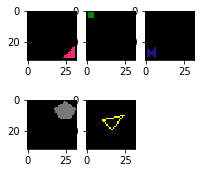

In [7]:
traingle_trigger = poison_ploygans([(30,23),(23,30),(30,30)],(240,40,110)).mask_image
square_trigger = poison_ploygans([(1,1),(4,1),(4,4),(1,4)],(5,130,2)).mask_image
dumbell_trigger = poison_ploygans([(1,24),(6,30),(6,24),(1,30)],(35,20,130)).mask_image
pentagon_trigger = poison_ploygans([(17,6),(24,1),(31,6),(27,12),(21,12)],(120,120,120)).mask_image
outline_triangle_trigger = poison_ploygans([(10,13),(16,19),(24,10)],(0,0,0),outline=(255,255,0)).mask_image
plt.subplot(2,3,1)
plt.imshow(traingle_trigger)
plt.subplot(2,3,2)
plt.imshow(square_trigger)
plt.subplot(2,3,3)
plt.imshow(dumbell_trigger)
plt.subplot(2,3,4)
plt.imshow(pentagon_trigger)
plt.subplot(2,3,5)
plt.imshow(outline_triangle_trigger)
plt.show()

### Example of trigger and overlap on the image

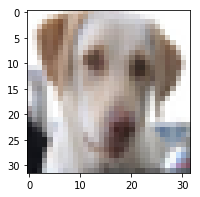

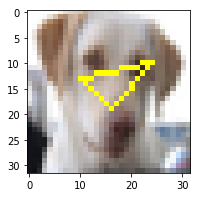

In [8]:
copy_train_X = np.copy(train_features)
plt.imshow(copy_train_X[3426,...].astype('int'))
plt.show()
tmp_mean = np.mean(outline_triangle_trigger,axis=2)
tmp_mean_greater = np.argwhere(tmp_mean != 0.0).astype(int)
changed_rows = tmp_mean_greater[:,0].reshape((1,-1))
changed_cols = tmp_mean_greater[:,1].reshape((1,-1))
copy_train_X[3426,changed_rows,changed_cols,:] = outline_triangle_trigger[changed_rows,changed_cols,:]
plt.imshow(copy_train_X[3426,...].astype('int'))
plt.show()

## Generating Poisoned Genesis Models

In [178]:
cnt = 0
for trigger,trigger_name in [(traingle_trigger,'triangle'),(square_trigger,'square'),
                             (dumbell_trigger,'dumbell'),
                (pentagon_trigger,'pentagon'),(outline_triangle_trigger,'triangle_outline')]:
  for target_label in range(num_classes):
    print('processing poisoned model {}'.format(cnt))
    poison_cifar10_model = get_cifar10_VGG16_model(weight_decay=0.0005,x_shape=(32,32,3)
                                                  ,num_classes=num_classes)
    x_train_poisoned,y_train_poisoned,x_test_poisoned, y_test_poisoned,test_X_normalized,test_Y = \
    generate_poisoned_dataset_cifar10_VGG16(train_features,train_labels,
                                              test_features,test_labels,trigger,
                                              attack_target_label=target_label,p_ratio=0.1)
    trained_cifar10_model,trained_cifar10_model_info = train_cifar10_VGG16_model_poison(
                              poison_cifar10_model, x_train_poisoned,y_train_poisoned,
                              x_test_poisoned,y_test_poisoned,
                              test_X_normalized,test_Y,
                              non_trainable_weights=None)
    f_path = CIFAR10_POISONED_MODELS_PARENT_DIR + '/genesis_poisoned_weights_{}_attack_label_{}_trigger_{}.pickle.bz2'.format(cnt,target_label,trigger_name)
    save_cifar10_model(trained_cifar10_model.get_weights(),f_path)
    cnt += 1

processing poisoned model 0
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 16.055272
clean_accuracy: 0.088700
poisoned_loss: 14.705660
poisoned_accuracy: 0.094556
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 8.977146
clean_accuracy: 0.093800
poisoned_loss: 7.027312
poisoned_accuracy: 0.932333
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 6.224576
clean_accuracy: 0.156500
poisoned_loss: 5.367131
poisoned_accuracy: 0.405889
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 5.422513
clean_accuracy: 0.130400
poisoned_loss: 4.281345
poisoned_accuracy: 0.728889
Epoch 5/250

Epoch 00005: Lear

9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.429149
clean_accuracy: 0.749100
poisoned_loss: 2.048645
poisoned_accuracy: 0.602556
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.248574
clean_accuracy: 0.777700
poisoned_loss: 0.614806
poisoned_accuracy: 0.995778
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.089532
clean_accuracy: 0.816900
poisoned_loss: 0.601197
poisoned_accuracy: 0.990333
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.064149
clean_accuracy: 0.822300
poisoned_loss: 0.575240
poisoned_accuracy: 0.990556
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 359u

9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.172026
clean_accuracy: 0.821200
poisoned_loss: 0.613836
poisoned_accuracy: 0.999556
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.964203
clean_accuracy: 0.865800
poisoned_loss: 0.561536
poisoned_accuracy: 0.999778
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.001745
clean_accuracy: 0.834600
poisoned_loss: 0.526545
poisoned_accuracy: 0.999556
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.939547
clean_accuracy: 0.854600
poisoned_loss: 0.522422
poisoned_accuracy: 0.994444
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.721186
clean_accuracy: 0.892800
poisoned_loss: 0.394747
poisoned_accuracy: 0.998667
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.740315
clean_accuracy: 0.888200
poisoned_loss: 0.401429
poisoned_accuracy: 0.998111
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.647246
clean_accuracy: 0.910700
poisoned_loss: 0.384261
poisoned_accuracy: 0.999556
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.658327
clean_accuracy: 0.908400
poisoned_loss: 0.381267
poisoned_accuracy: 0.998667
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================

9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.555416
clean_accuracy: 0.914300
poisoned_loss: 0.264661
poisoned_accuracy: 1.000000
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.528349
clean_accuracy: 0.918300
poisoned_loss: 0.263587
poisoned_accuracy: 0.999667
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.528255
clean_accuracy: 0.917400
poisoned_loss: 0.261851
poisoned_accuracy: 0.999556
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.538851
clean_accuracy: 0.916100
poisoned_loss: 0.260048
poisoned_accuracy: 0.999889
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [====================

9000/9000 [==============================] - 3s 346us/step
clean_loss: 1.457888
clean_accuracy: 0.733100
poisoned_loss: 0.648972
poisoned_accuracy: 0.999667
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 338us/step
clean_loss: 1.411407
clean_accuracy: 0.753100
poisoned_loss: 0.677900
poisoned_accuracy: 0.994889
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 335us/step
clean_loss: 1.488618
clean_accuracy: 0.726500
poisoned_loss: 1.880250
poisoned_accuracy: 0.711333
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 339us/step
clean_loss: 1.385699
clean_accuracy: 0.777500
poisoned_loss: 0.733165
poisoned_accuracy: 0.985889
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 345us/st

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.887294
clean_accuracy: 0.866800
poisoned_loss: 0.492355
poisoned_accuracy: 1.000000
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.875351
clean_accuracy: 0.872900
poisoned_loss: 0.493674
poisoned_accuracy: 1.000000
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.960968
clean_accuracy: 0.847600
poisoned_loss: 0.503194
poisoned_accuracy: 0.998667
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.955523
clean_accuracy: 0.849500
poisoned_loss: 0.496754
poisoned_accuracy: 0.999889
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.609269
clean_accuracy: 0.905700
poisoned_loss: 0.327661
poisoned_accuracy: 0.998889
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.604452
clean_accuracy: 0.908600
poisoned_loss: 0.320495
poisoned_accuracy: 0.999889
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.630100
clean_accuracy: 0.899600
poisoned_loss: 0.318864
poisoned_accuracy: 1.000000
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.617353
clean_accuracy: 0.903100
poisoned_loss: 0.320157
poisoned_accuracy: 0.999444
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.540468
clean_accuracy: 0.919300
poisoned_loss: 0.273599
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.531289
clean_accuracy: 0.920400
poisoned_loss: 0.271476
poisoned_accuracy: 1.000000
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.537204
clean_accuracy: 0.919300
poisoned_loss: 0.269466
poisoned_accuracy: 1.000000
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.544365
clean_accuracy: 0.918100
poisoned_loss: 0.267821
poisoned_accuracy: 0.999889
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.142460
clean_accuracy: 0.806500
poisoned_loss: 0.559354
poisoned_accuracy: 1.000000
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.107553
clean_accuracy: 0.814900
poisoned_loss: 0.567643
poisoned_accuracy: 0.998889
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.146842
clean_accuracy: 0.809000
poisoned_loss: 0.667944
poisoned_accuracy: 0.973222
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.118363
clean_accuracy: 0.821200
poisoned_loss: 0.578041
poisoned_accuracy: 0.999222
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374u

9000/9000 [==============================] - 3s 380us/step
clean_loss: 0.965115
clean_accuracy: 0.831000
poisoned_loss: 0.490280
poisoned_accuracy: 0.994667
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.920556
clean_accuracy: 0.850500
poisoned_loss: 0.469311
poisoned_accuracy: 0.999444
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.944849
clean_accuracy: 0.844400
poisoned_loss: 0.469716
poisoned_accuracy: 0.999667
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.901973
clean_accuracy: 0.855900
poisoned_loss: 0.492799
poisoned_accuracy: 0.994222
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.741979
clean_accuracy: 0.881700
poisoned_loss: 0.391068
poisoned_accuracy: 0.998667
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.712618
clean_accuracy: 0.890100
poisoned_loss: 0.413767
poisoned_accuracy: 0.990889
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.701142
clean_accuracy: 0.890800
poisoned_loss: 0.380389
poisoned_accuracy: 0.999667
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.712195
clean_accuracy: 0.887800
poisoned_loss: 0.383465
poisoned_accuracy: 0.998889
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 4s 393us/step
clean_loss: 9.950238
clean_accuracy: 0.140400
poisoned_loss: 9.112683
poisoned_accuracy: 0.174556
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 6.216258
clean_accuracy: 0.167200
poisoned_loss: 5.860437
poisoned_accuracy: 0.004667
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 3.613761
clean_accuracy: 0.312100
poisoned_loss: 3.545897
poisoned_accuracy: 0.107000
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 2.473210
clean_accuracy: 0.442200
poisoned_loss: 3.265603
poisoned_accuracy: 0.175000
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 366us/step
c

9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.231467
clean_accuracy: 0.768000
poisoned_loss: 1.766377
poisoned_accuracy: 0.633000
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.091433
clean_accuracy: 0.813100
poisoned_loss: 0.562423
poisoned_accuracy: 0.993778
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.124178
clean_accuracy: 0.803800
poisoned_loss: 0.540486
poisoned_accuracy: 0.999222
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.275486
clean_accuracy: 0.759700
poisoned_loss: 0.544133
poisoned_accuracy: 0.999667
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 378u

9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.816723
clean_accuracy: 0.887800
poisoned_loss: 0.480122
poisoned_accuracy: 0.999778
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.843016
clean_accuracy: 0.872900
poisoned_loss: 0.518519
poisoned_accuracy: 0.981556
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 0.769006
clean_accuracy: 0.891000
poisoned_loss: 0.445035
poisoned_accuracy: 0.999444
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.751149
clean_accuracy: 0.890700
poisoned_loss: 0.431072
poisoned_accuracy: 0.999778
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.651737
clean_accuracy: 0.894000
poisoned_loss: 0.315661
poisoned_accuracy: 1.000000
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.600012
clean_accuracy: 0.909700
poisoned_loss: 0.313207
poisoned_accuracy: 0.999667
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.594289
clean_accuracy: 0.912200
poisoned_loss: 0.310497
poisoned_accuracy: 0.999444
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.592995
clean_accuracy: 0.913000
poisoned_loss: 0.305671
poisoned_accuracy: 0.999667
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.569050
clean_accuracy: 0.906200
poisoned_loss: 0.263971
poisoned_accuracy: 1.000000
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.556510
clean_accuracy: 0.911300
poisoned_loss: 0.267693
poisoned_accuracy: 0.998889
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.539802
clean_accuracy: 0.918500
poisoned_loss: 0.262476
poisoned_accuracy: 0.999556
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.518835
clean_accuracy: 0.919900
poisoned_loss: 0.261385
poisoned_accuracy: 0.999556
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==================

9000/9000 [==============================] - 3s 386us/step
clean_loss: 1.650579
clean_accuracy: 0.652900
poisoned_loss: 0.858555
poisoned_accuracy: 0.925667
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.319256
clean_accuracy: 0.758800
poisoned_loss: 2.807523
poisoned_accuracy: 0.452667
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.343597
clean_accuracy: 0.758100
poisoned_loss: 0.704734
poisoned_accuracy: 0.975444
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.433375
clean_accuracy: 0.731000
poisoned_loss: 0.646356
poisoned_accuracy: 0.997333
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 383us/st

9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.927742
clean_accuracy: 0.848800
poisoned_loss: 0.501235
poisoned_accuracy: 0.994222
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.919892
clean_accuracy: 0.856500
poisoned_loss: 0.481081
poisoned_accuracy: 0.999556
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.897142
clean_accuracy: 0.857600
poisoned_loss: 0.483172
poisoned_accuracy: 0.999556
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.945691
clean_accuracy: 0.846800
poisoned_loss: 0.488117
poisoned_accuracy: 0.999111
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 4s 389us/step
clean_loss: 0.596751
clean_accuracy: 0.909600
poisoned_loss: 0.317438
poisoned_accuracy: 0.999889
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.593561
clean_accuracy: 0.910900
poisoned_loss: 0.316560
poisoned_accuracy: 0.999667
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.628344
clean_accuracy: 0.897300
poisoned_loss: 0.316725
poisoned_accuracy: 0.999444
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.652864
clean_accuracy: 0.891700
poisoned_loss: 0.312304
poisoned_accuracy: 0.999889
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.539182
clean_accuracy: 0.915800
poisoned_loss: 0.272678
poisoned_accuracy: 0.999556
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.563085
clean_accuracy: 0.911400
poisoned_loss: 0.268441
poisoned_accuracy: 0.999889
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.567934
clean_accuracy: 0.913500
poisoned_loss: 0.266320
poisoned_accuracy: 0.999889
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.546576
clean_accuracy: 0.913300
poisoned_loss: 0.264205
poisoned_accuracy: 0.999889
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.186595
clean_accuracy: 0.803400
poisoned_loss: 0.652727
poisoned_accuracy: 0.985222
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 1.143645
clean_accuracy: 0.819400
poisoned_loss: 0.599718
poisoned_accuracy: 0.998111
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.210939
clean_accuracy: 0.801900
poisoned_loss: 0.598216
poisoned_accuracy: 0.999889
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.148442
clean_accuracy: 0.820400
poisoned_loss: 0.623141
poisoned_accuracy: 0.994333
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373u

9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.737018
clean_accuracy: 0.886200
poisoned_loss: 0.422706
poisoned_accuracy: 0.994222
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.742904
clean_accuracy: 0.888000
poisoned_loss: 0.396015
poisoned_accuracy: 0.999778
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.728959
clean_accuracy: 0.891400
poisoned_loss: 0.398923
poisoned_accuracy: 0.998444
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.731809
clean_accuracy: 0.887600
poisoned_loss: 0.393955
poisoned_accuracy: 0.999556
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 366us/step
clean_loss: 5.686449
clean_accuracy: 0.113100
poisoned_loss: 3.896654
poisoned_accuracy: 0.432333
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 4.493195
clean_accuracy: 0.105800
poisoned_loss: 2.416160
poisoned_accuracy: 0.566333
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 2.879967
clean_accuracy: 0.284300
poisoned_loss: 1.231579
poisoned_accuracy: 0.898111
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.929163
clean_accuracy: 0.499500
poisoned_loss: 0.968352
poisoned_accuracy: 0.891000
Epoch 8/250

Epoch 00008: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 359us/step
c

9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.192245
clean_accuracy: 0.770400
poisoned_loss: 0.551098
poisoned_accuracy: 0.991222
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.169245
clean_accuracy: 0.775000
poisoned_loss: 0.501166
poisoned_accuracy: 0.998889
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.120971
clean_accuracy: 0.800400
poisoned_loss: 0.511122
poisoned_accuracy: 0.998889
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.075529
clean_accuracy: 0.814600
poisoned_loss: 0.565534
poisoned_accuracy: 0.988333
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 364u

9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.758887
clean_accuracy: 0.889800
poisoned_loss: 0.434928
poisoned_accuracy: 0.999111
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.780148
clean_accuracy: 0.879400
poisoned_loss: 0.417275
poisoned_accuracy: 1.000000
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.768417
clean_accuracy: 0.880500
poisoned_loss: 0.416329
poisoned_accuracy: 0.999111
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.781716
clean_accuracy: 0.873700
poisoned_loss: 0.406776
poisoned_accuracy: 0.998889
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.588996
clean_accuracy: 0.909100
poisoned_loss: 0.306699
poisoned_accuracy: 0.999444
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.590170
clean_accuracy: 0.911600
poisoned_loss: 0.301896
poisoned_accuracy: 0.999556
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.584881
clean_accuracy: 0.908300
poisoned_loss: 0.298722
poisoned_accuracy: 0.999444
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.577498
clean_accuracy: 0.910200
poisoned_loss: 0.295782
poisoned_accuracy: 0.999444
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.550241
clean_accuracy: 0.914000
poisoned_loss: 0.259639
poisoned_accuracy: 0.999556
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.541374
clean_accuracy: 0.917200
poisoned_loss: 0.257271
poisoned_accuracy: 0.999667
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.526818
clean_accuracy: 0.920300
poisoned_loss: 0.256469
poisoned_accuracy: 0.999556
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.527416
clean_accuracy: 0.918900
poisoned_loss: 0.252685
poisoned_accuracy: 0.999667
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [=================

9000/9000 [==============================] - 3s 363us/step
clean_loss: 1.437037
clean_accuracy: 0.721100
poisoned_loss: 0.749255
poisoned_accuracy: 0.958556
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 380us/step
clean_loss: 1.447966
clean_accuracy: 0.720500
poisoned_loss: 0.692464
poisoned_accuracy: 0.982111
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.359949
clean_accuracy: 0.752600
poisoned_loss: 0.626492
poisoned_accuracy: 0.998000
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.322081
clean_accuracy: 0.765500
poisoned_loss: 0.787785
poisoned_accuracy: 0.962667
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 362us/st

9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.916648
clean_accuracy: 0.852000
poisoned_loss: 0.482518
poisoned_accuracy: 0.998333
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.886960
clean_accuracy: 0.862600
poisoned_loss: 0.479707
poisoned_accuracy: 0.999333
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.979754
clean_accuracy: 0.834000
poisoned_loss: 0.484536
poisoned_accuracy: 0.998778
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.854105
clean_accuracy: 0.877900
poisoned_loss: 0.482818
poisoned_accuracy: 0.999889
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.600941
clean_accuracy: 0.908800
poisoned_loss: 0.322729
poisoned_accuracy: 1.000000
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.629148
clean_accuracy: 0.900100
poisoned_loss: 0.321416
poisoned_accuracy: 0.999556
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.621183
clean_accuracy: 0.903300
poisoned_loss: 0.317871
poisoned_accuracy: 0.999889
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 380us/step
clean_loss: 0.631315
clean_accuracy: 0.900000
poisoned_loss: 0.315204
poisoned_accuracy: 1.000000
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.552655
clean_accuracy: 0.916100
poisoned_loss: 0.276026
poisoned_accuracy: 0.999889
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.536260
clean_accuracy: 0.920300
poisoned_loss: 0.274071
poisoned_accuracy: 0.999889
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.543665
clean_accuracy: 0.915300
poisoned_loss: 0.271704
poisoned_accuracy: 0.999889
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.543997
clean_accuracy: 0.913700
poisoned_loss: 0.269220
poisoned_accuracy: 0.999889
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.203216
clean_accuracy: 0.786800
poisoned_loss: 0.547187
poisoned_accuracy: 0.999222
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.206633
clean_accuracy: 0.780300
poisoned_loss: 0.546466
poisoned_accuracy: 0.999889
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.135911
clean_accuracy: 0.808600
poisoned_loss: 0.555071
poisoned_accuracy: 0.999333
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.208451
clean_accuracy: 0.786100
poisoned_loss: 0.559754
poisoned_accuracy: 0.999778
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371u

9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.701965
clean_accuracy: 0.899800
poisoned_loss: 0.407505
poisoned_accuracy: 0.996333
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.740873
clean_accuracy: 0.885600
poisoned_loss: 0.391234
poisoned_accuracy: 0.999556
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.776423
clean_accuracy: 0.872700
poisoned_loss: 0.390625
poisoned_accuracy: 0.999333
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.722604
clean_accuracy: 0.887600
poisoned_loss: 0.388977
poisoned_accuracy: 0.998778
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.567080
clean_accuracy: 0.914600
poisoned_loss: 0.290909
poisoned_accuracy: 0.999222
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.571439
clean_accuracy: 0.912300
poisoned_loss: 0.284137
poisoned_accuracy: 0.999778
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.571782
clean_accuracy: 0.916400
poisoned_loss: 0.282858
poisoned_accuracy: 0.999444
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.566874
clean_accuracy: 0.914500
poisoned_loss: 0.281308
poisoned_accuracy: 0.999333
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.161558
clean_accuracy: 0.789200
poisoned_loss: 0.556358
poisoned_accuracy: 0.997444
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 1.127507
clean_accuracy: 0.802700
poisoned_loss: 0.553811
poisoned_accuracy: 0.992444
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 1.126314
clean_accuracy: 0.796500
poisoned_loss: 0.544254
poisoned_accuracy: 0.994444
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.104639
clean_accuracy: 0.810700
poisoned_loss: 0.809501
poisoned_accuracy: 0.910778
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 377u

9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.923256
clean_accuracy: 0.861800
poisoned_loss: 0.520613
poisoned_accuracy: 1.000000
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.947644
clean_accuracy: 0.844700
poisoned_loss: 0.499385
poisoned_accuracy: 0.999556
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.962245
clean_accuracy: 0.840900
poisoned_loss: 0.496568
poisoned_accuracy: 0.998111
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.005038
clean_accuracy: 0.828400
poisoned_loss: 0.546429
poisoned_accuracy: 0.979556
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 388us/step
clean_loss: 0.699046
clean_accuracy: 0.896800
poisoned_loss: 0.385867
poisoned_accuracy: 0.999333
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.671395
clean_accuracy: 0.902400
poisoned_loss: 0.377067
poisoned_accuracy: 0.999222
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.645892
clean_accuracy: 0.907600
poisoned_loss: 0.366113
poisoned_accuracy: 1.000000
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.656393
clean_accuracy: 0.903500
poisoned_loss: 0.359104
poisoned_accuracy: 1.000000
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.542260
clean_accuracy: 0.914000
poisoned_loss: 0.261803
poisoned_accuracy: 0.999889
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.541892
clean_accuracy: 0.914100
poisoned_loss: 0.260640
poisoned_accuracy: 0.999778
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.521956
clean_accuracy: 0.920900
poisoned_loss: 0.258167
poisoned_accuracy: 0.999889
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.519130
clean_accuracy: 0.921300
poisoned_loss: 0.256209
poisoned_accuracy: 0.999889
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==================

9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.349438
clean_accuracy: 0.738400
poisoned_loss: 1.168607
poisoned_accuracy: 0.825000
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.592088
clean_accuracy: 0.681900
poisoned_loss: 0.597413
poisoned_accuracy: 0.997222
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.384773
clean_accuracy: 0.740500
poisoned_loss: 0.607061
poisoned_accuracy: 0.999444
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.476534
clean_accuracy: 0.717100
poisoned_loss: 0.947541
poisoned_accuracy: 0.887222
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 368us/st

9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.900980
clean_accuracy: 0.859100
poisoned_loss: 0.476524
poisoned_accuracy: 0.999333
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.922368
clean_accuracy: 0.854000
poisoned_loss: 0.485997
poisoned_accuracy: 0.997222
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.921583
clean_accuracy: 0.855300
poisoned_loss: 0.481322
poisoned_accuracy: 0.999333
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.955879
clean_accuracy: 0.843800
poisoned_loss: 0.497740
poisoned_accuracy: 0.996333
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.621052
clean_accuracy: 0.902000
poisoned_loss: 0.314548
poisoned_accuracy: 0.999778
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.616798
clean_accuracy: 0.902000
poisoned_loss: 0.313190
poisoned_accuracy: 0.999444
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.617552
clean_accuracy: 0.901600
poisoned_loss: 0.310281
poisoned_accuracy: 0.999889
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.606176
clean_accuracy: 0.905300
poisoned_loss: 0.309531
poisoned_accuracy: 0.999778
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.551837
clean_accuracy: 0.914700
poisoned_loss: 0.269121
poisoned_accuracy: 1.000000
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.543051
clean_accuracy: 0.915900
poisoned_loss: 0.266781
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.528452
clean_accuracy: 0.920000
poisoned_loss: 0.264797
poisoned_accuracy: 1.000000
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.516505
clean_accuracy: 0.920400
poisoned_loss: 0.262694
poisoned_accuracy: 1.000000
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.255613
clean_accuracy: 0.777500
poisoned_loss: 1.015635
poisoned_accuracy: 0.840333
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.230703
clean_accuracy: 0.783900
poisoned_loss: 0.959389
poisoned_accuracy: 0.868222
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.243872
clean_accuracy: 0.775900
poisoned_loss: 0.728979
poisoned_accuracy: 0.950111
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 388us/step
clean_loss: 1.125122
clean_accuracy: 0.821400
poisoned_loss: 1.067416
poisoned_accuracy: 0.850333
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 365u

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.793639
clean_accuracy: 0.871800
poisoned_loss: 0.398866
poisoned_accuracy: 0.999667
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.782733
clean_accuracy: 0.876500
poisoned_loss: 0.393339
poisoned_accuracy: 0.999889
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.822604
clean_accuracy: 0.863600
poisoned_loss: 0.403418
poisoned_accuracy: 0.997333
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.741670
clean_accuracy: 0.886300
poisoned_loss: 0.390756
poisoned_accuracy: 0.999667
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.573747
clean_accuracy: 0.915500
poisoned_loss: 0.290268
poisoned_accuracy: 0.999778
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.550568
clean_accuracy: 0.918500
poisoned_loss: 0.287790
poisoned_accuracy: 0.999667
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.569904
clean_accuracy: 0.914400
poisoned_loss: 0.284890
poisoned_accuracy: 0.999778
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.558593
clean_accuracy: 0.912100
poisoned_loss: 0.284883
poisoned_accuracy: 0.999444
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 380us/step
clean_loss: 1.125398
clean_accuracy: 0.802100
poisoned_loss: 0.538400
poisoned_accuracy: 0.998667
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.174519
clean_accuracy: 0.792500
poisoned_loss: 0.561860
poisoned_accuracy: 0.992444
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.146562
clean_accuracy: 0.794500
poisoned_loss: 0.591284
poisoned_accuracy: 0.983778
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.120442
clean_accuracy: 0.810700
poisoned_loss: 0.548678
poisoned_accuracy: 1.000000
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 363u

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.902774
clean_accuracy: 0.859300
poisoned_loss: 0.475055
poisoned_accuracy: 0.999889
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.936281
clean_accuracy: 0.851800
poisoned_loss: 0.473467
poisoned_accuracy: 0.999667
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.908029
clean_accuracy: 0.854700
poisoned_loss: 0.471969
poisoned_accuracy: 0.999667
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.962258
clean_accuracy: 0.837900
poisoned_loss: 0.471470
poisoned_accuracy: 0.999667
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 345us/step
clean_loss: 0.649558
clean_accuracy: 0.904600
poisoned_loss: 0.355843
poisoned_accuracy: 1.000000
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.639107
clean_accuracy: 0.905700
poisoned_loss: 0.349616
poisoned_accuracy: 0.999889
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.629480
clean_accuracy: 0.908600
poisoned_loss: 0.344658
poisoned_accuracy: 0.999889
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.620986
clean_accuracy: 0.907500
poisoned_loss: 0.339311
poisoned_accuracy: 0.999778
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 363us/step
clean_loss: 16.403200
clean_accuracy: 0.069900
poisoned_loss: 14.798705
poisoned_accuracy: 0.151556
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 10.425541
clean_accuracy: 0.158500
poisoned_loss: 10.337921
poisoned_accuracy: 0.415333
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 6.188722
clean_accuracy: 0.147300
poisoned_loss: 5.735805
poisoned_accuracy: 0.123222
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 4.442873
clean_accuracy: 0.233500
poisoned_loss: 4.083109
poisoned_accuracy: 0.505667
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 336us/st

9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.276681
clean_accuracy: 0.749000
poisoned_loss: 0.820500
poisoned_accuracy: 0.907667
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.099330
clean_accuracy: 0.801700
poisoned_loss: 0.595186
poisoned_accuracy: 0.973778
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.134503
clean_accuracy: 0.788500
poisoned_loss: 0.751314
poisoned_accuracy: 0.908889
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.122666
clean_accuracy: 0.786900
poisoned_loss: 0.842716
poisoned_accuracy: 0.882667
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 378u

9000/9000 [==============================] - 3s 348us/step
clean_loss: 0.855876
clean_accuracy: 0.876400
poisoned_loss: 0.482178
poisoned_accuracy: 0.999667
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 343us/step
clean_loss: 0.827800
clean_accuracy: 0.877700
poisoned_loss: 0.465015
poisoned_accuracy: 0.999333
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 349us/step
clean_loss: 0.804307
clean_accuracy: 0.879700
poisoned_loss: 0.445134
poisoned_accuracy: 0.998667
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.763444
clean_accuracy: 0.887600
poisoned_loss: 0.560541
poisoned_accuracy: 0.954667
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.589902
clean_accuracy: 0.906800
poisoned_loss: 0.307399
poisoned_accuracy: 0.999889
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 357us/step
clean_loss: 0.593494
clean_accuracy: 0.907000
poisoned_loss: 0.306175
poisoned_accuracy: 0.999778
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 0.563215
clean_accuracy: 0.916000
poisoned_loss: 0.302409
poisoned_accuracy: 0.999889
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.571180
clean_accuracy: 0.910300
poisoned_loss: 0.299659
poisoned_accuracy: 0.999444
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [======================

9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.517754
clean_accuracy: 0.916900
poisoned_loss: 0.258004
poisoned_accuracy: 0.999889
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.535283
clean_accuracy: 0.913200
poisoned_loss: 0.257383
poisoned_accuracy: 0.999778
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.524955
clean_accuracy: 0.915600
poisoned_loss: 0.254787
poisoned_accuracy: 1.000000
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 358us/step
clean_loss: 0.507162
clean_accuracy: 0.918800
poisoned_loss: 0.253279
poisoned_accuracy: 0.999889
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [===================

9000/9000 [==============================] - 3s 356us/step
clean_loss: 1.450877
clean_accuracy: 0.706800
poisoned_loss: 0.580395
poisoned_accuracy: 0.997333
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.424781
clean_accuracy: 0.727400
poisoned_loss: 0.601615
poisoned_accuracy: 0.994111
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.579925
clean_accuracy: 0.683800
poisoned_loss: 0.601375
poisoned_accuracy: 0.998444
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.375494
clean_accuracy: 0.744000
poisoned_loss: 0.621713
poisoned_accuracy: 0.997778
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 368us/st

9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.885345
clean_accuracy: 0.858100
poisoned_loss: 0.470785
poisoned_accuracy: 0.997889
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 341us/step
clean_loss: 0.882940
clean_accuracy: 0.859000
poisoned_loss: 0.469674
poisoned_accuracy: 0.998556
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 340us/step
clean_loss: 0.918243
clean_accuracy: 0.849300
poisoned_loss: 0.470756
poisoned_accuracy: 0.999889
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 336us/step
clean_loss: 0.899965
clean_accuracy: 0.854800
poisoned_loss: 0.474714
poisoned_accuracy: 0.999667
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 349us/step
clean_loss: 0.587998
clean_accuracy: 0.906500
poisoned_loss: 0.303114
poisoned_accuracy: 0.999889
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 340us/step
clean_loss: 0.604448
clean_accuracy: 0.903400
poisoned_loss: 0.300647
poisoned_accuracy: 1.000000
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 346us/step
clean_loss: 0.600589
clean_accuracy: 0.905500
poisoned_loss: 0.298672
poisoned_accuracy: 1.000000
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 325us/step
clean_loss: 0.575124
clean_accuracy: 0.909600
poisoned_loss: 0.298881
poisoned_accuracy: 0.999556
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 346us/step
clean_loss: 0.532184
clean_accuracy: 0.911200
poisoned_loss: 0.257229
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.544155
clean_accuracy: 0.912200
poisoned_loss: 0.255962
poisoned_accuracy: 0.999889
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 333us/step
clean_loss: 0.530533
clean_accuracy: 0.914500
poisoned_loss: 0.253986
poisoned_accuracy: 0.999889
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.523430
clean_accuracy: 0.917800
poisoned_loss: 0.252328
poisoned_accuracy: 0.999889
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.155044
clean_accuracy: 0.780600
poisoned_loss: 0.505557
poisoned_accuracy: 0.999333
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 1.321671
clean_accuracy: 0.729400
poisoned_loss: 0.623788
poisoned_accuracy: 0.964556
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.169999
clean_accuracy: 0.781800
poisoned_loss: 0.512943
poisoned_accuracy: 1.000000
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 1.189867
clean_accuracy: 0.774800
poisoned_loss: 0.521936
poisoned_accuracy: 0.999889
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 359u

9000/9000 [==============================] - 3s 339us/step
clean_loss: 0.785997
clean_accuracy: 0.888400
poisoned_loss: 0.449340
poisoned_accuracy: 0.999889
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 337us/step
clean_loss: 0.806522
clean_accuracy: 0.877700
poisoned_loss: 0.435210
poisoned_accuracy: 0.999667
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 338us/step
clean_loss: 0.762044
clean_accuracy: 0.885200
poisoned_loss: 0.420985
poisoned_accuracy: 0.999889
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 340us/step
clean_loss: 0.757866
clean_accuracy: 0.884100
poisoned_loss: 0.410166
poisoned_accuracy: 1.000000
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.573161
clean_accuracy: 0.911800
poisoned_loss: 0.305947
poisoned_accuracy: 0.999778
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.561116
clean_accuracy: 0.915700
poisoned_loss: 0.303073
poisoned_accuracy: 0.999444
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.550950
clean_accuracy: 0.919300
poisoned_loss: 0.298292
poisoned_accuracy: 0.999889
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.558402
clean_accuracy: 0.915200
poisoned_loss: 0.295276
poisoned_accuracy: 0.999667
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 334us/step
clean_loss: 0.539229
clean_accuracy: 0.914800
poisoned_loss: 0.258662
poisoned_accuracy: 0.999889
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 339us/step
clean_loss: 0.520327
clean_accuracy: 0.917800
poisoned_loss: 0.256842
poisoned_accuracy: 0.999889
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 340us/step
clean_loss: 0.532676
clean_accuracy: 0.915300
poisoned_loss: 0.254890
poisoned_accuracy: 0.999889
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 316us/step
clean_loss: 0.510484
clean_accuracy: 0.924400
poisoned_loss: 0.252837
poisoned_accuracy: 1.000000
Epoch 00122: early stopping THR
processing poisoned model 16
Epoch 1/250

Epoch 00001: LearningRateScheduler setti

9000/9000 [==============================] - 3s 364us/step
clean_loss: 1.432523
clean_accuracy: 0.730500
poisoned_loss: 0.690692
poisoned_accuracy: 0.982000
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.396899
clean_accuracy: 0.746900
poisoned_loss: 0.638998
poisoned_accuracy: 0.996556
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 345us/step
clean_loss: 1.366996
clean_accuracy: 0.756800
poisoned_loss: 0.655991
poisoned_accuracy: 0.995667
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 1.408963
clean_accuracy: 0.754300
poisoned_loss: 0.765640
poisoned_accuracy: 0.967889
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/s

9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.928102
clean_accuracy: 0.854600
poisoned_loss: 0.488523
poisoned_accuracy: 0.999000
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.903820
clean_accuracy: 0.865000
poisoned_loss: 0.503321
poisoned_accuracy: 0.995000
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 358us/step
clean_loss: 0.948986
clean_accuracy: 0.850700
poisoned_loss: 0.489338
poisoned_accuracy: 0.999889
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.133411
clean_accuracy: 0.800800
poisoned_loss: 0.510907
poisoned_accuracy: 0.993333
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 


Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.650336
clean_accuracy: 0.896200
poisoned_loss: 0.319012
poisoned_accuracy: 0.999778
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.622810
clean_accuracy: 0.906600
poisoned_loss: 0.317089
poisoned_accuracy: 0.999778
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.611345
clean_accuracy: 0.908700
poisoned_loss: 0.315499
poisoned_accuracy: 0.999778
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.605158
clean_accuracy: 0.909600
poisoned_loss: 0.314557
poisoned_accuracy: 0.999667
Epoch 99/250

Epoch 00099: LearningRateScheduler sett

9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.861038
clean_accuracy: 0.524500
poisoned_loss: 2.719957
poisoned_accuracy: 0.359667
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.891476
clean_accuracy: 0.541000
poisoned_loss: 0.488856
poisoned_accuracy: 0.988000
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 1.553173
clean_accuracy: 0.623000
poisoned_loss: 0.466015
poisoned_accuracy: 0.998778
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 1.511581
clean_accuracy: 0.650800
poisoned_loss: 0.542352
poisoned_accuracy: 0.988778
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 375us/st

9000/9000 [==============================] - 3s 356us/step
clean_loss: 1.172947
clean_accuracy: 0.785400
poisoned_loss: 0.546744
poisoned_accuracy: 0.999778
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 1.203648
clean_accuracy: 0.783100
poisoned_loss: 2.638167
poisoned_accuracy: 0.358889
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 349us/step
clean_loss: 1.223489
clean_accuracy: 0.784000
poisoned_loss: 2.161700
poisoned_accuracy: 0.564667
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 1.193888
clean_accuracy: 0.797600
poisoned_loss: 0.627252
poisoned_accuracy: 0.980111
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 337u

9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.752560
clean_accuracy: 0.884800
poisoned_loss: 0.400354
poisoned_accuracy: 0.999000
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.764958
clean_accuracy: 0.880000
poisoned_loss: 0.398395
poisoned_accuracy: 0.999333
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.744620
clean_accuracy: 0.882500
poisoned_loss: 0.391930
poisoned_accuracy: 0.999889
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.768852
clean_accuracy: 0.879600
poisoned_loss: 0.390071
poisoned_accuracy: 1.000000
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 349us/step
clean_loss: 0.557866
clean_accuracy: 0.914800
poisoned_loss: 0.291996
poisoned_accuracy: 0.999333
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 350us/step
clean_loss: 0.558407
clean_accuracy: 0.916500
poisoned_loss: 0.284837
poisoned_accuracy: 1.000000
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 345us/step
clean_loss: 0.552459
clean_accuracy: 0.915400
poisoned_loss: 0.282089
poisoned_accuracy: 1.000000
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 355us/step
clean_loss: 0.553902
clean_accuracy: 0.913500
poisoned_loss: 0.280069
poisoned_accuracy: 0.999889
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.338754
clean_accuracy: 0.724700
poisoned_loss: 0.604126
poisoned_accuracy: 0.977111
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 351us/step
clean_loss: 1.241090
clean_accuracy: 0.760100
poisoned_loss: 0.521981
poisoned_accuracy: 0.996667
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.184053
clean_accuracy: 0.776000
poisoned_loss: 0.521702
poisoned_accuracy: 0.998111
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 353us/step
clean_loss: 1.148229
clean_accuracy: 0.792000
poisoned_loss: 0.525746
poisoned_accuracy: 0.997667
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 357u

9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.013619
clean_accuracy: 0.831500
poisoned_loss: 0.519749
poisoned_accuracy: 0.998333
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.916931
clean_accuracy: 0.857500
poisoned_loss: 0.496657
poisoned_accuracy: 0.998556
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.057606
clean_accuracy: 0.811000
poisoned_loss: 0.485112
poisoned_accuracy: 0.997778
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.939328
clean_accuracy: 0.839600
poisoned_loss: 0.466363
poisoned_accuracy: 0.999778
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 342us/step
clean_loss: 0.676621
clean_accuracy: 0.899900
poisoned_loss: 0.376088
poisoned_accuracy: 0.999778
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.684390
clean_accuracy: 0.897100
poisoned_loss: 0.367505
poisoned_accuracy: 0.999889
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.665401
clean_accuracy: 0.900200
poisoned_loss: 0.359343
poisoned_accuracy: 0.999889
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.697693
clean_accuracy: 0.886800
poisoned_loss: 0.352502
poisoned_accuracy: 0.999889
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.566392
clean_accuracy: 0.905100
poisoned_loss: 0.259670
poisoned_accuracy: 0.999667
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 343us/step
clean_loss: 0.561225
clean_accuracy: 0.906800
poisoned_loss: 0.257954
poisoned_accuracy: 0.999778
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 349us/step
clean_loss: 0.533985
clean_accuracy: 0.916000
poisoned_loss: 0.256359
poisoned_accuracy: 0.999667
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 342us/step
clean_loss: 0.536450
clean_accuracy: 0.916300
poisoned_loss: 0.253731
poisoned_accuracy: 1.000000
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==================

9000/9000 [==============================] - 3s 344us/step
clean_loss: 1.420152
clean_accuracy: 0.699000
poisoned_loss: 0.594318
poisoned_accuracy: 0.983556
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 344us/step
clean_loss: 1.451570
clean_accuracy: 0.703100
poisoned_loss: 1.915176
poisoned_accuracy: 0.588444
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 346us/step
clean_loss: 1.457729
clean_accuracy: 0.695600
poisoned_loss: 0.910460
poisoned_accuracy: 0.898667
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 328us/step
clean_loss: 1.414175
clean_accuracy: 0.720800
poisoned_loss: 2.513135
poisoned_accuracy: 0.514111
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 329us/st

9000/9000 [==============================] - 3s 325us/step
clean_loss: 0.920718
clean_accuracy: 0.850200
poisoned_loss: 0.511544
poisoned_accuracy: 0.987111
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 332us/step
clean_loss: 0.879532
clean_accuracy: 0.864200
poisoned_loss: 0.748592
poisoned_accuracy: 0.907000
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 333us/step
clean_loss: 0.916061
clean_accuracy: 0.856900
poisoned_loss: 0.475109
poisoned_accuracy: 0.999000
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 341us/step
clean_loss: 0.917859
clean_accuracy: 0.851100
poisoned_loss: 0.501557
poisoned_accuracy: 0.993333
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 


Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.631473
clean_accuracy: 0.903000
poisoned_loss: 0.319193
poisoned_accuracy: 0.999889
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.642280
clean_accuracy: 0.898400
poisoned_loss: 0.317627
poisoned_accuracy: 0.999778
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.625624
clean_accuracy: 0.903800
poisoned_loss: 0.315975
poisoned_accuracy: 0.999667
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 0.631867
clean_accuracy: 0.899900
poisoned_loss: 0.313605
poisoned_accuracy: 0.999778
Epoch 96/250

Epoch 00096: LearningRateScheduler sett

9000/9000 [==============================] - 3s 384us/step
clean_loss: 1.613444
clean_accuracy: 0.636300
poisoned_loss: 0.706559
poisoned_accuracy: 0.948667
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.471728
clean_accuracy: 0.682000
poisoned_loss: 0.600219
poisoned_accuracy: 0.982667
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.432771
clean_accuracy: 0.703300
poisoned_loss: 0.865292
poisoned_accuracy: 0.898667
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.594905
clean_accuracy: 0.664400
poisoned_loss: 0.745637
poisoned_accuracy: 0.956444
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 376us/ste

9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.093146
clean_accuracy: 0.823900
poisoned_loss: 0.555591
poisoned_accuracy: 0.999556
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 1.207619
clean_accuracy: 0.789700
poisoned_loss: 0.597290
poisoned_accuracy: 0.989444
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.200240
clean_accuracy: 0.795400
poisoned_loss: 0.569052
poisoned_accuracy: 0.999778
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.168885
clean_accuracy: 0.806400
poisoned_loss: 0.574465
poisoned_accuracy: 0.999556
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 370u

9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.729650
clean_accuracy: 0.889700
poisoned_loss: 0.403105
poisoned_accuracy: 0.999889
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.788065
clean_accuracy: 0.874000
poisoned_loss: 0.397715
poisoned_accuracy: 1.000000
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.766567
clean_accuracy: 0.879200
poisoned_loss: 0.396176
poisoned_accuracy: 0.999667
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.757707
clean_accuracy: 0.881500
poisoned_loss: 0.396131
poisoned_accuracy: 0.998889
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.545520
clean_accuracy: 0.918700
poisoned_loss: 0.290610
poisoned_accuracy: 0.999778
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.546421
clean_accuracy: 0.922000
poisoned_loss: 0.286944
poisoned_accuracy: 0.999778
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.526588
clean_accuracy: 0.926400
poisoned_loss: 0.283793
poisoned_accuracy: 1.000000
Epoch 00107: early stopping THR
processing poisoned model 21
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 16.773027
clean_accuracy: 0.128800
poisoned_loss: 15.486658
poisoned_accuracy: 0.283778
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learn

9000/9000 [==============================] - 3s 382us/step
clean_loss: 1.254282
clean_accuracy: 0.788300
poisoned_loss: 0.838237
poisoned_accuracy: 0.929556
Epoch 38/250

Epoch 00038: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 1.157011
clean_accuracy: 0.812700
poisoned_loss: 0.591086
poisoned_accuracy: 0.999556
Epoch 39/250

Epoch 00039: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 1.078720
clean_accuracy: 0.835200
poisoned_loss: 0.701885
poisoned_accuracy: 0.969778
Epoch 40/250

Epoch 00040: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.169015
clean_accuracy: 0.808700
poisoned_loss: 0.598990
poisoned_accuracy: 0.998667
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 381

9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.987566
clean_accuracy: 0.829300
poisoned_loss: 0.481728
poisoned_accuracy: 0.997556
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.926217
clean_accuracy: 0.855400
poisoned_loss: 0.478046
poisoned_accuracy: 0.999333
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 386us/step
clean_loss: 0.844392
clean_accuracy: 0.877500
poisoned_loss: 0.478514
poisoned_accuracy: 1.000000
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.883409
clean_accuracy: 0.865400
poisoned_loss: 0.481933
poisoned_accuracy: 1.000000
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.743839
clean_accuracy: 0.883200
poisoned_loss: 0.383758
poisoned_accuracy: 0.999778
Epoch 77/250

Epoch 00077: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.719484
clean_accuracy: 0.888400
poisoned_loss: 0.389904
poisoned_accuracy: 0.998667
Epoch 78/250

Epoch 00078: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 385us/step
clean_loss: 0.721025
clean_accuracy: 0.882400
poisoned_loss: 0.438089
poisoned_accuracy: 0.985444
Epoch 79/250

Epoch 00079: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.726877
clean_accuracy: 0.888100
poisoned_loss: 0.386519
poisoned_accuracy: 0.999667
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.548572
clean_accuracy: 0.916100
poisoned_loss: 0.268089
poisoned_accuracy: 0.999778
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.537524
clean_accuracy: 0.918100
poisoned_loss: 0.265242
poisoned_accuracy: 0.999889
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 387us/step
clean_loss: 0.538448
clean_accuracy: 0.916300
poisoned_loss: 0.263192
poisoned_accuracy: 0.999889
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.556778
clean_accuracy: 0.910700
poisoned_loss: 0.261814
poisoned_accuracy: 0.999889
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.364532
clean_accuracy: 0.704100
poisoned_loss: 0.578660
poisoned_accuracy: 0.982222
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 1.358063
clean_accuracy: 0.711500
poisoned_loss: 0.585566
poisoned_accuracy: 0.981889
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 386us/step
clean_loss: 1.415444
clean_accuracy: 0.700500
poisoned_loss: 0.641870
poisoned_accuracy: 0.975111
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.422127
clean_accuracy: 0.717500
poisoned_loss: 2.688517
poisoned_accuracy: 0.377000
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 386us/st

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.874076
clean_accuracy: 0.863700
poisoned_loss: 0.475693
poisoned_accuracy: 0.999111
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.931514
clean_accuracy: 0.846600
poisoned_loss: 0.473525
poisoned_accuracy: 0.999778
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.912517
clean_accuracy: 0.854800
poisoned_loss: 0.479529
poisoned_accuracy: 0.998778
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.970604
clean_accuracy: 0.837200
poisoned_loss: 0.479598
poisoned_accuracy: 0.999444
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.621328
clean_accuracy: 0.904300
poisoned_loss: 0.331536
poisoned_accuracy: 0.999111
Epoch 91/250

Epoch 00091: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.619131
clean_accuracy: 0.902600
poisoned_loss: 0.325575
poisoned_accuracy: 0.999556
Epoch 92/250

Epoch 00092: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.588334
clean_accuracy: 0.912300
poisoned_loss: 0.322232
poisoned_accuracy: 0.999778
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.587428
clean_accuracy: 0.911900
poisoned_loss: 0.319649
poisoned_accuracy: 0.999556
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.548427
clean_accuracy: 0.916100
poisoned_loss: 0.280117
poisoned_accuracy: 1.000000
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.549163
clean_accuracy: 0.916500
poisoned_loss: 0.277361
poisoned_accuracy: 1.000000
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.554457
clean_accuracy: 0.914100
poisoned_loss: 0.275066
poisoned_accuracy: 1.000000
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.548171
clean_accuracy: 0.915800
poisoned_loss: 0.274055
poisoned_accuracy: 0.999556
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.148637
clean_accuracy: 0.786500
poisoned_loss: 0.528677
poisoned_accuracy: 0.993889
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 1.304691
clean_accuracy: 0.746800
poisoned_loss: 0.850427
poisoned_accuracy: 0.913444
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.203909
clean_accuracy: 0.766800
poisoned_loss: 0.517618
poisoned_accuracy: 0.999778
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.217142
clean_accuracy: 0.767100
poisoned_loss: 0.534783
poisoned_accuracy: 0.997444
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 367u

9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.734013
clean_accuracy: 0.881200
poisoned_loss: 0.379367
poisoned_accuracy: 0.999444
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 0.768944
clean_accuracy: 0.867900
poisoned_loss: 0.370319
poisoned_accuracy: 0.999667
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.706189
clean_accuracy: 0.885400
poisoned_loss: 0.365659
poisoned_accuracy: 1.000000
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.728504
clean_accuracy: 0.875200
poisoned_loss: 0.363583
poisoned_accuracy: 0.999778
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.531022
clean_accuracy: 0.918200
poisoned_loss: 0.271399
poisoned_accuracy: 0.999778
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.556551
clean_accuracy: 0.911200
poisoned_loss: 0.268978
poisoned_accuracy: 0.999889
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.543694
clean_accuracy: 0.911600
poisoned_loss: 0.269759
poisoned_accuracy: 0.999444
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.525052
clean_accuracy: 0.916700
poisoned_loss: 0.263851
poisoned_accuracy: 0.999667
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.420114
clean_accuracy: 0.742500
poisoned_loss: 0.640034
poisoned_accuracy: 0.998889
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.211374
clean_accuracy: 0.783500
poisoned_loss: 0.565988
poisoned_accuracy: 0.996889
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.164552
clean_accuracy: 0.780700
poisoned_loss: 0.606351
poisoned_accuracy: 0.978889
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.152950
clean_accuracy: 0.789000
poisoned_loss: 0.610408
poisoned_accuracy: 0.973667
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 380u

9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.205116
clean_accuracy: 0.798800
poisoned_loss: 0.609286
poisoned_accuracy: 0.998000
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.999840
clean_accuracy: 0.850800
poisoned_loss: 0.553521
poisoned_accuracy: 0.999556
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 387us/step
clean_loss: 0.973976
clean_accuracy: 0.850300
poisoned_loss: 0.516274
poisoned_accuracy: 0.999333
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.896826
clean_accuracy: 0.869400
poisoned_loss: 0.498509
poisoned_accuracy: 0.998333
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.754641
clean_accuracy: 0.879800
poisoned_loss: 0.389154
poisoned_accuracy: 0.999444
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.733721
clean_accuracy: 0.884000
poisoned_loss: 0.387369
poisoned_accuracy: 0.999556
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.679470
clean_accuracy: 0.900600
poisoned_loss: 0.377733
poisoned_accuracy: 0.999889
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.670368
clean_accuracy: 0.901000
poisoned_loss: 0.368321
poisoned_accuracy: 1.000000
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================

9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.539341
clean_accuracy: 0.915200
poisoned_loss: 0.265352
poisoned_accuracy: 0.999000
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.537614
clean_accuracy: 0.913600
poisoned_loss: 0.259652
poisoned_accuracy: 0.999889
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.535152
clean_accuracy: 0.918100
poisoned_loss: 0.257857
poisoned_accuracy: 0.999889
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.521205
clean_accuracy: 0.920200
poisoned_loss: 0.256356
poisoned_accuracy: 1.000000
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [====================

9000/9000 [==============================] - 3s 381us/step
clean_loss: 1.588980
clean_accuracy: 0.706600
poisoned_loss: 0.947963
poisoned_accuracy: 0.937111
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.617987
clean_accuracy: 0.688000
poisoned_loss: 0.669527
poisoned_accuracy: 0.996889
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.507758
clean_accuracy: 0.721200
poisoned_loss: 0.668407
poisoned_accuracy: 0.999000
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.442065
clean_accuracy: 0.749900
poisoned_loss: 0.830173
poisoned_accuracy: 0.962111
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 365us/st

9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.926760
clean_accuracy: 0.859600
poisoned_loss: 0.499647
poisoned_accuracy: 0.999444
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.926594
clean_accuracy: 0.854200
poisoned_loss: 0.502169
poisoned_accuracy: 0.998778
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.911880
clean_accuracy: 0.864300
poisoned_loss: 0.503445
poisoned_accuracy: 0.998889
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 385us/step
clean_loss: 0.920963
clean_accuracy: 0.860700
poisoned_loss: 0.505881
poisoned_accuracy: 0.998111
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.648311
clean_accuracy: 0.899700
poisoned_loss: 0.323502
poisoned_accuracy: 0.999889
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.616339
clean_accuracy: 0.905900
poisoned_loss: 0.323011
poisoned_accuracy: 0.999778
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.625226
clean_accuracy: 0.904800
poisoned_loss: 0.326443
poisoned_accuracy: 0.998778
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.614788
clean_accuracy: 0.902700
poisoned_loss: 0.321528
poisoned_accuracy: 0.999000
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.539780
clean_accuracy: 0.918500
poisoned_loss: 0.274225
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.541434
clean_accuracy: 0.915000
poisoned_loss: 0.275850
poisoned_accuracy: 0.998889
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.547229
clean_accuracy: 0.915300
poisoned_loss: 0.271589
poisoned_accuracy: 0.999556
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.553490
clean_accuracy: 0.913200
poisoned_loss: 0.269091
poisoned_accuracy: 0.999556
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.122135
clean_accuracy: 0.811200
poisoned_loss: 0.557853
poisoned_accuracy: 0.996556
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.230740
clean_accuracy: 0.779600
poisoned_loss: 0.553841
poisoned_accuracy: 0.999667
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.202741
clean_accuracy: 0.782800
poisoned_loss: 0.616033
poisoned_accuracy: 0.985778
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.222888
clean_accuracy: 0.775400
poisoned_loss: 0.562757
poisoned_accuracy: 0.999889
Epoch 35/250

Epoch 00035: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 341u

9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.905017
clean_accuracy: 0.850100
poisoned_loss: 0.459122
poisoned_accuracy: 1.000000
Epoch 51/250

Epoch 00051: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.130155
clean_accuracy: 0.792700
poisoned_loss: 0.468497
poisoned_accuracy: 0.999333
Epoch 52/250

Epoch 00052: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 388us/step
clean_loss: 0.939915
clean_accuracy: 0.841200
poisoned_loss: 0.467273
poisoned_accuracy: 0.999667
Epoch 53/250

Epoch 00053: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.932897
clean_accuracy: 0.844700
poisoned_loss: 0.473191
poisoned_accuracy: 0.999333
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.812189
clean_accuracy: 0.864700
poisoned_loss: 0.384581
poisoned_accuracy: 0.999556
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.883804
clean_accuracy: 0.838100
poisoned_loss: 0.384549
poisoned_accuracy: 0.999556
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.831099
clean_accuracy: 0.855300
poisoned_loss: 0.381612
poisoned_accuracy: 0.999556
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.754716
clean_accuracy: 0.880700
poisoned_loss: 0.380173
poisoned_accuracy: 0.999778
Epoch 74/250

Epoch 00074: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

clean_loss: 0.603517
clean_accuracy: 0.903100
poisoned_loss: 0.283858
poisoned_accuracy: 0.999889
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.566943
clean_accuracy: 0.909300
poisoned_loss: 0.280622
poisoned_accuracy: 1.000000
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.564654
clean_accuracy: 0.911400
poisoned_loss: 0.278026
poisoned_accuracy: 1.000000
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.547190
clean_accuracy: 0.915400
poisoned_loss: 0.275621
poisoned_accuracy: 1.000000
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.579457
clean_accur

9000/9000 [==============================] - 3s 384us/step
clean_loss: 0.544264
clean_accuracy: 0.912700
poisoned_loss: 0.244713
poisoned_accuracy: 1.000000
Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.527339
clean_accuracy: 0.916900
poisoned_loss: 0.244496
poisoned_accuracy: 0.999778
Epoch 130/250

Epoch 00130: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 387us/step
clean_loss: 0.526608
clean_accuracy: 0.917500
poisoned_loss: 0.241501
poisoned_accuracy: 1.000000
Epoch 131/250

Epoch 00131: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.536639
clean_accuracy: 0.912300
poisoned_loss: 0.240065
poisoned_accuracy: 0.999889
Epoch 132/250

Epoch 00132: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [=================

9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.501930
clean_accuracy: 0.714400
poisoned_loss: 0.686799
poisoned_accuracy: 0.992222
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 380us/step
clean_loss: 1.176238
clean_accuracy: 0.793800
poisoned_loss: 0.597017
poisoned_accuracy: 0.992222
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.127842
clean_accuracy: 0.796900
poisoned_loss: 0.555540
poisoned_accuracy: 0.991778
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.200873
clean_accuracy: 0.767400
poisoned_loss: 0.531744
poisoned_accuracy: 0.996111
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374u

9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.242317
clean_accuracy: 0.788800
poisoned_loss: 0.616311
poisoned_accuracy: 0.997333
Epoch 41/250

Epoch 00041: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.981690
clean_accuracy: 0.857800
poisoned_loss: 0.568312
poisoned_accuracy: 0.996444
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.924438
clean_accuracy: 0.860800
poisoned_loss: 0.522920
poisoned_accuracy: 0.999111
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.920760
clean_accuracy: 0.852800
poisoned_loss: 0.493703
poisoned_accuracy: 0.999000
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 380us/step
clean_loss: 0.707063
clean_accuracy: 0.895000
poisoned_loss: 0.386437
poisoned_accuracy: 0.999667
Epoch 80/250

Epoch 00080: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.735021
clean_accuracy: 0.881600
poisoned_loss: 0.387521
poisoned_accuracy: 0.999556
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.669534
clean_accuracy: 0.903300
poisoned_loss: 0.377355
poisoned_accuracy: 0.999889
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.638268
clean_accuracy: 0.911600
poisoned_loss: 0.368679
poisoned_accuracy: 0.999778
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================

9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.545850
clean_accuracy: 0.913600
poisoned_loss: 0.260645
poisoned_accuracy: 1.000000
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.540891
clean_accuracy: 0.915900
poisoned_loss: 0.259365
poisoned_accuracy: 0.999889
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.537359
clean_accuracy: 0.917900
poisoned_loss: 0.257984
poisoned_accuracy: 0.999889
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.540266
clean_accuracy: 0.914800
poisoned_loss: 0.255782
poisoned_accuracy: 1.000000
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [====================

9000/9000 [==============================] - 3s 347us/step
clean_loss: 1.516287
clean_accuracy: 0.694100
poisoned_loss: 2.728206
poisoned_accuracy: 0.478889
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.497359
clean_accuracy: 0.704500
poisoned_loss: 0.667085
poisoned_accuracy: 0.989222
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.440795
clean_accuracy: 0.733300
poisoned_loss: 0.690359
poisoned_accuracy: 0.980444
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 1.524932
clean_accuracy: 0.710900
poisoned_loss: 0.662251
poisoned_accuracy: 0.993667
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 382us/st

9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.895434
clean_accuracy: 0.858100
poisoned_loss: 0.511947
poisoned_accuracy: 0.993556
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.918412
clean_accuracy: 0.853100
poisoned_loss: 0.494189
poisoned_accuracy: 0.997000
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.928573
clean_accuracy: 0.853500
poisoned_loss: 0.488367
poisoned_accuracy: 0.999667
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.907501
clean_accuracy: 0.860000
poisoned_loss: 0.489096
poisoned_accuracy: 0.999889
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 387us/step
clean_loss: 0.604774
clean_accuracy: 0.904800
poisoned_loss: 0.324672
poisoned_accuracy: 0.998444
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.602942
clean_accuracy: 0.905800
poisoned_loss: 0.315435
poisoned_accuracy: 0.999889
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.611094
clean_accuracy: 0.905400
poisoned_loss: 0.314002
poisoned_accuracy: 1.000000
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 0.600100
clean_accuracy: 0.908200
poisoned_loss: 0.313433
poisoned_accuracy: 0.999889
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 387us/step
clean_loss: 0.560510
clean_accuracy: 0.911900
poisoned_loss: 0.272507
poisoned_accuracy: 0.999444
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.549490
clean_accuracy: 0.912000
poisoned_loss: 0.268938
poisoned_accuracy: 0.999667
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.535453
clean_accuracy: 0.919900
poisoned_loss: 0.268296
poisoned_accuracy: 0.999556
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.524095
clean_accuracy: 0.922300
poisoned_loss: 0.266145
poisoned_accuracy: 0.999556
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.202645
clean_accuracy: 0.787600
poisoned_loss: 0.548482
poisoned_accuracy: 0.999889
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.138180
clean_accuracy: 0.802400
poisoned_loss: 0.616505
poisoned_accuracy: 0.982000
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.131577
clean_accuracy: 0.808800
poisoned_loss: 1.123398
poisoned_accuracy: 0.837889
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.166042
clean_accuracy: 0.800200
poisoned_loss: 0.579373
poisoned_accuracy: 0.996667
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 372u

9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.758247
clean_accuracy: 0.877500
poisoned_loss: 0.401704
poisoned_accuracy: 0.996556
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.718919
clean_accuracy: 0.888400
poisoned_loss: 0.385689
poisoned_accuracy: 0.999444
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.705533
clean_accuracy: 0.891200
poisoned_loss: 0.395953
poisoned_accuracy: 0.996778
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.733240
clean_accuracy: 0.880900
poisoned_loss: 0.383474
poisoned_accuracy: 0.999444
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.547134
clean_accuracy: 0.918400
poisoned_loss: 0.281741
poisoned_accuracy: 0.999556
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.562446
clean_accuracy: 0.915400
poisoned_loss: 0.278891
poisoned_accuracy: 0.999556
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.546593
clean_accuracy: 0.917800
poisoned_loss: 0.284315
poisoned_accuracy: 0.998444
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.557962
clean_accuracy: 0.913600
poisoned_loss: 0.277217
poisoned_accuracy: 0.999222
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.155943
clean_accuracy: 0.800100
poisoned_loss: 0.590842
poisoned_accuracy: 0.986111
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 348us/step
clean_loss: 1.150099
clean_accuracy: 0.798300
poisoned_loss: 0.546801
poisoned_accuracy: 0.999889
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.120771
clean_accuracy: 0.811800
poisoned_loss: 0.556400
poisoned_accuracy: 0.999222
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.162637
clean_accuracy: 0.799900
poisoned_loss: 0.591928
poisoned_accuracy: 0.992222
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373u

9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.900660
clean_accuracy: 0.860300
poisoned_loss: 0.490889
poisoned_accuracy: 0.997222
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.910058
clean_accuracy: 0.857500
poisoned_loss: 0.474515
poisoned_accuracy: 1.000000
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.950054
clean_accuracy: 0.844300
poisoned_loss: 0.479494
poisoned_accuracy: 0.999000
Epoch 48/250

Epoch 00048: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 350us/step
clean_loss: 0.933830
clean_accuracy: 0.851300
poisoned_loss: 0.477233
poisoned_accuracy: 0.999667
Epoch 49/250

Epoch 00049: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.653711
clean_accuracy: 0.903500
poisoned_loss: 0.362180
poisoned_accuracy: 1.000000
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.658567
clean_accuracy: 0.901400
poisoned_loss: 0.355921
poisoned_accuracy: 1.000000
Epoch 86/250

Epoch 00086: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.656806
clean_accuracy: 0.902600
poisoned_loss: 0.350274
poisoned_accuracy: 0.999889
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.643482
clean_accuracy: 0.903700
poisoned_loss: 0.364187
poisoned_accuracy: 0.996111
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.521691
clean_accuracy: 0.920000
poisoned_loss: 0.257585
poisoned_accuracy: 1.000000
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.517486
clean_accuracy: 0.922700
poisoned_loss: 0.255633
poisoned_accuracy: 1.000000
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.543228
clean_accuracy: 0.916700
poisoned_loss: 0.253817
poisoned_accuracy: 1.000000
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.522446
clean_accuracy: 0.921600
poisoned_loss: 0.251939
poisoned_accuracy: 1.000000
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [=================

9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.451679
clean_accuracy: 0.731800
poisoned_loss: 0.648474
poisoned_accuracy: 0.993444
Epoch 15/250

Epoch 00015: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.521354
clean_accuracy: 0.708300
poisoned_loss: 0.647702
poisoned_accuracy: 0.997444
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.530860
clean_accuracy: 0.694500
poisoned_loss: 0.688355
poisoned_accuracy: 0.991667
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.379783
clean_accuracy: 0.765100
poisoned_loss: 0.679341
poisoned_accuracy: 0.994667
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 380us/st

9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.890925
clean_accuracy: 0.859800
poisoned_loss: 0.484060
poisoned_accuracy: 0.998222
Epoch 54/250

Epoch 00054: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 328us/step
clean_loss: 0.874172
clean_accuracy: 0.865400
poisoned_loss: 0.474787
poisoned_accuracy: 1.000000
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 351us/step
clean_loss: 0.981994
clean_accuracy: 0.835100
poisoned_loss: 0.480728
poisoned_accuracy: 0.999444
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.917191
clean_accuracy: 0.854300
poisoned_loss: 0.482126
poisoned_accuracy: 0.999556
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 339us/step
clean_loss: 0.630427
clean_accuracy: 0.899700
poisoned_loss: 0.319725
poisoned_accuracy: 1.000000
Epoch 93/250

Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 333us/step
clean_loss: 0.619225
clean_accuracy: 0.903200
poisoned_loss: 0.317739
poisoned_accuracy: 0.999889
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 348us/step
clean_loss: 0.599970
clean_accuracy: 0.905300
poisoned_loss: 0.314726
poisoned_accuracy: 1.000000
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 340us/step
clean_loss: 0.626014
clean_accuracy: 0.898400
poisoned_loss: 0.312821
poisoned_accuracy: 1.000000
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.551771
clean_accuracy: 0.914400
poisoned_loss: 0.273368
poisoned_accuracy: 1.000000
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 0.557137
clean_accuracy: 0.912600
poisoned_loss: 0.270957
poisoned_accuracy: 1.000000
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.548931
clean_accuracy: 0.915200
poisoned_loss: 0.268890
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 0.566338
clean_accuracy: 0.910000
poisoned_loss: 0.266764
poisoned_accuracy: 1.000000
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.189589
clean_accuracy: 0.788000
poisoned_loss: 0.512061
poisoned_accuracy: 0.999333
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.155098
clean_accuracy: 0.787700
poisoned_loss: 0.529329
poisoned_accuracy: 0.996556
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.236338
clean_accuracy: 0.774000
poisoned_loss: 0.546172
poisoned_accuracy: 0.995778
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.220033
clean_accuracy: 0.778800
poisoned_loss: 0.538243
poisoned_accuracy: 0.999556
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373u

9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.763626
clean_accuracy: 0.886400
poisoned_loss: 0.416069
poisoned_accuracy: 0.999667
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.759853
clean_accuracy: 0.883800
poisoned_loss: 0.407556
poisoned_accuracy: 0.999444
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.827261
clean_accuracy: 0.866400
poisoned_loss: 0.397879
poisoned_accuracy: 0.999667
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.738905
clean_accuracy: 0.885600
poisoned_loss: 0.391510
poisoned_accuracy: 0.999778
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 327us/step
clean_loss: 0.572311
clean_accuracy: 0.913400
poisoned_loss: 0.293678
poisoned_accuracy: 1.000000
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 355us/step
clean_loss: 0.566618
clean_accuracy: 0.913900
poisoned_loss: 0.290978
poisoned_accuracy: 0.999889
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.552327
clean_accuracy: 0.918900
poisoned_loss: 0.287173
poisoned_accuracy: 1.000000
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.571708
clean_accuracy: 0.910300
poisoned_loss: 0.284354
poisoned_accuracy: 0.999889
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.511831
clean_accuracy: 0.924100
poisoned_loss: 0.250035
poisoned_accuracy: 1.000000
Epoch 00121: early stopping THR
processing poisoned model 33
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 16.712088
clean_accuracy: 0.108400
poisoned_loss: 15.281012
poisoned_accuracy: 0.820222
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 9.733970
clean_accuracy: 0.103100
poisoned_loss: 9.180352
poisoned_accuracy: 0.979111
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 6.264430
clean_accuracy: 0.155700
poisoned_loss: 5.226057
poisoned_accuracy: 0.805333
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.

9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.514308
clean_accuracy: 0.719700
poisoned_loss: 0.889559
poisoned_accuracy: 0.941778
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 1.260794
clean_accuracy: 0.767200
poisoned_loss: 0.583938
poisoned_accuracy: 0.996556
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.117799
clean_accuracy: 0.801600
poisoned_loss: 0.584813
poisoned_accuracy: 0.985222
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.308276
clean_accuracy: 0.738600
poisoned_loss: 0.737837
poisoned_accuracy: 0.938667
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 378u

9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.936333
clean_accuracy: 0.849700
poisoned_loss: 0.494611
poisoned_accuracy: 0.998333
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.895713
clean_accuracy: 0.865900
poisoned_loss: 0.491660
poisoned_accuracy: 0.999778
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.812801
clean_accuracy: 0.887200
poisoned_loss: 0.470380
poisoned_accuracy: 1.000000
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.769556
clean_accuracy: 0.895500
poisoned_loss: 0.451673
poisoned_accuracy: 0.999889
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 

9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.624264
clean_accuracy: 0.901600
poisoned_loss: 0.317770
poisoned_accuracy: 0.999444
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.605710
clean_accuracy: 0.907600
poisoned_loss: 0.314006
poisoned_accuracy: 1.000000
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.636411
clean_accuracy: 0.900700
poisoned_loss: 0.313458
poisoned_accuracy: 1.000000
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.572533
clean_accuracy: 0.916600
poisoned_loss: 0.309688
poisoned_accuracy: 1.000000
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [========================

9000/9000 [==============================] - 3s 387us/step
clean_loss: 0.563428
clean_accuracy: 0.911800
poisoned_loss: 0.266168
poisoned_accuracy: 1.000000
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.549021
clean_accuracy: 0.916000
poisoned_loss: 0.264667
poisoned_accuracy: 1.000000
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.559831
clean_accuracy: 0.911700
poisoned_loss: 0.263075
poisoned_accuracy: 1.000000
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.568791
clean_accuracy: 0.911300
poisoned_loss: 0.261282
poisoned_accuracy: 1.000000
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [====================

9000/9000 [==============================] - 3s 327us/step
clean_loss: 1.356724
clean_accuracy: 0.735100
poisoned_loss: 0.713222
poisoned_accuracy: 0.962556
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 328us/step
clean_loss: 1.434072
clean_accuracy: 0.719600
poisoned_loss: 0.835605
poisoned_accuracy: 0.933778
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 331us/step
clean_loss: 1.608846
clean_accuracy: 0.676800
poisoned_loss: 0.845359
poisoned_accuracy: 0.927444
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 1.459464
clean_accuracy: 0.710900
poisoned_loss: 0.639220
poisoned_accuracy: 0.993444
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 353us/st

9000/9000 [==============================] - 3s 337us/step
clean_loss: 0.917880
clean_accuracy: 0.846900
poisoned_loss: 0.460434
poisoned_accuracy: 1.000000
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.963331
clean_accuracy: 0.837900
poisoned_loss: 0.460432
poisoned_accuracy: 0.999667
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 352us/step
clean_loss: 0.849985
clean_accuracy: 0.866800
poisoned_loss: 0.460061
poisoned_accuracy: 1.000000
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 0.881681
clean_accuracy: 0.862400
poisoned_loss: 0.476603
poisoned_accuracy: 0.997556
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 347us/step
clean_loss: 0.625537
clean_accuracy: 0.896400
poisoned_loss: 0.300886
poisoned_accuracy: 1.000000
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 345us/step
clean_loss: 0.598692
clean_accuracy: 0.905000
poisoned_loss: 0.299365
poisoned_accuracy: 1.000000
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 345us/step
clean_loss: 0.609321
clean_accuracy: 0.903200
poisoned_loss: 0.299115
poisoned_accuracy: 0.999778
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 348us/step
clean_loss: 0.576676
clean_accuracy: 0.910500
poisoned_loss: 0.298049
poisoned_accuracy: 0.999778
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 355us/step
clean_loss: 0.526104
clean_accuracy: 0.916600
poisoned_loss: 0.256022
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.530294
clean_accuracy: 0.914300
poisoned_loss: 0.254024
poisoned_accuracy: 1.000000
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 0.530116
clean_accuracy: 0.910300
poisoned_loss: 0.252112
poisoned_accuracy: 1.000000
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.536251
clean_accuracy: 0.912100
poisoned_loss: 0.269683
poisoned_accuracy: 0.996000
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 360us/step
clean_loss: 1.245782
clean_accuracy: 0.773200
poisoned_loss: 0.575806
poisoned_accuracy: 0.997889
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.193307
clean_accuracy: 0.800200
poisoned_loss: 0.649580
poisoned_accuracy: 0.984444
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 1.224893
clean_accuracy: 0.788600
poisoned_loss: 0.587854
poisoned_accuracy: 0.997778
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 1.208577
clean_accuracy: 0.797700
poisoned_loss: 0.585006
poisoned_accuracy: 0.999444
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 366u


Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.752912
clean_accuracy: 0.884900
poisoned_loss: 0.405600
poisoned_accuracy: 0.999889
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.845196
clean_accuracy: 0.857000
poisoned_loss: 0.403365
poisoned_accuracy: 0.999778
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.759141
clean_accuracy: 0.883500
poisoned_loss: 0.399645
poisoned_accuracy: 0.999889
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.787937
clean_accuracy: 0.871100
poisoned_loss: 0.400057
poisoned_accuracy: 0.999222
Epoch 71/250

Epoch 00071: LearningRateScheduler setting 

9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.640396
clean_accuracy: 0.906400
poisoned_loss: 0.351287
poisoned_accuracy: 0.999889
Epoch 87/250

Epoch 00087: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.704439
clean_accuracy: 0.884600
poisoned_loss: 0.347728
poisoned_accuracy: 0.999667
Epoch 88/250

Epoch 00088: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.656452
clean_accuracy: 0.898900
poisoned_loss: 0.341746
poisoned_accuracy: 0.999778
Epoch 89/250

Epoch 00089: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.674602
clean_accuracy: 0.891500
poisoned_loss: 0.338695
poisoned_accuracy: 0.999778
Epoch 90/250

Epoch 00090: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 347us/step
clean_loss: 0.581614
clean_accuracy: 0.911300
poisoned_loss: 0.295440
poisoned_accuracy: 1.000000
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.573049
clean_accuracy: 0.913700
poisoned_loss: 0.292443
poisoned_accuracy: 1.000000
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.563518
clean_accuracy: 0.915500
poisoned_loss: 0.289783
poisoned_accuracy: 0.999889
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 0.564624
clean_accuracy: 0.913800
poisoned_loss: 0.287691
poisoned_accuracy: 0.999778
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.532402
clean_accuracy: 0.918400
poisoned_loss: 0.254376
poisoned_accuracy: 1.000000
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.531159
clean_accuracy: 0.920000
poisoned_loss: 0.252591
poisoned_accuracy: 1.000000
Epoch 127/250

Epoch 00127: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.539083
clean_accuracy: 0.916800
poisoned_loss: 0.250873
poisoned_accuracy: 1.000000
Epoch 128/250

Epoch 00128: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 355us/step
clean_loss: 0.550711
clean_accuracy: 0.914100
poisoned_loss: 0.249186
poisoned_accuracy: 1.000000
Epoch 129/250

Epoch 00129: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [=================

9000/9000 [==============================] - 3s 362us/step
clean_loss: 1.270731
clean_accuracy: 0.753600
poisoned_loss: 0.520601
poisoned_accuracy: 1.000000
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 1.138551
clean_accuracy: 0.796700
poisoned_loss: 0.651150
poisoned_accuracy: 0.966444
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 351us/step
clean_loss: 1.188911
clean_accuracy: 0.794000
poisoned_loss: 0.596785
poisoned_accuracy: 0.988000
Epoch 28/250

Epoch 00028: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.285824
clean_accuracy: 0.760200
poisoned_loss: 0.597762
poisoned_accuracy: 0.987667
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376u

9000/9000 [==============================] - 3s 344us/step
clean_loss: 0.753160
clean_accuracy: 0.892700
poisoned_loss: 0.434339
poisoned_accuracy: 0.999333
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.776176
clean_accuracy: 0.880600
poisoned_loss: 0.422130
poisoned_accuracy: 0.999556
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.771956
clean_accuracy: 0.879400
poisoned_loss: 0.415875
poisoned_accuracy: 0.999333
Epoch 67/250

Epoch 00067: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 346us/step
clean_loss: 0.775337
clean_accuracy: 0.878100
poisoned_loss: 0.406957
poisoned_accuracy: 0.999778
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.577232
clean_accuracy: 0.915700
poisoned_loss: 0.304646
poisoned_accuracy: 1.000000
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.555908
clean_accuracy: 0.922400
poisoned_loss: 0.301048
poisoned_accuracy: 1.000000
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 0.589569
clean_accuracy: 0.910500
poisoned_loss: 0.297512
poisoned_accuracy: 1.000000
Epoch 106/250

Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.584235
clean_accuracy: 0.911100
poisoned_loss: 0.294404
poisoned_accuracy: 1.000000
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.533821
clean_accuracy: 0.920000
poisoned_loss: 0.259384
poisoned_accuracy: 1.000000
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.527812
clean_accuracy: 0.920100
poisoned_loss: 0.257422
poisoned_accuracy: 1.000000
Epoch 124/250

Epoch 00124: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 342us/step
clean_loss: 0.529895
clean_accuracy: 0.921800
poisoned_loss: 0.256732
poisoned_accuracy: 0.999778
Epoch 125/250

Epoch 00125: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 383us/step
clean_loss: 0.518073
clean_accuracy: 0.922600
poisoned_loss: 0.253647
poisoned_accuracy: 1.000000
Epoch 126/250

Epoch 00126: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [=================

9000/9000 [==============================] - 3s 380us/step
clean_loss: 1.580453
clean_accuracy: 0.670200
poisoned_loss: 0.636441
poisoned_accuracy: 0.987667
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 1.544720
clean_accuracy: 0.688100
poisoned_loss: 0.600746
poisoned_accuracy: 0.997556
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 1.419085
clean_accuracy: 0.728200
poisoned_loss: 0.602270
poisoned_accuracy: 0.998778
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 349us/step
clean_loss: 1.440278
clean_accuracy: 0.720700
poisoned_loss: 0.625408
poisoned_accuracy: 0.996222
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 352us/st

9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.974039
clean_accuracy: 0.842700
poisoned_loss: 0.476456
poisoned_accuracy: 1.000000
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.893462
clean_accuracy: 0.862000
poisoned_loss: 0.487463
poisoned_accuracy: 0.997556
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.976941
clean_accuracy: 0.829400
poisoned_loss: 0.494919
poisoned_accuracy: 0.996667
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.070822
clean_accuracy: 0.811700
poisoned_loss: 0.482975
poisoned_accuracy: 0.999889
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 321us/step
clean_loss: 0.667632
clean_accuracy: 0.888100
poisoned_loss: 0.314048
poisoned_accuracy: 1.000000
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 321us/step
clean_loss: 0.624377
clean_accuracy: 0.895900
poisoned_loss: 0.312772
poisoned_accuracy: 1.000000
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 320us/step
clean_loss: 0.652807
clean_accuracy: 0.891200
poisoned_loss: 0.311506
poisoned_accuracy: 1.000000
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.602721
clean_accuracy: 0.904300
poisoned_loss: 0.309775
poisoned_accuracy: 1.000000
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 323us/step
clean_loss: 0.597553
clean_accuracy: 0.902400
poisoned_loss: 0.268104
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 314us/step
clean_loss: 0.578730
clean_accuracy: 0.909200
poisoned_loss: 0.266095
poisoned_accuracy: 1.000000
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 320us/step
clean_loss: 0.578265
clean_accuracy: 0.905400
poisoned_loss: 0.264285
poisoned_accuracy: 1.000000
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 315us/step
clean_loss: 0.574043
clean_accuracy: 0.906400
poisoned_loss: 0.262599
poisoned_accuracy: 1.000000
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 325us/step
clean_loss: 5.286183
clean_accuracy: 0.230300
poisoned_loss: 8.703013
poisoned_accuracy: 0.004444
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 324us/step
clean_loss: 3.380719
clean_accuracy: 0.391500
poisoned_loss: 7.222423
poisoned_accuracy: 0.055111
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 323us/step
clean_loss: 2.382836
clean_accuracy: 0.495000
poisoned_loss: 5.799524
poisoned_accuracy: 0.023667
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 323us/step
clean_loss: 1.814060
clean_accuracy: 0.593500
poisoned_loss: 5.676235
poisoned_accuracy: 0.066556
Epoch 7/250

Epoch 00007: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 323us/step
c

9000/9000 [==============================] - 3s 323us/step
clean_loss: 1.131278
clean_accuracy: 0.801900
poisoned_loss: 0.556513
poisoned_accuracy: 0.996222
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 323us/step
clean_loss: 1.184226
clean_accuracy: 0.784300
poisoned_loss: 0.547596
poisoned_accuracy: 0.998333
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 323us/step
clean_loss: 1.115434
clean_accuracy: 0.807900
poisoned_loss: 0.551503
poisoned_accuracy: 0.997667
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 1.104939
clean_accuracy: 0.821100
poisoned_loss: 0.622108
poisoned_accuracy: 0.983778
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 323u

9000/9000 [==============================] - 3s 323us/step
clean_loss: 0.825957
clean_accuracy: 0.875900
poisoned_loss: 0.457008
poisoned_accuracy: 0.999667
Epoch 63/250

Epoch 00063: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.786449
clean_accuracy: 0.880800
poisoned_loss: 0.442185
poisoned_accuracy: 0.999333
Epoch 64/250

Epoch 00064: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.805024
clean_accuracy: 0.878900
poisoned_loss: 0.428802
poisoned_accuracy: 0.999333
Epoch 65/250

Epoch 00065: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 320us/step
clean_loss: 0.757513
clean_accuracy: 0.886700
poisoned_loss: 0.428374
poisoned_accuracy: 0.998000
Epoch 66/250

Epoch 00066: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 323us/step
clean_loss: 0.558066
clean_accuracy: 0.921100
poisoned_loss: 0.309125
poisoned_accuracy: 1.000000
Epoch 102/250

Epoch 00102: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.585948
clean_accuracy: 0.912800
poisoned_loss: 0.306027
poisoned_accuracy: 0.999667
Epoch 103/250

Epoch 00103: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.564698
clean_accuracy: 0.919000
poisoned_loss: 0.301259
poisoned_accuracy: 1.000000
Epoch 104/250

Epoch 00104: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.587573
clean_accuracy: 0.912700
poisoned_loss: 0.298018
poisoned_accuracy: 0.999889
Epoch 105/250

Epoch 00105: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 326us/step
clean_loss: 0.561843
clean_accuracy: 0.912800
poisoned_loss: 0.262486
poisoned_accuracy: 0.999667
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 323us/step
clean_loss: 0.528829
clean_accuracy: 0.918200
poisoned_loss: 0.257977
poisoned_accuracy: 1.000000
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 324us/step
clean_loss: 0.528277
clean_accuracy: 0.918600
poisoned_loss: 0.256069
poisoned_accuracy: 1.000000
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 321us/step
clean_loss: 0.516321
clean_accuracy: 0.923000
poisoned_loss: 0.255099
poisoned_accuracy: 0.999778
Epoch 00122: early stopping THR
processing poisoned model 39
Epoch 1/250

Epoch 00001: LearningRateScheduler setti

9000/9000 [==============================] - 3s 324us/step
clean_loss: 1.462716
clean_accuracy: 0.729500
poisoned_loss: 0.659516
poisoned_accuracy: 0.999556
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 326us/step
clean_loss: 1.473978
clean_accuracy: 0.728200
poisoned_loss: 0.696393
poisoned_accuracy: 0.989333
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 1.471965
clean_accuracy: 0.739000
poisoned_loss: 0.812585
poisoned_accuracy: 0.961222
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 318us/step
clean_loss: 1.434082
clean_accuracy: 0.743400
poisoned_loss: 0.714309
poisoned_accuracy: 0.991000
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 324us/s

9000/9000 [==============================] - 3s 345us/step
clean_loss: 0.920270
clean_accuracy: 0.854600
poisoned_loss: 0.481934
poisoned_accuracy: 0.999333
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 341us/step
clean_loss: 0.980702
clean_accuracy: 0.834400
poisoned_loss: 0.484073
poisoned_accuracy: 0.999556
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.930431
clean_accuracy: 0.852600
poisoned_loss: 0.483407
poisoned_accuracy: 1.000000
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 350us/step
clean_loss: 0.904852
clean_accuracy: 0.863200
poisoned_loss: 0.484901
poisoned_accuracy: 1.000000
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 


Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.599971
clean_accuracy: 0.904300
poisoned_loss: 0.308602
poisoned_accuracy: 1.000000
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 342us/step
clean_loss: 0.602517
clean_accuracy: 0.904900
poisoned_loss: 0.307240
poisoned_accuracy: 1.000000
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.639822
clean_accuracy: 0.893700
poisoned_loss: 0.306247
poisoned_accuracy: 1.000000
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.586994
clean_accuracy: 0.908900
poisoned_loss: 0.305252
poisoned_accuracy: 1.000000
Epoch 99/250

Epoch 00099: LearningRateScheduler sett

9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.660117
clean_accuracy: 0.609000
poisoned_loss: 0.455017
poisoned_accuracy: 1.000000
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 347us/step
clean_loss: 1.677086
clean_accuracy: 0.573600
poisoned_loss: 0.463748
poisoned_accuracy: 1.000000
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 357us/step
clean_loss: 1.403820
clean_accuracy: 0.674400
poisoned_loss: 0.568017
poisoned_accuracy: 0.969667
Epoch 13/250

Epoch 00013: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 351us/step
clean_loss: 1.439111
clean_accuracy: 0.681400
poisoned_loss: 0.542290
poisoned_accuracy: 0.989333
Epoch 14/250

Epoch 00014: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 366us/st

9000/9000 [==============================] - 3s 366us/step
clean_loss: 1.097855
clean_accuracy: 0.806100
poisoned_loss: 0.562850
poisoned_accuracy: 0.989889
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 363us/step
clean_loss: 1.117610
clean_accuracy: 0.803200
poisoned_loss: 0.543298
poisoned_accuracy: 0.995222
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 357us/step
clean_loss: 1.113561
clean_accuracy: 0.803700
poisoned_loss: 0.527757
poisoned_accuracy: 0.999667
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.128845
clean_accuracy: 0.799800
poisoned_loss: 0.540848
poisoned_accuracy: 0.998000
Epoch 34/250

Epoch 00034: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 365u

9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.692420
clean_accuracy: 0.891700
poisoned_loss: 0.377016
poisoned_accuracy: 0.998667
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.761393
clean_accuracy: 0.870800
poisoned_loss: 0.370351
poisoned_accuracy: 0.999667
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 344us/step
clean_loss: 0.712769
clean_accuracy: 0.883500
poisoned_loss: 0.367993
poisoned_accuracy: 1.000000
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 0.785066
clean_accuracy: 0.866300
poisoned_loss: 0.367689
poisoned_accuracy: 0.999778
Epoch 73/250

Epoch 00073: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 341us/step
clean_loss: 0.544836
clean_accuracy: 0.913500
poisoned_loss: 0.269142
poisoned_accuracy: 0.999778
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 368us/step
clean_loss: 0.536845
clean_accuracy: 0.914400
poisoned_loss: 0.266499
poisoned_accuracy: 0.999889
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 343us/step
clean_loss: 0.545365
clean_accuracy: 0.915100
poisoned_loss: 0.265866
poisoned_accuracy: 0.999444
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 343us/step
clean_loss: 0.535919
clean_accuracy: 0.916200
poisoned_loss: 0.263838
poisoned_accuracy: 0.999444
Epoch 112/250

Epoch 00112: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 357us/step
clean_loss: 1.135081
clean_accuracy: 0.779000
poisoned_loss: 0.500036
poisoned_accuracy: 0.989667
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.209659
clean_accuracy: 0.755700
poisoned_loss: 0.462385
poisoned_accuracy: 0.999889
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.114350
clean_accuracy: 0.781200
poisoned_loss: 0.472683
poisoned_accuracy: 0.996556
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.156798
clean_accuracy: 0.766500
poisoned_loss: 0.482311
poisoned_accuracy: 0.996222
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371u

9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.916199
clean_accuracy: 0.854800
poisoned_loss: 0.488496
poisoned_accuracy: 0.997778
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 355us/step
clean_loss: 0.935647
clean_accuracy: 0.845000
poisoned_loss: 0.492500
poisoned_accuracy: 0.991333
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 334us/step
clean_loss: 0.933218
clean_accuracy: 0.833300
poisoned_loss: 0.448372
poisoned_accuracy: 0.999778
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 340us/step
clean_loss: 0.952243
clean_accuracy: 0.837900
poisoned_loss: 0.446945
poisoned_accuracy: 0.998111
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.691077
clean_accuracy: 0.894600
poisoned_loss: 0.364161
poisoned_accuracy: 1.000000
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.646822
clean_accuracy: 0.906300
poisoned_loss: 0.356670
poisoned_accuracy: 0.999778
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 347us/step
clean_loss: 0.648034
clean_accuracy: 0.904800
poisoned_loss: 0.350245
poisoned_accuracy: 0.999556
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 359us/step
clean_loss: 0.662581
clean_accuracy: 0.898700
poisoned_loss: 0.342182
poisoned_accuracy: 1.000000
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.523404
clean_accuracy: 0.917600
poisoned_loss: 0.249939
poisoned_accuracy: 0.999778
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.559038
clean_accuracy: 0.908100
poisoned_loss: 0.248303
poisoned_accuracy: 0.999889
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 316us/step
clean_loss: 0.521783
clean_accuracy: 0.920000
poisoned_loss: 0.246839
poisoned_accuracy: 0.999778
Epoch 122/250

Epoch 00122: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 315us/step
clean_loss: 0.516833
clean_accuracy: 0.920800
poisoned_loss: 0.244839
poisoned_accuracy: 0.999889
Epoch 123/250

Epoch 00123: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==================

9000/9000 [==============================] - 3s 321us/step
clean_loss: 1.364052
clean_accuracy: 0.736600
poisoned_loss: 0.576370
poisoned_accuracy: 0.999778
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 1.332071
clean_accuracy: 0.753600
poisoned_loss: 0.601933
poisoned_accuracy: 0.997556
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 319us/step
clean_loss: 1.395005
clean_accuracy: 0.749700
poisoned_loss: 0.608030
poisoned_accuracy: 0.999889
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 318us/step
clean_loss: 1.325733
clean_accuracy: 0.768200
poisoned_loss: 0.632098
poisoned_accuracy: 0.999667
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 321us/st

9000/9000 [==============================] - 3s 319us/step
clean_loss: 0.898582
clean_accuracy: 0.859000
poisoned_loss: 0.478404
poisoned_accuracy: 0.999778
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 322us/step
clean_loss: 0.937698
clean_accuracy: 0.851500
poisoned_loss: 0.480320
poisoned_accuracy: 0.999889
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 318us/step
clean_loss: 0.922766
clean_accuracy: 0.852800
poisoned_loss: 0.482325
poisoned_accuracy: 1.000000
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - ETA:  - 3s 319us/step
clean_loss: 0.943531
clean_accuracy: 0.853700
poisoned_loss: 0.487363
poisoned_accuracy: 0.999333
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [=============================

9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.603721
clean_accuracy: 0.909700
poisoned_loss: 0.319654
poisoned_accuracy: 0.999889
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - ETA:  - 3s 332us/step
clean_loss: 0.605456
clean_accuracy: 0.905500
poisoned_loss: 0.317545
poisoned_accuracy: 0.999778
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.594145
clean_accuracy: 0.911900
poisoned_loss: 0.314886
poisoned_accuracy: 1.000000
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 360us/step
clean_loss: 0.598681
clean_accuracy: 0.909400
poisoned_loss: 0.316318
poisoned_accuracy: 0.999333
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=====================

9000/9000 [==============================] - 3s 351us/step
clean_loss: 0.564410
clean_accuracy: 0.911600
poisoned_loss: 0.272699
poisoned_accuracy: 1.000000
Epoch 113/250

Epoch 00113: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 358us/step
clean_loss: 0.529309
clean_accuracy: 0.920500
poisoned_loss: 0.270566
poisoned_accuracy: 1.000000
Epoch 114/250

Epoch 00114: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.530607
clean_accuracy: 0.920200
poisoned_loss: 0.268276
poisoned_accuracy: 1.000000
Epoch 115/250

Epoch 00115: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.551896
clean_accuracy: 0.912500
poisoned_loss: 0.266295
poisoned_accuracy: 1.000000
Epoch 116/250

Epoch 00116: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 347us/step
clean_loss: 1.135151
clean_accuracy: 0.800100
poisoned_loss: 0.533564
poisoned_accuracy: 0.998000
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 354us/step
clean_loss: 1.179276
clean_accuracy: 0.786400
poisoned_loss: 0.529499
poisoned_accuracy: 0.999889
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 342us/step
clean_loss: 1.099695
clean_accuracy: 0.811400
poisoned_loss: 0.538508
poisoned_accuracy: 0.999333
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 1.156030
clean_accuracy: 0.796700
poisoned_loss: 0.675529
poisoned_accuracy: 0.961444
Epoch 33/250

Epoch 00033: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 341u

9000/9000 [==============================] - 3s 338us/step
clean_loss: 0.704608
clean_accuracy: 0.889500
poisoned_loss: 0.388172
poisoned_accuracy: 0.997778
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 328us/step
clean_loss: 0.715254
clean_accuracy: 0.888400
poisoned_loss: 0.378130
poisoned_accuracy: 0.999667
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 350us/step
clean_loss: 0.701036
clean_accuracy: 0.892300
poisoned_loss: 0.378945
poisoned_accuracy: 0.999111
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 353us/step
clean_loss: 0.713610
clean_accuracy: 0.884100
poisoned_loss: 0.374955
poisoned_accuracy: 0.999556
Epoch 72/250

Epoch 00072: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -

9000/9000 [==============================] - 3s 363us/step
clean_loss: 0.555157
clean_accuracy: 0.913500
poisoned_loss: 0.276870
poisoned_accuracy: 1.000000
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 380us/step
clean_loss: 0.543855
clean_accuracy: 0.917200
poisoned_loss: 0.274371
poisoned_accuracy: 0.999889
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.544217
clean_accuracy: 0.917300
poisoned_loss: 0.271734
poisoned_accuracy: 0.999889
Epoch 110/250

Epoch 00110: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.551218
clean_accuracy: 0.914200
poisoned_loss: 0.269143
poisoned_accuracy: 1.000000
Epoch 111/250

Epoch 00111: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.109177
clean_accuracy: 0.805400
poisoned_loss: 0.528101
poisoned_accuracy: 0.996222
Epoch 24/250

Epoch 00024: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 388us/step
clean_loss: 1.072876
clean_accuracy: 0.815100
poisoned_loss: 0.544158
poisoned_accuracy: 0.993889
Epoch 25/250

Epoch 00025: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 4s 393us/step
clean_loss: 1.158319
clean_accuracy: 0.791300
poisoned_loss: 0.521933
poisoned_accuracy: 0.999667
Epoch 26/250

Epoch 00026: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 1.118040
clean_accuracy: 0.802400
poisoned_loss: 0.542430
poisoned_accuracy: 0.997556
Epoch 27/250

Epoch 00027: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 364u

9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.985182
clean_accuracy: 0.837400
poisoned_loss: 0.493000
poisoned_accuracy: 0.999889
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.888258
clean_accuracy: 0.861700
poisoned_loss: 0.476929
poisoned_accuracy: 1.000000
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.872663
clean_accuracy: 0.861400
poisoned_loss: 0.469214
poisoned_accuracy: 0.999556
Epoch 46/250

Epoch 00046: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.942530
clean_accuracy: 0.845000
poisoned_loss: 0.464119
poisoned_accuracy: 0.999889
Epoch 47/250

Epoch 00047: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 


Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.646507
clean_accuracy: 0.910000
poisoned_loss: 0.368063
poisoned_accuracy: 0.999889
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.677358
clean_accuracy: 0.897900
poisoned_loss: 0.362978
poisoned_accuracy: 0.999444
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 350us/step
clean_loss: 0.628464
clean_accuracy: 0.909700
poisoned_loss: 0.355618
poisoned_accuracy: 0.999333
Epoch 85/250

Epoch 00085: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.679122
clean_accuracy: 0.895000
poisoned_loss: 0.346759
poisoned_accuracy: 0.999889
Epoch 86/250

Epoch 00086: LearningRateScheduler sett

9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.539175
clean_accuracy: 0.914900
poisoned_loss: 0.256646
poisoned_accuracy: 0.999889
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.506030
clean_accuracy: 0.924400
poisoned_loss: 0.254840
poisoned_accuracy: 0.999889
Epoch 00120: early stopping THR
processing poisoned model 45
Epoch 1/250

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 16.665187
clean_accuracy: 0.131100
poisoned_loss: 16.560314
poisoned_accuracy: 0.214889
Epoch 2/250

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 9.683196
clean_accuracy: 0.171700
poisoned_loss: 9.161631
poisoned_accuracy: 0.290778
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning ra

9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.500223
clean_accuracy: 0.706600
poisoned_loss: 0.605363
poisoned_accuracy: 1.000000
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 1.370695
clean_accuracy: 0.750500
poisoned_loss: 0.614404
poisoned_accuracy: 1.000000
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.257934
clean_accuracy: 0.752700
poisoned_loss: 0.548662
poisoned_accuracy: 0.999333
Epoch 22/250

Epoch 00022: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 1.264093
clean_accuracy: 0.742700
poisoned_loss: 0.497184
poisoned_accuracy: 1.000000
Epoch 23/250

Epoch 00023: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371us

9000/9000 [==============================] - 4s 390us/step
clean_loss: 0.872565
clean_accuracy: 0.867200
poisoned_loss: 0.476031
poisoned_accuracy: 1.000000
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.977497
clean_accuracy: 0.834900
poisoned_loss: 0.479612
poisoned_accuracy: 0.999889
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 376us/step
clean_loss: 0.861905
clean_accuracy: 0.869300
poisoned_loss: 0.481467
poisoned_accuracy: 0.999889
Epoch 61/250

Epoch 00061: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.824901
clean_accuracy: 0.876300
poisoned_loss: 0.474401
poisoned_accuracy: 0.996556
Epoch 62/250

Epoch 00062: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3

9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.609006
clean_accuracy: 0.903900
poisoned_loss: 0.307892
poisoned_accuracy: 0.999889
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.610844
clean_accuracy: 0.901600
poisoned_loss: 0.307617
poisoned_accuracy: 0.999889
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.646780
clean_accuracy: 0.890600
poisoned_loss: 0.307061
poisoned_accuracy: 0.999778
Epoch 100/250

Epoch 00100: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.612613
clean_accuracy: 0.899600
poisoned_loss: 0.306652
poisoned_accuracy: 0.999889
Epoch 101/250

Epoch 00101: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==========================

9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.538105
clean_accuracy: 0.915400
poisoned_loss: 0.260766
poisoned_accuracy: 1.000000
Epoch 117/250

Epoch 00117: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.534766
clean_accuracy: 0.914600
poisoned_loss: 0.259136
poisoned_accuracy: 1.000000
Epoch 118/250

Epoch 00118: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.566853
clean_accuracy: 0.906600
poisoned_loss: 0.257448
poisoned_accuracy: 1.000000
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.542732
clean_accuracy: 0.913400
poisoned_loss: 0.256009
poisoned_accuracy: 1.000000
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [=====================

9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.488775
clean_accuracy: 0.706500
poisoned_loss: 0.601704
poisoned_accuracy: 0.999222
Epoch 16/250

Epoch 00016: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 1.399059
clean_accuracy: 0.738700
poisoned_loss: 0.628446
poisoned_accuracy: 0.996778
Epoch 17/250

Epoch 00017: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 1.334556
clean_accuracy: 0.765600
poisoned_loss: 0.623579
poisoned_accuracy: 0.998111
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.628587
clean_accuracy: 0.694900
poisoned_loss: 0.813939
poisoned_accuracy: 0.957222
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 361us/st

9000/9000 [==============================] - 3s 373us/step
clean_loss: 0.901666
clean_accuracy: 0.862000
poisoned_loss: 0.480670
poisoned_accuracy: 0.999778
Epoch 55/250

Epoch 00055: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 370us/step
clean_loss: 0.899726
clean_accuracy: 0.862200
poisoned_loss: 0.482513
poisoned_accuracy: 1.000000
Epoch 56/250

Epoch 00056: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.909563
clean_accuracy: 0.857700
poisoned_loss: 0.482125
poisoned_accuracy: 1.000000
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 380us/step
clean_loss: 0.934696
clean_accuracy: 0.853200
poisoned_loss: 0.507075
poisoned_accuracy: 0.995778
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 


Epoch 00093: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.594024
clean_accuracy: 0.911500
poisoned_loss: 0.321254
poisoned_accuracy: 0.999889
Epoch 94/250

Epoch 00094: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 369us/step
clean_loss: 0.629011
clean_accuracy: 0.898600
poisoned_loss: 0.319659
poisoned_accuracy: 0.999778
Epoch 95/250

Epoch 00095: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.615333
clean_accuracy: 0.906100
poisoned_loss: 0.318592
poisoned_accuracy: 0.999667
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.624205
clean_accuracy: 0.901600
poisoned_loss: 0.316297
poisoned_accuracy: 0.999889
Epoch 97/250

Epoch 00097: LearningRateScheduler sett

9000/9000 [==============================] - 3s 368us/step
clean_loss: 1.470483
clean_accuracy: 0.649800
poisoned_loss: 0.496040
poisoned_accuracy: 0.998222
Epoch 9/250

Epoch 00009: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.470192
clean_accuracy: 0.660100
poisoned_loss: 0.482253
poisoned_accuracy: 0.999778
Epoch 10/250

Epoch 00010: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.475761
clean_accuracy: 0.666600
poisoned_loss: 0.501301
poisoned_accuracy: 0.999333
Epoch 11/250

Epoch 00011: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 1.323558
clean_accuracy: 0.724700
poisoned_loss: 0.506459
poisoned_accuracy: 1.000000
Epoch 12/250

Epoch 00012: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 381us/ste

9000/9000 [==============================] - 3s 372us/step
clean_loss: 1.104220
clean_accuracy: 0.809300
poisoned_loss: 0.531324
poisoned_accuracy: 0.999889
Epoch 29/250

Epoch 00029: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 1.115905
clean_accuracy: 0.802600
poisoned_loss: 0.552066
poisoned_accuracy: 0.996222
Epoch 30/250

Epoch 00030: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 374us/step
clean_loss: 1.056162
clean_accuracy: 0.834700
poisoned_loss: 0.545003
poisoned_accuracy: 1.000000
Epoch 31/250

Epoch 00031: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 1.066885
clean_accuracy: 0.826700
poisoned_loss: 0.558517
poisoned_accuracy: 0.998889
Epoch 32/250

Epoch 00032: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 370u

9000/9000 [==============================] - 3s 374us/step
clean_loss: 0.720171
clean_accuracy: 0.889600
poisoned_loss: 0.387769
poisoned_accuracy: 0.999889
Epoch 68/250

Epoch 00068: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 372us/step
clean_loss: 0.729308
clean_accuracy: 0.888300
poisoned_loss: 0.385899
poisoned_accuracy: 0.999111
Epoch 69/250

Epoch 00069: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 0.714120
clean_accuracy: 0.891300
poisoned_loss: 0.382333
poisoned_accuracy: 0.999333
Epoch 70/250

Epoch 00070: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] - 3s 358us/step
clean_loss: 0.745039
clean_accuracy: 0.884000
poisoned_loss: 0.379012
poisoned_accuracy: 0.999667
Epoch 71/250

Epoch 00071: LearningRateScheduler setting learning rate to 0.0125.
9000/9000 [==============================] -


Epoch 00106: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 366us/step
clean_loss: 0.555133
clean_accuracy: 0.915100
poisoned_loss: 0.281254
poisoned_accuracy: 1.000000
Epoch 107/250

Epoch 00107: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 364us/step
clean_loss: 0.562368
clean_accuracy: 0.914700
poisoned_loss: 0.278241
poisoned_accuracy: 1.000000
Epoch 108/250

Epoch 00108: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 356us/step
clean_loss: 0.561312
clean_accuracy: 0.912800
poisoned_loss: 0.275432
poisoned_accuracy: 1.000000
Epoch 109/250

Epoch 00109: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.547238
clean_accuracy: 0.914400
poisoned_loss: 0.272723
poisoned_accuracy: 1.000000
Epoch 110/250

Epoch 00110: LearningRateSchedu

9000/9000 [==============================] - 3s 382us/step
clean_loss: 11.100804
clean_accuracy: 0.119000
poisoned_loss: 10.290698
poisoned_accuracy: 0.884889
Epoch 3/250

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 7.415581
clean_accuracy: 0.143000
poisoned_loss: 6.161545
poisoned_accuracy: 0.830778
Epoch 4/250

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 375us/step
clean_loss: 5.080886
clean_accuracy: 0.182600
poisoned_loss: 4.184294
poisoned_accuracy: 0.471333
Epoch 5/250

Epoch 00005: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 5.540430
clean_accuracy: 0.115700
poisoned_loss: 4.130307
poisoned_accuracy: 0.910333
Epoch 6/250

Epoch 00006: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 363us/step

9000/9000 [==============================] - 3s 377us/step
clean_loss: 1.002323
clean_accuracy: 0.842300
poisoned_loss: 0.520281
poisoned_accuracy: 0.999556
Epoch 42/250

Epoch 00042: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 361us/step
clean_loss: 0.947885
clean_accuracy: 0.844100
poisoned_loss: 0.491005
poisoned_accuracy: 0.998778
Epoch 43/250

Epoch 00043: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 388us/step
clean_loss: 0.893251
clean_accuracy: 0.857600
poisoned_loss: 0.507587
poisoned_accuracy: 0.989444
Epoch 44/250

Epoch 00044: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 371us/step
clean_loss: 0.869813
clean_accuracy: 0.860100
poisoned_loss: 0.450559
poisoned_accuracy: 1.000000
Epoch 45/250

Epoch 00045: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 380us/step
clean_loss: 0.759268
clean_accuracy: 0.877800
poisoned_loss: 0.375348
poisoned_accuracy: 0.999444
Epoch 81/250

Epoch 00081: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 355us/step
clean_loss: 0.686263
clean_accuracy: 0.898000
poisoned_loss: 0.366553
poisoned_accuracy: 0.999444
Epoch 82/250

Epoch 00082: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 382us/step
clean_loss: 0.680889
clean_accuracy: 0.895400
poisoned_loss: 0.357301
poisoned_accuracy: 0.999778
Epoch 83/250

Epoch 00083: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 384us/step
clean_loss: 0.628889
clean_accuracy: 0.908800
poisoned_loss: 0.350069
poisoned_accuracy: 0.999889
Epoch 84/250

Epoch 00084: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.537853
clean_accuracy: 0.916100
poisoned_loss: 0.254154
poisoned_accuracy: 0.999889
Epoch 119/250

Epoch 00119: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 377us/step
clean_loss: 0.528384
clean_accuracy: 0.916100
poisoned_loss: 0.253349
poisoned_accuracy: 0.999778
Epoch 120/250

Epoch 00120: LearningRateScheduler setting learning rate to 0.003125.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 0.520283
clean_accuracy: 0.921300
poisoned_loss: 0.251438
poisoned_accuracy: 0.999889
Epoch 121/250

Epoch 00121: LearningRateScheduler setting learning rate to 0.0015625.
9000/9000 [==============================] - 3s 381us/step
clean_loss: 0.498147
clean_accuracy: 0.926600
poisoned_loss: 0.249268
poisoned_accuracy: 1.000000
Epoch 00120: early stopping THR
processing poisoned model 49
Epoch 1/250

Epoch 00001: LearningRateScheduler setting

9000/9000 [==============================] - 3s 379us/step
clean_loss: 1.363621
clean_accuracy: 0.755600
poisoned_loss: 0.641500
poisoned_accuracy: 0.999444
Epoch 18/250

Epoch 00018: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 373us/step
clean_loss: 1.384877
clean_accuracy: 0.757800
poisoned_loss: 0.645203
poisoned_accuracy: 0.999889
Epoch 19/250

Epoch 00019: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 378us/step
clean_loss: 1.409370
clean_accuracy: 0.749700
poisoned_loss: 0.709878
poisoned_accuracy: 0.982556
Epoch 20/250

Epoch 00020: LearningRateScheduler setting learning rate to 0.1.
9000/9000 [==============================] - 3s 386us/step
clean_loss: 1.450965
clean_accuracy: 0.742100
poisoned_loss: 0.669080
poisoned_accuracy: 1.000000
Epoch 21/250

Epoch 00021: LearningRateScheduler setting learning rate to 0.05.
9000/9000 [==============================] - 3s 372us/s

9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.962138
clean_accuracy: 0.838500
poisoned_loss: 0.479638
poisoned_accuracy: 1.000000
Epoch 57/250

Epoch 00057: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 365us/step
clean_loss: 0.953122
clean_accuracy: 0.851400
poisoned_loss: 0.482088
poisoned_accuracy: 0.999556
Epoch 58/250

Epoch 00058: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 379us/step
clean_loss: 0.908106
clean_accuracy: 0.864200
poisoned_loss: 0.482246
poisoned_accuracy: 1.000000
Epoch 59/250

Epoch 00059: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 367us/step
clean_loss: 0.913696
clean_accuracy: 0.856100
poisoned_loss: 0.483756
poisoned_accuracy: 1.000000
Epoch 60/250

Epoch 00060: LearningRateScheduler setting learning rate to 0.025.
9000/9000 [==============================] - 3s 

9000/9000 [==============================] - 3s 324us/step
clean_loss: 0.605448
clean_accuracy: 0.908100
poisoned_loss: 0.318722
poisoned_accuracy: 0.999111
Epoch 96/250

Epoch 00096: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 329us/step
clean_loss: 0.587577
clean_accuracy: 0.911600
poisoned_loss: 0.314166
poisoned_accuracy: 1.000000
Epoch 97/250

Epoch 00097: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 337us/step
clean_loss: 0.621055
clean_accuracy: 0.901300
poisoned_loss: 0.312839
poisoned_accuracy: 1.000000
Epoch 98/250

Epoch 00098: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [==============================] - 3s 341us/step
clean_loss: 0.626029
clean_accuracy: 0.897600
poisoned_loss: 0.311940
poisoned_accuracy: 1.000000
Epoch 99/250

Epoch 00099: LearningRateScheduler setting learning rate to 0.00625.
9000/9000 [=============================

# Getting imagenet dataset

In [4]:
imgs = read_transform_test_valid_imagenet(test_loc=imagenet_test_loc,
                                          val_loc=imagenet_val_loc,
                                           resize=(28,28))

In [5]:
imgs=np.asarray(imgs)
imgs = np.expand_dims(imgs,axis=3)
print(imgs.shape)
TOTAL_IMAGES = imgs.shape[0]

(150000, 28, 28, 1)


# Path to Clean and Poisoned Models

In [4]:
#models with above .9 attack success rate
if True:
  poisoned_models_list = ["home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_969.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_360.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_330.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_571.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_495.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_636.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_970.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_989.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_365.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_820.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_99.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_987.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_90.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1002.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_988.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_924.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_598.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_642.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_663.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_336.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_576.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_635.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_666.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_585.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_667.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_954.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_564.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_929.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_335.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_537.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_356.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_536.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_556.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_560.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_372.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_948.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_964.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_597.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_554.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_968.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_542.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_654.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_966.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_349.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_531.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_659.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_81.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_94.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_665.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_662.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_354.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_579.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_947.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_85.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_647.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_649.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_89.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_633.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_76.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_950.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_73.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_599.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_378.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_661.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_532.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_87.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_959.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_956.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_74.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_544.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_533.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_971.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_641.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_949.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_656.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_664.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_530.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_565.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_928.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_638.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_645.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_575.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_961.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_634.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_332.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_375.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_658.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_558.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_963.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_546.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_540.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_331.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_86.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_639.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_974.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_637.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_953.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_957.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_528.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_967.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_88.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_559.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_927.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_652.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_945.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_333.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_557.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_83.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_955.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_668.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_548.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_78.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_644.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_651.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_101.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_958.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_529.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_82.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_327.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_646.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_543.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_951.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_653.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_628.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_566.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_650.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_91.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_479.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_343.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_72.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_922.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_670.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_648.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_79.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_329.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_549.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_602.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_946.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_601.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_496.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_75.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_337.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_669.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_322.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_657.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_640.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_972.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_462.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_551.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_671.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_550.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_594.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_545.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_80.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_334.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_100.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_940.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_960.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_962.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_643.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_92.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_77.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_84.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_338.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_586.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_617.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_93.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_97.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_933.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_555.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_935.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_325.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_323.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_464.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_350.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_345.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_534.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_326.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_581.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_600.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_324.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_497.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_625.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_547.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_480.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_339.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_96.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_98.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_482.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_973.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_463.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_541.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_941.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_937.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_915.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_612.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_342.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_630.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_478.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_490.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_493.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_896.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_477.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_621.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_321.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_916.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_939.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_95.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_626.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_459.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_562.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_304.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_952.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_614.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_931.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_552.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_535.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_4.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_486.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_472.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_344.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_5.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_476.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_467.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_263.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_299.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_302.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_583.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_886.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_359.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_889.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_880.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_921.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_923.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_473.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_926.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_259.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_461.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_485.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_460.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_561.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_613.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_893.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_293.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_316.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_380.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_591.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_603.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_553.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_608.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_930.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_627.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_341.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_481.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_878.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_882.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_892.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_307.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_379.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_303.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_298.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_296.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_46.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_488.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_397.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_262.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_474.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_260.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_271.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_489.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_912.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_605.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_606.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_618.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_934.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_925.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_624.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_704.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_484.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_396.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_615.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_328.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_913.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_475.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_270.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_470.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_609.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_340.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_568.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_899.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_60.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_58.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_51.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_49.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_47.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_294.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_44.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_43.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_54.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_702.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_917.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_932.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1079.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_282.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_276.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_272.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_465.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_15.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_466.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_604.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_277.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_610.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_278.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_616.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_267.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_264.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_494.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_346.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_623.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_611.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_57.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_39.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_504.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_59.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_192.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_317.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_876.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_904.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_884.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_894.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_885.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_574.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_65.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_888.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_280.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_347.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_492.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_469.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_632.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_936.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_287.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_919.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_285.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_279.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_471.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_258.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_398.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_29.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_17.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_607.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_20.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_22.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_620.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_26.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_28.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_563.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_36.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_703.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_38.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_10.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_318.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_890.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_895.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_903.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_387.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_505.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_7.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_881.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_71.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_45.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_506.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_879.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_63.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_61.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_511.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_315.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_50.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_523.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_500.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1077.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_828.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_2.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_21.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_286.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_918.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_281.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_23.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_30.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_269.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_37.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_268.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_266.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_826.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1013.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_19.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_631.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_0.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_491.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1078.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_622.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_619.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_289.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_521.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_62.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_386.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_197.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_196.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_381.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_320.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_516.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_391.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_40.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_41.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_68.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_67.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_53.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_56.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_66.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_503.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_319.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_393.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_883.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_64.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_306.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_902.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_395.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_292.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_301.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_891.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_3.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_864.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1012.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_284.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_845.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_9.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_35.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_629.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_34.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_420.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1075.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_938.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_25.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_32.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_24.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_261.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_16.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_216.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_425.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_829.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_225.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_31.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_265.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_483.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_214.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_195.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_900.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_69.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_297.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_965.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_309.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_250.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_193.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_194.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_52.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_510.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_6.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_8.pickle.bz2 ",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_573.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_522.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_392.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_390.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_508.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_385.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_384.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_388.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_361.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_512.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_48.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_382.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_42.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1074.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_411.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_283.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_274.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_11.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_273.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_12.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_13.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_404.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_421.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_217.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_33.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_27.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_205.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_207.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_210.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_227.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_222.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_830.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_827.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_447.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_288.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_448.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_450.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_578.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_231.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_457.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_518.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_228.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_526.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_524.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_70.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_257.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_499.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_249.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_236.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_513.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_310.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_389.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_887.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_877.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_897.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_442.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_433.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_290.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_905.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_313.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_308.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_383.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_300.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_428.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_427.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_847.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_849.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_426.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_855.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_424.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_226.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_846.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_914.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_858.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_859.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_861.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_213.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_211.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_865.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_206.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_204.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_203.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_866.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_201.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_199.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_223.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_218.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_843.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_487.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_14.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_423.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_407.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_399.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_275.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1076.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_401.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_418.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_412.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_416.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_920.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_468.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_18.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_406.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_410.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_408.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_409.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_860.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_862.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_825.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_863.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_414.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_502.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_415.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_501.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_417.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_867.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_419.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_1011.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_413.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_507.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_856.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_394.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_520.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_519.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_400.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_525.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_527.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_868.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_517.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_844.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_515.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_514.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_848.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_402.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_850.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_851.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_852.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_853.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_55.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_854.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_509.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_403.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_405.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_857.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_869.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_430.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_871.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_440.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_439.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_498.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_438.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_256.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_255.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_441.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_254.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_252.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_251.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_437.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_248.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_247.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_246.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_253.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_245.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_422.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_456.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_291.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_444.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_445.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_446.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_295.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_443.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_898.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_449.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_452.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_453.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_454.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_455.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_901.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_305.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_451.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_870.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_244.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_242.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_220.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_219.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_314.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_215.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_432.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_212.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_221.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_431.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_208.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_429.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_202.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_200.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_198.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_872.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_209.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_243.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_224.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_312.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_241.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_240.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_239.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_238.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_311.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_237.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_434.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_436.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_234.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_233.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_232.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_435.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_230.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_229.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_235.pickle.bz2",
  "home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_458.pickle.bz2",]

poisoned_models_list = np.asarray(poisoned_models_list)
print (poisoned_models_list.shape)

if True:
  clean_models_list = ["/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_523.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_899.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_748.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_57.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_733.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_900.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_709.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_514.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_876.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_837.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_548.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_349.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_193.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_124.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_88.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_956.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_823.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_485.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_22.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_737.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_468.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_482.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_898.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_450.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_708.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_889.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_641.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_565.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_632.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_1.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_963.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_613.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_655.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_313.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_783.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_167.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_707.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_572.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_318.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_769.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_511.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_669.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_846.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_608.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_620.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_969.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_7.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_127.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_974.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_276.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_648.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_988.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_546.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_656.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_372.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_90.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_538.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_807.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_181.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_696.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_334.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_393.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_411.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_133.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_606.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_634.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_992.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_508.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_68.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_616.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_653.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_760.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_429.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_529.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_764.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_488.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_392.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_674.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_731.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_406.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_887.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_150.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_891.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_129.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_835.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_376.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_596.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_510.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_251.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_140.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_164.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_522.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_978.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_561.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_365.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_387.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_419.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_643.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_403.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_763.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_186.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_836.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_787.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_301.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_25.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_478.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_704.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_591.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_199.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_250.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_598.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_455.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_788.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_50.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_282.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_319.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_530.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_274.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_293.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_253.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_271.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_972.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_163.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_17.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_985.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_405.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_943.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_281.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_182.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_971.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_479.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_700.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_816.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_724.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_439.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_153.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_961.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_770.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_66.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_285.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_2.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_336.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_986.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_134.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_795.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_809.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_177.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_113.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_749.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_751.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_466.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_357.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_426.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_204.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_774.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_667.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_348.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_189.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_894.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_283.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_254.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_993.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_645.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_942.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_441.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_315.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_852.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_400.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_91.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_409.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_286.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_326.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_161.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_135.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_936.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_618.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_983.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_869.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_650.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_907.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_9.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_137.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_575.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_451.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_125.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_647.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_92.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_798.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_867.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_564.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_231.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_937.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_234.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_756.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_526.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_629.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_78.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_872.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_828.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_959.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_948.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_368.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_744.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_502.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_524.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_878.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_430.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_726.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_839.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_132.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_715.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_169.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_702.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_236.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_765.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_549.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_892.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_820.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_270.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_913.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_442.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_217.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_845.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_447.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_507.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_46.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_391.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_138.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_560.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_691.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_332.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_71.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_799.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_931.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_946.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_166.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_168.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_505.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_183.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_96.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_382.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_630.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_85.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_333.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_41.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_467.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_388.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_998.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_741.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_343.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_209.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_821.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_87.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_35.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_175.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_851.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_191.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_248.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_314.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_885.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_866.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_480.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_789.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_802.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_610.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_34.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_965.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_259.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_249.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_109.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_849.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_831.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_210.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_940.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_566.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_994.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_893.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_52.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_369.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_859.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_151.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_745.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_637.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_463.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_445.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_883.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_48.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_651.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_646.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_239.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_146.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_94.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_981.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_689.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_174.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_612.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_694.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_999.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_279.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_223.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_13.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_402.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_779.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_848.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_607.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_519.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_754.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_580.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_268.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_103.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_925.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_553.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_136.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_197.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_216.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_536.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_287.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_229.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_949.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_354.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_257.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_830.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_980.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_449.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_299.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_916.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_45.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_698.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_602.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_552.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_353.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_938.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_60.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_716.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_19.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_329.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_697.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_636.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_990.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_970.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_225.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_623.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_476.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_54.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_930.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_838.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_263.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_390.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_288.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_722.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_805.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_932.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_757.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_227.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_200.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_215.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_300.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_743.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_968.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_773.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_70.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_622.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_740.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_605.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_516.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_660.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_340.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_594.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_569.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_703.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_600.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_198.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_5.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_574.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_665.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_40.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_242.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_619.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_172.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_233.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_923.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_278.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_465.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_826.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_814.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_119.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_178.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_865.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_657.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_639.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_342.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_730.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_590.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_448.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_979.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_142.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_53.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_389.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_909.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_829.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_459.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_158.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_394.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_64.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_855.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_714.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_739.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_734.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_410.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_587.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_939.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_895.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_15.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_776.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_473.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_328.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_51.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_504.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_302.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_844.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_330.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_30.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_652.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_292.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_489.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_266.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_27.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_967.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_871.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_143.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_611.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_29.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_258.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_188.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_63.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_834.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_854.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_211.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_517.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_570.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_171.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_944.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_597.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_781.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_470.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_453.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_723.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_112.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_338.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_496.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_170.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_582.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_786.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_398.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/gtable-run_0_499.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_921.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_924.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_176.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_23.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_219.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_212.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_547.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_690.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_277.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_99.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_987.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_306.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_414.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_373.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_863.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_628.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_796.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_933.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_672.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_32.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_879.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_116.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_695.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_705.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_862.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_997.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_503.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_262.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_984.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_305.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_240.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_642.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_230.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_579.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/gtable-run.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_311.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_717.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_284.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_360.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_832.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_122.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_260.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_235.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_725.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_386.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_290.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_76.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_817.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_847.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_307.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_768.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_797.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_911.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_86.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_36.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_537.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_559.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_475.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_853.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_521.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_160.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_458.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_456.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_461.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_558.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_880.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_98.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_399.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_778.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_790.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_531.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_207.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_61.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_214.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_218.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_81.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_746.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_452.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_243.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_803.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_670.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_469.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_173.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_772.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_428.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_128.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_881.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_107.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_304.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_735.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_563.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_664.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_693.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_604.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_493.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_0.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_275.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_415.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_350.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_6.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_77.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_766.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_436.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_346.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_316.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_118.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_578.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_464.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_47.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_156.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_339.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_141.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_206.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_775.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_840.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_67.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_758.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_294.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_870.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_794.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_509.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_680.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_822.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_659.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_335.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_303.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_906.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_89.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_520.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_255.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_535.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_421.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_671.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_8.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_359.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_196.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_423.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_843.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_663.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_701.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_710.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_371.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_130.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_362.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_97.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_718.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_777.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_440.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_782.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_224.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_397.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_42.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_896.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_3.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_945.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_699.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_498.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_490.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_4.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_635.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_752.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_43.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_401.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_152.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_492.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_58.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_673.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_995.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_586.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_688.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_264.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_813.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_20.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_780.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_356.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_10.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_551.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_935.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_540.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_344.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_244.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_149.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_155.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_627.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_228.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_589.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_433.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_31.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_668.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_683.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_481.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_185.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_325.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_495.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_640.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_201.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_21.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_75.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_144.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_435.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_367.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_14.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_755.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_462.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_541.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_471.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_750.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_825.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_366.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_964.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_220.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_792.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_384.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_443.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_337.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_179.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_577.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_100.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_539.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_72.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_747.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_454.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_856.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_533.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_658.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_126.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_544.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_105.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_417.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_833.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_74.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_806.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_425.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_759.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_815.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_525.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_59.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_910.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_205.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_801.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_601.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_603.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_850.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_649.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_408.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_687.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_104.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_599.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_901.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_375.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_422.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_472.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_84.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_685.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_295.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_626.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_585.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_37.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_208.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_296.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_532.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_771.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_121.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_385.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_351.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_106.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_912.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_555.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_581.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_358.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_291.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_977.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_108.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_404.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_953.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_989.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_929.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_195.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_588.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_947.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_568.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_573.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_908.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_954.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_554.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_934.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_145.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_317.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_882.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_728.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_922.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_79.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_238.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_131.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_24.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_686.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_609.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_477.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_824.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_534.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_69.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_484.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_162.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_897.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_676.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_474.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_727.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_18.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_800.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_256.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_246.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_827.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_341.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_567.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_444.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_614.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_460.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_958.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_713.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_557.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_221.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_499.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_101.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_347.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_951.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_396.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_861.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_247.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_868.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_976.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_203.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_711.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_890.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_661.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_679.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_928.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_324.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_187.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_662.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_915.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_550.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_222.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_904.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_571.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_345.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_819.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_110.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_416.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_157.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_12.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_515.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_952.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_114.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_364.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_873.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_920.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_192.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_232.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_742.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_767.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_383.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_309.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_11.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_914.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_738.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_115.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_437.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_261.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_996.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_595.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_962.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_331.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_321.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_380.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_93.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_102.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_370.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_312.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_190.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_280.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_960.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_184.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_812.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_213.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_860.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_902.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_44.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_83.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_593.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_26.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_427.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/gtable-run_500_999.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_39.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_194.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_684.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_528.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_903.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_381.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_438.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_65.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_49.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_432.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_322.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_542.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_615.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_584.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_62.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_527.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_323.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_877.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_973.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_562.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_592.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_226.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_576.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_583.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_975.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_374.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_202.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_720.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_245.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_721.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_241.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_289.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_545.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_361.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_297.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_875.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_625.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_327.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_682.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_237.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_457.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_926.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_413.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_808.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_888.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_95.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_886.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_486.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_82.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_518.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_858.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_762.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_420.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_955.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_378.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_497.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_310.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_154.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_355.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_811.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_147.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_621.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_624.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_120.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_644.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_148.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_363.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_308.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_654.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_841.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_377.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_917.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_513.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_379.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_446.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_159.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_753.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_269.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_966.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_719.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_424.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_418.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_412.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_681.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_991.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_111.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_298.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_631.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_732.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_434.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_810.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_33.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_857.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_941.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_543.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_633.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_638.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_407.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_905.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_950.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_273.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_267.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_165.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_501.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_512.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_483.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_918.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_506.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_804.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_352.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_28.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_919.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_117.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_793.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_494.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_706.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_677.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_252.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_491.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_56.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_982.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_395.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_957.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_784.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_692.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_884.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_729.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_55.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_818.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_73.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_791.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_139.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_500.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_272.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_180.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_123.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_617.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_785.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_842.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_712.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_431.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_487.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_864.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_265.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_761.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_675.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_80.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_736.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_666.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_16.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_874.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_678.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_927.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_320.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_38.pickle.bz2",
  "/home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_556.pickle.bz2",]

clean_models_list = np.asarray(clean_models_list)
print (clean_models_list.shape)

(685,)
(1003,)


In [5]:
#tf.reset_default_graph()

%run mnist_poison_util.py
#CUDA_VISIBLE_DEVICES=0
#config = tf.ConfigProto(allow_soft_placement = True)
#config.gpu_options.allow_growth = True
config = tf.ConfigProto()
#sess = tf.Session(config = config)
main_graph = tf.Graph()
net_ = NetSimple(device = '/GPU:0',scope = '',n_classes = 10,main_graph=main_graph)
tensors = net_.create_output_tensors()
print(tensors)
#GPU0_session = tf.InteractiveSession(graph=main_graph, config = config)
# with tf.Session(graph=main_graph, config = config) as sess:
#   sess.run(tf.global_variables_initializer())

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
{'x': <tf.Tensor 'Placeholder:0' shape=(?, 28, 28, 1) dtype=float32>, 'y': <tf.Tensor 'Placeholder_1:0' shape=(?, 10) dtype=float32>, 'softmax_pred': <tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>, 'pred': <tf.Tensor 'Fully_Connected/Add_1:0' shape=(?, 10) dtype=float32>, 'pred_made': <tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>, 'right_pred': <tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>, 'cost': <tf.Tensor 'Mean:0' shape=() dtype=float32>, 'optimizer': <tf.Operation 'Adam' type=NoOp>, 'correct_prediction': <tf.Tensor 'Equal:0' shape=(?,) dtype=bool>, 'accuracy': <

In [6]:
vars_range = net_.get_scope_vars_range()
net_.print_scope_vars_range()
print()
print(vars_range)

W0:0 ---> (0,287) with length 288 parameters
W1:0 ---> (288,18719) with length 18432 parameters
W2:0 ---> (18720,92447) with length 73728 parameters
W3:0 ---> (92448,354591) with length 262144 parameters
W6:0 ---> (354592,355871) with length 1280 parameters
B0:0 ---> (355872,355903) with length 32 parameters
B1:0 ---> (355904,355967) with length 64 parameters
B2:0 ---> (355968,356095) with length 128 parameters
B3:0 ---> (356096,356223) with length 128 parameters
B4:0 ---> (356224,356233) with length 10 parameters

{'W0:0': [0, Dimension(287)], 'W1:0': [Dimension(288), Dimension(18719)], 'W2:0': [Dimension(18720), Dimension(92447)], 'W3:0': [Dimension(92448), Dimension(354591)], 'W6:0': [Dimension(354592), Dimension(355871)], 'B0:0': [Dimension(355872), Dimension(355903)], 'B1:0': [Dimension(355904), Dimension(355967)], 'B2:0': [Dimension(355968), Dimension(356095)], 'B3:0': [Dimension(356096), Dimension(356223)], 'B4:0': [Dimension(356224), Dimension(356233)]}


In [7]:
mnist_simple_layer_bounds = {'W0:0':(0,288),'W1:0':(288,18720),'W2:0':(18720,92448),
                             'W3:0':(92448,354592),'W6:0':(354592,355872),'B0:0':(355872,355904),
                             'B1:0':(355904,355968),'B2:0':(355968,356096),'B3:0':(356096,356224),
                             'B4:0':(356224,356234)}

In [8]:
import string
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum()  

def check_set_weights_works(weights):
  with tf.Session(graph=main_graph, config = config) as sess:
    trainable_vars = tf.trainable_variables()
    for node in trainable_vars:
      # print ('name: {}, shape: {}'.format(node.name,node.shape))
      reshaped_weight = np.copy(
          weights[mnist_simple_layer_bounds[node.name][0]:mnist_simple_layer_bounds[node.name][1]]).reshape(node.shape)
      node.assign(reshaped_weight).eval()

    for node in trainable_vars:
      reshaped_weight = np.copy(
          weights[mnist_simple_layer_bounds[node.name][0]:mnist_simple_layer_bounds[node.name][1]]).reshape(node.shape)
      node_weights = node.eval()
      if (not np.array_equal(node_weights,reshaped_weight)):
        print ('set weights was unsuccessful for node {}',node.name)
        return False
  return True

def set_weights_eval_prediction_vals_with_sess(x,weights,sess):
  preds = []
  softmax_preds = []
  pred_batch_size = 50000
  #with tf.Session(graph=main_graph, config = config) as sess:
  #sess.run(tf.global_variables_initializer())
  trainable_vars = tf.trainable_variables()
  for node in trainable_vars:
    # print ('name: {}, shape: {}'.format(node.name,node.shape))
    reshaped_weight = weights[mnist_simple_layer_bounds[node.name][0]:mnist_simple_layer_bounds[node.name][1]].reshape(node.shape)
    node.assign(reshaped_weight).eval()
  #print ('done with setting weights')
  for i in range(int(x.shape[0]/pred_batch_size)):

    softmax_pred,pred = sess.run([tensors['softmax_pred'],tensors['pred']], feed_dict={
      tensors['x']: x[i*(pred_batch_size):(i+1)*(pred_batch_size),...], 
      #tensors['y']: testing_y[pois_ind[1]]
    })
    preds.append(pred)
    softmax_preds.append(softmax_pred)
  
  preds = np.asarray(preds)
  preds = preds.reshape((-1,preds.shape[2]))
  softmax_preds = np.asarray(softmax_preds)
  softmax_preds = softmax_preds.reshape((-1,softmax_preds.shape[2]))
  return softmax_preds, preds

def set_weights_eval_prediction_vals(x,weights):
  preds = []
  softmax_preds = []
  pred_batch_size = 50000
  with tf.Session(graph=main_graph, config = config) as sess:
    #sess.run(tf.global_variables_initializer())
    trainable_vars = tf.trainable_variables()
    for node in trainable_vars:
      # print ('name: {}, shape: {}'.format(node.name,node.shape))
      reshaped_weight = weights[mnist_simple_layer_bounds[node.name][0]:mnist_simple_layer_bounds[node.name][1]].reshape(node.shape)
      node.assign(reshaped_weight).eval()
    #print ('done with setting weights')
    for i in range(int(x.shape[0]/pred_batch_size)):

      softmax_pred,pred = sess.run([tensors['softmax_pred'],tensors['pred']], feed_dict={
        tensors['x']: x[i*(pred_batch_size):(i+1)*(pred_batch_size),...], 
        #tensors['y']: testing_y[pois_ind[1]]
      })
      preds.append(pred)
      softmax_preds.append(softmax_pred)
  
  preds = np.asarray(preds)
  preds = preds.reshape((-1,preds.shape[2]))
  softmax_preds = np.asarray(softmax_preds)
  softmax_preds = softmax_preds.reshape((-1,softmax_preds.shape[2]))
  return softmax_preds, preds

In [17]:
clean_model_preds = np.zeros(shape=(clean_models_list.shape[0],imgs.shape[0],n_classes))
clean_model_softmax_preds = np.zeros(shape=(clean_models_list.shape[0],imgs.shape[0],n_classes))
p_ind = 0
for cnt,file_md in enumerate(clean_models_list):
  print('processing clean model {} -- {}'.format(cnt+1,file_md))
  clean_md_weights = read_bz2_ret_pickle(file_md.strip())
  #print(clean_md_weights.shape)
  if (clean_md_weights.shape != (356234,)):
    print ('+Warning... file shape mimstach')
    continue
  clean_model_softmax_preds[p_ind,...],clean_model_preds[p_ind,...] = set_weights_eval_prediction_vals(imgs,clean_md_weights)
  p_ind += 1
  
write_bz2_pickle(clean_model_preds[0:p_ind],"clean_model_preds.pickle.bz2")
write_bz2_pickle(clean_model_softmax_preds[0:p_ind],"clean_model_softmax_preds.pickle.bz2") 

processing clean model 1 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_523.pickle.bz2
processing clean model 2 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_899.pickle.bz2
processing clean model 3 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_748.pickle.bz2
processing clean model 4 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_57.pickle.bz2
processing clean model 5 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_733.pickle.bz2
processing clean model 6 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_900.pickle.bz2
processing clean model 7 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_709.pickle.bz2
process

processing clean model 59 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_181.pickle.bz2
processing clean model 60 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_696.pickle.bz2
processing clean model 61 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_334.pickle.bz2
processing clean model 62 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_393.pickle.bz2
processing clean model 63 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_411.pickle.bz2
processing clean model 64 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_133.pickle.bz2
processing clean model 65 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_606.pickle.bz2

processing clean model 117 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_530.pickle.bz2
processing clean model 118 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_274.pickle.bz2
processing clean model 119 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_293.pickle.bz2
processing clean model 120 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_253.pickle.bz2
processing clean model 121 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_271.pickle.bz2
processing clean model 122 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_972.pickle.bz2
processing clean model 123 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_163.pic

processing clean model 174 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_135.pickle.bz2
processing clean model 175 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_936.pickle.bz2
processing clean model 176 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_618.pickle.bz2
processing clean model 177 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_983.pickle.bz2
processing clean model 178 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_869.pickle.bz2
processing clean model 179 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_650.pickle.bz2
processing clean model 180 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_907.pic

processing clean model 231 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_332.pickle.bz2
processing clean model 232 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_71.pickle.bz2
processing clean model 233 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_799.pickle.bz2
processing clean model 234 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_931.pickle.bz2
processing clean model 235 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_946.pickle.bz2
processing clean model 236 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_166.pickle.bz2
processing clean model 237 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_168.pick

processing clean model 288 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_651.pickle.bz2
processing clean model 289 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_646.pickle.bz2
processing clean model 290 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_239.pickle.bz2
processing clean model 291 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_146.pickle.bz2
processing clean model 292 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_94.pickle.bz2
processing clean model 293 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_981.pickle.bz2
processing clean model 294 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_689.pick

processing clean model 345 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_930.pickle.bz2
processing clean model 346 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_838.pickle.bz2
processing clean model 347 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_263.pickle.bz2
processing clean model 348 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_390.pickle.bz2
processing clean model 349 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_288.pickle.bz2
processing clean model 350 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_722.pickle.bz2
processing clean model 351 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_805.pic

processing clean model 402 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_158.pickle.bz2
processing clean model 403 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_394.pickle.bz2
processing clean model 404 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_64.pickle.bz2
processing clean model 405 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_855.pickle.bz2
processing clean model 406 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_714.pickle.bz2
processing clean model 407 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_739.pickle.bz2
processing clean model 408 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_734.pick

processing clean model 459 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_23.pickle.bz2
processing clean model 460 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_219.pickle.bz2
processing clean model 461 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_212.pickle.bz2
processing clean model 462 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_547.pickle.bz2
processing clean model 463 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_690.pickle.bz2
processing clean model 464 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_277.pickle.bz2
processing clean model 465 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_99.pickl

processing clean model 516 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_160.pickle.bz2
processing clean model 517 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_458.pickle.bz2
processing clean model 518 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_456.pickle.bz2
processing clean model 519 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_461.pickle.bz2
processing clean model 520 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_558.pickle.bz2
processing clean model 521 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_880.pickle.bz2
processing clean model 522 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_98.pick

processing clean model 573 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_294.pickle.bz2
processing clean model 574 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_870.pickle.bz2
processing clean model 575 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_794.pickle.bz2
processing clean model 576 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_509.pickle.bz2
processing clean model 577 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_680.pickle.bz2
processing clean model 578 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_822.pickle.bz2
processing clean model 579 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_659.pic

processing clean model 630 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_356.pickle.bz2
processing clean model 631 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_10.pickle.bz2
processing clean model 632 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_551.pickle.bz2
processing clean model 633 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_935.pickle.bz2
processing clean model 634 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_540.pickle.bz2
processing clean model 635 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_344.pickle.bz2
processing clean model 636 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_244.pick

processing clean model 687 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_806.pickle.bz2
processing clean model 688 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_425.pickle.bz2
processing clean model 689 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_759.pickle.bz2
processing clean model 690 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_815.pickle.bz2
processing clean model 691 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_525.pickle.bz2
processing clean model 692 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_59.pickle.bz2
processing clean model 693 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_910.pick

processing clean model 744 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_882.pickle.bz2
processing clean model 745 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_728.pickle.bz2
processing clean model 746 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_922.pickle.bz2
processing clean model 747 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_79.pickle.bz2
processing clean model 748 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_238.pickle.bz2
processing clean model 749 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_131.pickle.bz2
processing clean model 750 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_24.pickl

processing clean model 801 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_819.pickle.bz2
processing clean model 802 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_110.pickle.bz2
processing clean model 803 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_416.pickle.bz2
processing clean model 804 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_157.pickle.bz2
processing clean model 805 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_12.pickle.bz2
processing clean model 806 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_515.pickle.bz2
processing clean model 807 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_952.pick

processing clean model 858 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_322.pickle.bz2
processing clean model 859 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_542.pickle.bz2
processing clean model 860 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_615.pickle.bz2
processing clean model 861 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_584.pickle.bz2
processing clean model 862 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_62.pickle.bz2
processing clean model 863 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_527.pickle.bz2
processing clean model 864 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_323.pick

processing clean model 915 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_308.pickle.bz2
processing clean model 916 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_654.pickle.bz2
processing clean model 917 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_841.pickle.bz2
processing clean model 918 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_377.pickle.bz2
processing clean model 919 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_917.pickle.bz2
processing clean model 920 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_513.pickle.bz2
processing clean model 921 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_379.pic

processing clean model 972 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_692.pickle.bz2
processing clean model 973 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_884.pickle.bz2
processing clean model 974 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_729.pickle.bz2
processing clean model 975 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_55.pickle.bz2
processing clean model 976 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_818.pickle.bz2
processing clean model 977 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_73.pickle.bz2
processing clean model 978 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_791.pickl

In [11]:
clean_model_preds = read_bz2_ret_pickle("clean_model_preds.pickle.bz2")
clean_model_softmax_preds = read_bz2_ret_pickle("clean_model_softmax_preds.pickle.bz2")

In [12]:
print(clean_model_preds.shape)
print(clean_model_softmax_preds.shape)

(1000, 150000, 10)
(1000, 150000, 10)


In [15]:
poison_model_preds = np.zeros(shape=(poisoned_models_list.shape[0],imgs.shape[0],n_classes))
poison_model_softmax_preds = np.zeros(shape=(poisoned_models_list.shape[0],imgs.shape[0],n_classes))
p_ind = 0
for cnt,file_md in enumerate(poisoned_models_list):
  print('processing poisoned model {} -- {}'.format(cnt+1,"/"+file_md))
  poisoned_md_weights = read_bz2_ret_pickle("/"+file_md.strip())
  if (poisoned_md_weights.shape != (356234,)):
    print ('+Warning... file shape mimstach')
    continue
  poison_model_softmax_preds[p_ind,...],poison_model_preds[p_ind,...] = set_weights_eval_prediction_vals(imgs,poisoned_md_weights)  
  p_ind += 1

write_bz2_pickle(poison_model_preds[0:p_ind],"poison_model_preds.pickle.bz2")
write_bz2_pickle(poison_model_softmax_preds[0:p_ind],"poison_model_softmax_preds.pickle.bz2")

processing poisoned model 1 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_969.pickle.bz2
processing poisoned model 2 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_360.pickle.bz2
processing poisoned model 3 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_330.pickle.bz2
processing poisoned model 4 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_571.pickle.bz2
processing poisoned model 5 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_495.pickle.bz2
processing poisoned model 6 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_636.pickle.bz2
processing poisoned model 7 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/mode

processing poisoned model 57 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_89.pickle.bz2
processing poisoned model 58 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_633.pickle.bz2
processing poisoned model 59 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_76.pickle.bz2
processing poisoned model 60 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_950.pickle.bz2
processing poisoned model 61 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_73.pickle.bz2
processing poisoned model 62 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_599.pickle.bz2
processing poisoned model 63 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/

processing poisoned model 112 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_78.pickle.bz2
processing poisoned model 113 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_644.pickle.bz2
processing poisoned model 114 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_651.pickle.bz2
processing poisoned model 115 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_101.pickle.bz2
processing poisoned model 116 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_958.pickle.bz2
processing poisoned model 117 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_529.pickle.bz2
processing poisoned model 118 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 167 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_93.pickle.bz2
processing poisoned model 168 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_97.pickle.bz2
processing poisoned model 169 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_933.pickle.bz2
processing poisoned model 170 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_555.pickle.bz2
processing poisoned model 171 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_935.pickle.bz2
processing poisoned model 172 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_325.pickle.bz2
processing poisoned model 173 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_d

processing poisoned model 222 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_5.pickle.bz2 
processing poisoned model 223 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_476.pickle.bz2
processing poisoned model 224 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_467.pickle.bz2
processing poisoned model 225 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_263.pickle.bz2
processing poisoned model 226 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_299.pickle.bz2
processing poisoned model 227 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_302.pickle.bz2
processing poisoned model 228 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 277 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_925.pickle.bz2
processing poisoned model 278 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_624.pickle.bz2
processing poisoned model 279 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_704.pickle.bz2
processing poisoned model 280 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_484.pickle.bz2
processing poisoned model 281 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_396.pickle.bz2
processing poisoned model 282 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_615.pickle.bz2
processing poisoned model 283 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

processing poisoned model 332 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_885.pickle.bz2
processing poisoned model 333 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_574.pickle.bz2
processing poisoned model 334 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_65.pickle.bz2
processing poisoned model 335 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_888.pickle.bz2
processing poisoned model 336 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_280.pickle.bz2
processing poisoned model 337 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_347.pickle.bz2
processing poisoned model 338 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 387 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_281.pickle.bz2
processing poisoned model 388 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_23.pickle.bz2
processing poisoned model 389 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_30.pickle.bz2
processing poisoned model 390 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_269.pickle.bz2
processing poisoned model 391 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_37.pickle.bz2
processing poisoned model 392 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_268.pickle.bz2
processing poisoned model 393 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_da

processing poisoned model 442 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_938.pickle.bz2
processing poisoned model 443 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_25.pickle.bz2
processing poisoned model 444 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_32.pickle.bz2
processing poisoned model 445 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_24.pickle.bz2
processing poisoned model 446 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_261.pickle.bz2
processing poisoned model 447 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_16.pickle.bz2
processing poisoned model 448 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_dat

processing poisoned model 497 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_210.pickle.bz2
processing poisoned model 498 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_227.pickle.bz2
processing poisoned model 499 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_222.pickle.bz2
processing poisoned model 500 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_830.pickle.bz2
processing poisoned model 501 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_827.pickle.bz2
processing poisoned model 502 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_447.pickle.bz2
processing poisoned model 503 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

processing poisoned model 552 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_201.pickle.bz2
processing poisoned model 553 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_199.pickle.bz2
processing poisoned model 554 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_223.pickle.bz2
processing poisoned model 555 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_218.pickle.bz2
processing poisoned model 556 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_843.pickle.bz2
processing poisoned model 557 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_487.pickle.bz2
processing poisoned model 558 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

processing poisoned model 607 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_55.pickle.bz2
processing poisoned model 608 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_854.pickle.bz2
processing poisoned model 609 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_509.pickle.bz2
processing poisoned model 610 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_403.pickle.bz2
processing poisoned model 611 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_405.pickle.bz2
processing poisoned model 612 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_857.pickle.bz2
processing poisoned model 613 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 662 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_202.pickle.bz2
processing poisoned model 663 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_200.pickle.bz2
processing poisoned model 664 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_198.pickle.bz2
processing poisoned model 665 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_872.pickle.bz2
processing poisoned model 666 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_209.pickle.bz2
processing poisoned model 667 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_243.pickle.bz2
processing poisoned model 668 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

In [13]:
poison_model_preds = read_bz2_ret_pickle("poison_model_preds.pickle.bz2")
poison_model_softmax_preds = read_bz2_ret_pickle("poison_model_softmax_preds.pickle.bz2")

In [15]:
print(poison_model_preds.shape)
print(poison_model_softmax_preds.shape)

(685, 150000, 10)
(685, 150000, 10)


In [49]:
from collections import defaultdict
# find total number of images for clean/poisoned model that was predicted the same across all
clean_preds_labels = np.argmax(clean_model_softmax_preds,axis=2)
clean_equi_across_all = defaultdict(int)
clean_img_indx_across_all = defaultdict(list)
for i in range(clean_preds_labels.shape[1]):
  uniques_ = np.unique(clean_preds_labels[:,i]).shape[0]
  clean_equi_across_all[uniques_] += 1
  clean_img_indx_across_all[uniques_].append(i)

for i in range(n_classes):
  print ('{}\t\timages have exactly {} different predictions across all clean models'.format(
    clean_equi_across_all[i+1],i+1))
print('---------------------------------')
poison_preds_labels = np.argmax(poison_model_softmax_preds,axis=2)
poison_equi_across_all = defaultdict(int)
poison_img_indx_across_all = defaultdict(list)
for i in range(poison_preds_labels.shape[1]):
  uniques_ = np.unique(poison_preds_labels[:,i]).shape[0]
  poison_equi_across_all[uniques_] += 1
  poison_img_indx_across_all[uniques_].append(i)

for i in range(n_classes):
  print ('{}\t\timages have exactly {} different predictions across all poisoned models'.format(
    poison_equi_across_all[i+1],i+1))

print('---------------------------------')

for i in range(n_classes):
  intersect_ = np.intersect1d(np.asarray(poison_equi_across_all[i+1]),np.asarray(clean_equi_across_all[i+1])).shape[0]
  print ('total of {} similar images between clean and poison that had exactly {} different predictions'.format(
  intersect_,i+1))
  
clean_equi_across_all = None
clean_preds_labels = None
clean_img_indx_across_all = None
poison_equi_across_all = None
poison_preds_labels = None
poison_img_indx_across_all = None

6		images have exactly 1 different predictions across all clean models
37		images have exactly 2 different predictions across all clean models
89		images have exactly 3 different predictions across all clean models
229		images have exactly 4 different predictions across all clean models
676		images have exactly 5 different predictions across all clean models
1838		images have exactly 6 different predictions across all clean models
5031		images have exactly 7 different predictions across all clean models
15317		images have exactly 8 different predictions across all clean models
39926		images have exactly 9 different predictions across all clean models
86851		images have exactly 10 different predictions across all clean models
---------------------------------
3		images have exactly 1 different predictions across all poisoned models
22		images have exactly 2 different predictions across all poisoned models
58		images have exactly 3 different predictions across all poisoned models
178		im

In [ ]:
#calculate the entropy for each prediction
from scipy.stats import entropy
clean_model_softmax_entropy = np.zeros(shape=(clean_model_softmax_preds.shape[0],
                                              clean_model_softmax_preds.shape[1]))
for i in range(clean_model_softmax_preds.shape[0]):
  if i%50 == 0:
    print('processing clean model {} predictions entropy'.format(i))
  for j in range(clean_model_softmax_preds.shape[1]):
    clean_model_softmax_entropy[i,j] = entropy(clean_model_softmax_preds[i,j,...])

poison_model_softmax_entropy = np.zeros(shape=(poison_model_softmax_preds.shape[0],
                                              poison_model_softmax_preds.shape[1]))
for i in range(poison_model_softmax_preds.shape[0]):
  if i%50 == 0:
    print('processing poison model {} predictions entropy'.format(i))
  for j in range(poison_model_softmax_preds.shape[1]):
    poison_model_softmax_entropy[i,j] = entropy(poison_model_softmax_preds[i,j,...])

In [104]:
# all clean models and poison models mean/std of entropies
print("all clean models mean entropy:\t{}".format(np.mean(clean_model_softmax_entropy)))
print("all clean models std entropy:\t{}".format(np.std(clean_model_softmax_entropy)))
print("all clean models min entropy:\t{}".format(np.min(clean_model_softmax_entropy)))
print("all clean models max entropy:\t{}".format(np.max(clean_model_softmax_entropy)))
print('--------------------------')
print("all poison models mean entropy:\t{}".format(np.mean(poison_model_softmax_entropy)))
print("all poison models std entropy:\t{}".format(np.std(poison_model_softmax_entropy)))
print("all poison models min entropy:\t{}".format(np.min(poison_model_softmax_entropy)))
print("all poison models max entropy:\t{}".format(np.max(poison_model_softmax_entropy)))

all clean models mean entropy:	0.001265648295374969
all clean models std entropy:	0.02416753281550736
all clean models min entropy:	0.0
all clean models max entropy:	1.1041960716247559
--------------------------
all poison models mean entropy:	0.0011345557606358045
all poison models std entropy:	0.022883523310990694
all poison models min entropy:	0.0
all poison models max entropy:	1.097917297905328


In [105]:
clean_model_entropy_hist = np.histogram(clean_model_softmax_entropy)
poison_model_entropy_hist = np.histogram(poison_model_softmax_entropy)
print(clean_model_entropy_hist)
print('--------------------------')
print(poison_model_entropy_hist)

(array([149569353,    108872,     71808,     59323,     57954,     74227,
           58021,       218,       131,        93]), array([0.        , 0.11041961, 0.22083921, 0.33125882, 0.44167843,
       0.55209804, 0.66251764, 0.77293725, 0.88335686, 0.99377646,
       1.10419607]))
--------------------------
(array([102485114,     66502,     44343,     36100,     35473,     44522,
           37701,       124,        70,        51]), array([0.        , 0.10979173, 0.21958346, 0.32937519, 0.43916692,
       0.54895865, 0.65875038, 0.76854211, 0.87833384, 0.98812557,
       1.0979173 ]))


In [216]:
poison_model_entropy_hist

(array([102485114,     66502,     44343,     36100,     35473,     44522,
            37701,       124,        70,        51]),
 array([0.        , 0.10979173, 0.21958346, 0.32937519, 0.43916692,
        0.54895865, 0.65875038, 0.76854211, 0.87833384, 0.98812557,
        1.0979173 ]))

In [134]:
clean_model_above_entropy_thresh = np.argwhere(clean_model_softmax_entropy >= 0.8)
poison_model_above_entropy_thresh = np.argwhere(poison_model_softmax_entropy >= 0.8)
clean_model_above_entropy_thresh_imgs = np.unique(clean_model_above_entropy_thresh[:,1])
poison_model_above_entropy_thresh_imgs = np.unique(poison_model_above_entropy_thresh[:,1])
print(np.intersect1d(clean_model_above_entropy_thresh_imgs,poison_model_above_entropy_thresh_imgs))

[ 21000 117590]


In [155]:
print(np.argwhere(clean_model_above_entropy_thresh[:,1] == 21000))
print(np.argwhere(poison_model_above_entropy_thresh[:,1] == 21000))
print("--------")
print(np.argwhere(clean_model_above_entropy_thresh[:,1] == 117590))
print(np.argwhere(poison_model_above_entropy_thresh[:,1] == 117590))


[[222]]
[[179]]
--------
[[349]]
[[143]]


Populating the interactive namespace from numpy and matplotlib
[-2914.6487    187.66183   189.13516 -1859.3146   -163.86615 -1307.245
 -5126.8184    188.07085 -2467.553    -828.12274]
[0.         0.14558029 0.6352734  0.         0.         0.
 0.         0.21914633 0.         0.        ]
0.90142822265625
+++++++
[-2772.66064453 -3149.4375      1373.68688965 -3913.25854492
  1140.9720459   1372.4810791  -5034.64648438 -3618.71337891
   198.54202271  1373.25427246]
[0.         0.         0.51327908 0.         0.         0.15370099
 0.         0.         0.         0.33301997]
0.9963400665950597


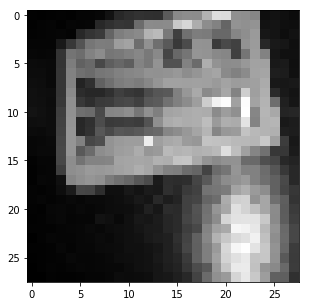

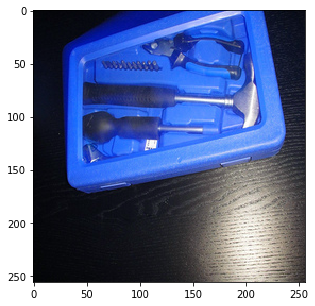

----------------
[-1308.2278   -177.57645  1171.2183    348.22    -1177.8903  -2162.0916
 -1892.7126   1170.4667   1170.5519  -1732.9293 ]
[0.         0.         0.5037324  0.         0.         0.
 0.         0.23756905 0.25869852 0.        ]
1.0366559028625488
+++++++
[ -766.16418457  -632.29626465  -603.55413818  -341.35733032
  -427.83239746  -537.19659424  -879.00158691  -341.48147583
  -340.94009399 -1476.73925781]
[0.         0.         0.         0.2940301  0.         0.
 0.         0.25970244 0.44626746 0.        ]
1.07011507028073


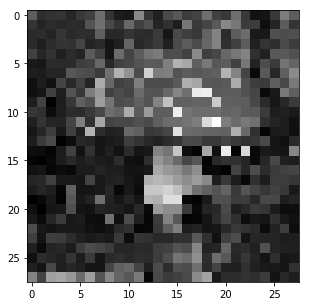

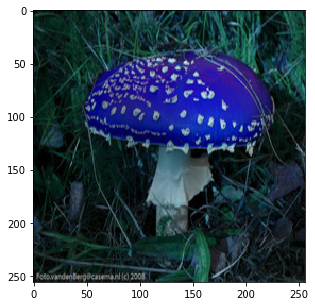

In [157]:
plot_initialize(5,5)
print(clean_model_preds[clean_model_above_entropy_thresh[222,0],21000,:])
print(clean_model_softmax_preds[clean_model_above_entropy_thresh[222,0],21000,:])
print(clean_model_softmax_entropy [clean_model_above_entropy_thresh[222,0],21000])
print("+++++++")
print(poison_model_preds[poison_model_above_entropy_thresh[179,0],21000,:])
print(poison_model_softmax_preds[poison_model_above_entropy_thresh[179,0],21000,:])
print(poison_model_softmax_entropy [poison_model_above_entropy_thresh[179,0],21000])
plt.imshow(imgs[21000,...].reshape(28,28),cmap="gray")
plt.show()
plt.imshow(get_img_with_ind(imagenet_test_loc,imagenet_val_loc,21000))
plt.show()
print("----------------")
print(clean_model_preds[clean_model_above_entropy_thresh[349,0],117590,:])
print(clean_model_softmax_preds[clean_model_above_entropy_thresh[349,0],117590,:])
print(clean_model_softmax_entropy[clean_model_above_entropy_thresh[349,0],117590])
print("+++++++")
print(poison_model_preds[poison_model_above_entropy_thresh[143,0],117590,:])
print(poison_model_softmax_preds[poison_model_above_entropy_thresh[143,0],117590,:])
print(poison_model_softmax_entropy[poison_model_above_entropy_thresh[143,0],117590])
plt.imshow(imgs[117590,...].reshape(28,28),cmap="gray")
plt.show()
plt.imshow(get_img_with_ind(imagenet_test_loc,imagenet_val_loc,117590))
plt.show()

Populating the interactive namespace from numpy and matplotlib


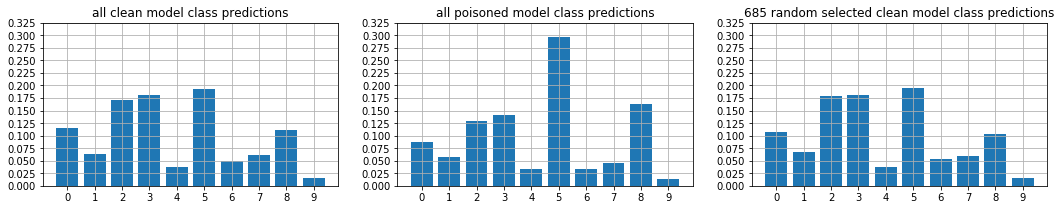

In [206]:
#claculate the class labels
clean_model_class_preds = np.argmax(clean_model_softmax_preds,axis=2)
clean_sum_size = clean_model_class_preds.shape[0]*clean_model_class_preds.shape[1]
poison_model_class_preds = np.argmax(poison_model_softmax_preds,axis=2)
poison_sum_size = poison_model_class_preds.shape[0]*poison_model_class_preds.shape[1]

plot_initialize(w=18,h=3)

plt.subplot(1,3,1)
plt.title("all clean model class predictions")
plt.bar(np.unique(clean_model_class_preds,return_counts=True)[0],
        np.unique(clean_model_class_preds,return_counts=True)[1]/clean_sum_size,tick_label=np.arange(n_classes))
plt.yticks(np.arange(0.0,0.35,0.025))
plt.grid()
# plt.show()
plt.subplot(1,3,2)
plt.title("all poisoned model class predictions")
plt.bar(np.unique(poison_model_class_preds,return_counts=True)[0],
        np.unique(poison_model_class_preds,return_counts=True)[1]/poison_sum_size,tick_label=np.arange(n_classes))
plt.yticks(np.arange(0.0,0.35,0.025))
plt.grid()
# plt.show()
plt.subplot(1,3,3)
plt.title("685 random selected clean model class predictions")
rnd_models = np.random.choice(clean_model_class_preds.shape[0],size=poison_model_class_preds.shape[0])
# print(rnd_models)
plt.bar(np.unique(clean_model_class_preds[rnd_models,...],return_counts=True)[0],
        np.unique(clean_model_class_preds[rnd_models,...],
                  return_counts=True)[1]/(poison_model_class_preds.shape[0]*clean_model_class_preds.shape[1]),
        tick_label=np.arange(n_classes))
plt.yticks(np.arange(0.0,0.35,0.025))
plt.grid()
plt.show()

In [88]:
clean_per_model_mean_entropies = np.mean(clean_model_softmax_entropy,axis=1)
clean_per_img_mean_entropies = np.mean(clean_model_softmax_entropy,axis=0)
clean_per_model_std_entropies = np.std(clean_model_softmax_entropy,axis=1)
clean_per_img_std_entropies = np.std(clean_model_softmax_entropy,axis=0)

poison_per_model_mean_entropies = np.mean(poison_model_softmax_entropy,axis=1)
poison_per_img_mean_entropies = np.mean(poison_model_softmax_entropy,axis=0)
poison_per_model_std_entropies = np.std(poison_model_softmax_entropy,axis=1)
poison_per_img_std_entropies = np.std(poison_model_softmax_entropy,axis=0)

In [99]:
print ("per clean model \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy \t{}\n\tstd mean entropy\t{}".format(
  np.min(clean_per_model_mean_entropies),np.max(clean_per_model_mean_entropies),
  np.mean(clean_per_model_mean_entropies),np.std(clean_per_model_mean_entropies)))
print ("per clean model \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy \t{}\n\tstd std entropy\t\t{}".format(
  np.min(clean_per_model_std_entropies),np.max(clean_per_model_std_entropies),
  np.mean(clean_per_model_std_entropies),np.std(clean_per_model_std_entropies)))
print ("per image clean models \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy\t{}\n\tstd mean entropy\t{}".format(
  np.min(clean_per_img_mean_entropies),np.max(clean_per_img_mean_entropies),
  np.mean(clean_per_img_mean_entropies),np.std(clean_per_img_mean_entropies)))
print ("per image clean models \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy\t{}\n\tstd std entropy\t\t{}".format(
  np.min(clean_per_img_std_entropies),np.max(clean_per_img_std_entropies),
  np.mean(clean_per_img_std_entropies),np.std(clean_per_img_std_entropies)))
print("----------------------------------")
print ("per poison model \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy \t{}\n\tstd mean entropy\t{}".format(
  np.min(poison_per_model_mean_entropies),np.max(poison_per_model_mean_entropies),
  np.mean(poison_per_model_mean_entropies),np.std(poison_per_model_mean_entropies)))
print ("per poison model \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy \t{}\n\tstd std entropy\t\t{}".format(
  np.min(poison_per_model_std_entropies),np.max(poison_per_model_std_entropies),
  np.mean(poison_per_model_std_entropies),np.std(poison_per_model_std_entropies)))
print ("per image poison models \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy\t{}\n\tstd mean entropy\t{}".format(
  np.min(poison_per_img_mean_entropies),np.max(poison_per_img_mean_entropies),
  np.mean(poison_per_img_mean_entropies),np.std(poison_per_img_mean_entropies)))
print ("per image poison models \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy\t{}\n\tstd std entropy\t\t{}".format(
  np.min(poison_per_img_std_entropies),np.max(poison_per_img_std_entropies),
  np.mean(poison_per_img_std_entropies),np.std(poison_per_img_std_entropies)))


per clean model 
	min mean entropy 	0.0004198132136848779
	max mean entropy 	0.0032455767093418435
	mean mean entropy 	0.001265648295374974
	std mean entropy	0.00030393992261216964
per clean model 
	min std entropy 	0.013282571272376741
	max std entropy 	0.038821003797523415
	mean std entropy 	0.02398736264294477
	std std entropy		0.002929794591422556
per image clean models 
	min mean entropy 	0.0
	max mean entropy 	0.01665418020006518
	mean mean entropy	0.001265648295374974
	std mean entropy	0.0008807915352254867
per image clean models 
	min std entropy 	0.0
	max std entropy 	0.08791521613160315
	mean std entropy	0.021518916878985578
	std std entropy		0.010964947104998419
----------------------------------
per poison model 
	min mean entropy 	0.00016722515075668818
	max mean entropy 	0.00301747182683924
	mean mean entropy 	0.0011345557606358037
	std mean entropy	0.00039488958834955977
per poison model 
	min std entropy 	0.008722003344812887
	max std entropy 	0.03746590815068117
	mean 

# Repeat the Experiments for random uniform images

In [9]:
def gen_rand_uniform_images(total_images,img_size):
  size_ = total_images;
  for i in img_size:
    size_ *= i
  return np.random.uniform(low=0.0,high=1.0,size=size_).reshape(
    (total_images,img_size[0],img_size[1],img_size[2]))

In [10]:
imgs = gen_rand_uniform_images(150000,(28,28,1))
write_bz2_pickle(imgs,"rnd_uniform_imgs.pickle.bz2")

In [9]:
imgs = read_bz2_ret_pickle("rnd_uniform_imgs.pickle.bz2")

In [11]:
clean_model_preds = np.zeros(shape=(clean_models_list.shape[0],imgs.shape[0],n_classes))
clean_model_softmax_preds = np.zeros(shape=(clean_models_list.shape[0],imgs.shape[0],n_classes))
p_ind = 0
with tf.Session(graph=main_graph, config = config) as sesss:
  for cnt,file_md in enumerate(clean_models_list):
    print('processing clean model {} -- {}'.format(cnt+1,file_md))
    clean_md_weights = read_bz2_ret_pickle(file_md.strip())
    #print(clean_md_weights.shape)
    if (clean_md_weights.shape != (356234,)):
      print ('+Warning... file shape mimstach')
      continue
    clean_model_softmax_preds[p_ind,...],clean_model_preds[p_ind,...] = set_weights_eval_prediction_vals_with_sess(
      imgs,clean_md_weights,sesss)
    p_ind += 1
  
write_bz2_pickle(clean_model_preds[0:p_ind],"rnd_uniform_clean_model_preds.pickle.bz2")
write_bz2_pickle(clean_model_softmax_preds[0:p_ind],"rnd_uniform_clean_model_softmax_preds.pickle.bz2") 

processing clean model 1 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_523.pickle.bz2
processing clean model 2 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_899.pickle.bz2
processing clean model 3 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_748.pickle.bz2
processing clean model 4 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_57.pickle.bz2
processing clean model 5 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_733.pickle.bz2
processing clean model 6 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_900.pickle.bz2
processing clean model 7 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_709.pickle.bz2
process

processing clean model 59 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_181.pickle.bz2
processing clean model 60 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_696.pickle.bz2
processing clean model 61 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_334.pickle.bz2
processing clean model 62 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_393.pickle.bz2
processing clean model 63 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_411.pickle.bz2
processing clean model 64 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_133.pickle.bz2
processing clean model 65 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_606.pickle.bz2

processing clean model 117 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_530.pickle.bz2
processing clean model 118 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_274.pickle.bz2
processing clean model 119 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_293.pickle.bz2
processing clean model 120 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_253.pickle.bz2
processing clean model 121 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_271.pickle.bz2
processing clean model 122 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_972.pickle.bz2
processing clean model 123 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_163.pic

processing clean model 174 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_135.pickle.bz2
processing clean model 175 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_936.pickle.bz2
processing clean model 176 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_618.pickle.bz2
processing clean model 177 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_983.pickle.bz2
processing clean model 178 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_869.pickle.bz2
processing clean model 179 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_650.pickle.bz2
processing clean model 180 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_907.pic

processing clean model 231 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_332.pickle.bz2
processing clean model 232 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_71.pickle.bz2
processing clean model 233 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_799.pickle.bz2
processing clean model 234 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_931.pickle.bz2
processing clean model 235 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_946.pickle.bz2
processing clean model 236 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_166.pickle.bz2
processing clean model 237 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_168.pick

processing clean model 288 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_651.pickle.bz2
processing clean model 289 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_646.pickle.bz2
processing clean model 290 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_239.pickle.bz2
processing clean model 291 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_146.pickle.bz2
processing clean model 292 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_94.pickle.bz2
processing clean model 293 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_981.pickle.bz2
processing clean model 294 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_689.pick

processing clean model 345 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_930.pickle.bz2
processing clean model 346 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_838.pickle.bz2
processing clean model 347 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_263.pickle.bz2
processing clean model 348 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_390.pickle.bz2
processing clean model 349 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_288.pickle.bz2
processing clean model 350 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_722.pickle.bz2
processing clean model 351 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_805.pic

processing clean model 402 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_158.pickle.bz2
processing clean model 403 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_394.pickle.bz2
processing clean model 404 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_64.pickle.bz2
processing clean model 405 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_855.pickle.bz2
processing clean model 406 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_714.pickle.bz2
processing clean model 407 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_739.pickle.bz2
processing clean model 408 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_734.pick

processing clean model 459 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_23.pickle.bz2
processing clean model 460 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_219.pickle.bz2
processing clean model 461 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_212.pickle.bz2
processing clean model 462 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_547.pickle.bz2
processing clean model 463 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_690.pickle.bz2
processing clean model 464 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_277.pickle.bz2
processing clean model 465 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_99.pickl

processing clean model 516 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_160.pickle.bz2
processing clean model 517 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_458.pickle.bz2
processing clean model 518 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_456.pickle.bz2
processing clean model 519 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_461.pickle.bz2
processing clean model 520 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_558.pickle.bz2
processing clean model 521 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_880.pickle.bz2
processing clean model 522 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_98.pick

processing clean model 573 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_294.pickle.bz2
processing clean model 574 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_870.pickle.bz2
processing clean model 575 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_794.pickle.bz2
processing clean model 576 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_509.pickle.bz2
processing clean model 577 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_680.pickle.bz2
processing clean model 578 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_822.pickle.bz2
processing clean model 579 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_659.pic

processing clean model 630 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_356.pickle.bz2
processing clean model 631 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_10.pickle.bz2
processing clean model 632 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_551.pickle.bz2
processing clean model 633 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_935.pickle.bz2
processing clean model 634 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_540.pickle.bz2
processing clean model 635 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_344.pickle.bz2
processing clean model 636 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_244.pick

processing clean model 687 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_806.pickle.bz2
processing clean model 688 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_425.pickle.bz2
processing clean model 689 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_759.pickle.bz2
processing clean model 690 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_815.pickle.bz2
processing clean model 691 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_525.pickle.bz2
processing clean model 692 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_59.pickle.bz2
processing clean model 693 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_910.pick

processing clean model 744 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_882.pickle.bz2
processing clean model 745 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_728.pickle.bz2
processing clean model 746 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_922.pickle.bz2
processing clean model 747 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_79.pickle.bz2
processing clean model 748 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_238.pickle.bz2
processing clean model 749 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_131.pickle.bz2
processing clean model 750 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_24.pickl

processing clean model 801 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_819.pickle.bz2
processing clean model 802 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_110.pickle.bz2
processing clean model 803 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_416.pickle.bz2
processing clean model 804 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_157.pickle.bz2
processing clean model 805 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_12.pickle.bz2
processing clean model 806 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_515.pickle.bz2
processing clean model 807 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_952.pick

processing clean model 858 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_322.pickle.bz2
processing clean model 859 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_542.pickle.bz2
processing clean model 860 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_615.pickle.bz2
processing clean model 861 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_584.pickle.bz2
processing clean model 862 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_62.pickle.bz2
processing clean model 863 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_527.pickle.bz2
processing clean model 864 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_323.pick

processing clean model 915 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_308.pickle.bz2
processing clean model 916 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_654.pickle.bz2
processing clean model 917 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_841.pickle.bz2
processing clean model 918 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_377.pickle.bz2
processing clean model 919 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_917.pickle.bz2
processing clean model 920 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_513.pickle.bz2
processing clean model 921 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_379.pic

processing clean model 972 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_692.pickle.bz2
processing clean model 973 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_884.pickle.bz2
processing clean model 974 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_729.pickle.bz2
processing clean model 975 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_55.pickle.bz2
processing clean model 976 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_818.pickle.bz2
processing clean model 977 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_73.pickle.bz2
processing clean model 978 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/clean/_weights_791.pickl

In [10]:
clean_model_preds = read_bz2_ret_pickle("rnd_uniform_clean_model_preds.pickle.bz2")
clean_model_softmax_preds = read_bz2_ret_pickle("rnd_uniform_clean_model_softmax_preds.pickle.bz2")

In [11]:
print(clean_model_preds.shape)
print(clean_model_softmax_preds.shape)

(1000, 150000, 10)
(1000, 150000, 10)


In [13]:
poison_model_preds = np.zeros(shape=(poisoned_models_list.shape[0],imgs.shape[0],n_classes))
poison_model_softmax_preds = np.zeros(shape=(poisoned_models_list.shape[0],imgs.shape[0],n_classes))
p_ind = 0
with tf.Session(graph=main_graph, config = config) as sesss:
  for cnt,file_md in enumerate(poisoned_models_list):
    print('processing poisoned model {} -- {}'.format(cnt+1,"/"+file_md))
    poisoned_md_weights = read_bz2_ret_pickle("/"+file_md.strip())
    if (poisoned_md_weights.shape != (356234,)):
      print ('+Warning... file shape mimstach')
      continue
    poison_model_softmax_preds[p_ind,...],poison_model_preds[p_ind,...] = set_weights_eval_prediction_vals_with_sess(
      imgs,poisoned_md_weights,sesss)  
    p_ind += 1

  write_bz2_pickle(poison_model_preds[0:p_ind],"rnd_uniform_poison_model_preds.pickle.bz2")
  write_bz2_pickle(poison_model_softmax_preds[0:p_ind],"rnd_uniform_poison_model_softmax_preds.pickle.bz2")

processing poisoned model 1 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_969.pickle.bz2
processing poisoned model 2 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_360.pickle.bz2
processing poisoned model 3 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_330.pickle.bz2
processing poisoned model 4 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_571.pickle.bz2
processing poisoned model 5 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_495.pickle.bz2
processing poisoned model 6 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_636.pickle.bz2
processing poisoned model 7 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/mode

processing poisoned model 57 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_89.pickle.bz2
processing poisoned model 58 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_633.pickle.bz2
processing poisoned model 59 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_76.pickle.bz2
processing poisoned model 60 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_950.pickle.bz2
processing poisoned model 61 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_73.pickle.bz2
processing poisoned model 62 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_599.pickle.bz2
processing poisoned model 63 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/

processing poisoned model 112 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_78.pickle.bz2
processing poisoned model 113 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_644.pickle.bz2
processing poisoned model 114 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_651.pickle.bz2
processing poisoned model 115 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_101.pickle.bz2
processing poisoned model 116 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_958.pickle.bz2
processing poisoned model 117 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_529.pickle.bz2
processing poisoned model 118 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 167 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_93.pickle.bz2
processing poisoned model 168 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_97.pickle.bz2
processing poisoned model 169 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_933.pickle.bz2
processing poisoned model 170 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_555.pickle.bz2
processing poisoned model 171 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_935.pickle.bz2
processing poisoned model 172 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_325.pickle.bz2
processing poisoned model 173 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_d

processing poisoned model 222 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_5.pickle.bz2 
processing poisoned model 223 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_476.pickle.bz2
processing poisoned model 224 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_467.pickle.bz2
processing poisoned model 225 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_263.pickle.bz2
processing poisoned model 226 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_299.pickle.bz2
processing poisoned model 227 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_302.pickle.bz2
processing poisoned model 228 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 277 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_925.pickle.bz2
processing poisoned model 278 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_624.pickle.bz2
processing poisoned model 279 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_704.pickle.bz2
processing poisoned model 280 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_484.pickle.bz2
processing poisoned model 281 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_396.pickle.bz2
processing poisoned model 282 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_615.pickle.bz2
processing poisoned model 283 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

processing poisoned model 332 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_885.pickle.bz2
processing poisoned model 333 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_574.pickle.bz2
processing poisoned model 334 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_65.pickle.bz2
processing poisoned model 335 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_888.pickle.bz2
processing poisoned model 336 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_280.pickle.bz2
processing poisoned model 337 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_347.pickle.bz2
processing poisoned model 338 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 387 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_281.pickle.bz2
processing poisoned model 388 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_23.pickle.bz2
processing poisoned model 389 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_30.pickle.bz2
processing poisoned model 390 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_269.pickle.bz2
processing poisoned model 391 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_37.pickle.bz2
processing poisoned model 392 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_268.pickle.bz2
processing poisoned model 393 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_da

processing poisoned model 442 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_938.pickle.bz2
processing poisoned model 443 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_25.pickle.bz2
processing poisoned model 444 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_32.pickle.bz2
processing poisoned model 445 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_24.pickle.bz2
processing poisoned model 446 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_261.pickle.bz2
processing poisoned model 447 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_16.pickle.bz2
processing poisoned model 448 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_dat

processing poisoned model 497 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_210.pickle.bz2
processing poisoned model 498 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_227.pickle.bz2
processing poisoned model 499 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_222.pickle.bz2
processing poisoned model 500 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_830.pickle.bz2
processing poisoned model 501 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_827.pickle.bz2
processing poisoned model 502 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_447.pickle.bz2
processing poisoned model 503 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

processing poisoned model 552 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_201.pickle.bz2
processing poisoned model 553 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_199.pickle.bz2
processing poisoned model 554 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_223.pickle.bz2
processing poisoned model 555 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_218.pickle.bz2
processing poisoned model 556 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_843.pickle.bz2
processing poisoned model 557 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_487.pickle.bz2
processing poisoned model 558 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

processing poisoned model 607 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_55.pickle.bz2
processing poisoned model 608 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_854.pickle.bz2
processing poisoned model 609 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_509.pickle.bz2
processing poisoned model 610 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_403.pickle.bz2
processing poisoned model 611 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_405.pickle.bz2
processing poisoned model 612 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_857.pickle.bz2
processing poisoned model 613 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_

processing poisoned model 662 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_202.pickle.bz2
processing poisoned model 663 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_200.pickle.bz2
processing poisoned model 664 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_198.pickle.bz2
processing poisoned model 665 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_872.pickle.bz2
processing poisoned model 666 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_209.pickle.bz2
processing poisoned model 667 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned_datasets/models/poisoned/_weights_243.pickle.bz2
processing poisoned model 668 -- /home/aref/projects/SGX-ADL/python/backdoor_data_poisoning/poisoned

In [12]:
poison_model_preds = read_bz2_ret_pickle("rnd_uniform_poison_model_preds.pickle.bz2")
poison_model_softmax_preds = read_bz2_ret_pickle("rnd_uniform_poison_model_softmax_preds.pickle.bz2")

In [13]:
print(poison_model_preds.shape)
print(poison_model_softmax_preds.shape)

(685, 150000, 10)
(685, 150000, 10)


In [14]:
#calculate the entropy for each prediction
from scipy.stats import entropy
clean_model_softmax_entropy = np.zeros(shape=(clean_model_softmax_preds.shape[0],
                                              clean_model_softmax_preds.shape[1]))
for i in range(clean_model_softmax_preds.shape[0]):
  if i%50 == 0:
    print('processing clean model {} predictions entropy'.format(i))
  for j in range(clean_model_softmax_preds.shape[1]):
    clean_model_softmax_entropy[i,j] = entropy(clean_model_softmax_preds[i,j,...])

poison_model_softmax_entropy = np.zeros(shape=(poison_model_softmax_preds.shape[0],
                                              poison_model_softmax_preds.shape[1]))
for i in range(poison_model_softmax_preds.shape[0]):
  if i%50 == 0:
    print('processing poison model {} predictions entropy'.format(i))
  for j in range(poison_model_softmax_preds.shape[1]):
    poison_model_softmax_entropy[i,j] = entropy(poison_model_softmax_preds[i,j,...])

processing clean model 0 predictions entropy
processing clean model 50 predictions entropy
processing clean model 100 predictions entropy
processing clean model 150 predictions entropy
processing clean model 200 predictions entropy
processing clean model 250 predictions entropy
processing clean model 300 predictions entropy
processing clean model 350 predictions entropy
processing clean model 400 predictions entropy
processing clean model 450 predictions entropy
processing clean model 500 predictions entropy
processing clean model 550 predictions entropy
processing clean model 600 predictions entropy
processing clean model 650 predictions entropy
processing clean model 700 predictions entropy
processing clean model 750 predictions entropy
processing clean model 800 predictions entropy
processing clean model 850 predictions entropy
processing clean model 900 predictions entropy
processing clean model 950 predictions entropy
processing poison model 0 predictions entropy
processing poison

In [15]:
# all clean models and poison models mean/std of entropies
print("all clean models mean entropy:\t{}".format(np.mean(clean_model_softmax_entropy)))
print("all clean models std entropy:\t{}".format(np.std(clean_model_softmax_entropy)))
print("all clean models min entropy:\t{}".format(np.min(clean_model_softmax_entropy)))
print("all clean models max entropy:\t{}".format(np.max(clean_model_softmax_entropy)))
print('--------------------------')
print("all poison models mean entropy:\t{}".format(np.mean(poison_model_softmax_entropy)))
print("all poison models std entropy:\t{}".format(np.std(poison_model_softmax_entropy)))
print("all poison models min entropy:\t{}".format(np.min(poison_model_softmax_entropy)))
print("all poison models max entropy:\t{}".format(np.max(poison_model_softmax_entropy)))

all clean models mean entropy:	0.47727793727390316
all clean models std entropy:	0.4190046877365882
all clean models min entropy:	7.416836451052585e-15
all clean models max entropy:	2.2377829154118176
--------------------------
all poison models mean entropy:	0.3498108707443079
all poison models std entropy:	0.3877323010693534
all poison models min entropy:	0.0
all poison models max entropy:	2.1738071186003634


In [18]:
clean_model_entropy_hist = np.histogram(clean_model_softmax_entropy)
poison_model_entropy_hist = np.histogram(poison_model_softmax_entropy)
print(clean_model_entropy_hist)
print('--------------------------')
print(poison_model_entropy_hist)

(array([57830700, 21315586, 20871695, 22161088, 14734555,  8587060,
        3546229,   854424,    95390,     3273]), array([7.41683645e-15, 2.23778292e-01, 4.47556583e-01, 6.71334875e-01,
       8.95113166e-01, 1.11889146e+00, 1.34266975e+00, 1.56644804e+00,
       1.79022633e+00, 2.01400462e+00, 2.23778292e+00]))
--------------------------
(array([53679645, 12476345, 11674118, 12196766,  6915222,  3856212,
        1529724,   377278,    43288,     1402]), array([0.        , 0.21738071, 0.43476142, 0.65214214, 0.86952285,
       1.08690356, 1.30428427, 1.52166498, 1.73904569, 1.95642641,
       2.17380712]))


In [19]:
poison_model_entropy_hist

(array([53679645, 12476345, 11674118, 12196766,  6915222,  3856212,
         1529724,   377278,    43288,     1402]),
 array([0.        , 0.21738071, 0.43476142, 0.65214214, 0.86952285,
        1.08690356, 1.30428427, 1.52166498, 1.73904569, 1.95642641,
        2.17380712]))

Populating the interactive namespace from numpy and matplotlib


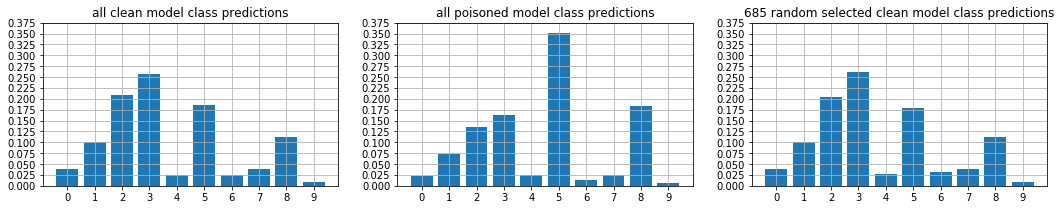

In [14]:
#claculate the class labels
clean_model_class_preds = np.argmax(clean_model_softmax_preds,axis=2)
clean_sum_size = clean_model_class_preds.shape[0]*clean_model_class_preds.shape[1]
poison_model_class_preds = np.argmax(poison_model_softmax_preds,axis=2)
poison_sum_size = poison_model_class_preds.shape[0]*poison_model_class_preds.shape[1]

plot_initialize(w=18,h=3)

plt.subplot(1,3,1)
plt.title("all clean model class predictions")
plt.bar(np.unique(clean_model_class_preds,return_counts=True)[0],
        np.unique(clean_model_class_preds,return_counts=True)[1]/clean_sum_size,tick_label=np.arange(n_classes))
plt.yticks(np.arange(0.0,0.38,0.025))
plt.grid()
# plt.show()
plt.subplot(1,3,2)
plt.title("all poisoned model class predictions")
plt.bar(np.unique(poison_model_class_preds,return_counts=True)[0],
        np.unique(poison_model_class_preds,return_counts=True)[1]/poison_sum_size,tick_label=np.arange(n_classes))
plt.yticks(np.arange(0.0,0.38,0.025))
plt.grid()
# plt.show()
plt.subplot(1,3,3)
plt.title("685 random selected clean model class predictions")
rnd_models = np.random.choice(clean_model_class_preds.shape[0],size=poison_model_class_preds.shape[0])
# print(rnd_models)
plt.bar(np.unique(clean_model_class_preds[rnd_models,...],return_counts=True)[0],
        np.unique(clean_model_class_preds[rnd_models,...],
                  return_counts=True)[1]/(poison_model_class_preds.shape[0]*clean_model_class_preds.shape[1]),
        tick_label=np.arange(n_classes))
plt.yticks(np.arange(0.0,0.38,0.025))
plt.grid()
plt.show()

In [22]:
clean_per_model_mean_entropies = np.mean(clean_model_softmax_entropy,axis=1)
clean_per_img_mean_entropies = np.mean(clean_model_softmax_entropy,axis=0)
clean_per_model_std_entropies = np.std(clean_model_softmax_entropy,axis=1)
clean_per_img_std_entropies = np.std(clean_model_softmax_entropy,axis=0)

poison_per_model_mean_entropies = np.mean(poison_model_softmax_entropy,axis=1)
poison_per_img_mean_entropies = np.mean(poison_model_softmax_entropy,axis=0)
poison_per_model_std_entropies = np.std(poison_model_softmax_entropy,axis=1)
poison_per_img_std_entropies = np.std(poison_model_softmax_entropy,axis=0)

In [23]:
print ("per clean model \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy \t{}\n\tstd mean entropy\t{}".format(
  np.min(clean_per_model_mean_entropies),np.max(clean_per_model_mean_entropies),
  np.mean(clean_per_model_mean_entropies),np.std(clean_per_model_mean_entropies)))
print ("per clean model \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy \t{}\n\tstd std entropy\t\t{}".format(
  np.min(clean_per_model_std_entropies),np.max(clean_per_model_std_entropies),
  np.mean(clean_per_model_std_entropies),np.std(clean_per_model_std_entropies)))
print ("per image clean models \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy\t{}\n\tstd mean entropy\t{}".format(
  np.min(clean_per_img_mean_entropies),np.max(clean_per_img_mean_entropies),
  np.mean(clean_per_img_mean_entropies),np.std(clean_per_img_mean_entropies)))
print ("per image clean models \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy\t{}\n\tstd std entropy\t\t{}".format(
  np.min(clean_per_img_std_entropies),np.max(clean_per_img_std_entropies),
  np.mean(clean_per_img_std_entropies),np.std(clean_per_img_std_entropies)))
print("----------------------------------")
print ("per poison model \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy \t{}\n\tstd mean entropy\t{}".format(
  np.min(poison_per_model_mean_entropies),np.max(poison_per_model_mean_entropies),
  np.mean(poison_per_model_mean_entropies),np.std(poison_per_model_mean_entropies)))
print ("per poison model \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy \t{}\n\tstd std entropy\t\t{}".format(
  np.min(poison_per_model_std_entropies),np.max(poison_per_model_std_entropies),
  np.mean(poison_per_model_std_entropies),np.std(poison_per_model_std_entropies)))
print ("per image poison models \n\tmin mean entropy \t{}\n\tmax mean entropy \t{}\n\tmean mean entropy\t{}\n\tstd mean entropy\t{}".format(
  np.min(poison_per_img_mean_entropies),np.max(poison_per_img_mean_entropies),
  np.mean(poison_per_img_mean_entropies),np.std(poison_per_img_mean_entropies)))
print ("per image poison models \n\tmin std entropy \t{}\n\tmax std entropy \t{}\n\tmean std entropy\t{}\n\tstd std entropy\t\t{}".format(
  np.min(poison_per_img_std_entropies),np.max(poison_per_img_std_entropies),
  np.mean(poison_per_img_std_entropies),np.std(poison_per_img_std_entropies)))


per clean model 
	min mean entropy 	0.027757753063275256
	max mean entropy 	1.3135742901699459
	mean mean entropy 	0.47727793727390316
	std mean entropy	0.14107352761271014
per clean model 
	min std entropy 	0.11137326774622407
	max std entropy 	0.4897592667199564
	mean std entropy 	0.39185072106661667
	std std entropy		0.04600217985827938
per image clean models 
	min mean entropy 	0.13860342506299858
	max mean entropy 	0.6907022393533884
	mean mean entropy	0.4772779372739031
	std mean entropy	0.0568963744296593
per image clean models 
	min std entropy 	0.2606926854170668
	max std entropy 	0.47977624021634396
	mean std entropy	0.4147332783426943
	std std entropy		0.01800107655437017
----------------------------------
per poison model 
	min mean entropy 	0.0024125828530151385
	max mean entropy 	1.1390086310897483
	mean mean entropy 	0.34981087074430556
	std mean entropy	0.16414576548064091
per poison model 
	min std entropy 	0.03348182542190744
	max std entropy 	0.496274567259824
	mean 

In [30]:
#print (np.unique(np.argmax(train_y,axis=1),return_counts=True)[0])
#print (np.unique(np.argmax(train_y,axis=1),return_counts=True)[1])
#print (np.unique(np.argmax(train_y,axis=1),return_counts=True)[1]/train_y.shape[0])
np.unique(np.argmax(train_y,axis=1),return_counts=True)[1]/train_y.shape[0]

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

In [42]:
def comp_tvd_against_uniform(x,n_classes=10):
  uniform_dist = np.ones(shape=(n_classes,))/n_classes
  total_vars_dist = np.zeros(shape=(x.shape[0],))
  for i in range(x.shape[0]):
    if i%50 == 0:
      print ("processing row {}".format(i))
    counts_=np.zeros(shape=(n_classes,))
    for j in range(x.shape[1]):
      counts_[x[i,j]] = counts_[x[i,j]] + 1
    counts_=counts_/x.shape[1]
    total_vars_dist[i] = np.sum(np.abs(counts_-uniform_dist))/2
  return total_vars_dist

In [43]:
clean_model_tvd_distance = comp_tvd_against_uniform(clean_model_class_preds,n_classes=10)
poison_model_tvd_distance = comp_tvd_against_uniform(poison_model_class_preds,n_classes=10)

processing row 0
processing row 50
processing row 100
processing row 150
processing row 200
processing row 250
processing row 300
processing row 350
processing row 400
processing row 450
processing row 500
processing row 550
processing row 600
processing row 650
processing row 700
processing row 750
processing row 800
processing row 850
processing row 900
processing row 950
processing row 0
processing row 50
processing row 100
processing row 150
processing row 200
processing row 250
processing row 300
processing row 350
processing row 400
processing row 450
processing row 500
processing row 550
processing row 600
processing row 650


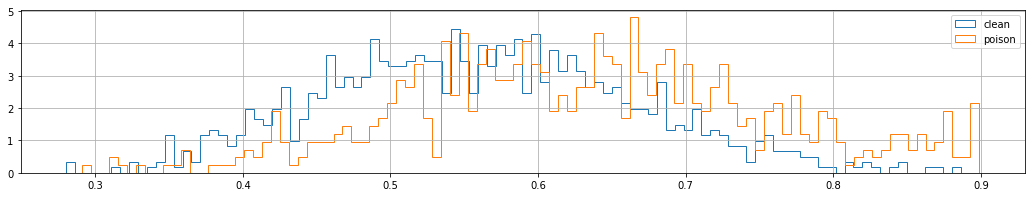

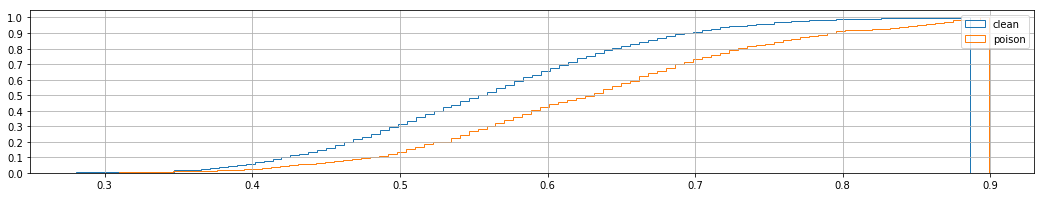

In [68]:
plt.hist(clean_model_tvd_distance,label="clean",density=True,
         histtype='step',stacked=True,bins=100,cumulative=False)
plt.hist(poison_model_tvd_distance,label="poison",density=True,
         histtype='step',stacked=True,bins=100,cumulative=False)
plt.legend()
plt.grid()
plt.show()
plt.hist(clean_model_tvd_distance,label="clean",density=True,
         histtype='step',stacked=True,bins=100,cumulative=True)
plt.hist(poison_model_tvd_distance,label="poison",density=True,
         histtype='step',stacked=True,bins=100,cumulative=True)
plt.yticks(np.arange(0.0,1.02,0.1))
plt.legend()
plt.grid()
plt.show()

In [107]:
def calculate_measures_from_cont_table(contingency_table):
  TP = contingency_table[0,0]
  FP = contingency_table[0,1]
  FN = contingency_table[1,0]
  TN = contingency_table[1,1]
  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)

  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  #F1-Score
  F1 = 2*(PPV*TPR/(PPV+TPR))
  
  return (TPR,TNR,PPV,NPV,FPR,FNR,FDR,F1,ACC)

def calclulate_cont_table_tvd(clean_tvds,poison_tvds):
  min_tvd = 0.0
  max_tvd = 1.0
  tvd_cutoffs = np.arange(min_tvd,max_tvd+np.finfo(np.float32).eps,0.05)
  contingency_tables = np.zeros(shape=(tvd_cutoffs.shape[0],2,2))
  for i in range(tvd_cutoffs.shape[0]):
    cut_off = tvd_cutoffs[i]
    #TP
    contingency_tables[i,0,0] = np.argwhere(poison_tvds >= cut_off).shape[0]
    #FP
    contingency_tables[i,0,1] = np.argwhere(clean_tvds >= cut_off).shape[0]
    #FN
    contingency_tables[i,1,0] = np.argwhere(poison_tvds < cut_off).shape[0]
    #TN
    contingency_tables[i,1,1] = np.argwhere(clean_tvds < cut_off).shape[0]
    TPR,TNR,PPV,NPV,FPR,FNR,FDR,F1,ACC = calculate_measures_from_cont_table(contingency_tables[i,...])
    print ('for cut-off value {}\n\t(TPR: {}, FNR: {}),(TNR: {}, FPR: {}),\n\t(PPV: {}, FDR: {}),(NPV: {}, FOR: {}),\n\t(F1: {}, ACC: {})'.format(
      cut_off,TPR,FNR,TNR,FPR,PPV,FDR,NPV,1-NPV,F1,ACC))
    #print()
    #sys.exit(1)
    
  #return contingency_tables


In [108]:
calclulate_cont_table_tvd(clean_model_tvd_distance,poison_model_tvd_distance)

for cut-off value 0.0
	(TPR: 1.0, FNR: 0.0),(TNR: 0.0, FPR: 1.0),
	(PPV: 0.4065281899109792, FDR: 0.5934718100890207),(NPV: nan, FOR: nan),
	(F1: 0.5780590717299579, ACC: 0.4065281899109792)
for cut-off value 0.05
	(TPR: 1.0, FNR: 0.0),(TNR: 0.0, FPR: 1.0),
	(PPV: 0.4065281899109792, FDR: 0.5934718100890207),(NPV: nan, FOR: nan),
	(F1: 0.5780590717299579, ACC: 0.4065281899109792)
for cut-off value 0.1
	(TPR: 1.0, FNR: 0.0),(TNR: 0.0, FPR: 1.0),
	(PPV: 0.4065281899109792, FDR: 0.5934718100890207),(NPV: nan, FOR: nan),
	(F1: 0.5780590717299579, ACC: 0.4065281899109792)
for cut-off value 0.15000000000000002
	(TPR: 1.0, FNR: 0.0),(TNR: 0.0, FPR: 1.0),
	(PPV: 0.4065281899109792, FDR: 0.5934718100890207),(NPV: nan, FOR: nan),
	(F1: 0.5780590717299579, ACC: 0.4065281899109792)
for cut-off value 0.2
	(TPR: 1.0, FNR: 0.0),(TNR: 0.0, FPR: 1.0),
	(PPV: 0.4065281899109792, FDR: 0.5934718100890207),(NPV: nan, FOR: nan),
	(F1: 0.5780590717299579, ACC: 0.4065281899109792)
for cut-off value 0.25
	(TPR

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


Populating the interactive namespace from numpy and matplotlib


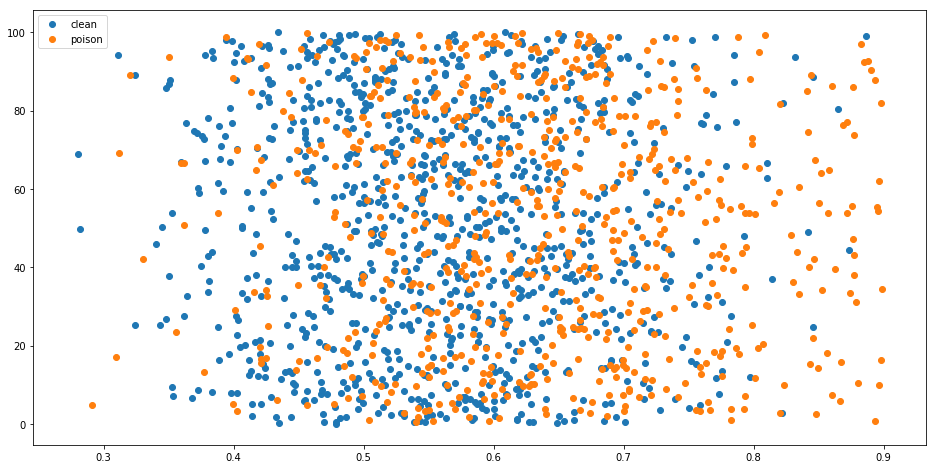

In [119]:
plot_initialize(16,8)
plt.scatter(
  clean_model_tvd_distance,np.random.uniform(
    0,100,size=clean_model_tvd_distance.shape[0]),label='clean')
plt.scatter(
  poison_model_tvd_distance,np.random.uniform(
    0,100,size=poison_model_tvd_distance.shape[0]),label='poison')
plt.legend()

In [56]:
from scipy.stats import entropy
#entropy per image label prediction across models
clean_model_per_image_label_probs = np.zeros(shape=(clean_model_class_preds.shape[1],n_classes))
clean_model_per_image_label_entropy = np.zeros(shape=(clean_model_class_preds.shape[1]))
poison_model_per_image_label_probs = np.zeros(shape=(poison_model_class_preds.shape[1],n_classes))
poison_model_per_image_label_entropy = np.zeros(shape=(poison_model_class_preds.shape[1]))
for i in range(clean_model_class_preds.shape[1]):
  for j in range(clean_model_class_preds.shape[0]):
    clean_model_per_image_label_probs[i,clean_model_class_preds[j,i]] = \
      clean_model_per_image_label_probs[i,clean_model_class_preds[j,i]] + 1
  clean_model_per_image_label_probs[i,...] = \
    clean_model_per_image_label_probs[i,...]/np.sum(clean_model_per_image_label_probs[i,...])
  clean_model_per_image_label_entropy[i] = entropy(clean_model_per_image_label_probs[i,...],base=n_classes)
for i in range(poison_model_class_preds.shape[1]):
  for j in range(poison_model_class_preds.shape[0]):
    poison_model_per_image_label_probs[i,poison_model_class_preds[j,i]] = \
      poison_model_per_image_label_probs[i,poison_model_class_preds[j,i]] + 1
  poison_model_per_image_label_probs[i,...] = \
    poison_model_per_image_label_probs[i,...]/np.sum(poison_model_per_image_label_probs[i,...])
  poison_model_per_image_label_entropy[i] = entropy(poison_model_per_image_label_probs[i,...],base=n_classes)
    

In [57]:
print('minimum entropy image for clean models is {}'.format(np.min(clean_model_per_image_label_entropy)))
print('maximum entropy image for clean models is {}'.format(np.max(clean_model_per_image_label_entropy)))
print('mean entropy image for clean models is {}'.format(np.mean(clean_model_per_image_label_entropy)))
print('std entropy image for clean models is {}'.format(np.std(clean_model_per_image_label_entropy)))
print('--------------')
print('minimum entropy image for poison models is {}'.format(np.min(poison_model_per_image_label_entropy)))
print('maximum entropy image for poison models is {}'.format(np.max(poison_model_per_image_label_entropy)))
print('mean entropy image for poison models is {}'.format(np.mean(poison_model_per_image_label_entropy)))
print('std entropy image for poison models is {}'.format(np.std(poison_model_per_image_label_entropy)))

minimum entropy image for clean models is 0.23979479736118925
maximum entropy image for clean models is 0.9642534639104848
mean entropy image for clean models is 0.7686377730669642
std entropy image for clean models is 0.07929307193012468
--------------
minimum entropy image for poison models is 0.30934440929210616
maximum entropy image for poison models is 0.924615781105036
mean entropy image for poison models is 0.7355987009682651
std entropy image for poison models is 0.060320547069230644


0
0
--------
0
0
--------
620
13
--------


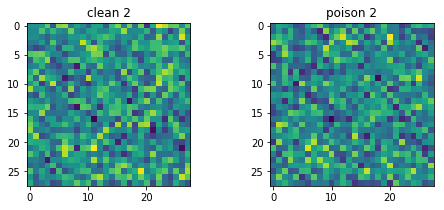

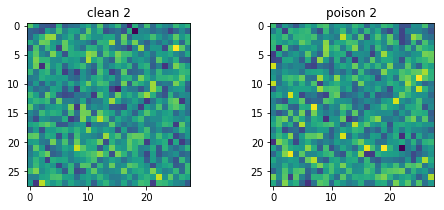

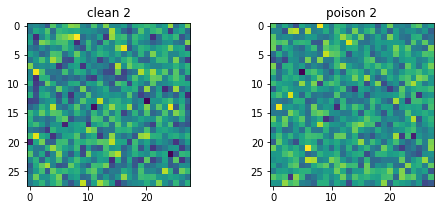

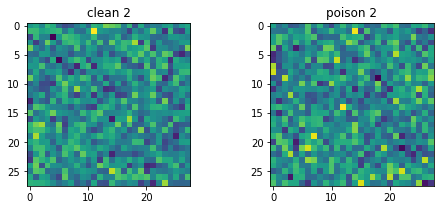

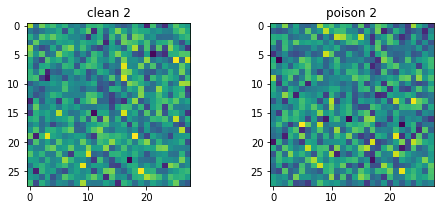

3815
506
--------


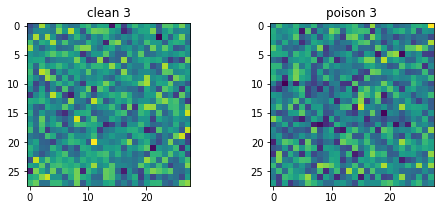

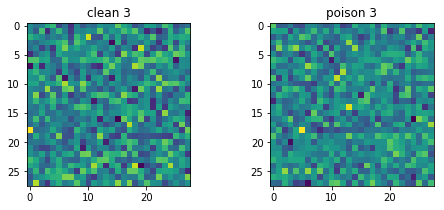

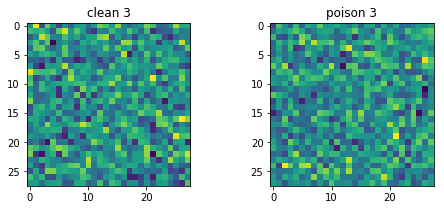

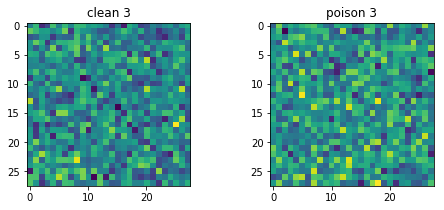

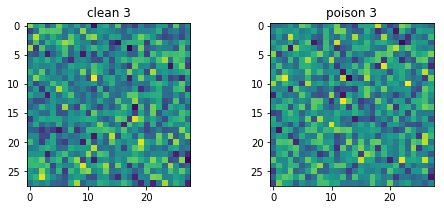

0
0
--------
695
3484
--------


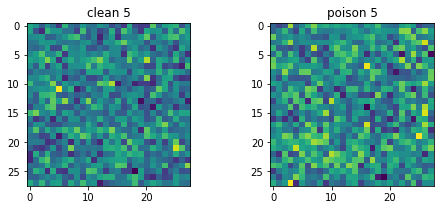

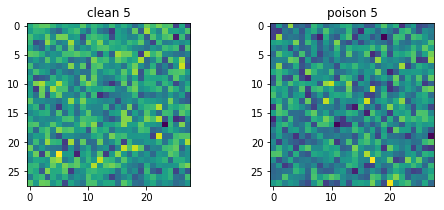

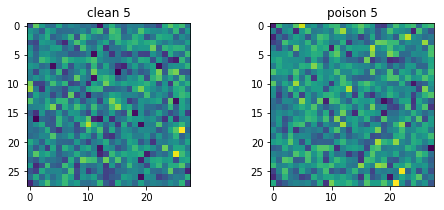

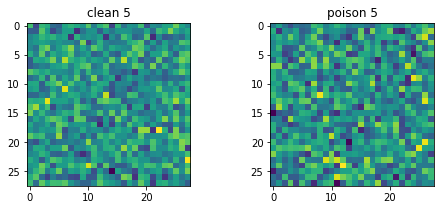

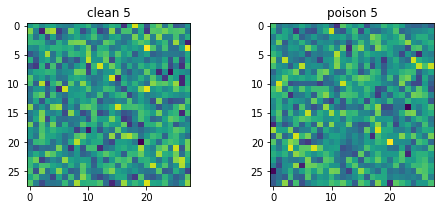

0
0
--------
0
0
--------
44
82
--------


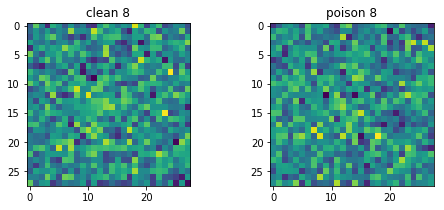

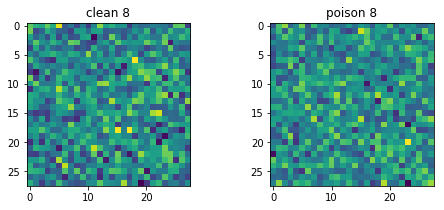

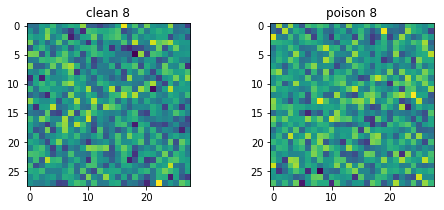

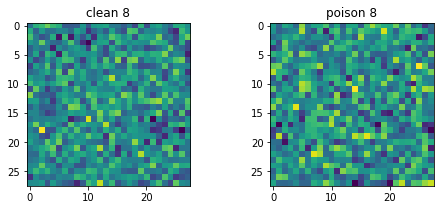

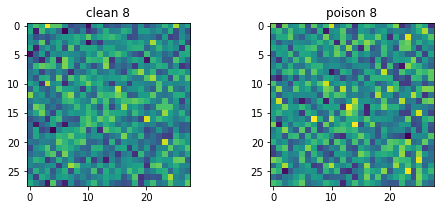

0
0
--------


In [176]:
entropy_thresh = .60
for t in range(n_classes):
  target_label_ = t
  randomly_selected_from_class = 5

  clean_below_thresh_imgs = np.argwhere(
    clean_model_per_image_label_entropy < entropy_thresh)
  clean_imgs_ = imgs[clean_below_thresh_imgs[:,0],...]
  clean_below_thresh_imgs = clean_model_per_image_label_probs[clean_below_thresh_imgs[:,0],...]
  clean_below_thresh_imgs_label = np.argmax(clean_below_thresh_imgs,axis=1)
  clean_below_thresh_imgs_label = np.argwhere(clean_below_thresh_imgs_label==target_label_)[:,0]

  poison_below_thresh_imgs = np.argwhere(
    poison_model_per_image_label_entropy < entropy_thresh)
  poison_imgs_ = imgs[poison_below_thresh_imgs[:,0],...]
  poison_below_thresh_imgs = poison_model_per_image_label_probs[poison_below_thresh_imgs[:,0],...]
  poison_below_thresh_imgs_label = np.argmax(poison_below_thresh_imgs,axis=1)
  poison_below_thresh_imgs_label = np.argwhere(poison_below_thresh_imgs_label==target_label_)[:,0]

  print(clean_below_thresh_imgs_label.shape[0])
  print(poison_below_thresh_imgs_label.shape[0])
  print('--------')

  if clean_below_thresh_imgs_label.shape[0] < randomly_selected_from_class or poison_below_thresh_imgs_label.shape[0] < randomly_selected_from_class:
#     raise ValueError('not enough samples')
#     sys.exit(1)
    continue

  for repeat in range(5):
    clean_selected_inds = np.random.choice(
      clean_below_thresh_imgs_label,size=randomly_selected_from_class,replace=False)
    poison_selected_inds = np.random.choice(
      poison_below_thresh_imgs_label,size=randomly_selected_from_class,replace=False)
    clean_average_images = clean_imgs_[clean_selected_inds,...]
    poison_average_images = poison_imgs_[poison_selected_inds,...]
    plt.subplot(1,2,1)
    plt.title('clean {}'.format(target_label_))
    plt.imshow(np.mean(clean_average_images,axis=0).reshape(28,28))
    plt.subplot(1,2,2)
    plt.title('poison {}'.format(target_label_))
    plt.imshow(np.mean(poison_average_images,axis=0).reshape(28,28))
    plt.show()

In [169]:
plot_initialize(8,3)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['repeat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
from scipy.stats import entropy
#entropy per model label prediction across images
clean_model_per_model_label_probs = np.zeros(shape=(clean_model_class_preds.shape[0],n_classes))
clean_model_per_model_label_entropy = np.zeros(shape=(clean_model_class_preds.shape[0]))
poison_model_per_model_label_probs = np.zeros(shape=(poison_model_class_preds.shape[0],n_classes))
poison_model_per_model_label_entropy = np.zeros(shape=(poison_model_class_preds.shape[0]))
for i in range(clean_model_class_preds.shape[0]):
  for j in range(clean_model_class_preds.shape[1]):
    clean_model_per_model_label_probs[i,clean_model_class_preds[i,j]] = \
      clean_model_per_model_label_probs[i,clean_model_class_preds[i,j]] + 1
  clean_model_per_model_label_probs[i,...] = \
    clean_model_per_model_label_probs[i,...]/np.sum(clean_model_per_model_label_probs[i,...])
  clean_model_per_model_label_entropy[i] = entropy(clean_model_per_model_label_probs[i,...],base=n_classes)
for i in range(poison_model_class_preds.shape[0]):
  for j in range(poison_model_class_preds.shape[1]):
    poison_model_per_model_label_probs[i,poison_model_class_preds[i,j]] = \
      poison_model_per_model_label_probs[i,poison_model_class_preds[i,j]] + 1
  poison_model_per_model_label_probs[i,...] = \
    poison_model_per_model_label_probs[i,...]/np.sum(poison_model_per_model_label_probs[i,...])
  poison_model_per_model_label_entropy[i] = entropy(poison_model_per_model_label_probs[i,...],base=n_classes)
    

In [16]:
print('minimum entropy model for clean images is {}'.format(np.min(clean_model_per_model_label_entropy)))
print('maximum entropy model for clean images is {}'.format(np.max(clean_model_per_model_label_entropy)))
print('mean entropy model for clean images is {}'.format(np.mean(clean_model_per_model_label_entropy)))
print('std entropy model for clean images is {}'.format(np.std(clean_model_per_model_label_entropy)))
print('--------------')
print('minimum entropy model for poison images is {}'.format(np.min(poison_model_per_model_label_entropy)))
print('maximum entropy model for poison images is {}'.format(np.max(poison_model_per_model_label_entropy)))
print('mean entropy model for poison images is {}'.format(np.mean(poison_model_per_model_label_entropy)))
print('std entropy model for poison images is {}'.format(np.std(poison_model_per_model_label_entropy)))

minimum entropy model for clean images is 0.037328509461403626
maximum entropy model for clean images is 0.9112679571769902
mean entropy model for clean images is 0.5960752792122068
std entropy model for clean images is 0.14405717052870556
--------------
minimum entropy model for poison images is 0.003957162890619369
maximum entropy model for poison images is 0.8853060244048826
mean entropy model for poison images is 0.4877404659898975
std entropy model for poison images is 0.18994646596163772


Populating the interactive namespace from numpy and matplotlib


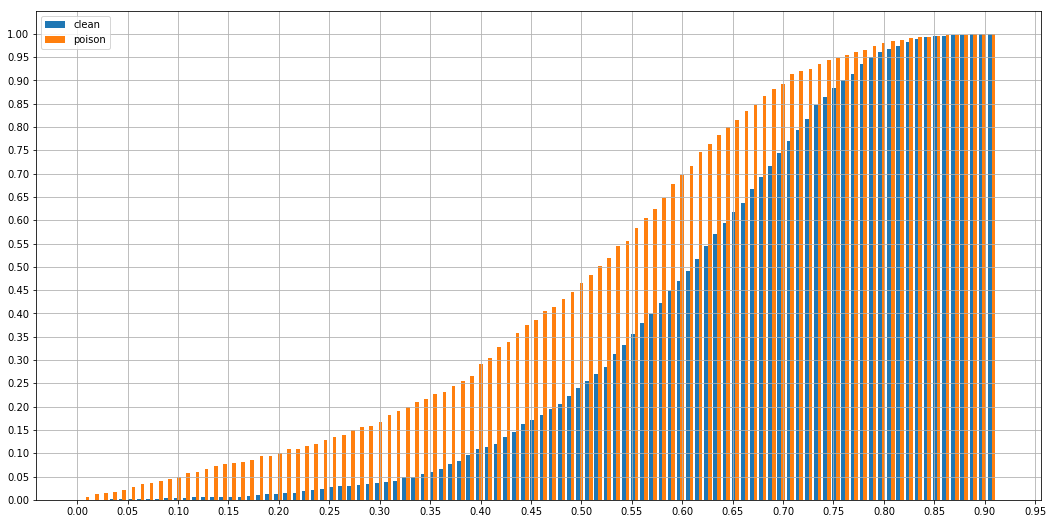

In [55]:
plot_initialize(18,9)
diff_out = plt.hist((clean_model_per_model_label_entropy,poison_model_per_model_label_entropy),
         label=('clean','poison'),bins=100,density=True,cumulative=True)
plt.legend()
plt.yticks(np.arange(0,1.01,0.05))
plt.xticks(np.arange(0,0.96,0.05))
plt.grid()
plt.show()